In [1]:
import time
from datetime import datetime
from datetime import timedelta
import pytz

from xbos import get_client
from xbos.services import mdal
from xbos.services.hod import HodClient
# import dataclient

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

import numpy as np

import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib import colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

from prettytable import PrettyTable

In [2]:
# SITES, EVENT DATES, NEARBY WEATHER STATIONS
SITE_WEATHER_STATION = {"hayward-station-1":"683bf516-1519-359c-92a2-7289d5ce66dc",
             "hayward-station-8":"683bf516-1519-359c-92a2-7289d5ce66dc",
             "ciee":"a73c1b67-142f-3b45-baf8-e308619b6bbc",
             "orinda-community-center":"fd7bbbf6-5f28-321a-99db-def8e84bd4af",
             "word-of-faith-cc":"fa8f400e-766d-30a2-999f-6121eaf0d117",
             "south-berkeley-senior-center":"a73c1b67-142f-3b45-baf8-e308619b6bbc",
             "north-berkeley-senior-center":"a73c1b67-142f-3b45-baf8-e308619b6bbc",
             "berkeley-corporate-yard":"a73c1b67-142f-3b45-baf8-e308619b6bbc",
             "avenal-veterans-hall":"c3d0f042-2cb7-387c-8867-4190fef4fd2c",
             "avenal-public-works-yard":"c3d0f042-2cb7-387c-8867-4190fef4fd2c",
             "avenal-animal-shelter":"c3d0f042-2cb7-387c-8867-4190fef4fd2c",
             "avenal-movie-theatre":"c3d0f042-2cb7-387c-8867-4190fef4fd2c",
             "avenal-recreation-center":"c3d0f042-2cb7-387c-8867-4190fef4fd2c",
             "local-butcher-shop":"a73c1b67-142f-3b45-baf8-e308619b6bbc",
             "rfs":"a73c1b67-142f-3b45-baf8-e308619b6bbc",
             "csu-dominguez-hills":"4335c2f9-fe85-3f63-8310-7d459e448f45",
             "jesse-turner-center":"4eb8a259-0e1f-36ae-af5d-5e62906c905d"}

PGE_SITES = ["hayward-station-1",
             "hayward-station-8",
             "ciee",
             "orinda-community-center",
             "word-of-faith-cc",
             "south-berkeley-senior-center",
             "north-berkeley-senior-center",
             "berkeley-corporate-yard",
             "avenal-veterans-hall",
             "avenal-public-works-yard",
             "avenal-animal-shelter",
             "avenal-movie-theatre",
             "avenal-recreation-center",
             "local-butcher-shop",
             "rfs"]

PGE_PDP = ['06/12/2018', 
              '06/13/2018', 
              '07/10/2018', 
              '07/16/2018', 
              '07/17/2018', 
              '07/19/2018', 
              '07/24/2018', 
              '07/25/2018', 
              '07/27/2018']

SCE_SITES = ["csu-dominguez-hills","jesse-turner-center"]

SCE_CPP = ["07/06/2018",
           "07/09/2018",
           "07/10/2018",
           "07/17/2018",
           "07/18/2018",
           "08/01/2018",
           "08/02/2018",
           "08/06/2018",
           "08/07/2018",
           "08/09/2018",
           "09/28/2018",
           "10/18/2018"]

# for each site: load controllable zones and their corresponding UUIDs from csv file
cols_to_drop = ['Htg-S1 Power', 'Htg-S2 Power', 'Clg-S1 Power', 'Clg-S2 Power', 'Fan Power']
CONTROLLED_ZONES = pd.read_excel('/Users/gregthomson/Box Sync/Sponsor Awards/CEC 84748 XBOS-DR/CEC XBOS-DR/Project Management/Potential building sites/DR_Planning_Docs/Test_Python/XBOS_DR_Runtime_SiteZone_Base.xlsx')
CONTROLLED_ZONES.drop(cols_to_drop, axis=1, inplace=True)
CONTROLLED_ZONES = CONTROLLED_ZONES.loc[CONTROLLED_ZONES['Controllable Zone (0=False, 1=True)'] == 1]
cols_to_drop2 = ['Controllable Zone (0=False, 1=True)', 'Occupancy Sensor (0=False, 1=True)', 'Occupancy Sensor Permanent (0=False, 1=True)', 'Heating Stages', 'Cooling Stages', 'Fan Stages']
CONTROLLED_ZONES.drop(cols_to_drop2, axis=1, inplace=True) 

In [3]:
# xbos clients
mdal_client = mdal.MDALClient("xbos/mdal")
hod_client = HodClient("xbos/hod")
# m = dataclient.MDALClient("corbusier.cs.berkeley.edu:8088")

Saw [xbos/mdal] MDAL 7 seconds 421.214 ms ago
Saw [xbos/hod] HodDB 3 seconds 594.059 ms ago


In [4]:
# function that returns a list of days not including weekends, holidays, or event day
# if pge == True will return weekdays for PG&E otherwise it will return weekdays for SCE
def get_weekdays(start,end,pge):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    weekdays = pd.DatetimeIndex(start=start, end=end, freq=us_bd)
    if pge:
        e_dates = pd.DatetimeIndex(pd.to_datetime(pd.Series(PGE_PDP)),tz='US/Pacific')
    else:
        e_dates = pd.DatetimeIndex(pd.to_datetime(pd.Series(SCE_CPP)),tz='US/Pacific')
    return weekdays[~weekdays.isin(e_dates)]

In [5]:
# function returns data for a given UUID and start/end date
def get_outdoor_temp(SITE,START,END):
    query = {
        "Composition": [SITE], # mode and state at MAX
        "Selectors": [mdal.MEAN], #mdal.{MAX, MIN, COUNT, MEAN, RAW} . Define one for each of the variables above
        "Time": {
            "T0": START,
            "T1": END,
            "WindowSize": '1h',
            "Aligned": True,
        },
    }
    try:
        resp = mdal_client.do_query(query,timeout=300)
    except Exception as e:
        return None
    df = resp['df']
    return df

In [6]:
def get_zone_action(SITE,START,END):
    ###Query for Tstat State data
    hod_state_query = """SELECT ?zone ?uuid FROM %s WHERE { 
      ?tstat rdf:type brick:Thermostat .
      ?tstat bf:controls ?RTU .
      ?RTU rdf:type brick:RTU . 
      ?RTU bf:feeds ?zone. 
      ?zone rdf:type brick:HVAC_Zone . 
      ?tstat bf:hasPoint ?thermostat_point .
      ?thermostat_point rdf:type brick:Thermostat_Status .
      ?thermostat_point bf:uuid ?uuid.
    };""" % SITE

    query = {
        "Composition": ["state"], # HVAC state
        "Selectors": [mdal.MAX], #mdal.{MAX, MIN, COUNT, MEAN, RAW} . Define one for each of the variables above
        "Variables":[
            {"Name": "state",
             "Definition": hod_state_query,
            },
        ],
        "Time": {
            "T0": START,
            "T1": END,
            "WindowSize": '1h', #1m window
            "Aligned": True,
        },
    }
    try:
        resp = mdal_client.do_query(query,timeout=300)
    except Exception as e:
        print e
        return None
    df = resp['df']
    return df.fillna(99)

In [7]:
## function that gets the zones for a given site
def get_zones(SITE):
    query = """SELECT ?zone ?uuid FROM %s WHERE { 
      ?tstat rdf:type brick:Thermostat .
      ?tstat bf:controls ?RTU .
      ?RTU rdf:type brick:RTU . 
      ?RTU bf:feeds ?zone. 
      ?zone rdf:type brick:HVAC_Zone . 
      ?tstat bf:hasPoint ?thermostat_point .
      ?thermostat_point rdf:type brick:Thermostat_Status .
      ?thermostat_point bf:uuid ?uuid.
    };""" % SITE

    res = hod_client.do_query(query)
#     print res["Rows"]
    return res["Rows"]

In [8]:
# function returns similar day
def get_similar_day(site,start, end, dr_start,dr_end,weekdays):
    # get outdoor temp for all days
    df = get_outdoor_temp(SITE_WEATHER_STATION[site],start,end)
    
    # get max temperature for DR day
    event_max_temp = df.loc[dr_start:dr_end].agg([max]).ffill().bfill()

    # group by max temperature per day
    x = df.groupby(pd.Grouper(freq='D'))
    x_argmax = x.idxmax().values
    x_max = x.max().values[:, 0]
    x_idx = x.max().index
    x_df = pd.DataFrame({'time': x_argmax, 'max_temp': x_max}, index=x_idx)

    # drop days that are not weekdays
    x_df = x_df.reindex(weekdays).dropna()
    x_df.index = x_df.pop('time')
    
    # return day with closest max temperature to DR day
    x_df['abs_diff']= (x_df['max_temp']- event_max_temp.values[:, 0]).abs()
    return x_df.loc[x_df['abs_diff'].idxmin()],event_max_temp.values[:, 0][0]

In [9]:
def plot_event(fin_name1a,fin_name2a,date_AA,date_AB):

    matplotlib.style.use('ggplot')

    ##Set plot size
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20, 15), dpi=150) #, facecolor='w', edgecolor=None, frameon=False

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)

    ##Set number of plots
    ax = plt.subplot(211)

    ##Plot colors
    colors = ('gray', 'tomato', 'steelblue', 'darkseagreen', 'orangered', 'darkblue', 'white')

    ##Hatches - not currently used
    hatches = ['', '', '', '', '', '\\'] #['-', '+', 'x', '\\', '*', 'o']

    ##Plots for Baseline and Event Days 
    #Baseline day
    fin_name2a.pivot_table(columns='State').plot.bar(stacked=True, width=0.25, position=1.05, color=colors, ax=ax, alpha=1.0, edgecolor='w') #colormap= hot, winter, Dark2, Set1
    #Event day
    fin_name1a.pivot_table(columns='State').plot.bar(stacked=True, width=0.25, position=-0.05, color=colors, ax=ax, alpha=1.0, edgecolor='w') #BrBG, RdGy, RdYlBu

    ##Set y-axis ticks
    ax.set_ylim(-0.1, 24.5) # y-axis ticks 1450 for minutes in a day
    ax.get_yaxis().set_tick_params(direction='out')

    ##Set x-axis ticks
    ax.set_xlim(-0.3, 5.3) # x-axis ticks
    ax.get_xaxis().set_tick_params(direction='out')

    ## axis labels, colors (b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white)
    ax.set_xlabel('TStat State - (L-Baseline) '+date_AB+', (R-DR Event)'+date_AA, color='k')

    ##Set axis steps
    ax.set_yticks(np.arange(0, 24.5, step=2)) #1450 for minutes in a day, step=200
    ax.set_xticks(np.arange(0, 6, step=1))

    ## hide spines
    ax.spines['top'].set_visible(False)

    ##And a corresponding grid, #ax.grid(which='minor', alpha=0.2); #ax.grid(which='major', alpha=0.5)
    ax.grid(b=True, which='major', alpha=1.0, axis='both', color='w', linestyle=':', linewidth=1.5)

    ##Manually add legend
    legend_dict = {'0-OFF': 'gray', '1-HTG1': 'tomato', '2-CLG1': 'steelblue', '3-FAN': 'darkseagreen', '4-HTG2': 'orangered', '5-CLG2': 'darkblue', '99-Data Missing': 'white'}
    hatch_dict = {'0-OFF': '', '1-HTG1': '', '2-CLG1': '', '3-FAN': '', '4-HTG2': '', '5-CLG2': '', '99-Data Missing': '\\'}

    patchList = []
    for key, value in sorted(legend_dict.items()): ##sort the legend
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)

    ## Legend location
    ax.legend(handles=patchList, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.1), 
              fancybox=False, 
              shadow=False, 
              ncol=8) #loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=4

    ## Second Plot - Table
    nrows, ncols = len(fin_name2a)+1, len(fin_name2a.columns)
    hcell, wcell = 0.3, 1.
    hpad, wpad = 0, 0

    ## Plot figure
    fig=plt.figure(figsize=(ncols*wcell+wpad, nrows*hcell+hpad))
    ax1 = fig.add_subplot(212) #111
    ax1.set_facecolor('w') 
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)

    df_table = fin_name2a

    data_table = ax1.table(cellText=df_table.values, 
                           colLabels=df_table.columns, 
                           colLoc='center', 
                           cellLoc = 'center', 
                           rowLoc = 'center',
                           edges='closed',
                           loc='bottom')

    data_table.auto_set_font_size(False)
    data_table.set_fontsize(12)
    data_table.scale(3, 3)
    
    
    ## Save image
    #plt.savefig("table.png")

In [10]:
def plot_one_building(site, event_day, start, end, dr_start,dr_end):
    df,event_day_temp = get_similar_day(site,start,end,dr_start,dr_end,get_weekdays(start,end,site in PGE_SITES))
    similar_day = pd.to_datetime(df.name)
    similar_day_temp = df['max_temp'] 

    print site, event_day, event_day_temp, similar_day, similar_day_temp
    similar_day_start = similar_day.strftime('%Y-%m-%d 00:00:00 PDT')
    similar_day_end = (similar_day+timedelta(days=1)).strftime('%Y-%m-%d 00:00:00 PDT')

    zones = get_zones(site)
    zones_dic = {}
    #         print CONTROLLED_ZONES.loc[site]['Zone'].values
    for row in zones:
    #             print row["?zone"]
        if isinstance(CONTROLLED_ZONES.loc[site]['Zone'], unicode):
            if row["?zone"] == CONTROLLED_ZONES.loc[site]['Zone']:
                zones_dic[row["?uuid"]] = row["?zone"]
        else:
            if row["?zone"] in CONTROLLED_ZONES.loc[site]['Zone'].values:
                zones_dic[row["?uuid"]] = row["?zone"]

    event_day_actions = get_zone_action(site,dr_start,dr_end)
    event_day_actions.rename(columns=zones_dic, inplace=True)
    event_day_actions = event_day_actions[zones_dic.values()]
    similar_day_actions = get_zone_action(site,similar_day_start,similar_day_end)
    similar_day_actions.rename(columns=zones_dic, inplace=True)
    similar_day_actions = similar_day_actions[zones_dic.values()]

    event_day_count = event_day_actions.apply(pd.value_counts).fillna(0)  
    event_day_count = event_day_count.reindex([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 99.0]).fillna(0)
    #    print (event_day_count)
    event_day_count = event_day_count.reset_index(drop=False)
    event_day_count.rename(columns={'index':'State'}, inplace=True)
    event_day_count = event_day_count.apply(pd.to_numeric, errors='ignore').astype(int)

    similar_day_count = similar_day_actions.apply(pd.value_counts).fillna(0)
    similar_day_count = similar_day_count.reindex([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 99.0]).fillna(0)
    similar_day_count = similar_day_count.reset_index(drop=False)
    similar_day_count.rename(columns={'index':'State'}, inplace=True)
    similar_day_count = similar_day_count.apply(pd.to_numeric, errors='ignore').astype(int)

    plot_event(event_day_count,similar_day_count,event_day,similar_day.strftime('%m/%d/%Y'))



In [11]:
def plot_all_events_buildings(EVENTS,SITES):
        summer_start = "2018-06-01 00:00:00 PDT"
        summer_end = "2018-10-31 00:00:00 PDT"
        for site in SITES:
            if site in CONTROLLED_ZONES.index:
                for event_day in EVENTS:
                    month, day, year = event_day.split('/')
                    dr_start = '{0}-{1}-{2} 00:00:00 PDT'.format(year,month,day)
                    dr_end = '{0}-{1}-{2} 00:00:00 PDT'.format(year,month,str(int(day)+1).zfill(2))
                    print dr_start, dr_end
                    plot_one_building(site, event_day, summer_start, summer_end, dr_start,dr_end)

csu-dominguez-hills 08/06/2018 84.2 2018-07-23 12:00:00-07:00 84.2


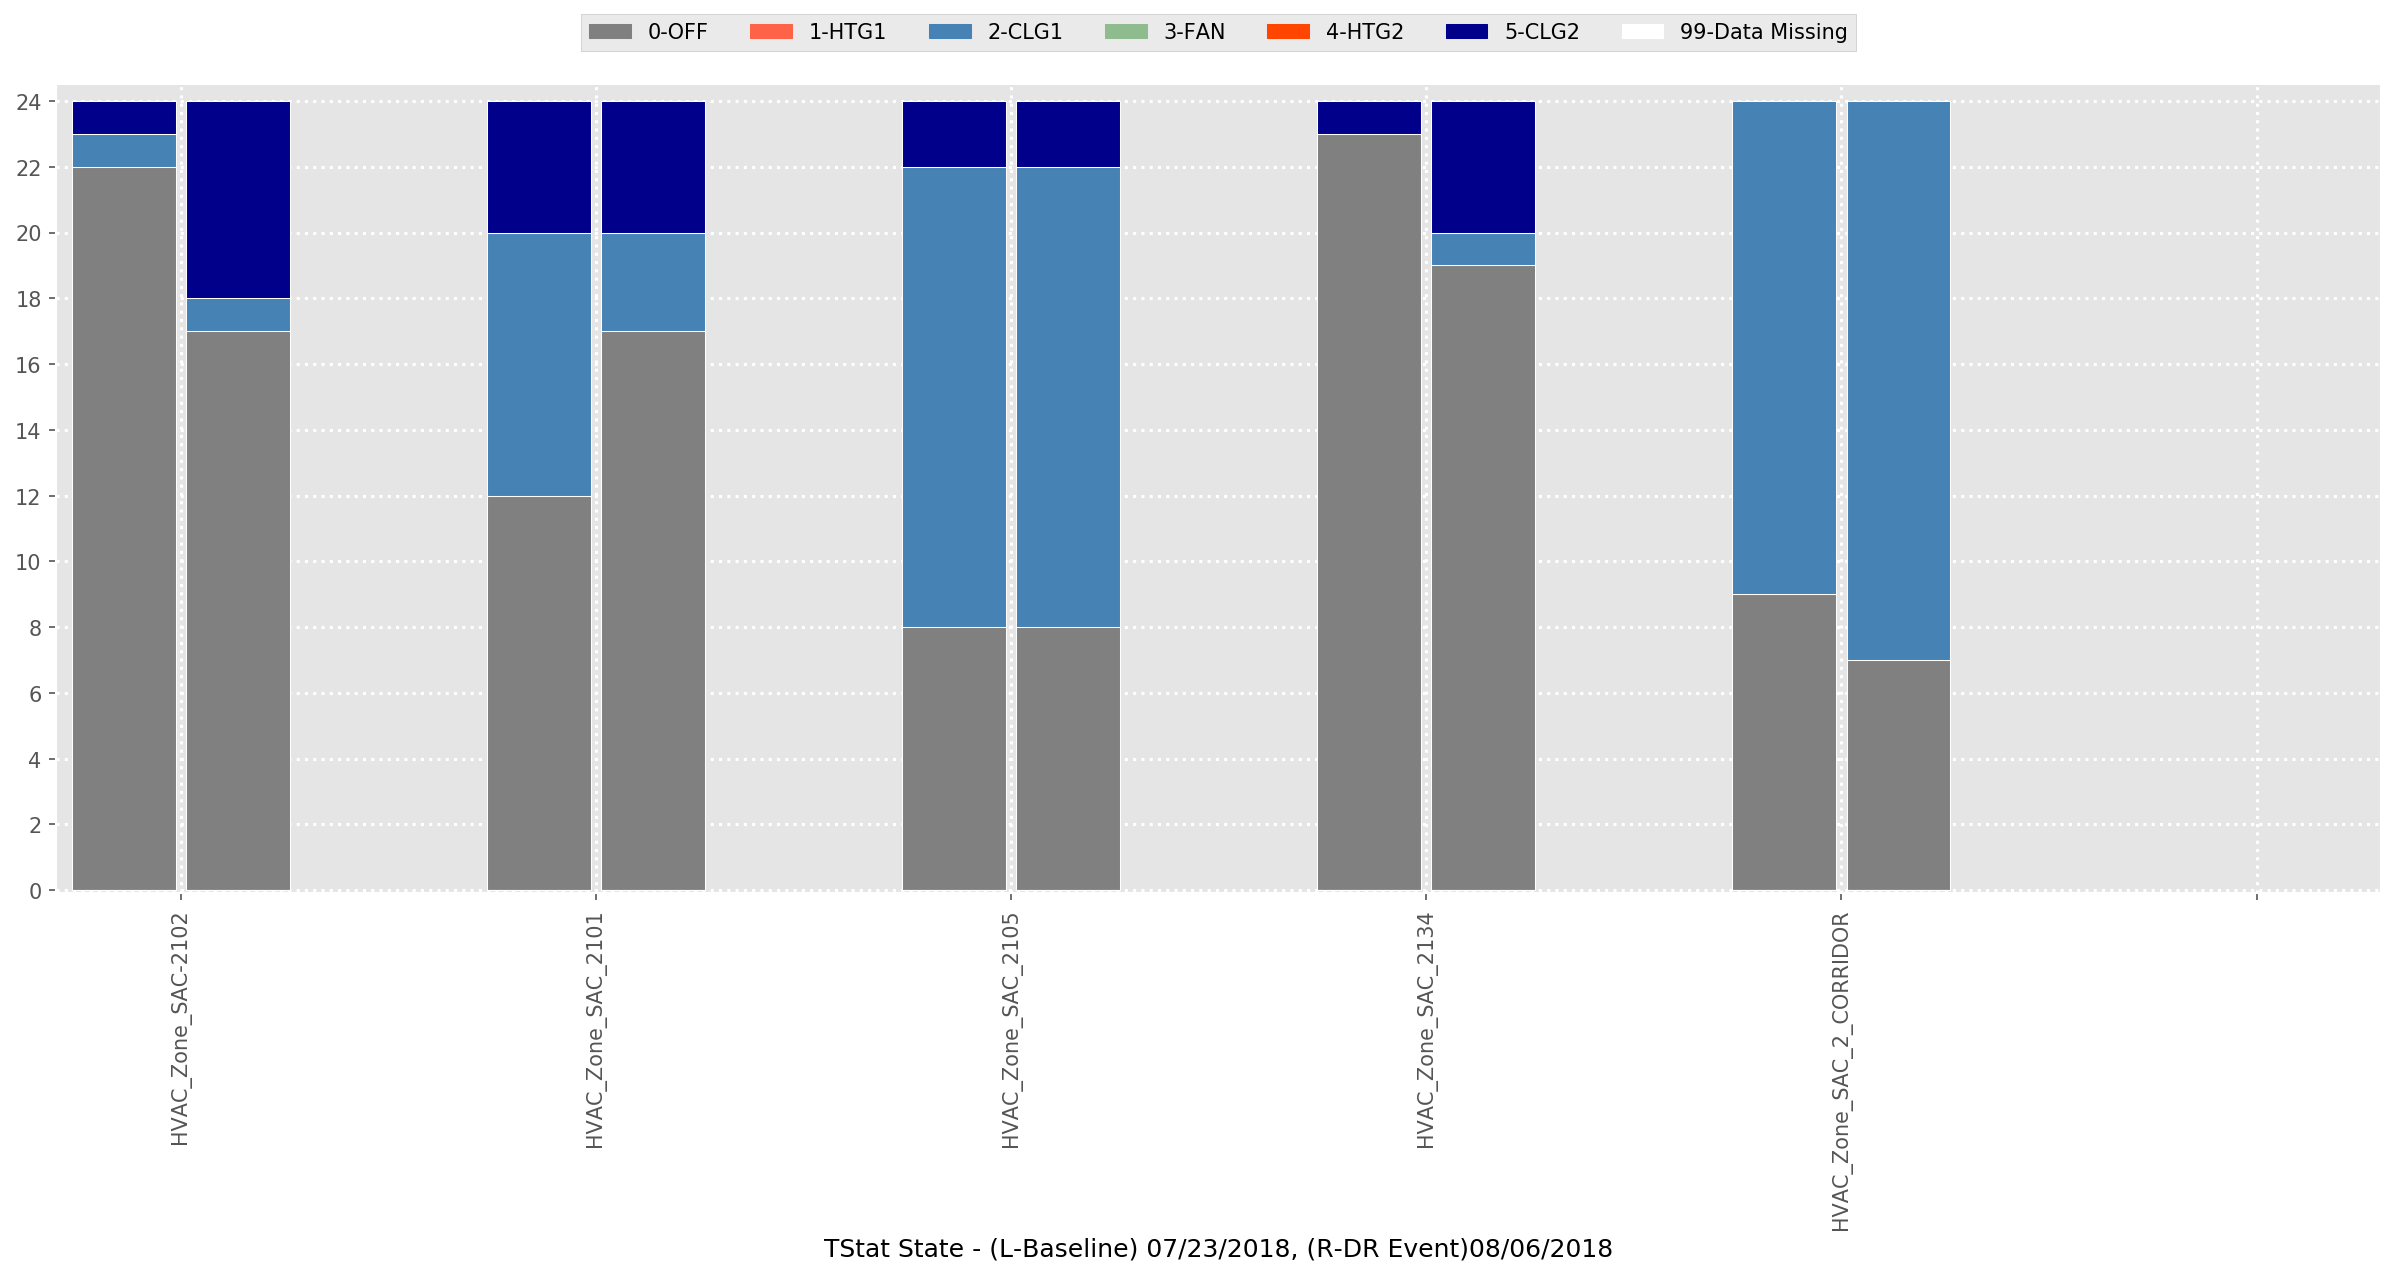

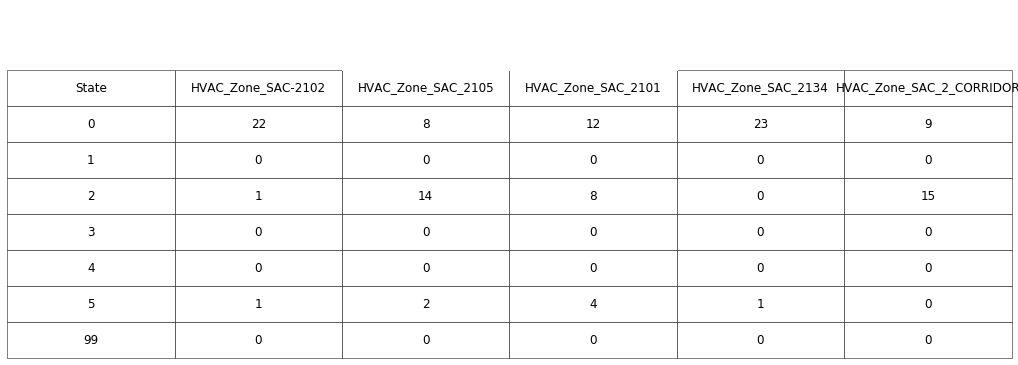

In [12]:
# THIS IS ONE BUILDING (FOR TESTING)
site = "csu-dominguez-hills"
event_day = "08/06/2018"
start = "2018-06-01 00:00:00 PDT"
end = "2018-10-31 00:00:00 PDT"
dr_start = "2018-08-06 00:00:00 PDT"
dr_end = "2018-08-07 00:00:00 PDT"
plot_one_building(site, event_day, start, end, dr_start,dr_end)

## Table includes runtime data for all zones in the building for each the date of the chart above. This should be changed to only the zones shown in the chart above, with zones in columns and results in rows 'Total Runtime', 'Runtime Ratio - DR Event/Baseline', '% Savings', 'Energy', 'Zone EUI', 'Data Quality - % data missing' 

## How to get order of items in stacked chart and order of items in table to all follow a specific list order?


2018-07-06 00:00:00 PDT 2018-07-07 00:00:00 PDT
csu-dominguez-hills 07/06/2018 100.4 2018-08-08 15:00:00-07:00 93.2
2018-07-09 00:00:00 PDT 2018-07-10 00:00:00 PDT
csu-dominguez-hills 07/09/2018 86.45 2018-07-24 13:00:00-07:00 85.1
2018-07-10 00:00:00 PDT 2018-07-11 00:00:00 PDT
csu-dominguez-hills 07/10/2018 86.9 2018-08-10 17:00:00-07:00 87.80000000000001
2018-07-17 00:00:00 PDT 2018-07-18 00:00:00 PDT
csu-dominguez-hills 07/17/2018 76.55 2018-07-03 14:00:00-07:00 76.55
2018-07-18 00:00:00 PDT 2018-07-19 00:00:00 PDT
csu-dominguez-hills 07/18/2018 78.80000000000001 2018-07-16 14:00:00-07:00 78.80000000000001
2018-08-01 00:00:00 PDT 2018-08-02 00:00:00 PDT
csu-dominguez-hills 08/01/2018 80.6 2018-07-05 18:00:00-07:00 80.6
2018-08-02 00:00:00 PDT 2018-08-03 00:00:00 PDT
csu-dominguez-hills 08/02/2018 80.6 2018-07-05 18:00:00-07:00 80.6
2018-08-06 00:00:00 PDT 2018-08-07 00:00:00 PDT
csu-dominguez-hills 08/06/2018 84.2 2018-07-23 12:00:00-07:00 84.2
2018-08-07 00:00:00 PDT 2018-08-08 00

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2018-10-18 00:00:00 PDT 2018-10-19 00:00:00 PDT
csu-dominguez-hills 10/18/2018 82.4 2018-10-16 16:00:00-07:00 82.4
2018-07-06 00:00:00 PDT 2018-07-07 00:00:00 PDT
jesse-turner-center 07/06/2018 94.75070000000005 2018-08-08 12:00:00-07:00 92.25005000000004
2018-07-09 00:00:00 PDT 2018-07-10 00:00:00 PDT
jesse-turner-center 07/09/2018 84.99920000000003 2018-07-24 12:00:00-07:00 84.99920000000003
2018-07-10 00:00:00 PDT 2018-07-11 00:00:00 PDT
jesse-turner-center 07/10/2018 79.50021800000007 2018-07-26 15:00:00-07:00 79.75042700000007
2018-07-17 00:00:00 PDT 2018-07-18 00:00:00 PDT
jesse-turner-center 07/17/2018 76.50005 2018-06-14 15:00:00-07:00 76.50004791259768
2018-07-18 00:00:00 PDT 2018-07-19 00:00:00 PDT
jesse-turner-center 07/18/2018 80.00063600000007 2018-08-15 14:00:00-07:00 80.00063600000007
2018-08-01 00:00:00 PDT 2018-08-02 00:00:00 PDT
jesse-turner-center 08/01/2018 80.99960000000007 2018-08-03 16:00:00-07:00 80.99960000000007
2018-08-02 00:00:00 PDT 2018-08-03 00:00:00 PDT


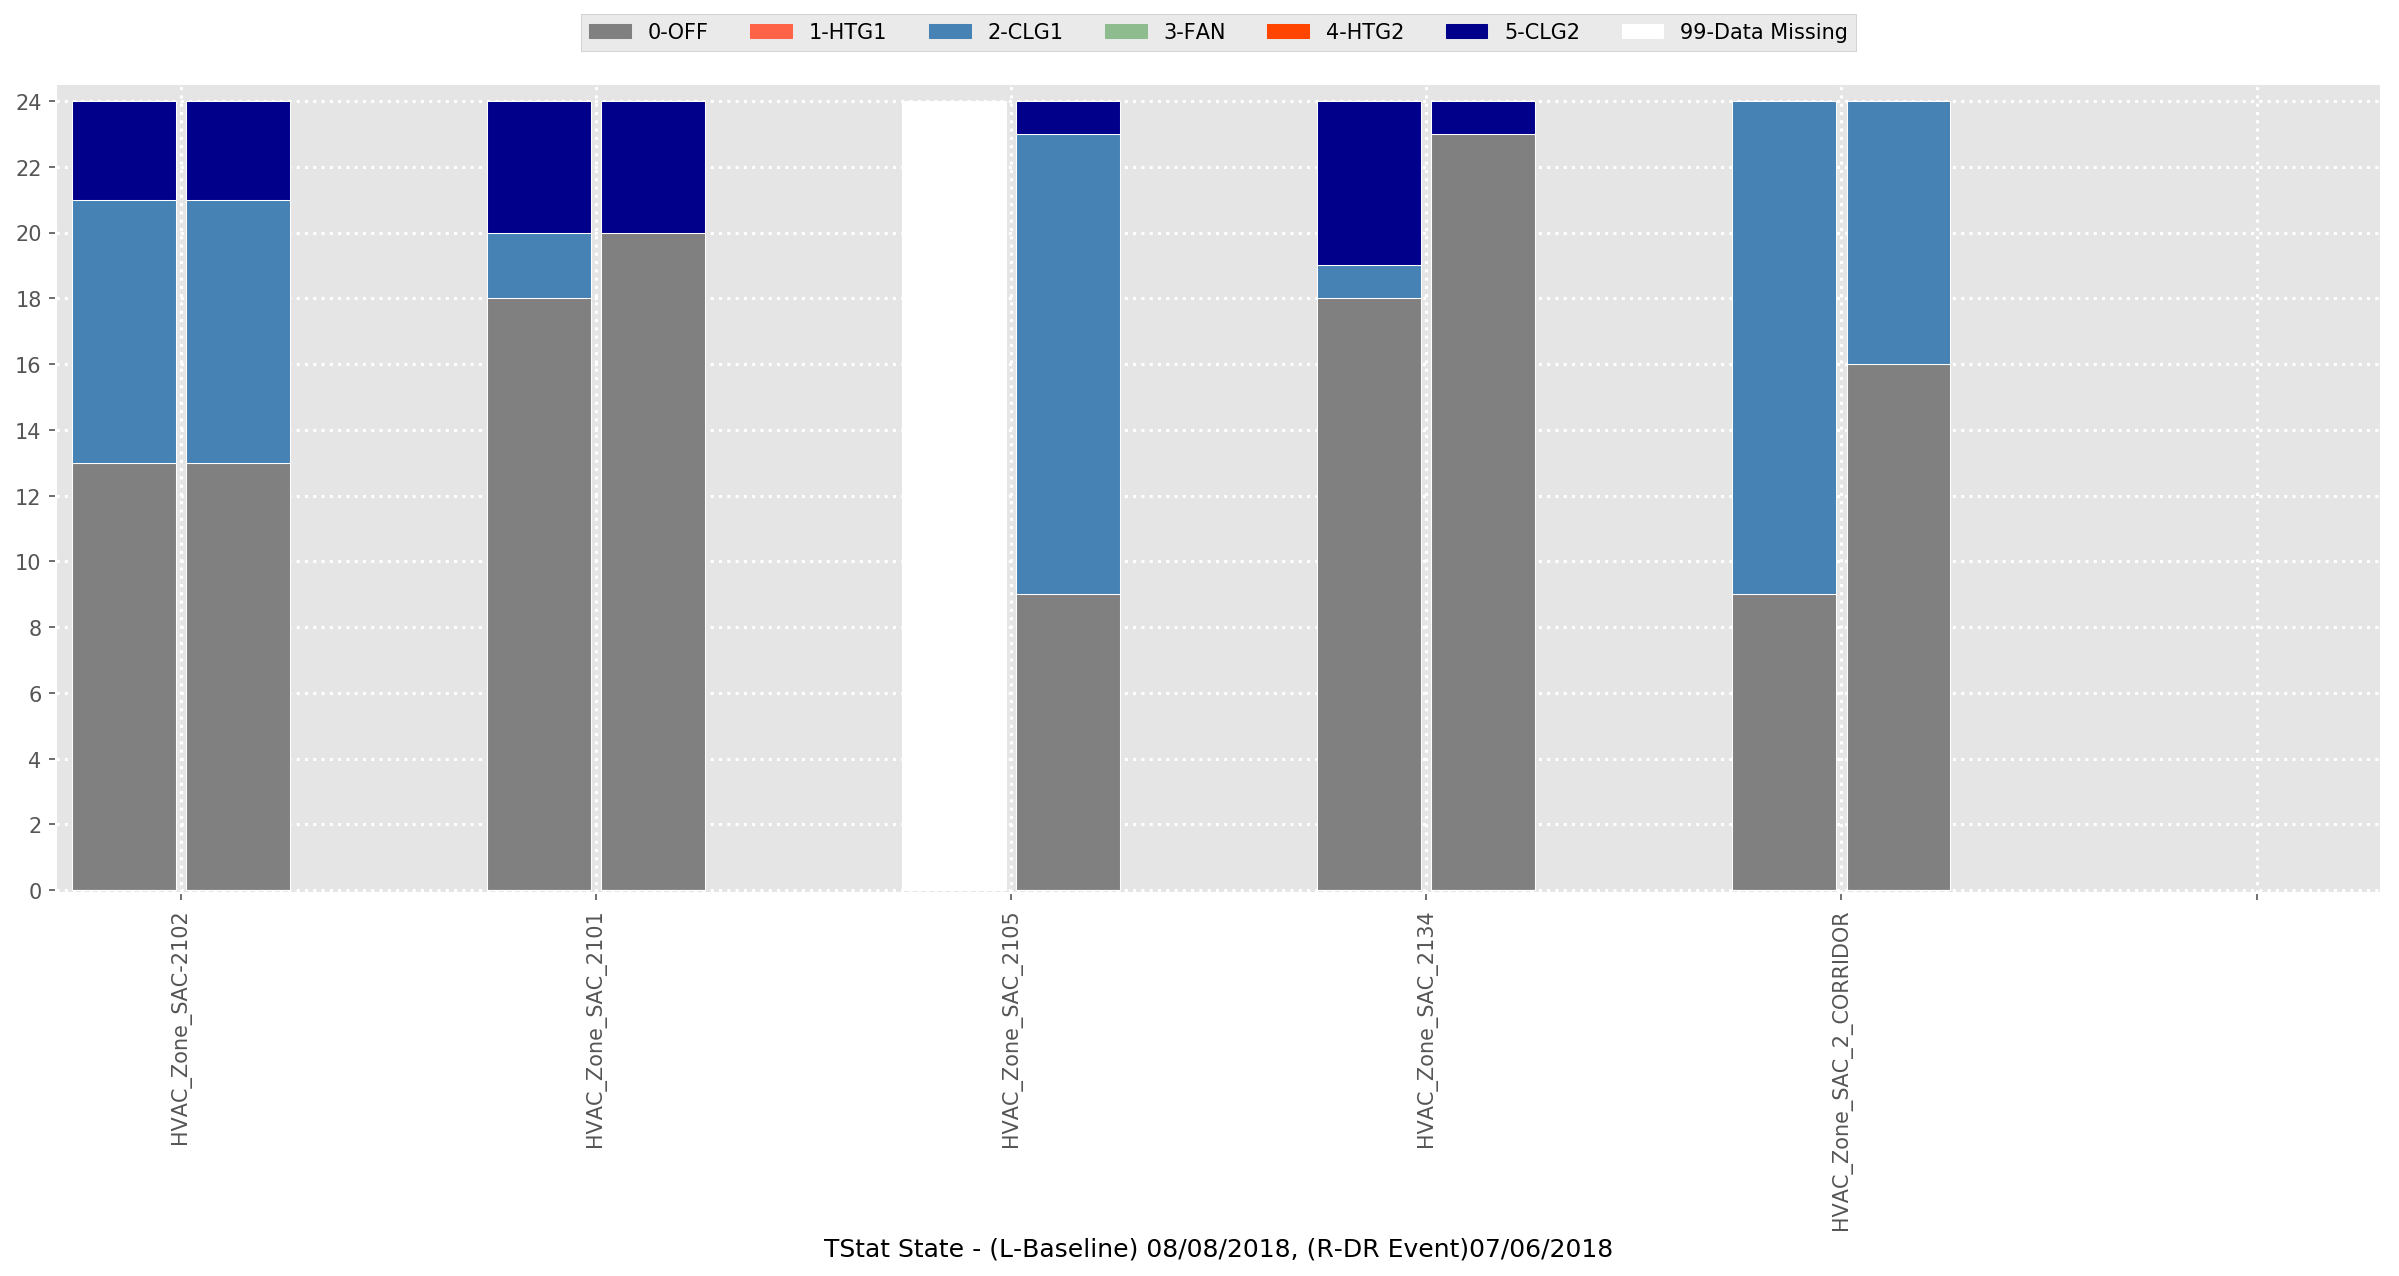

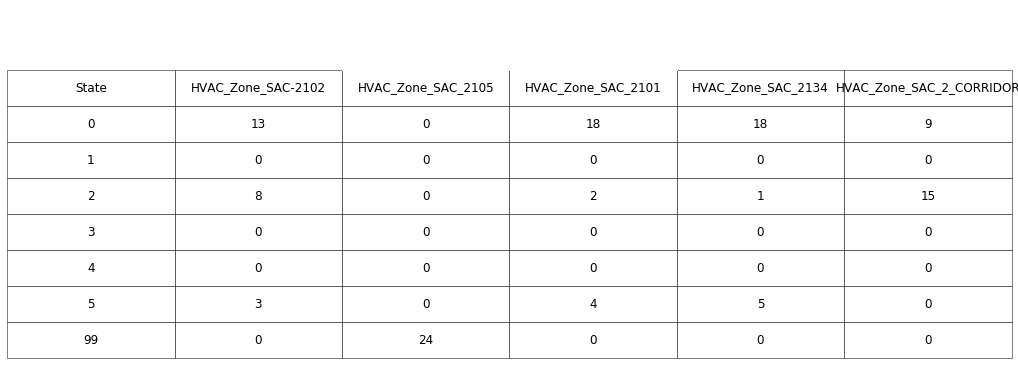

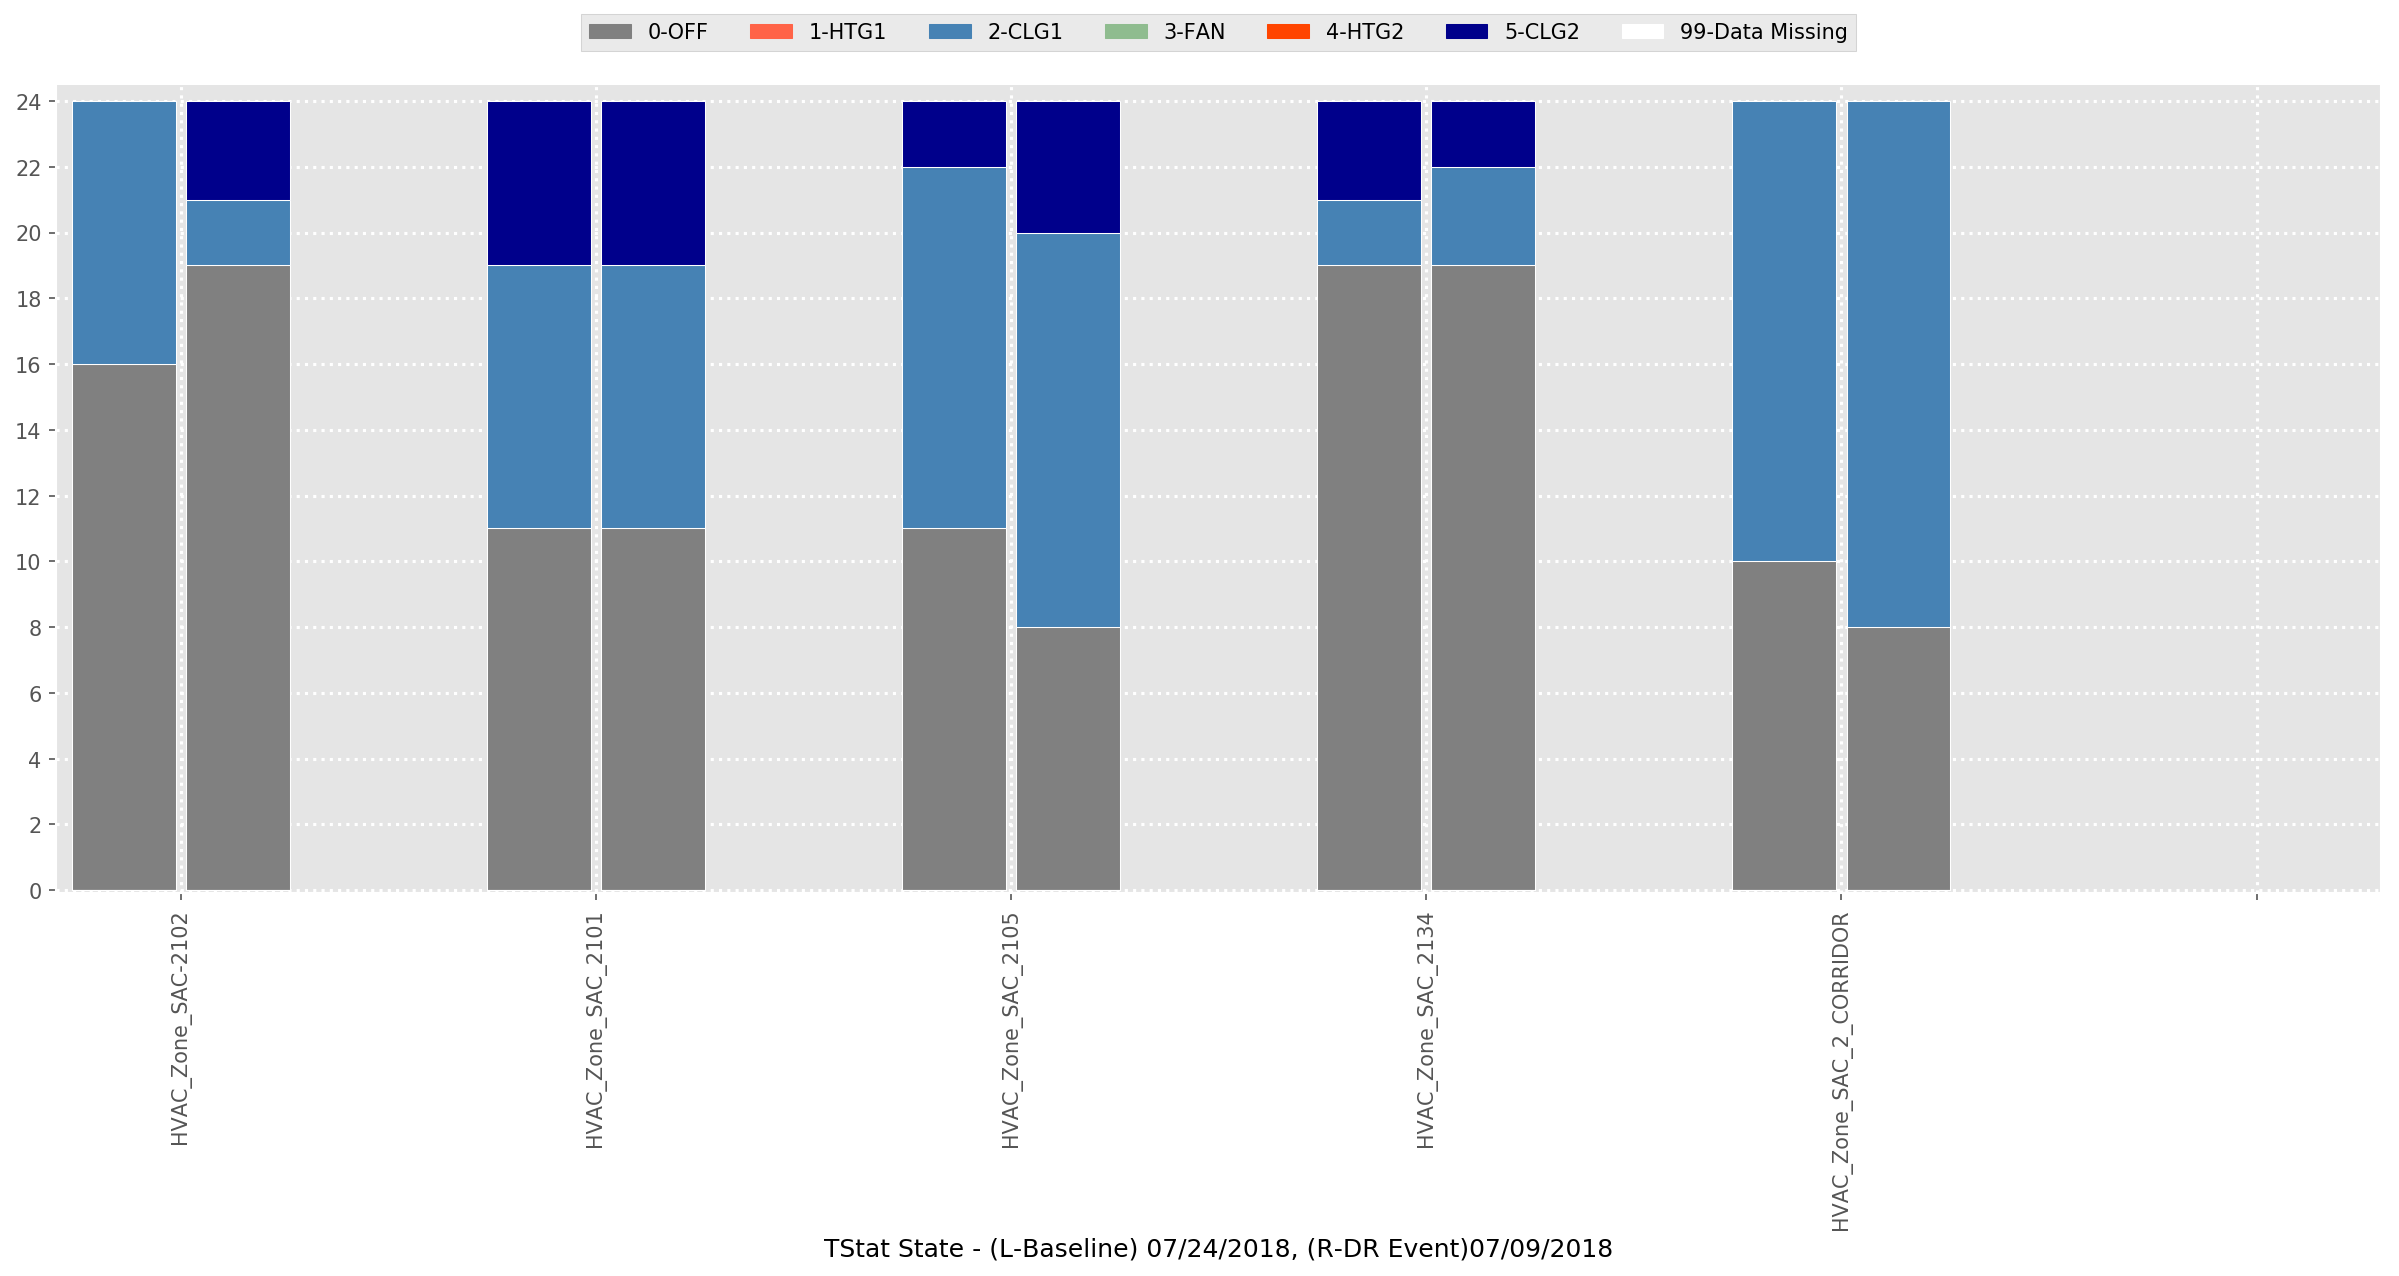

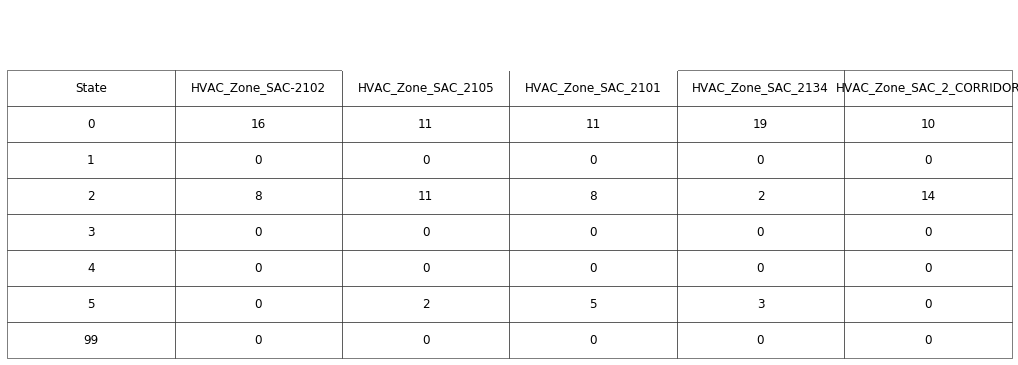

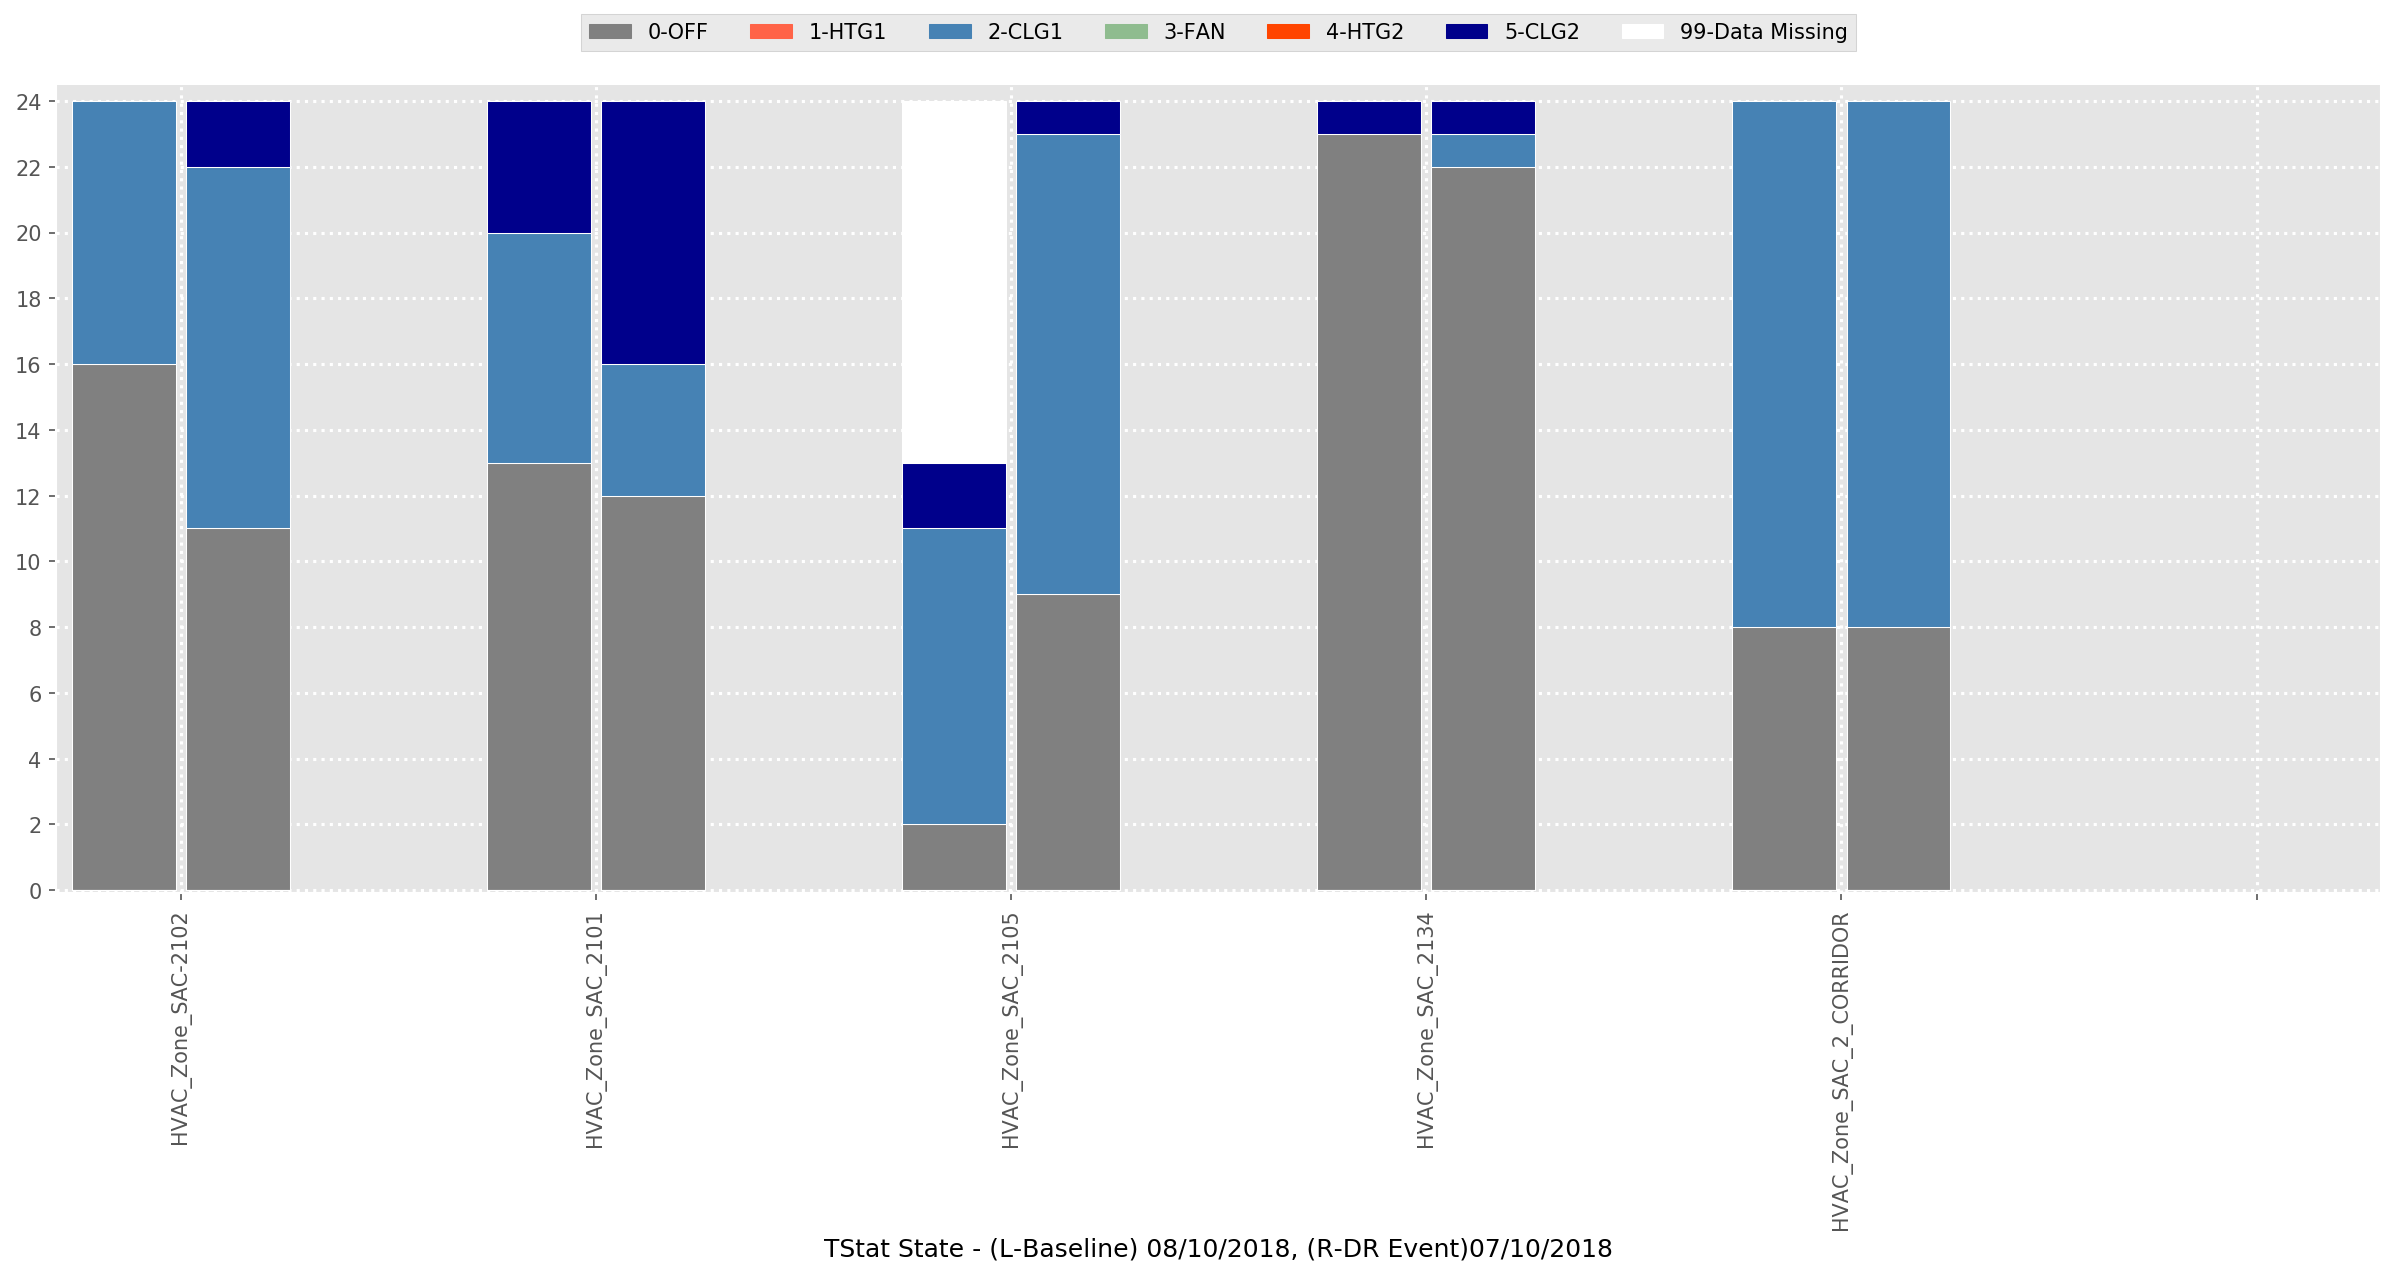

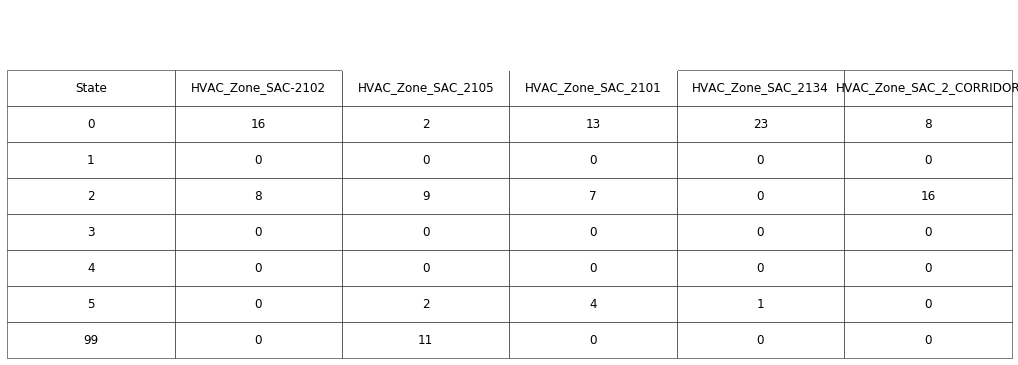

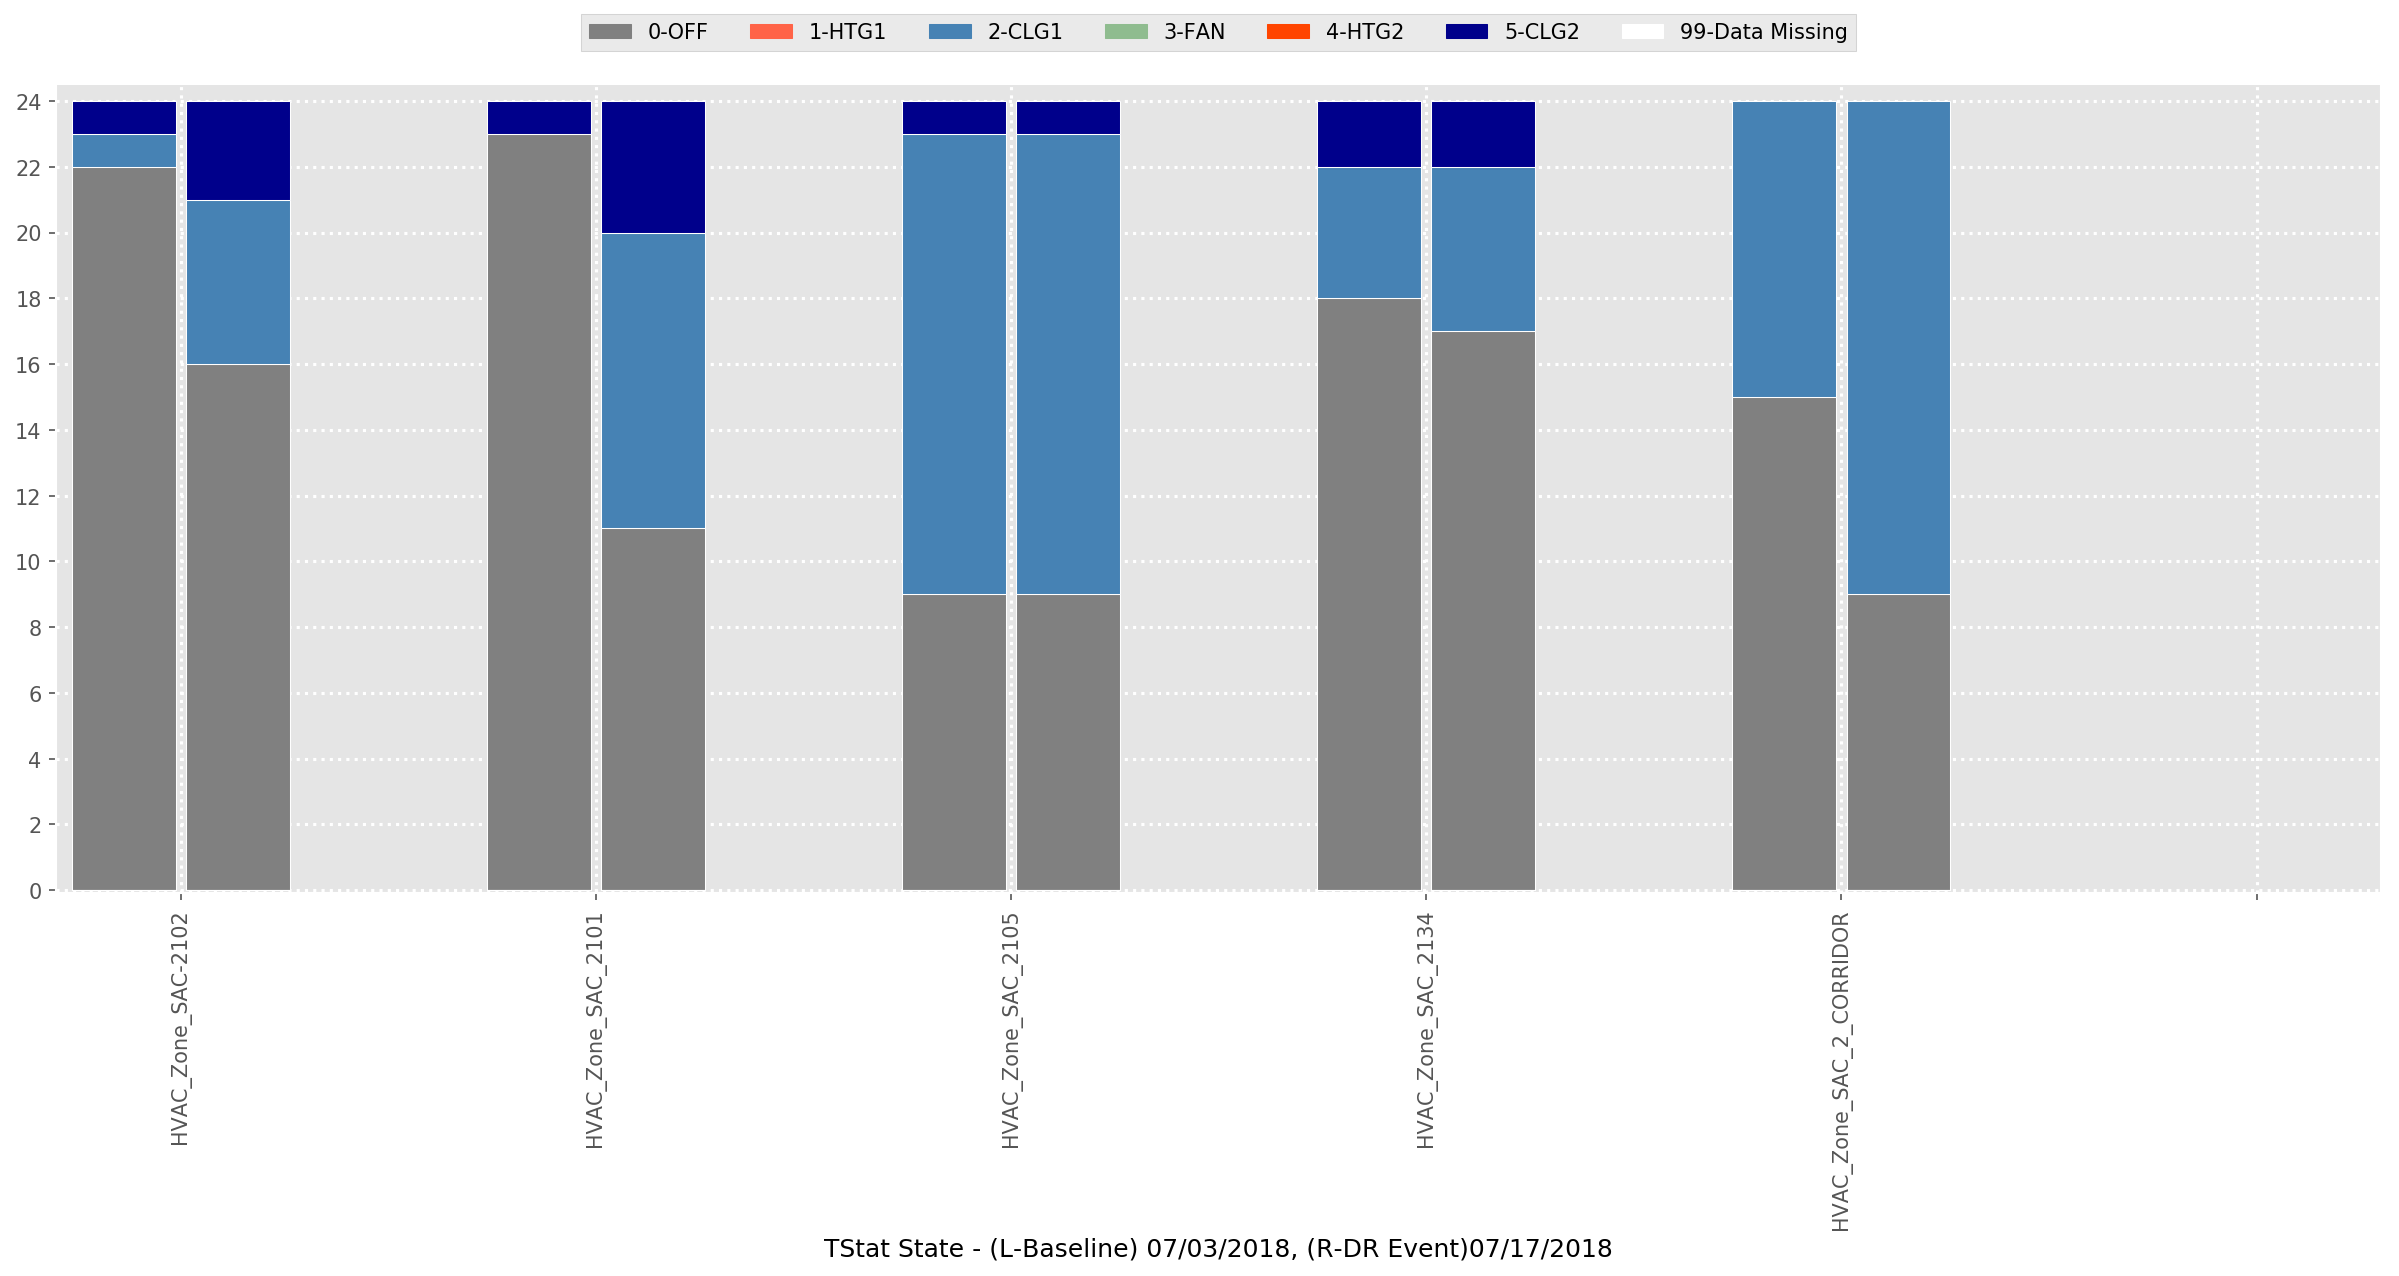

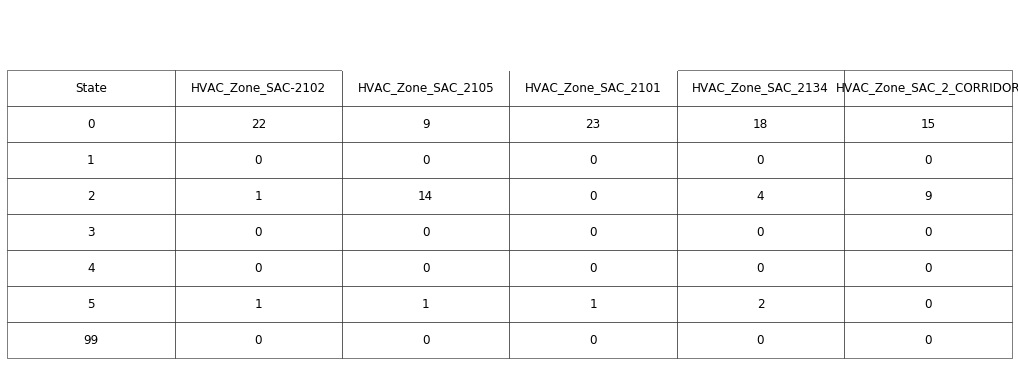

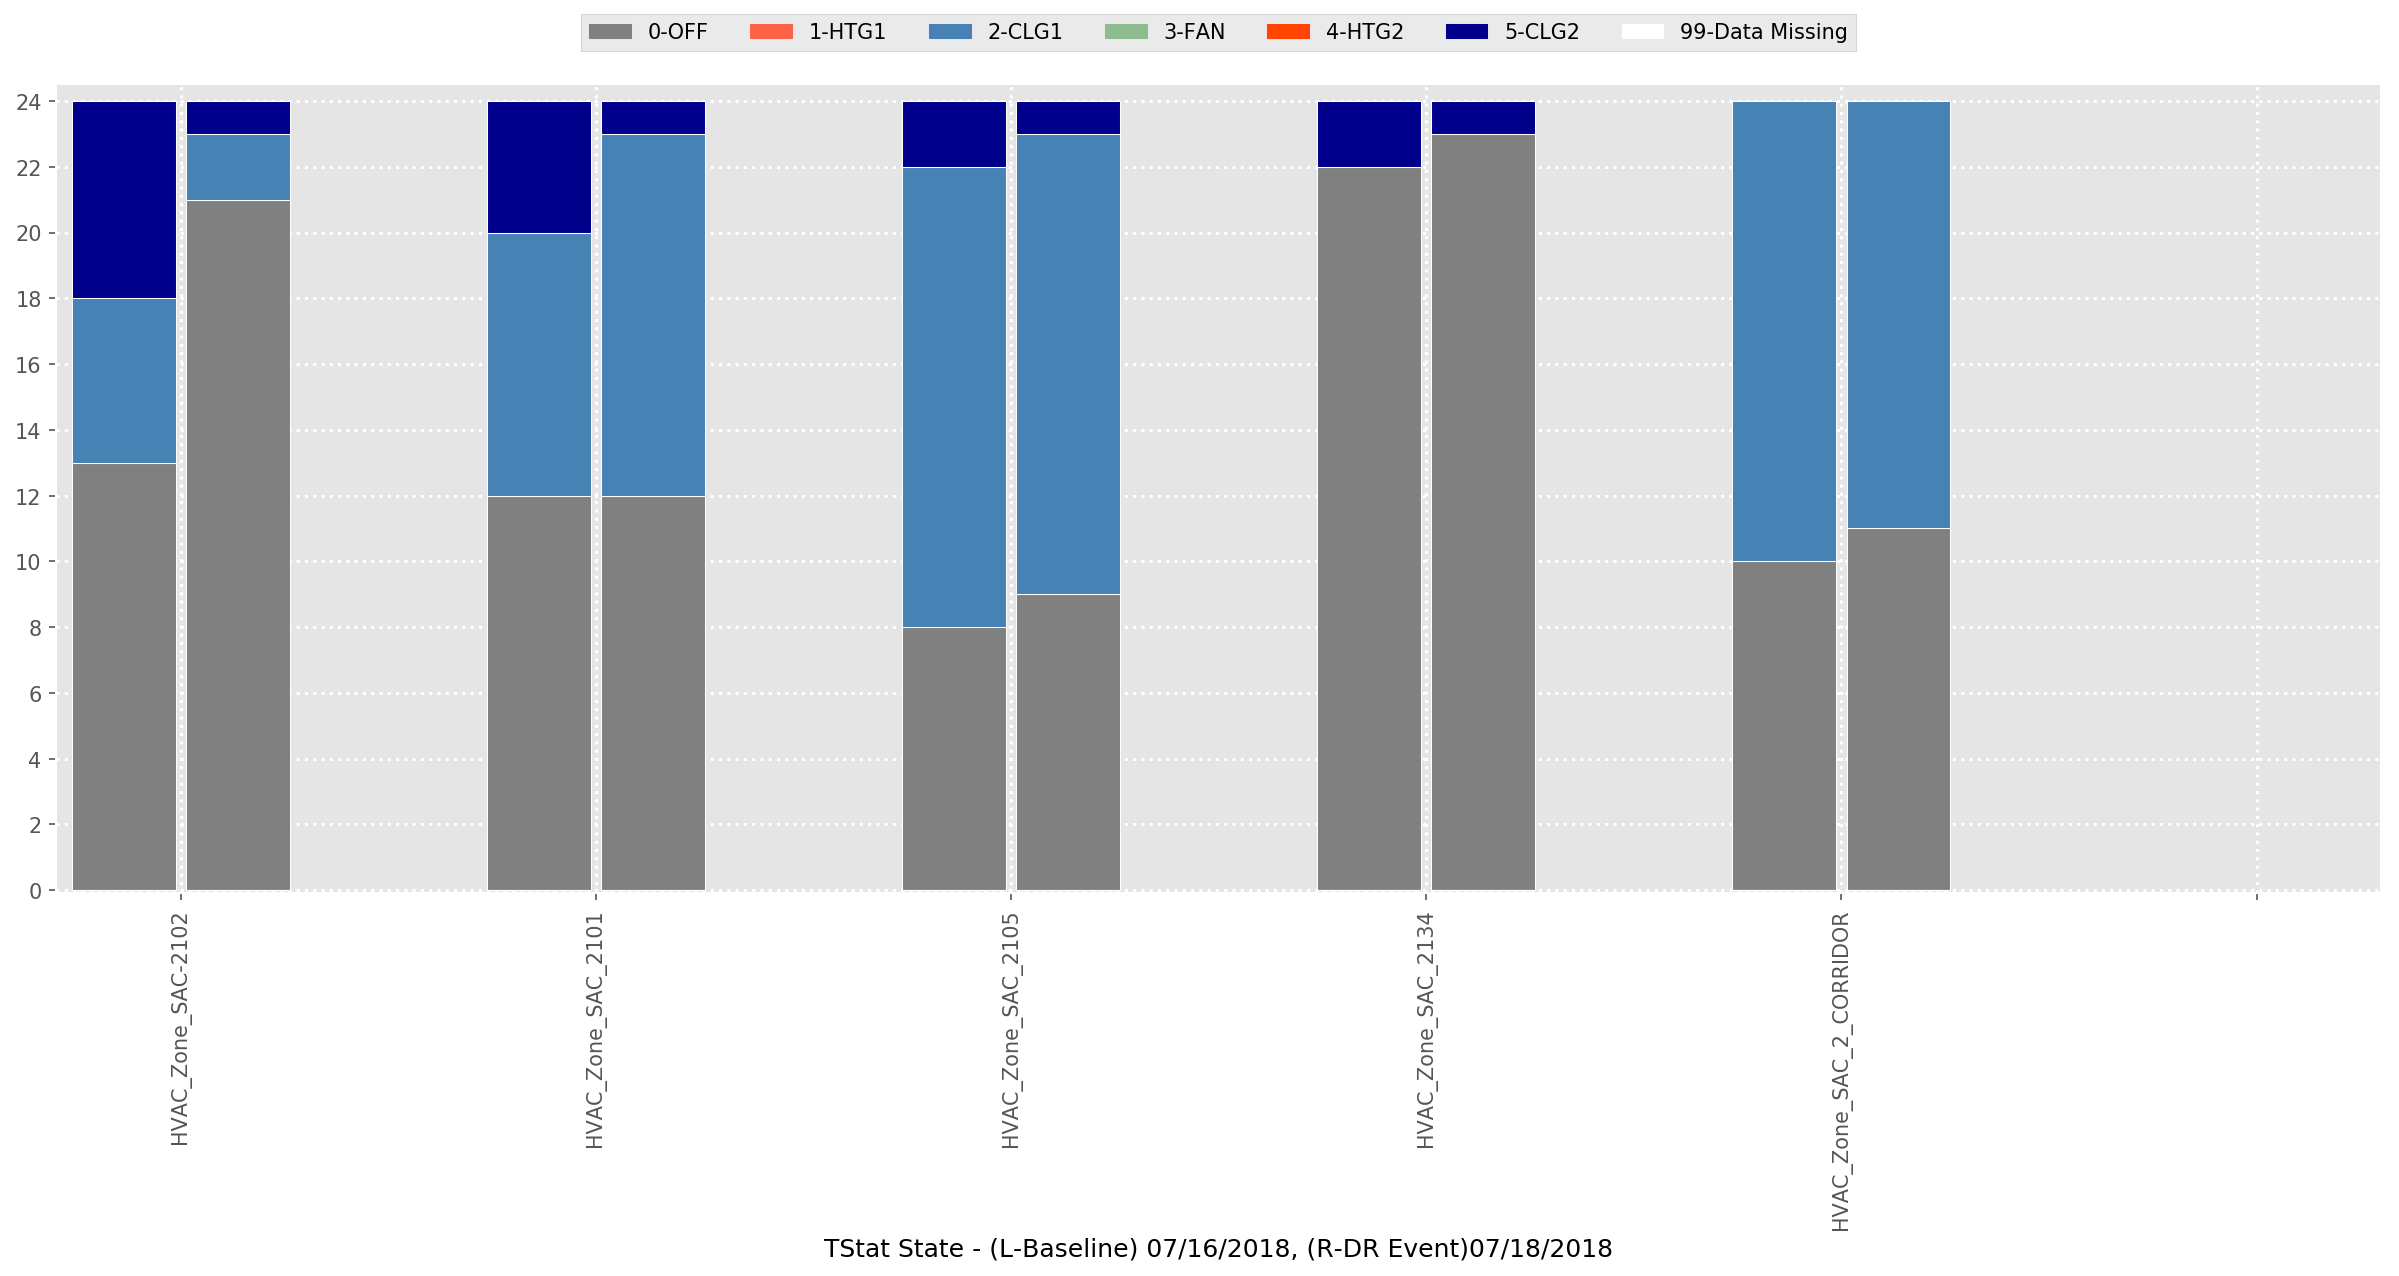

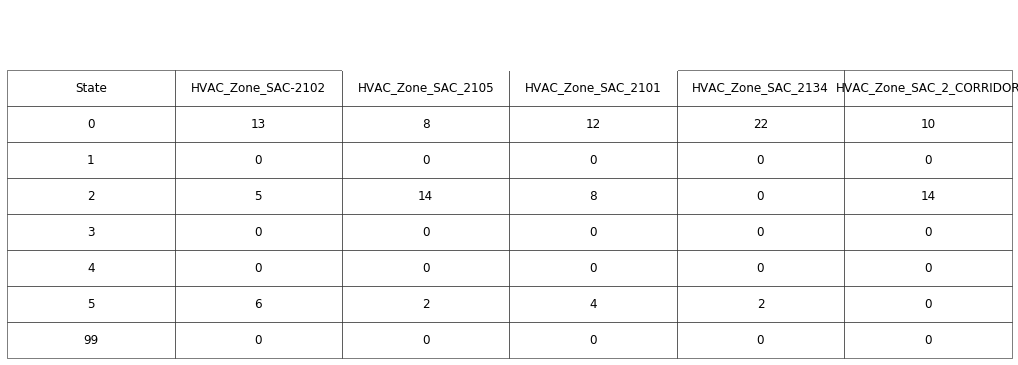

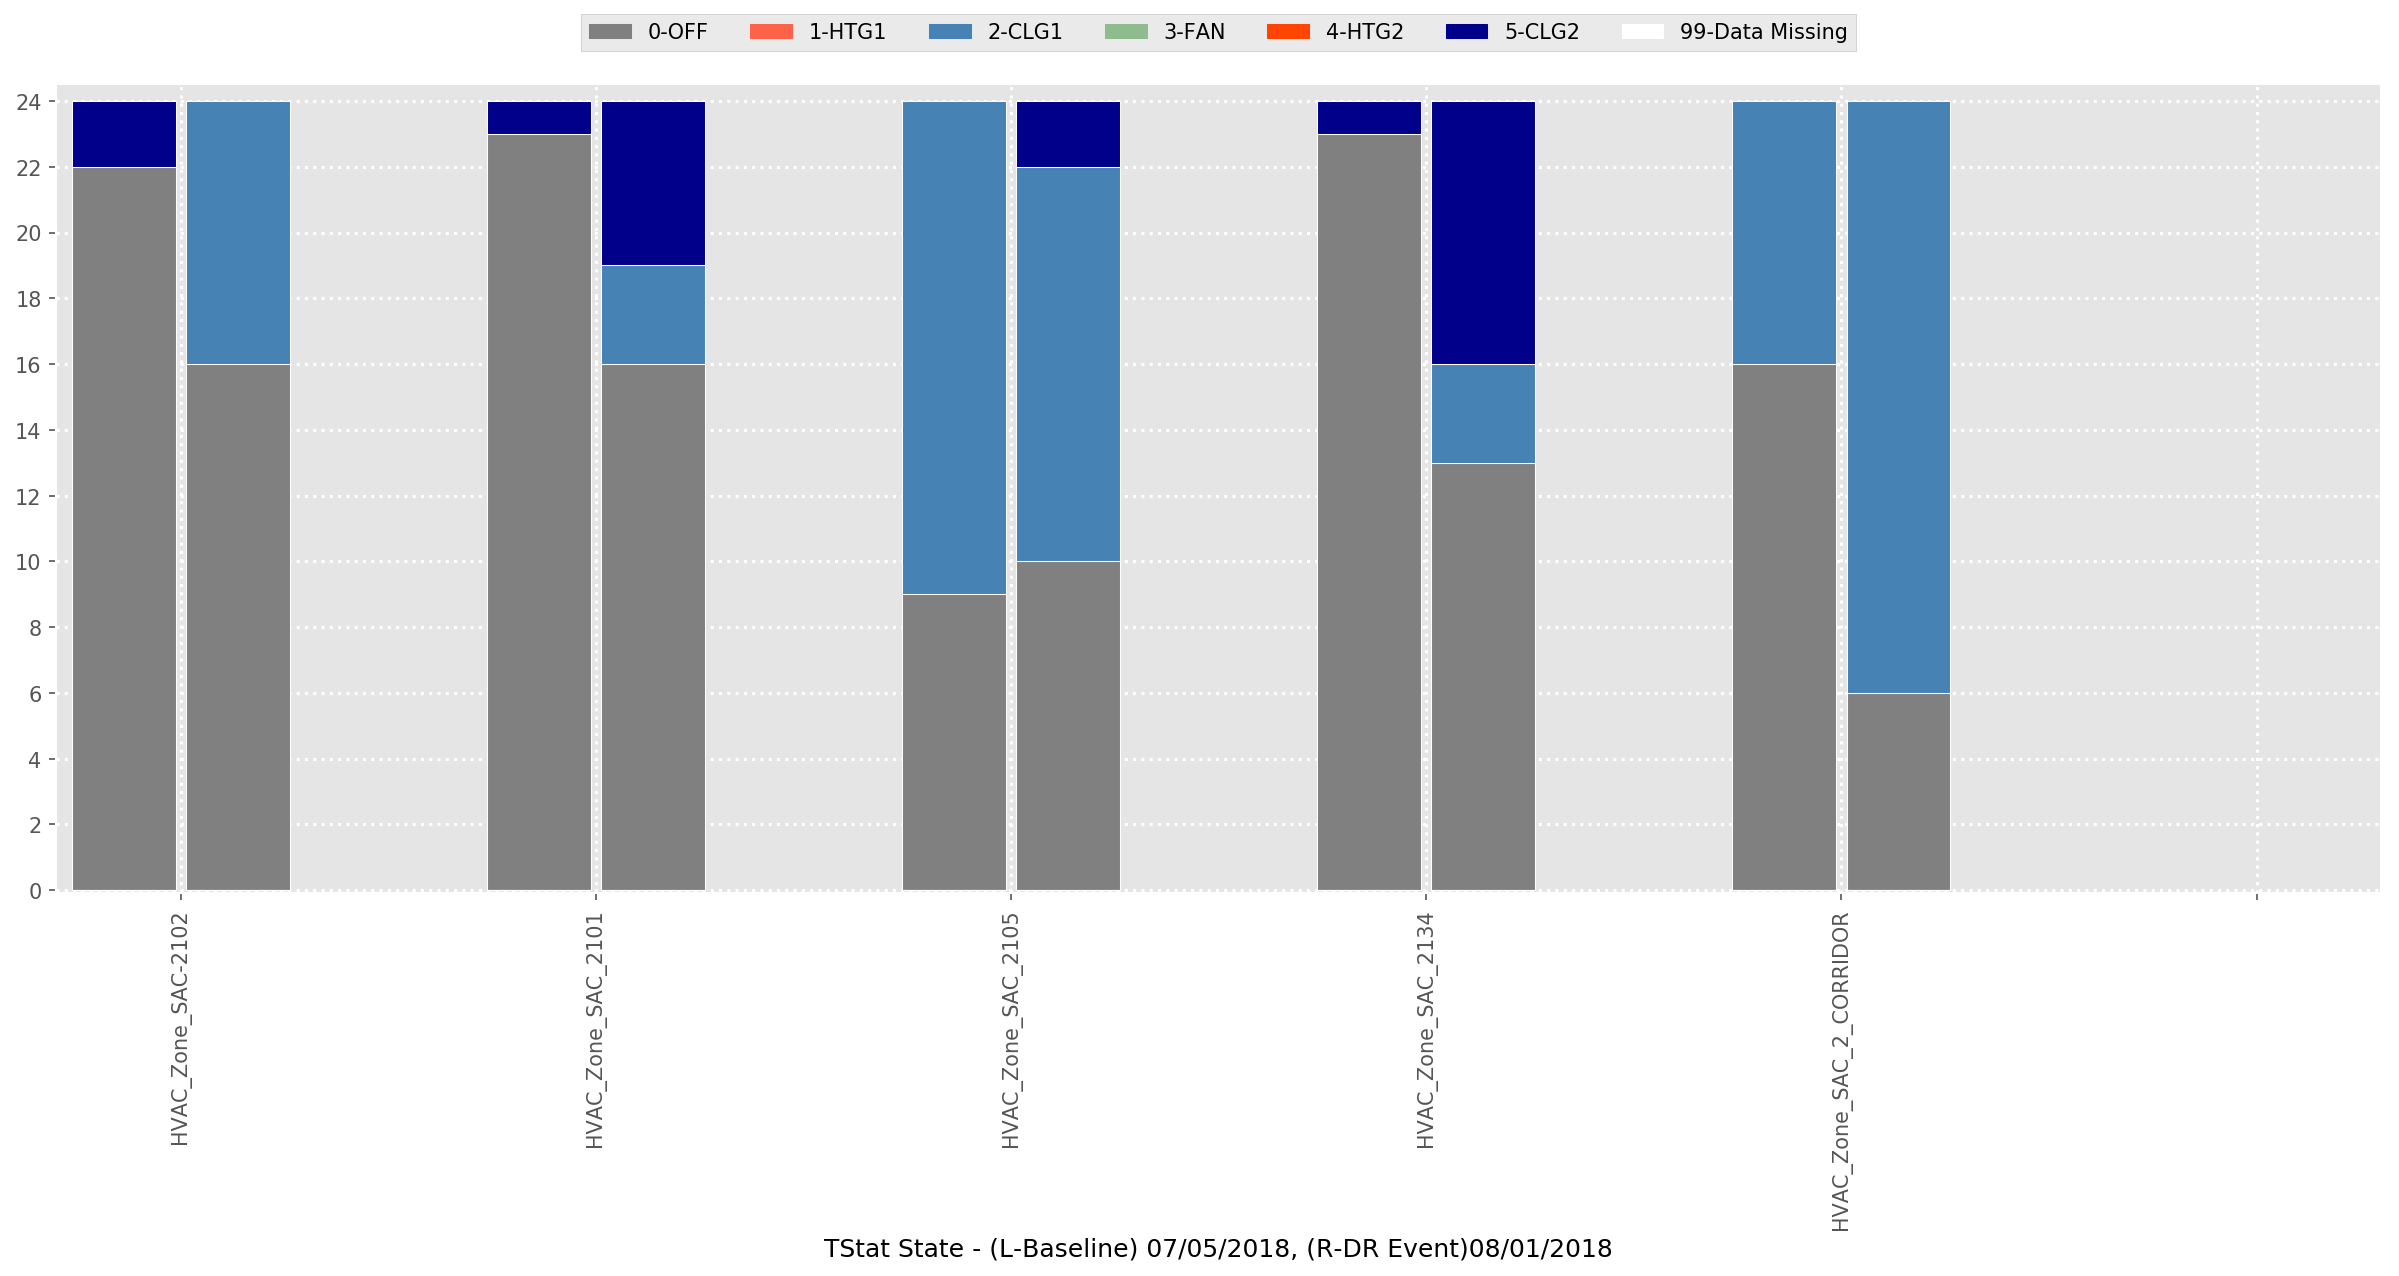

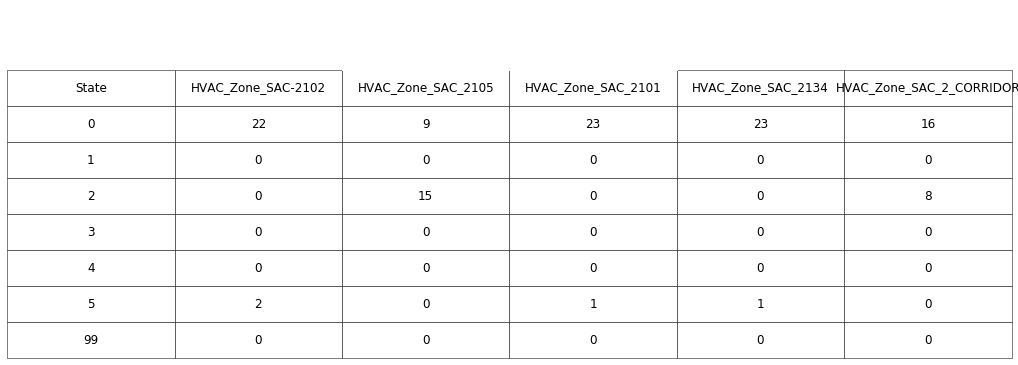

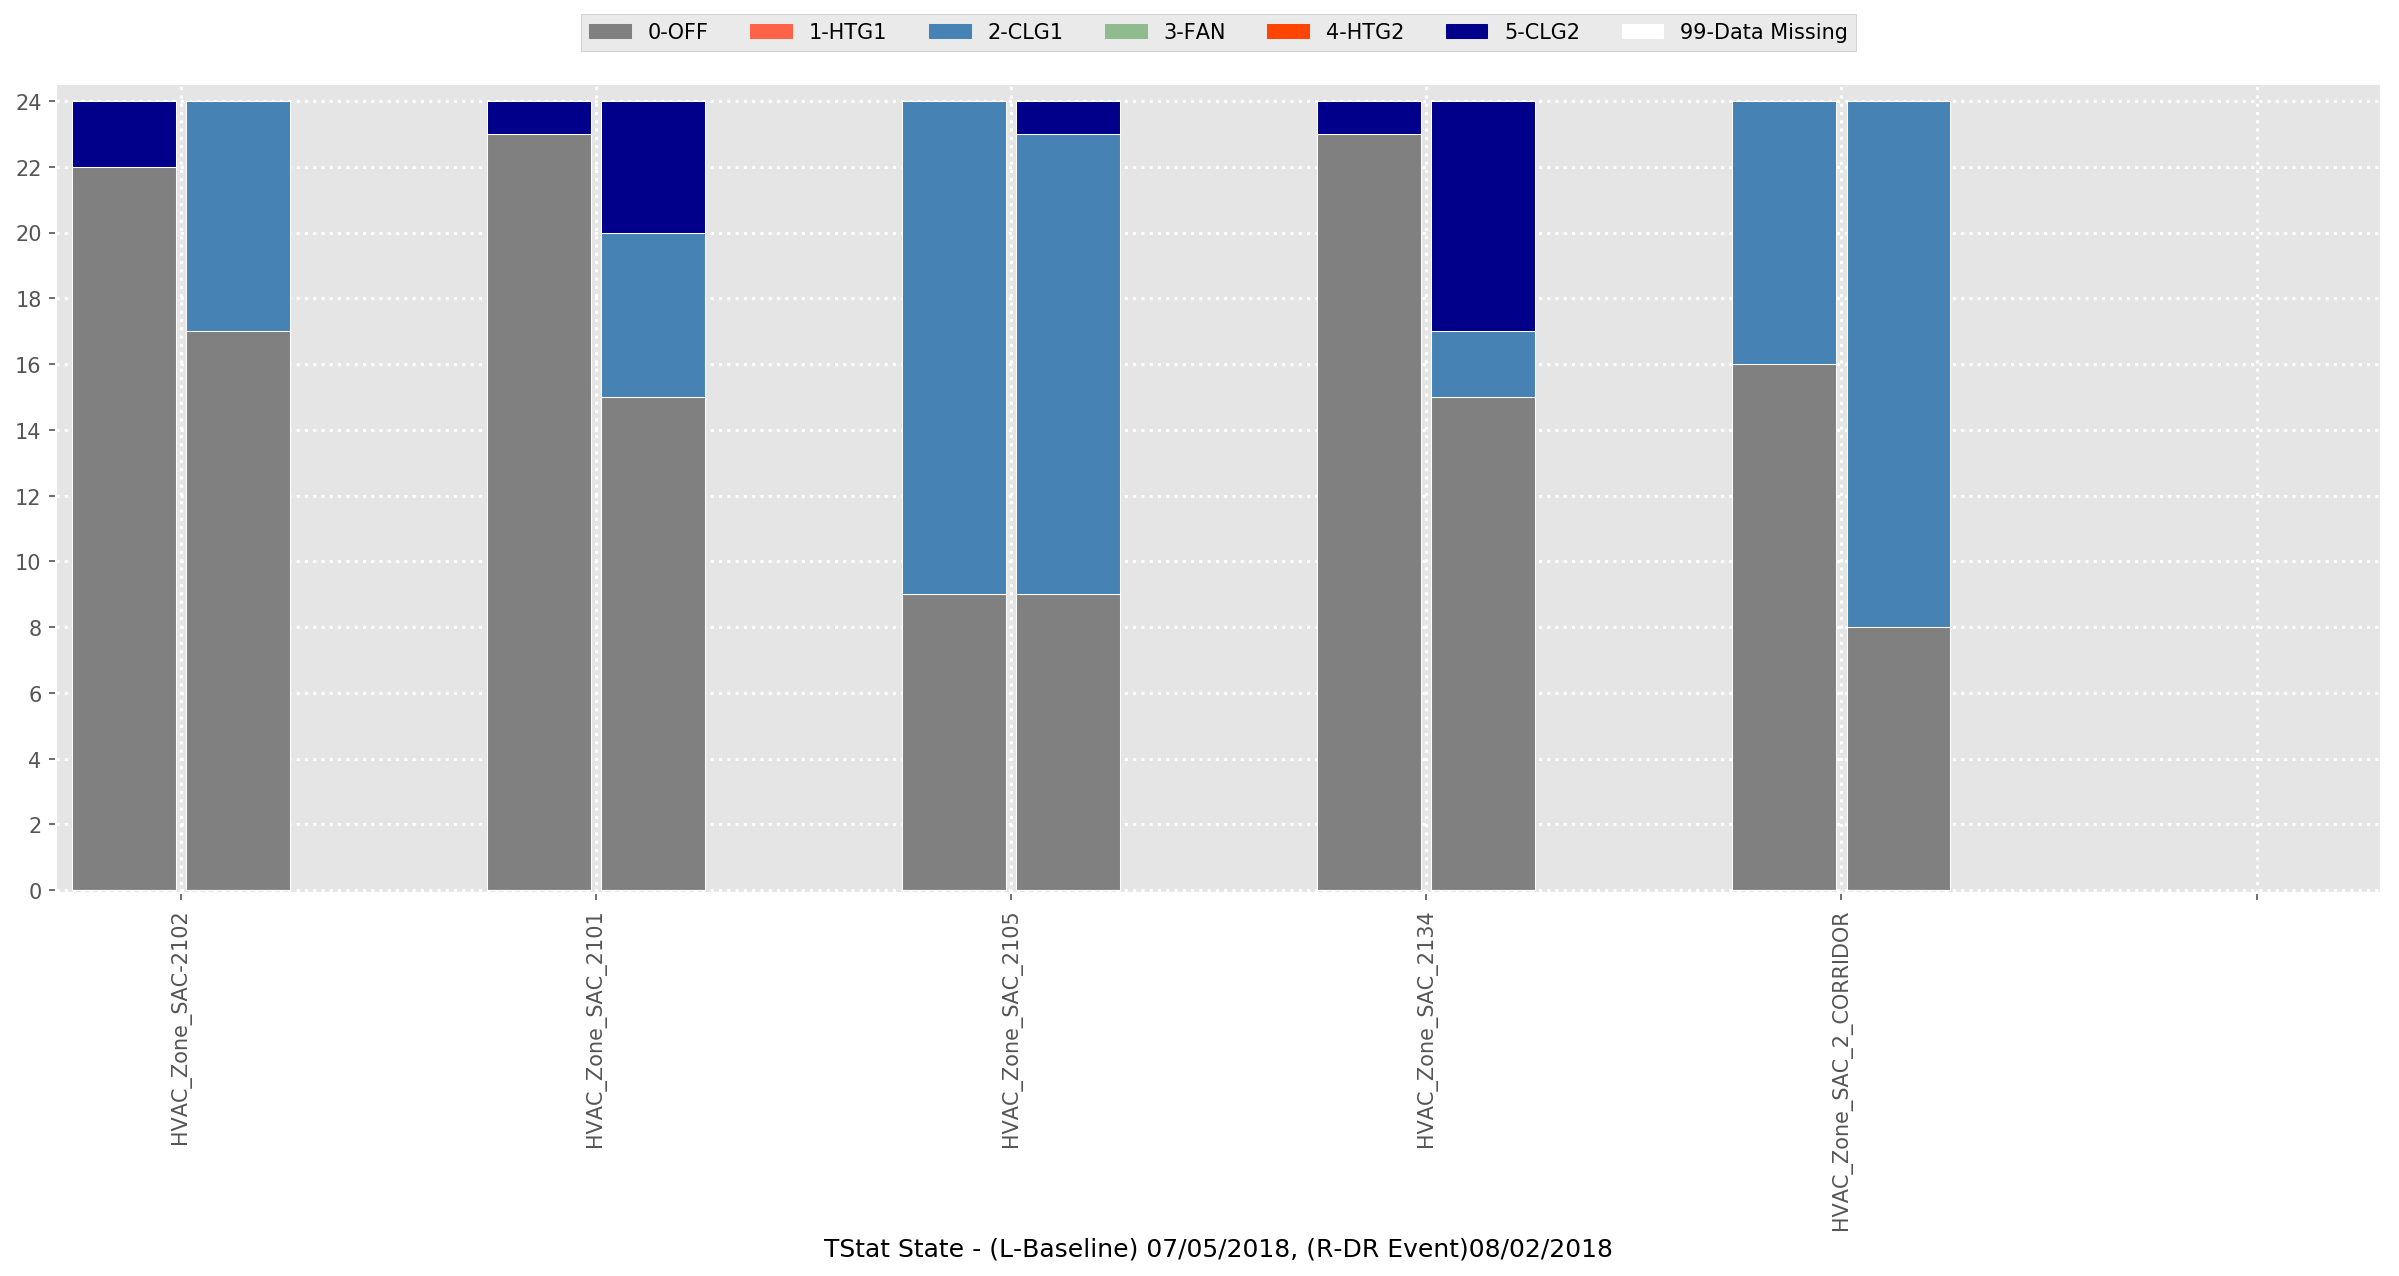

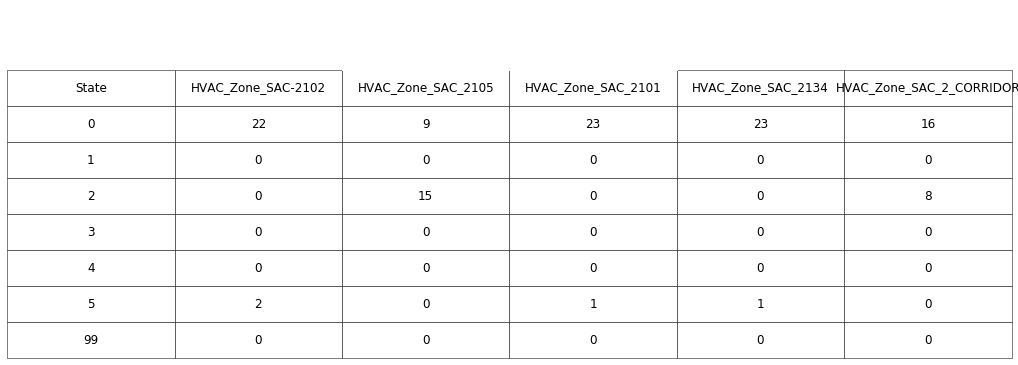

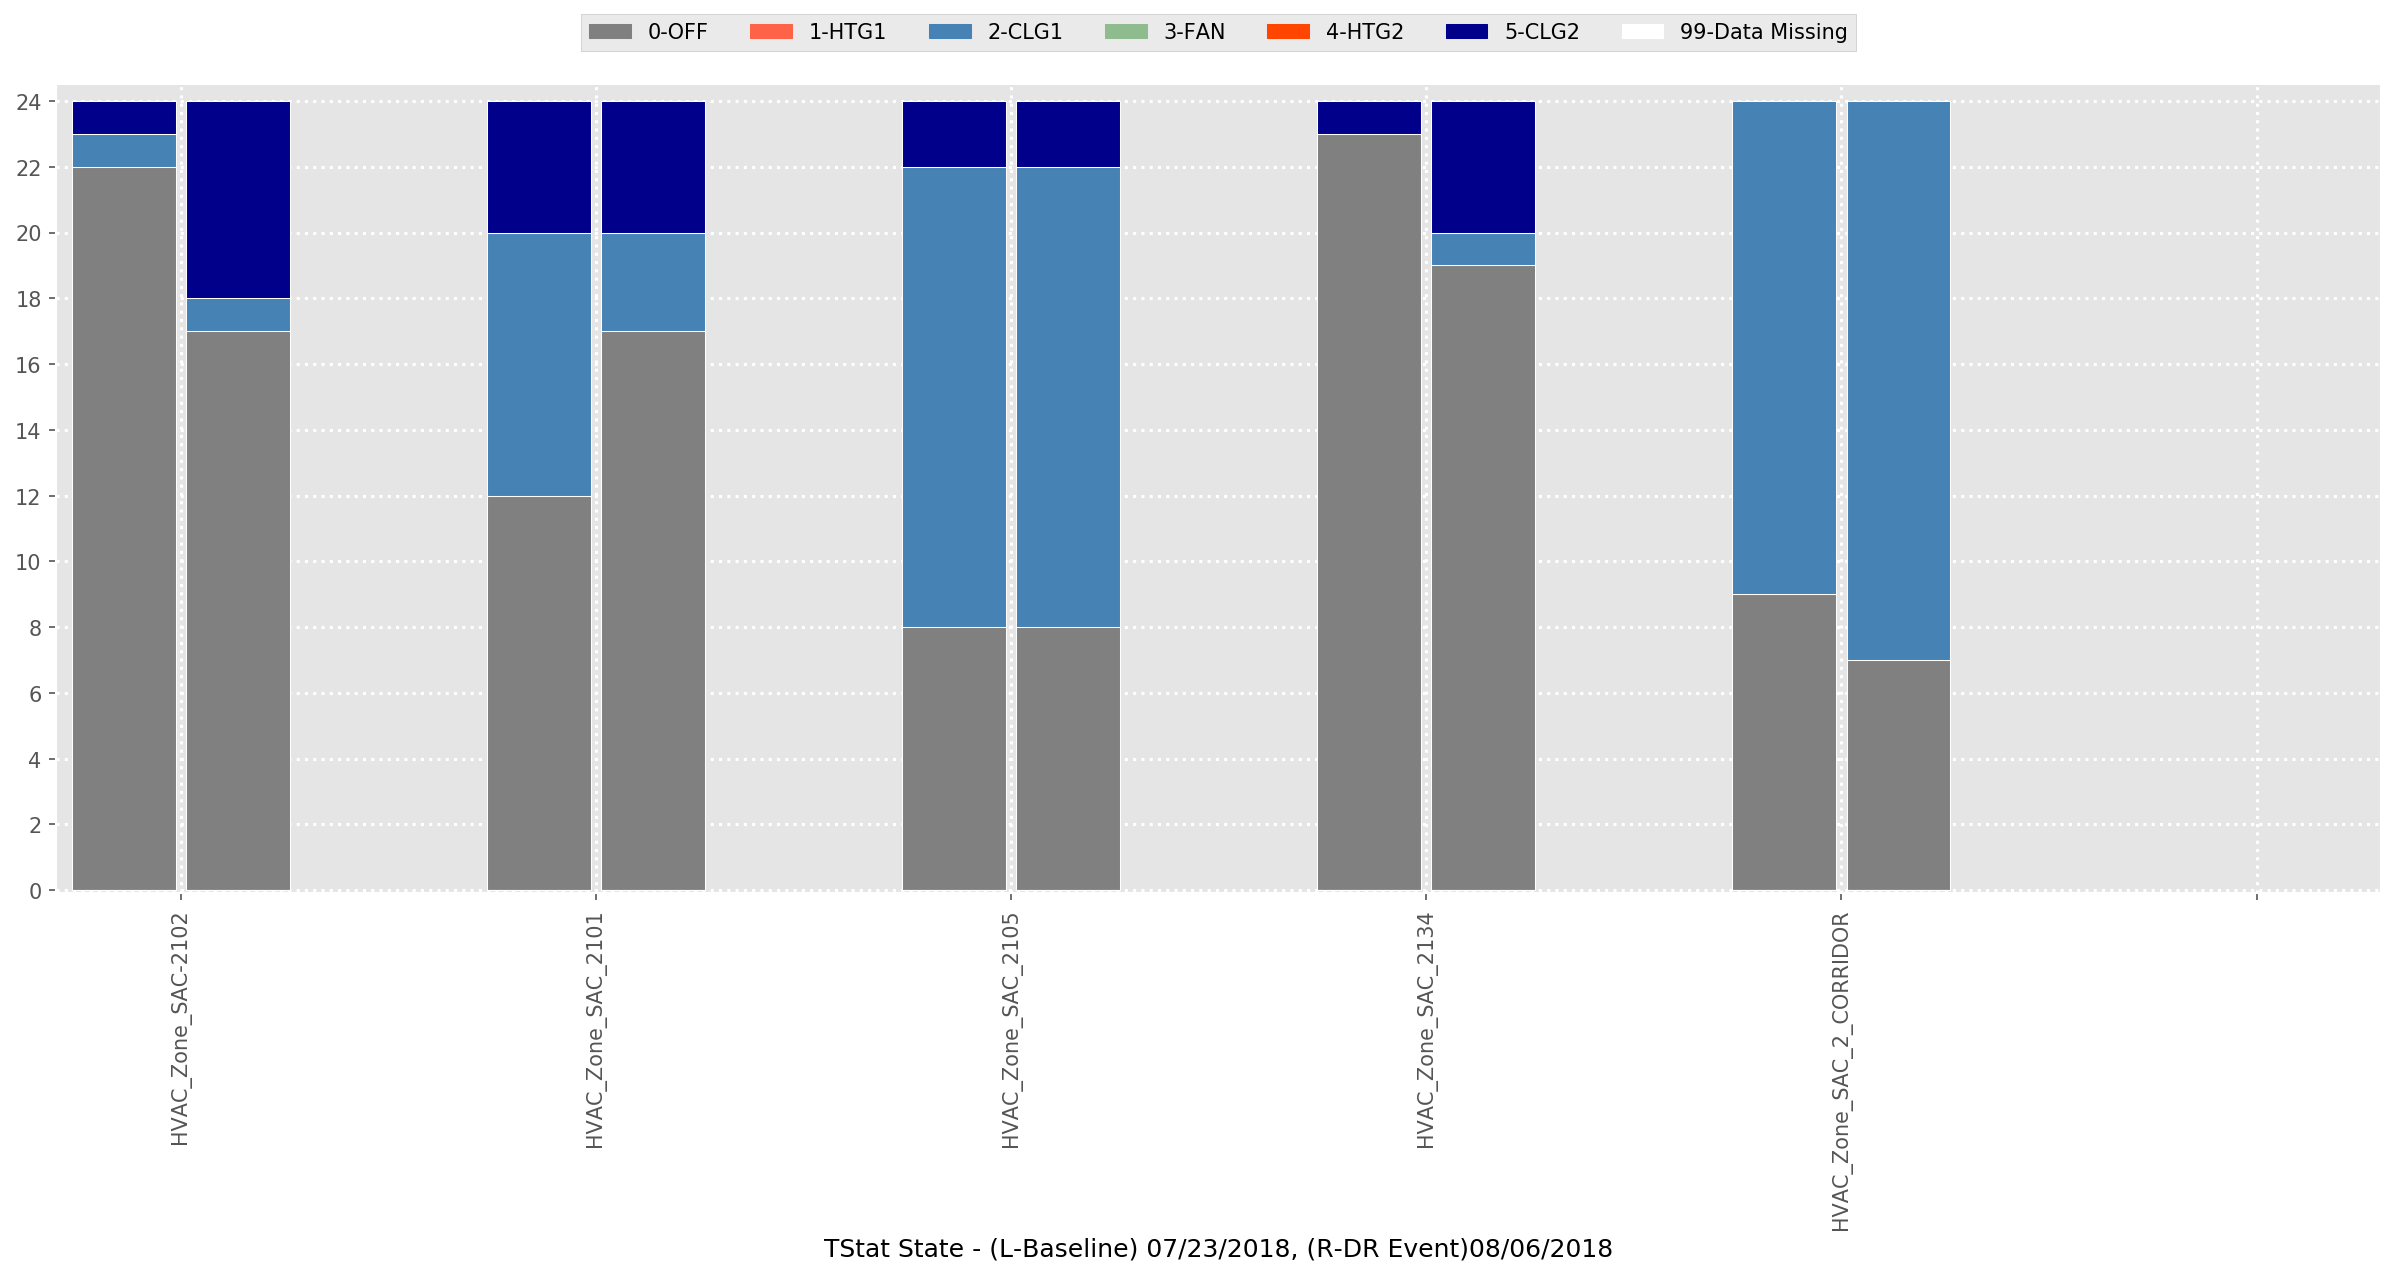

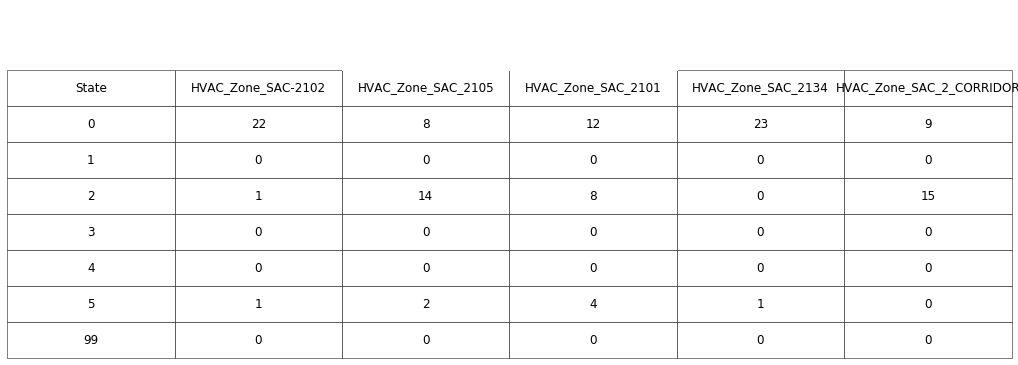

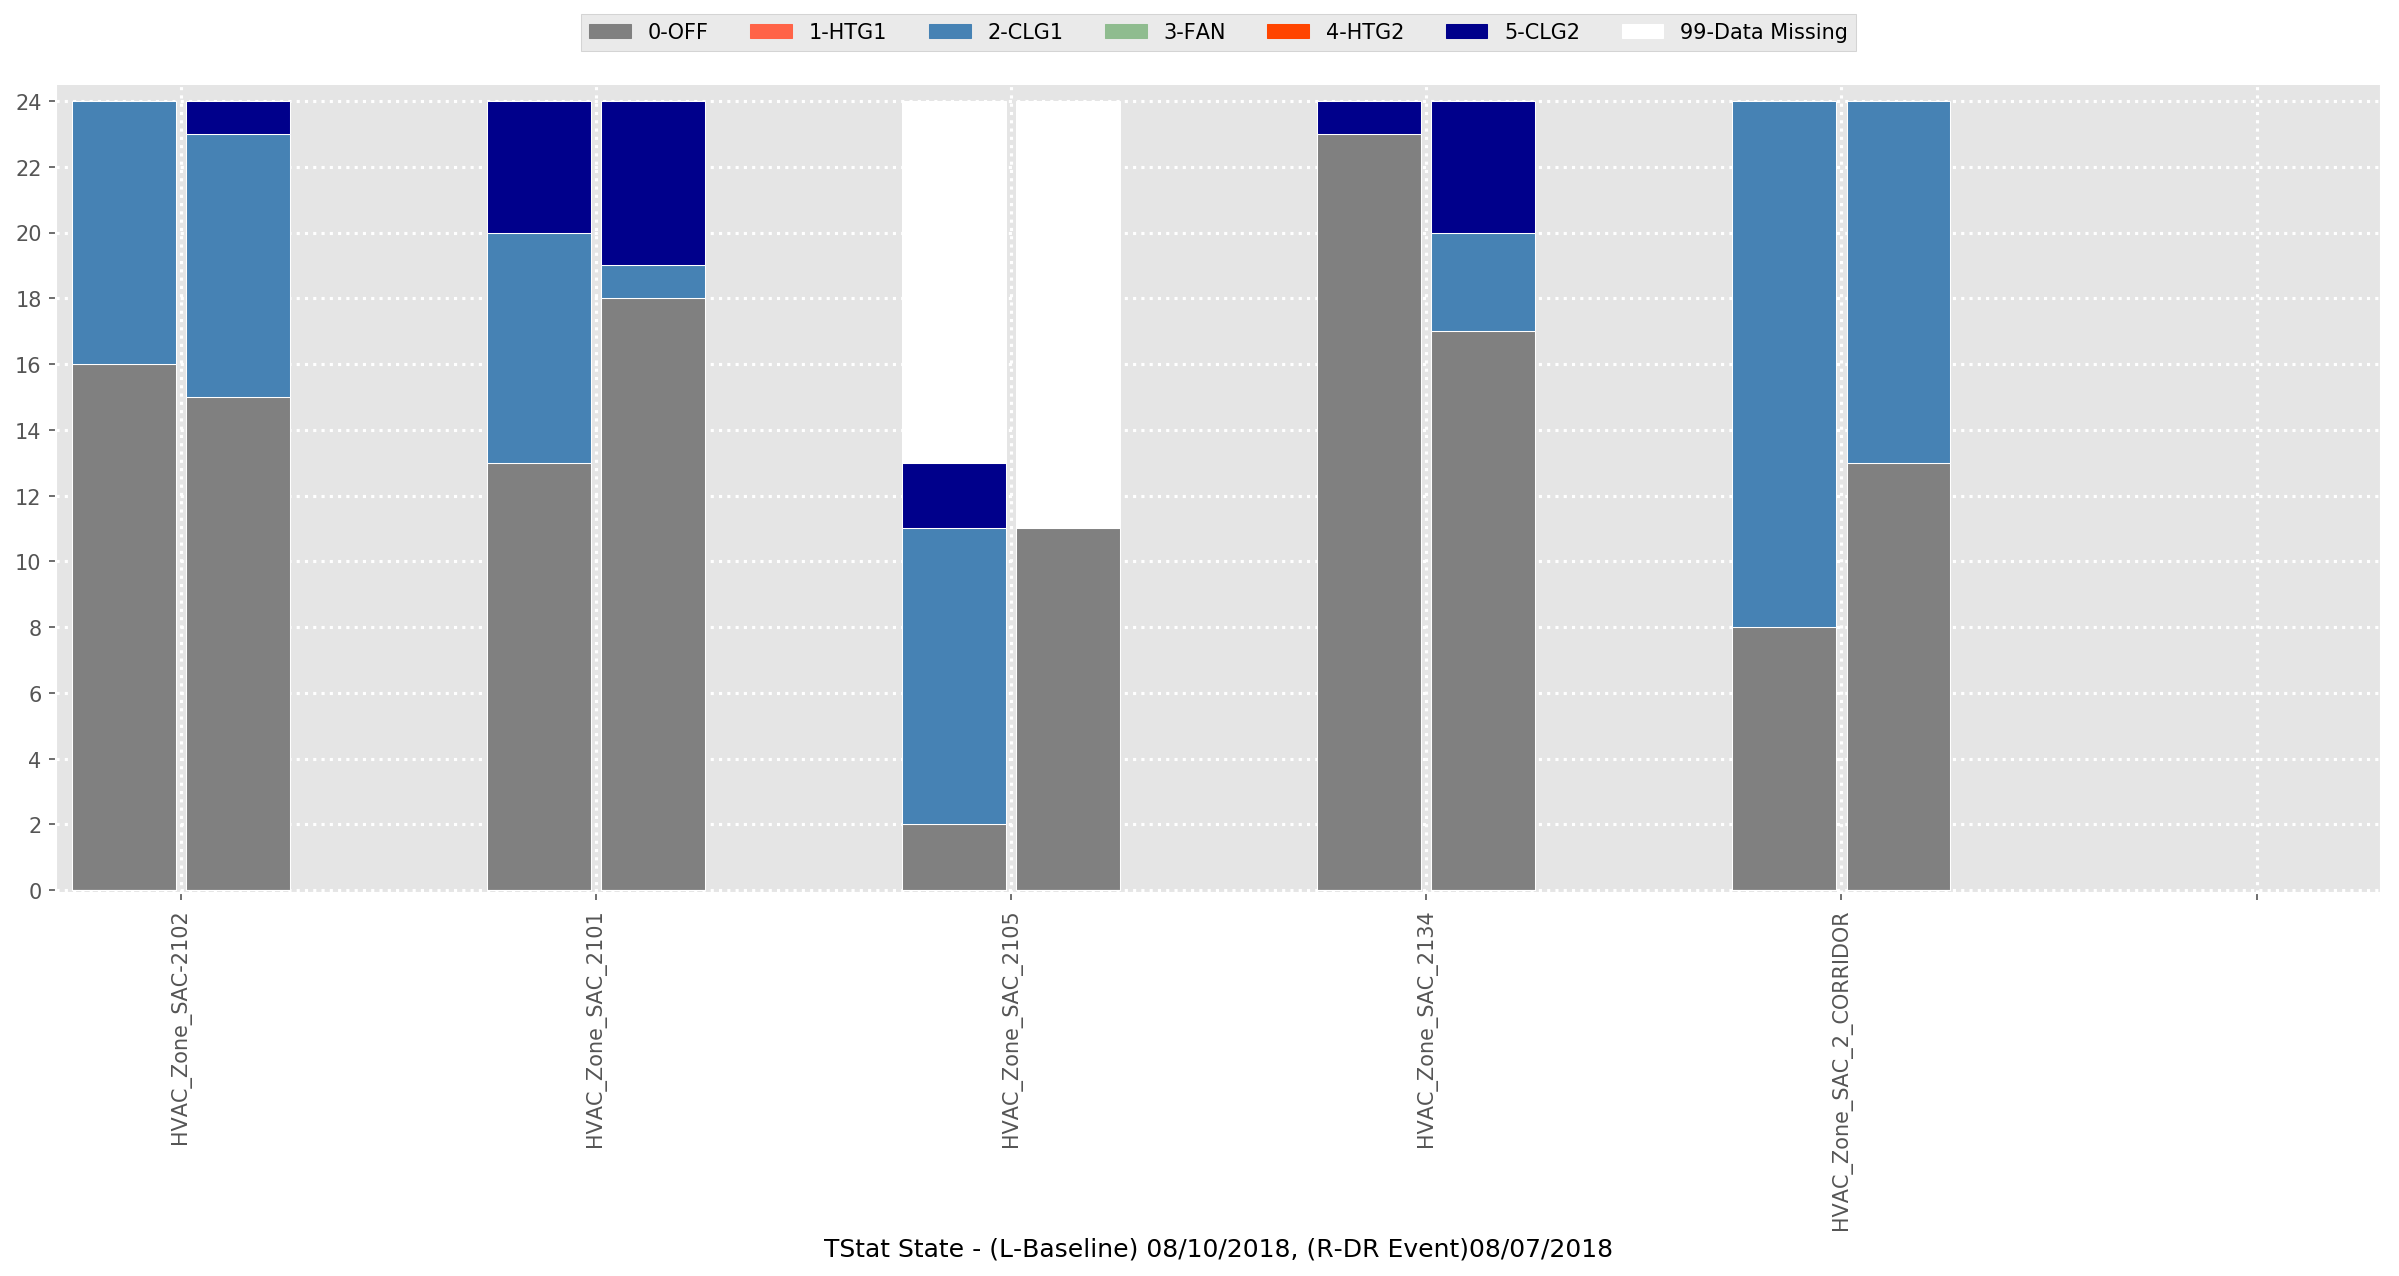

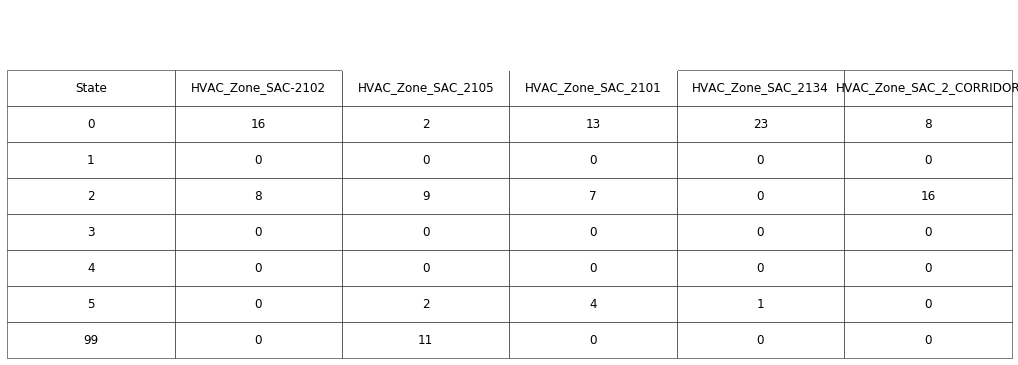

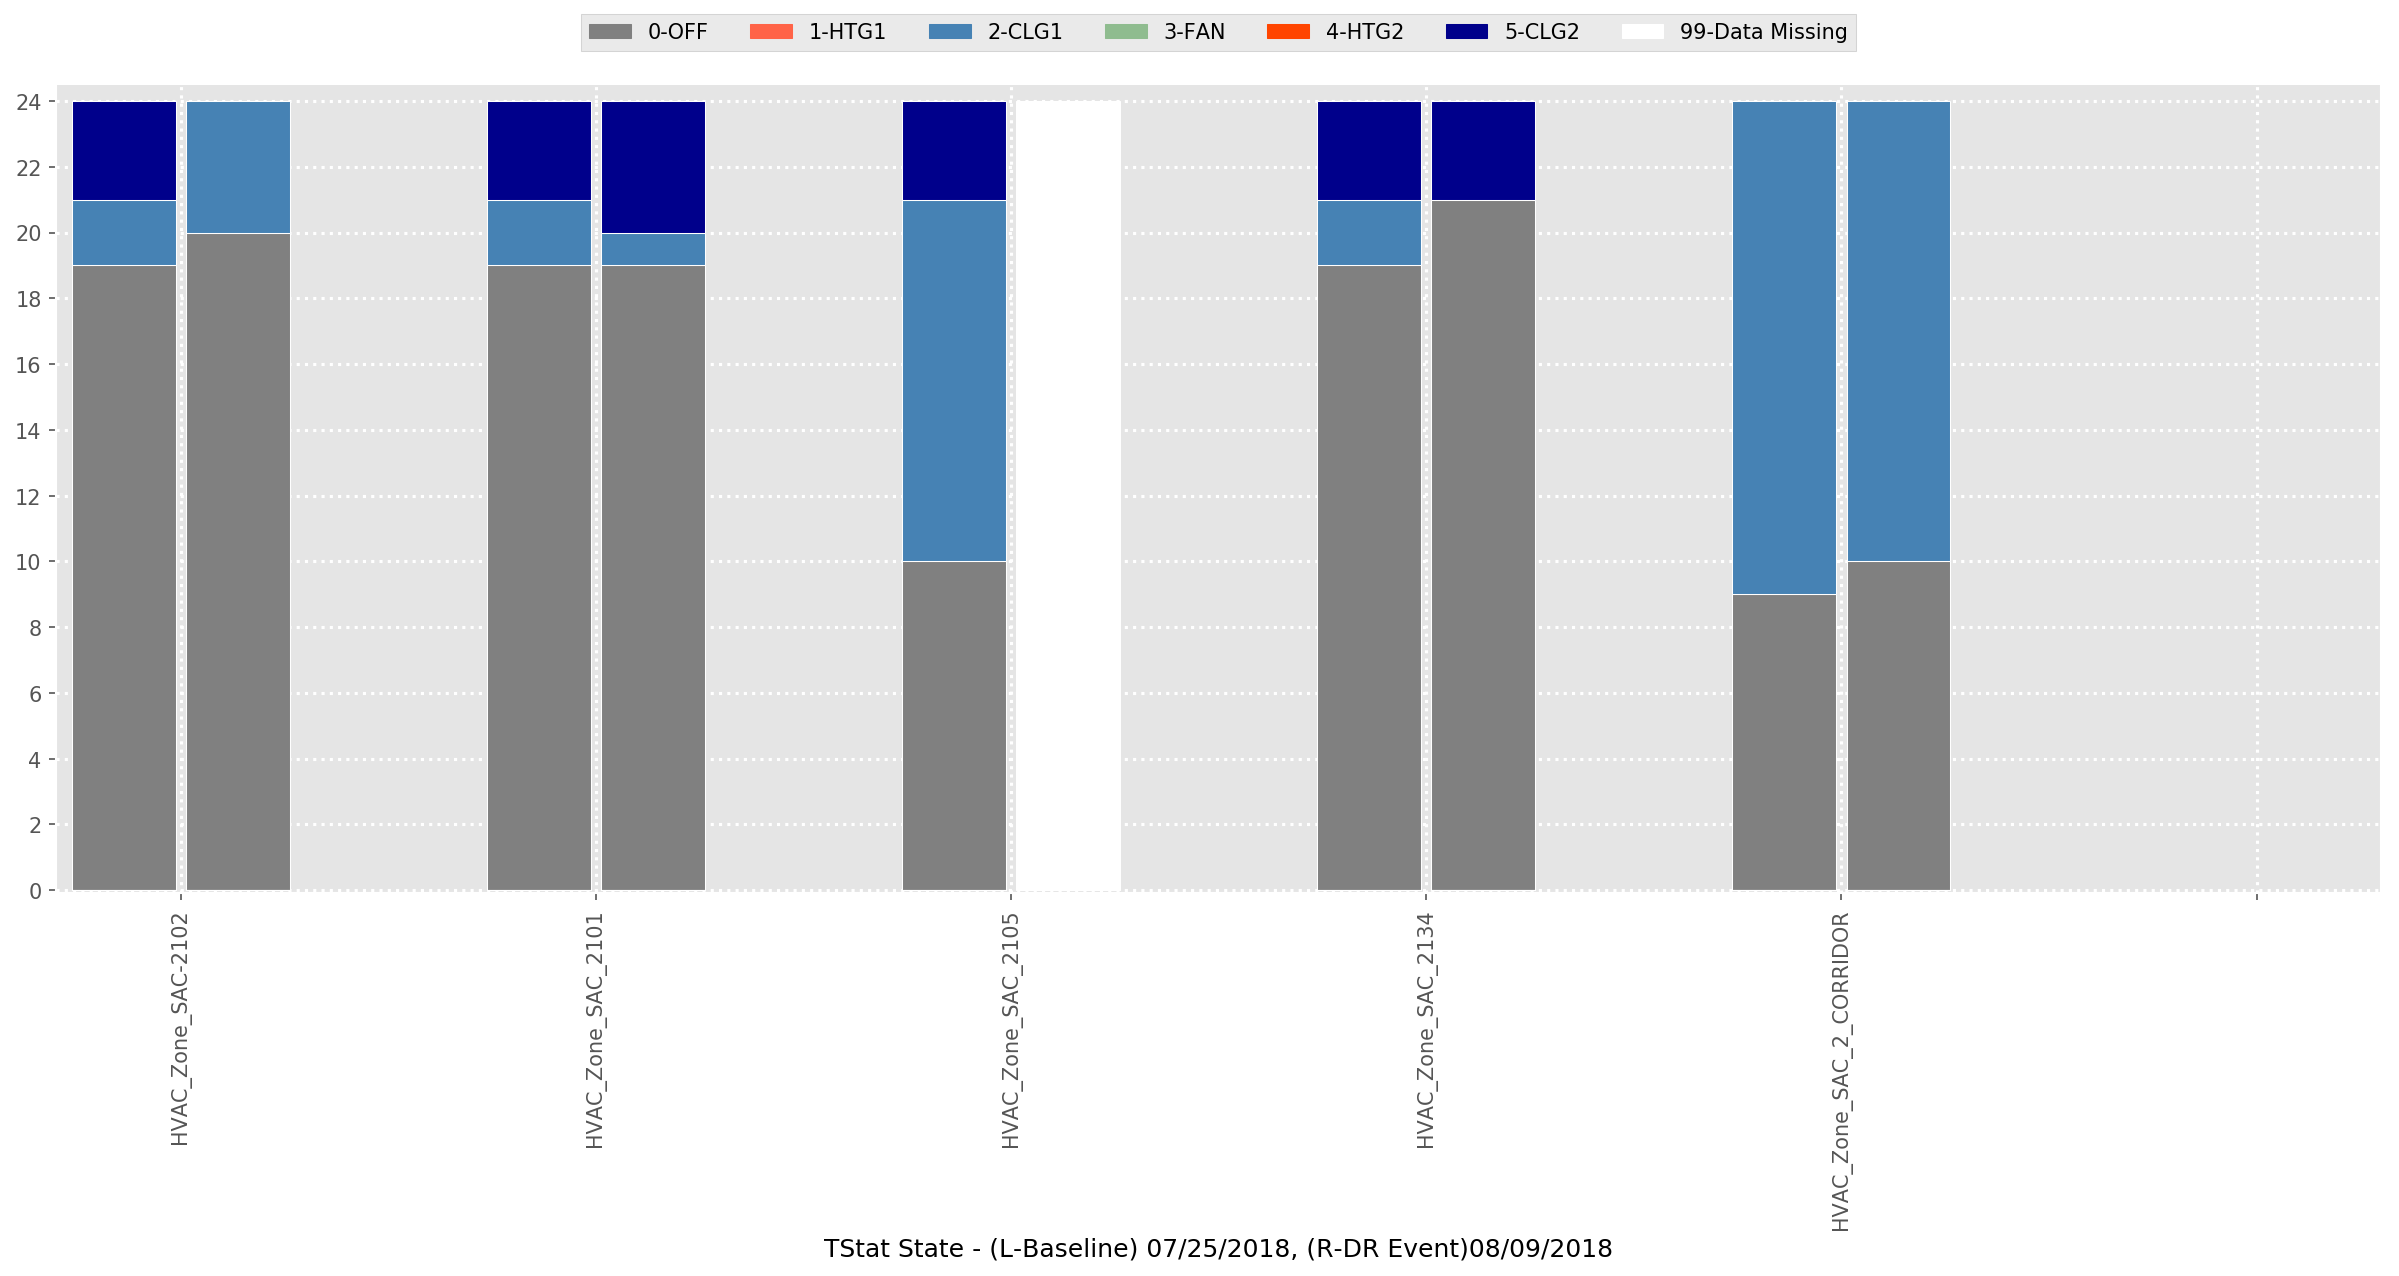

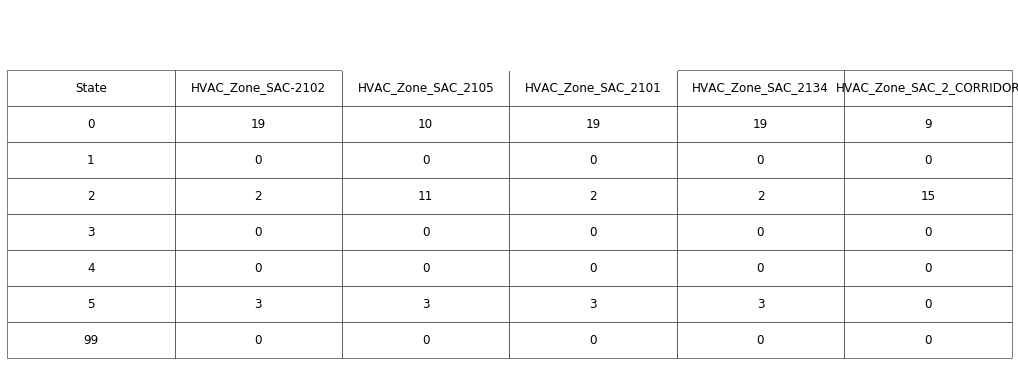

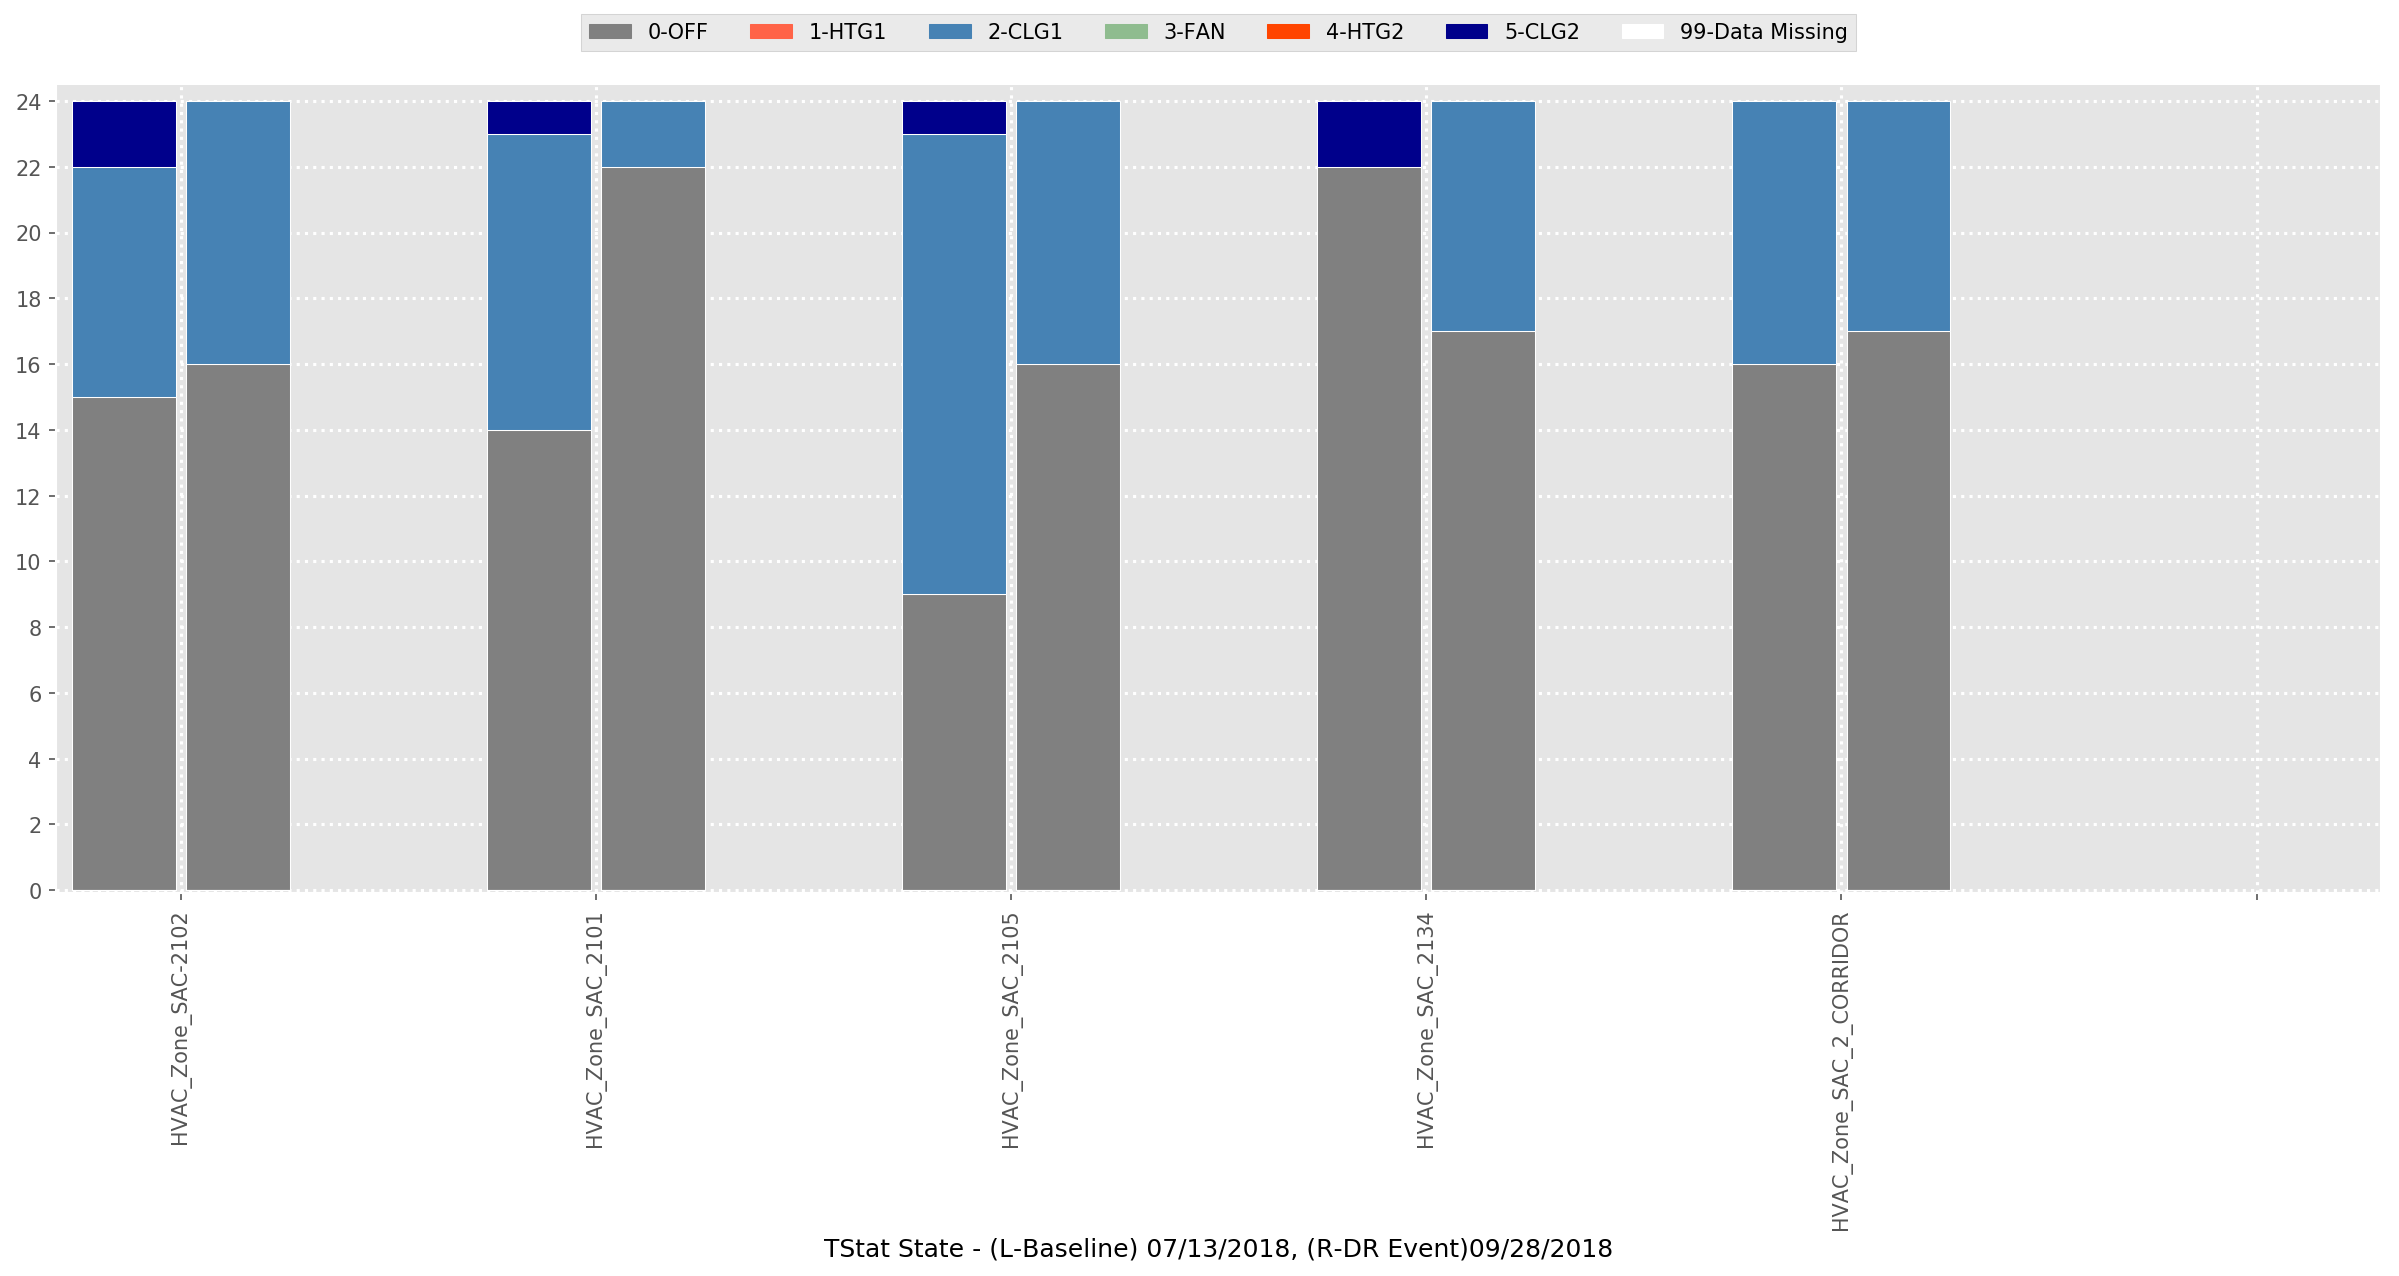

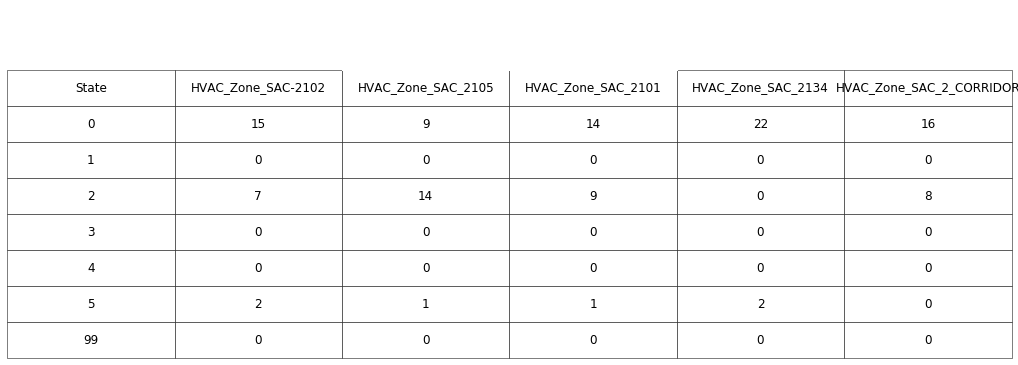

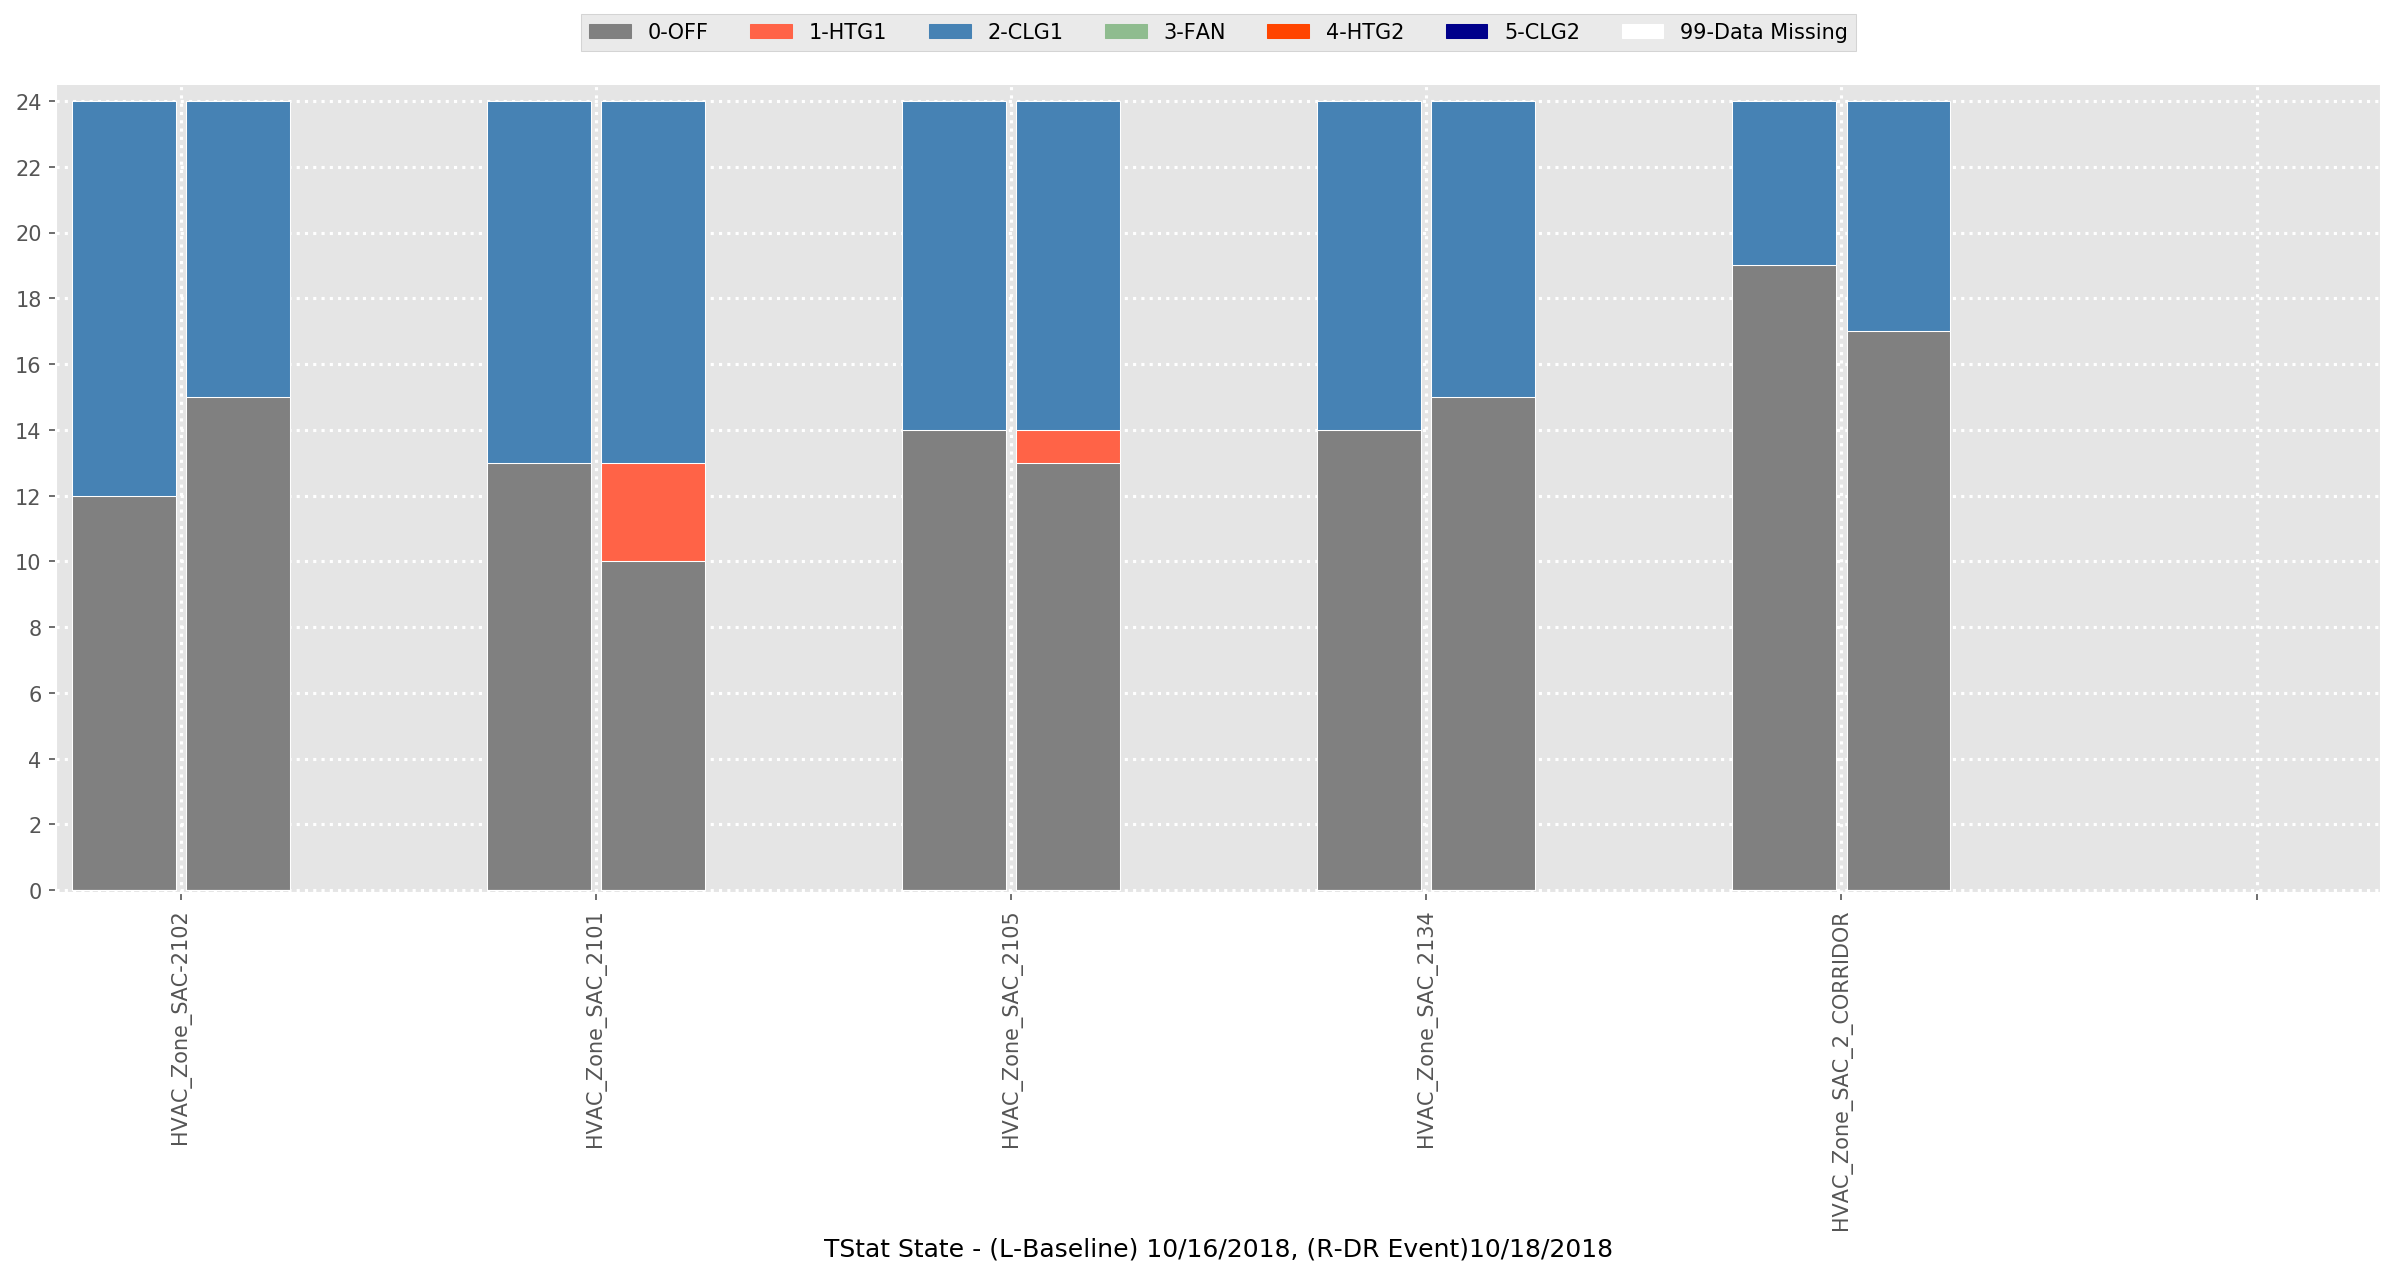

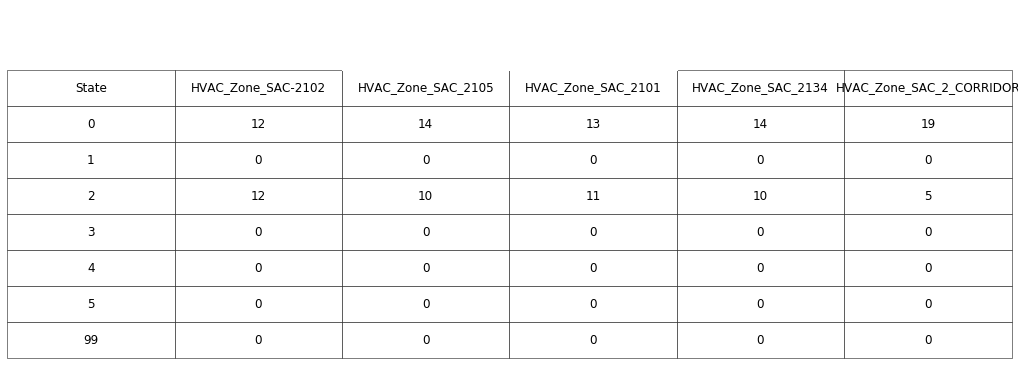

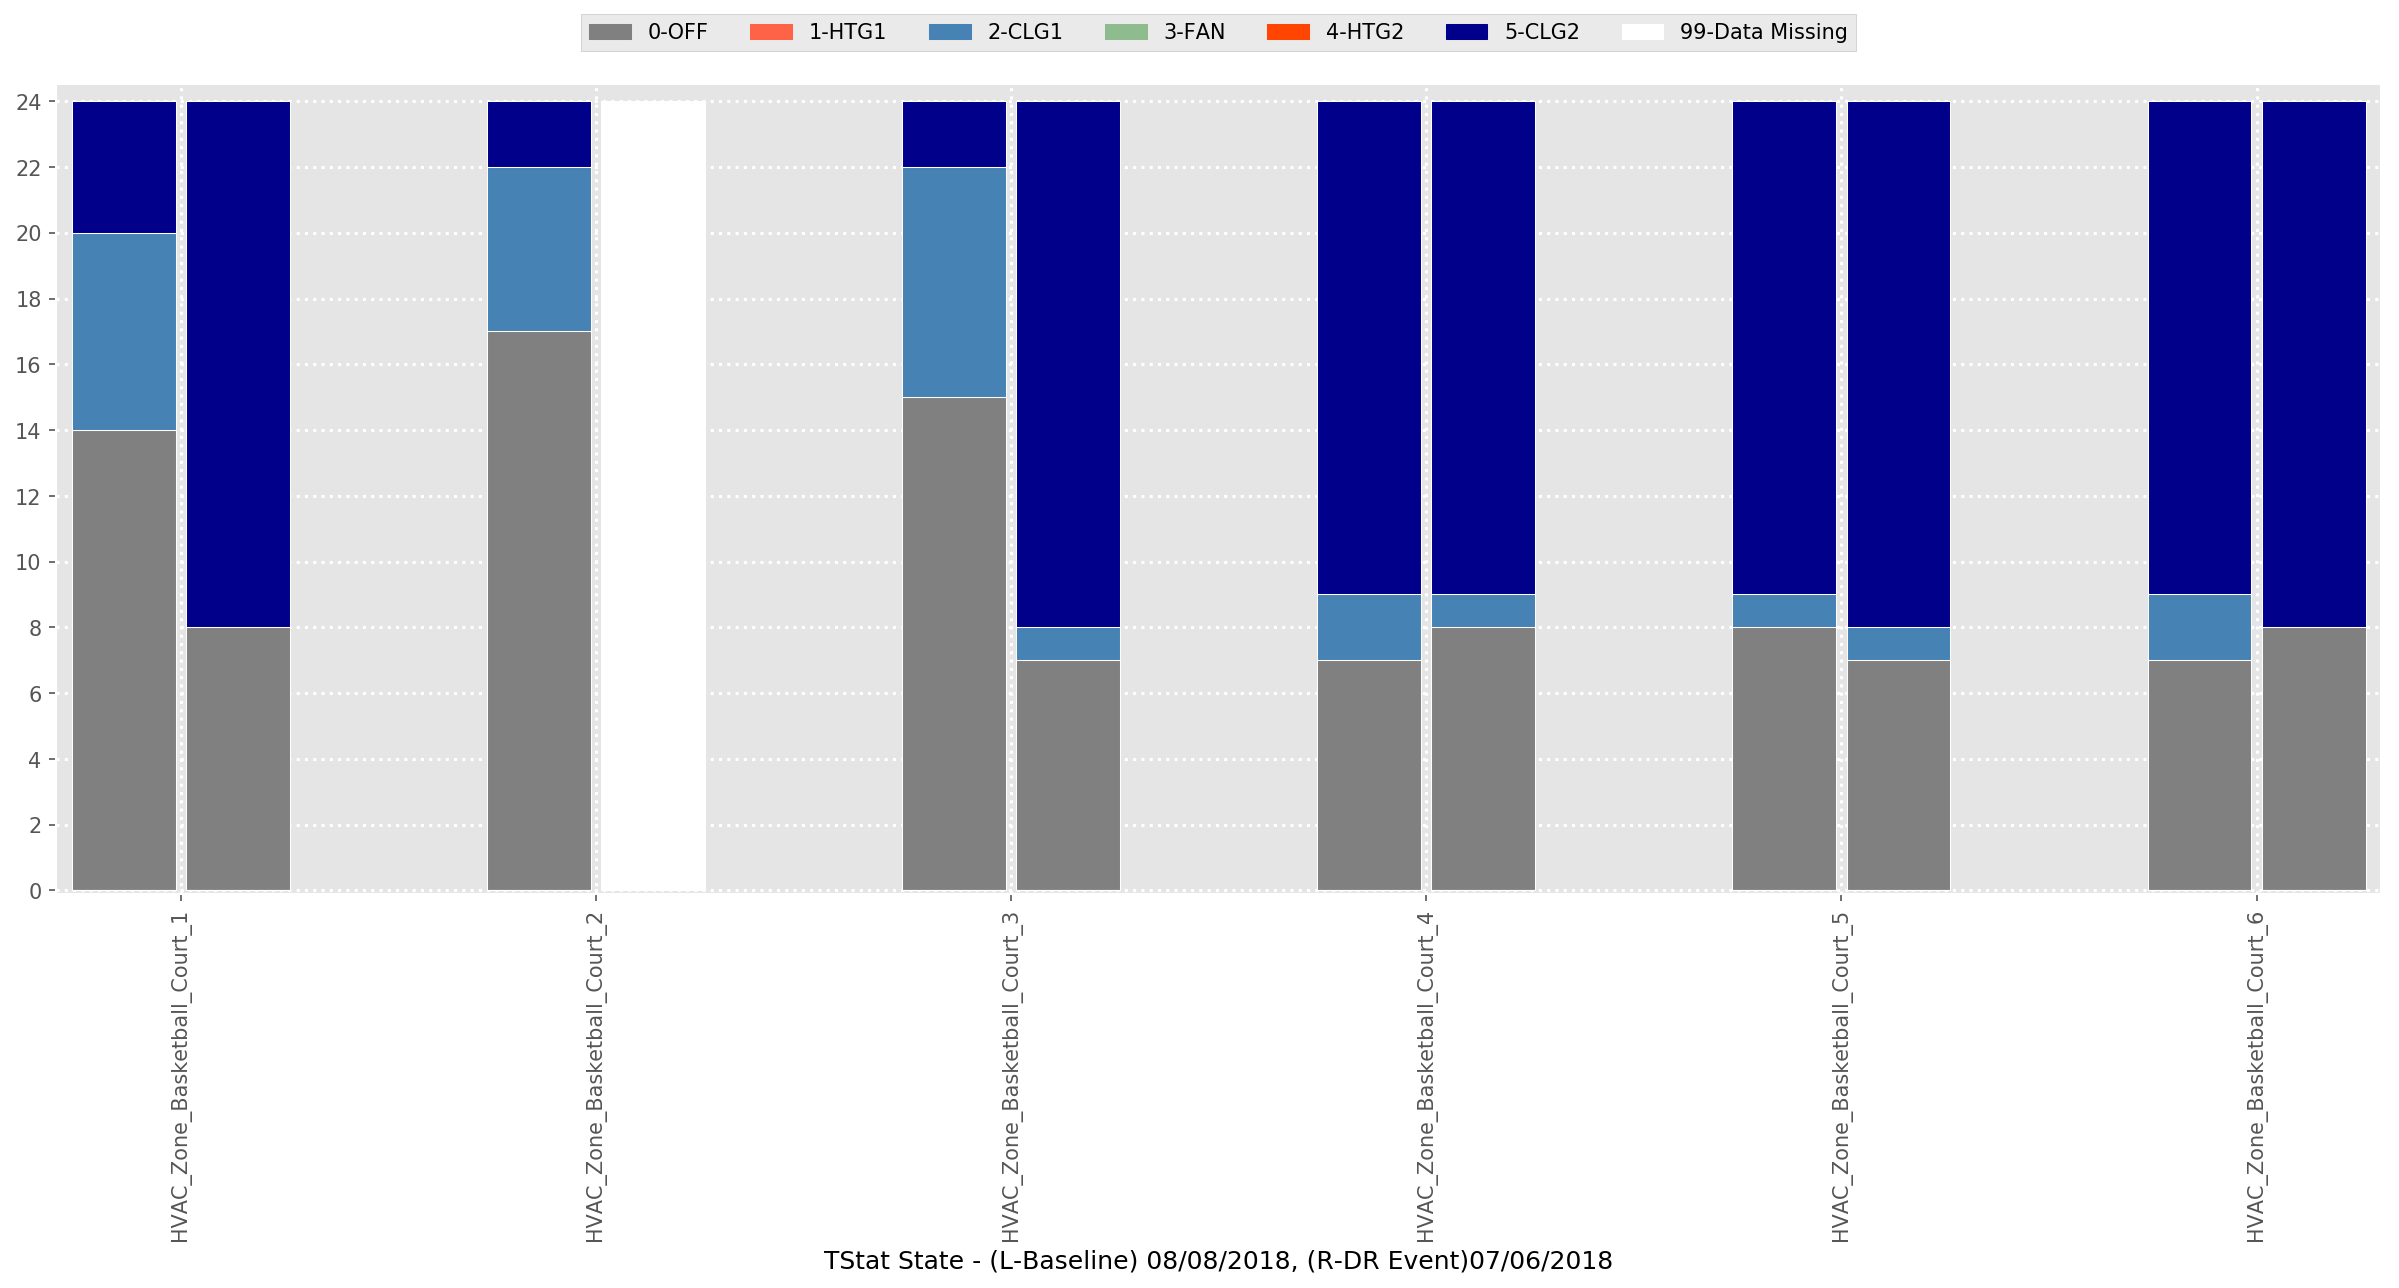

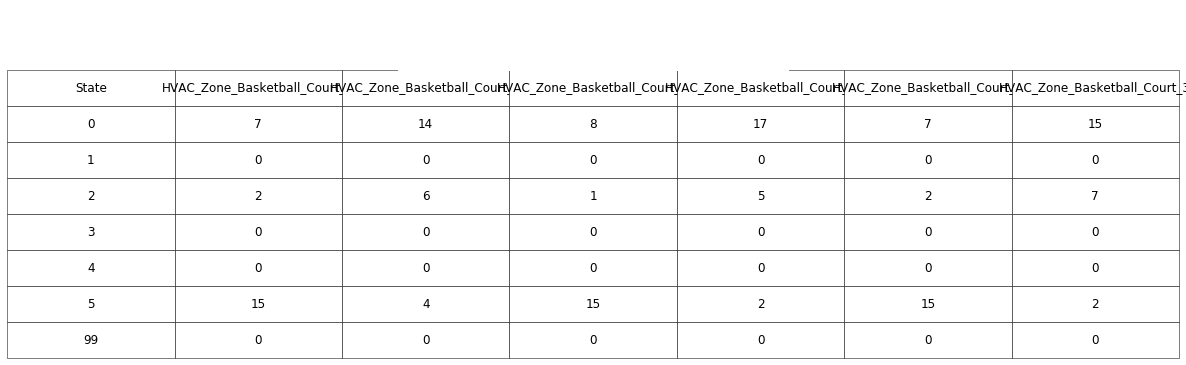

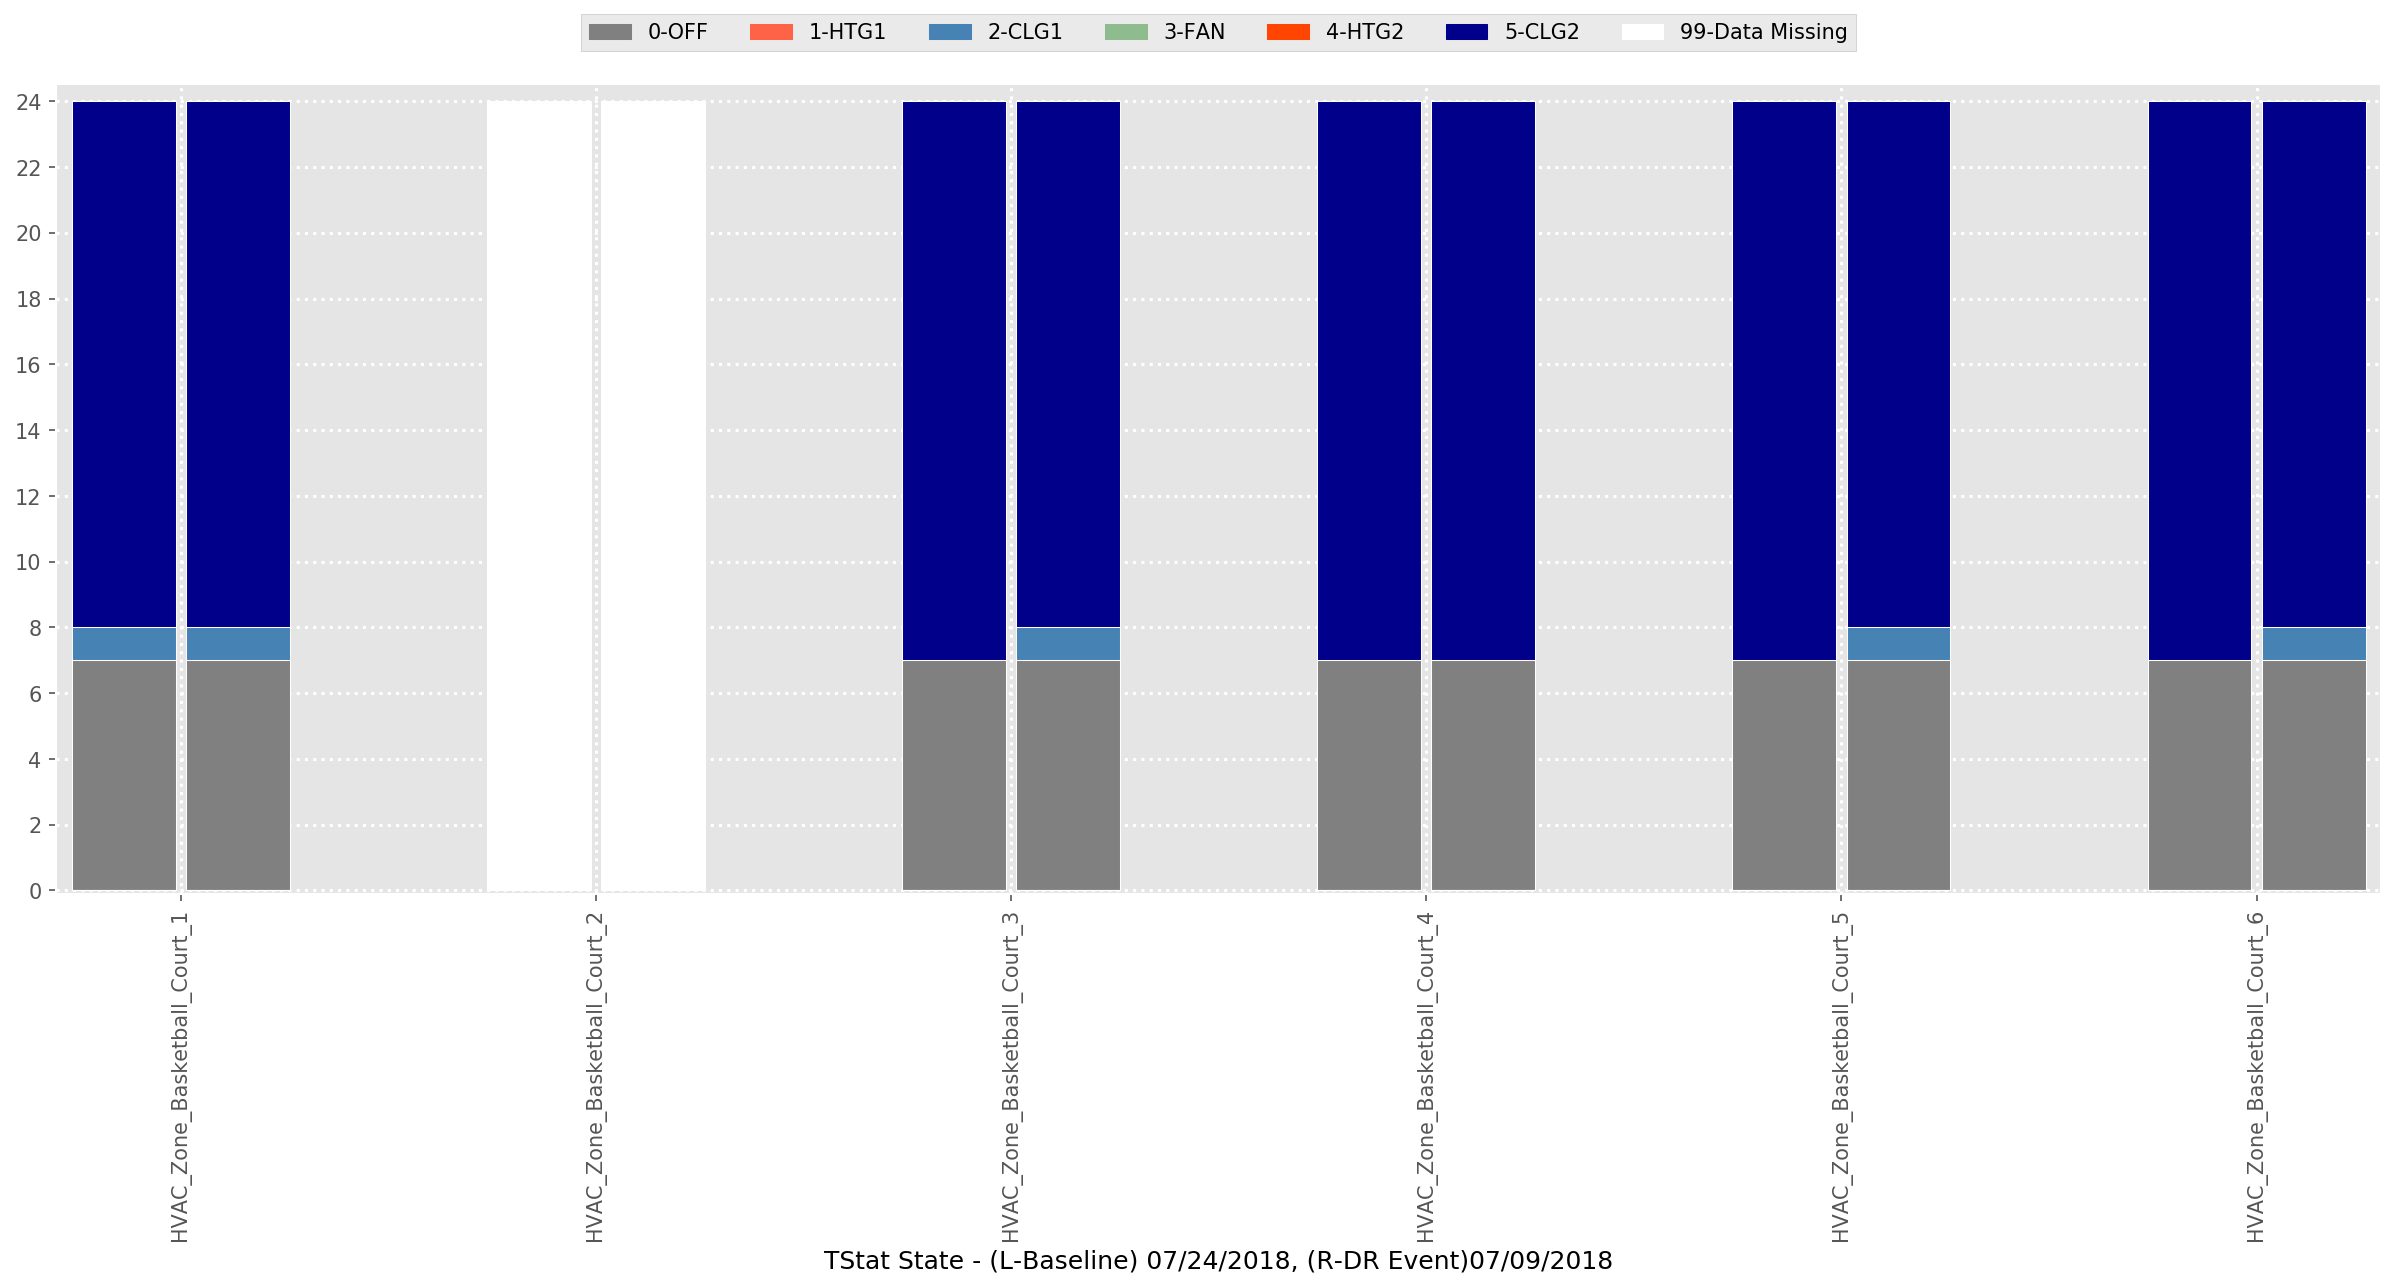

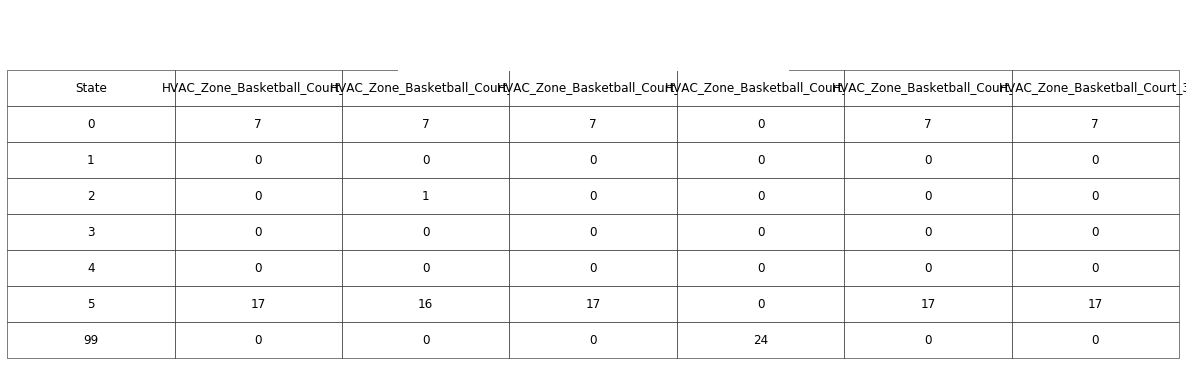

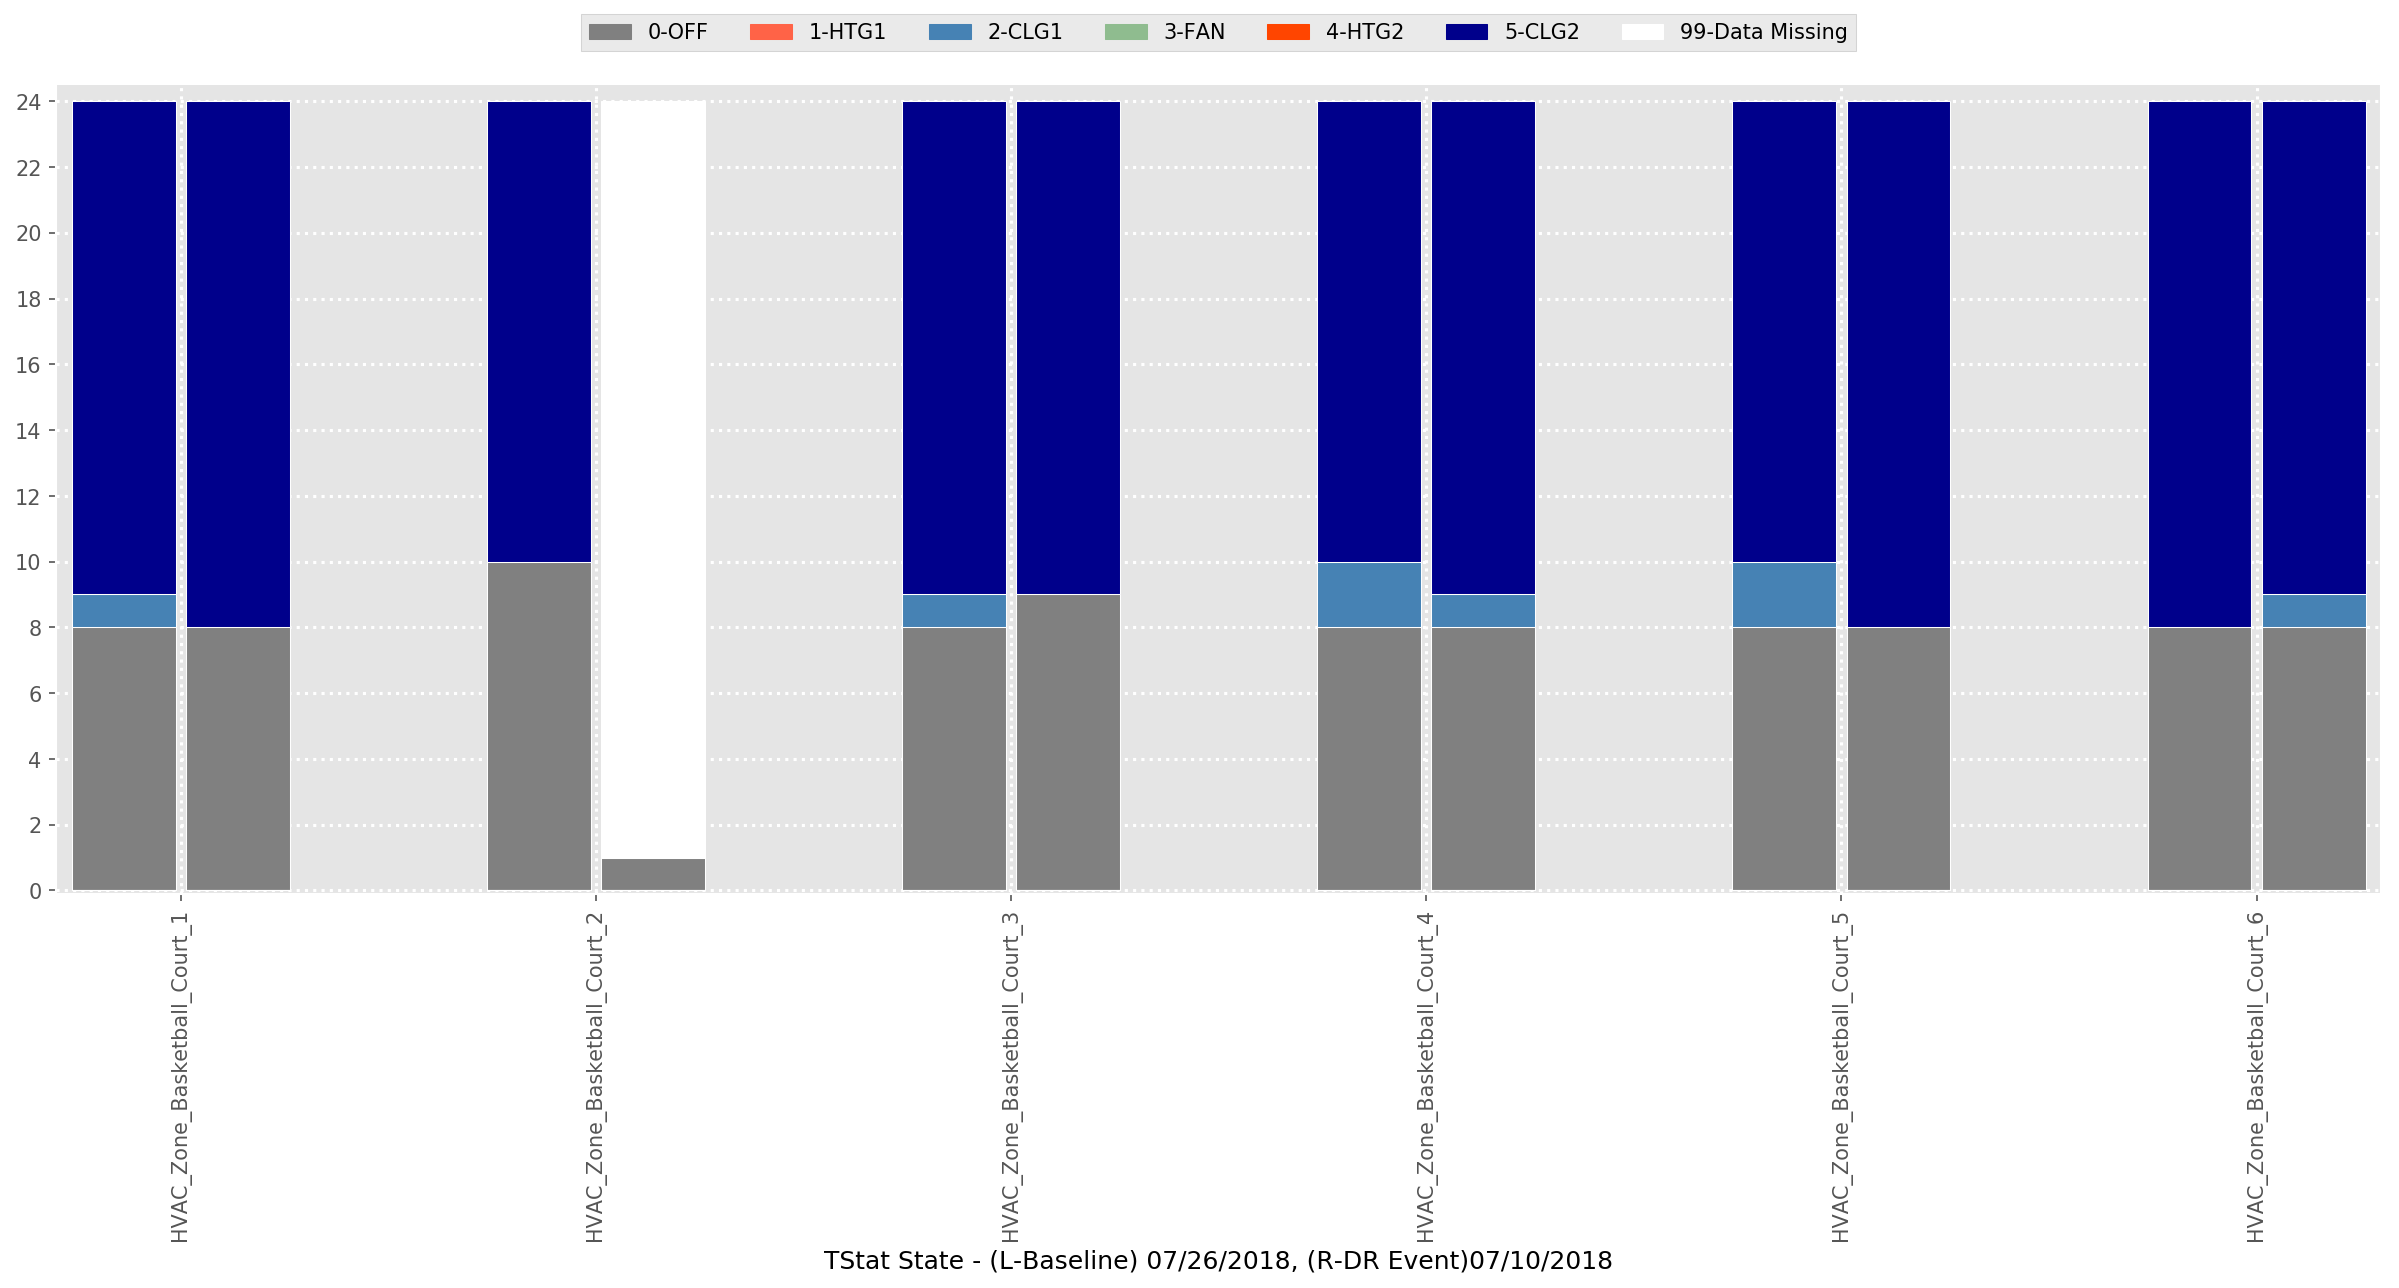

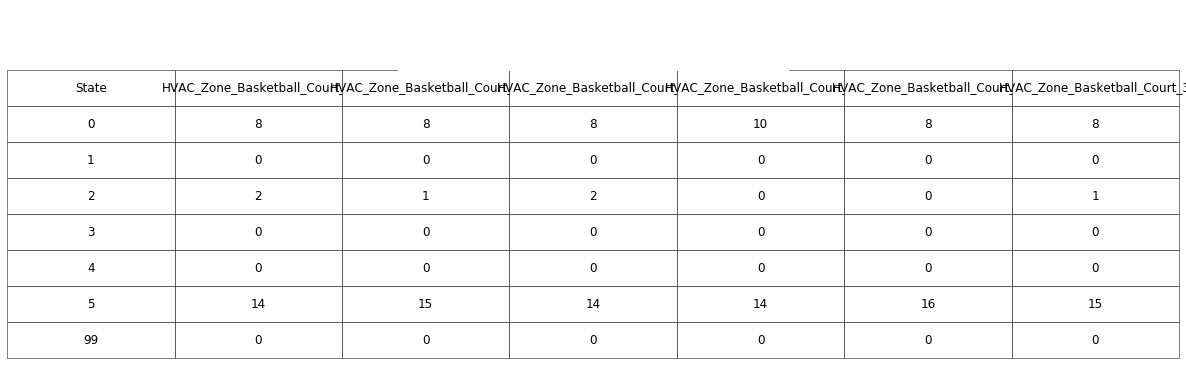

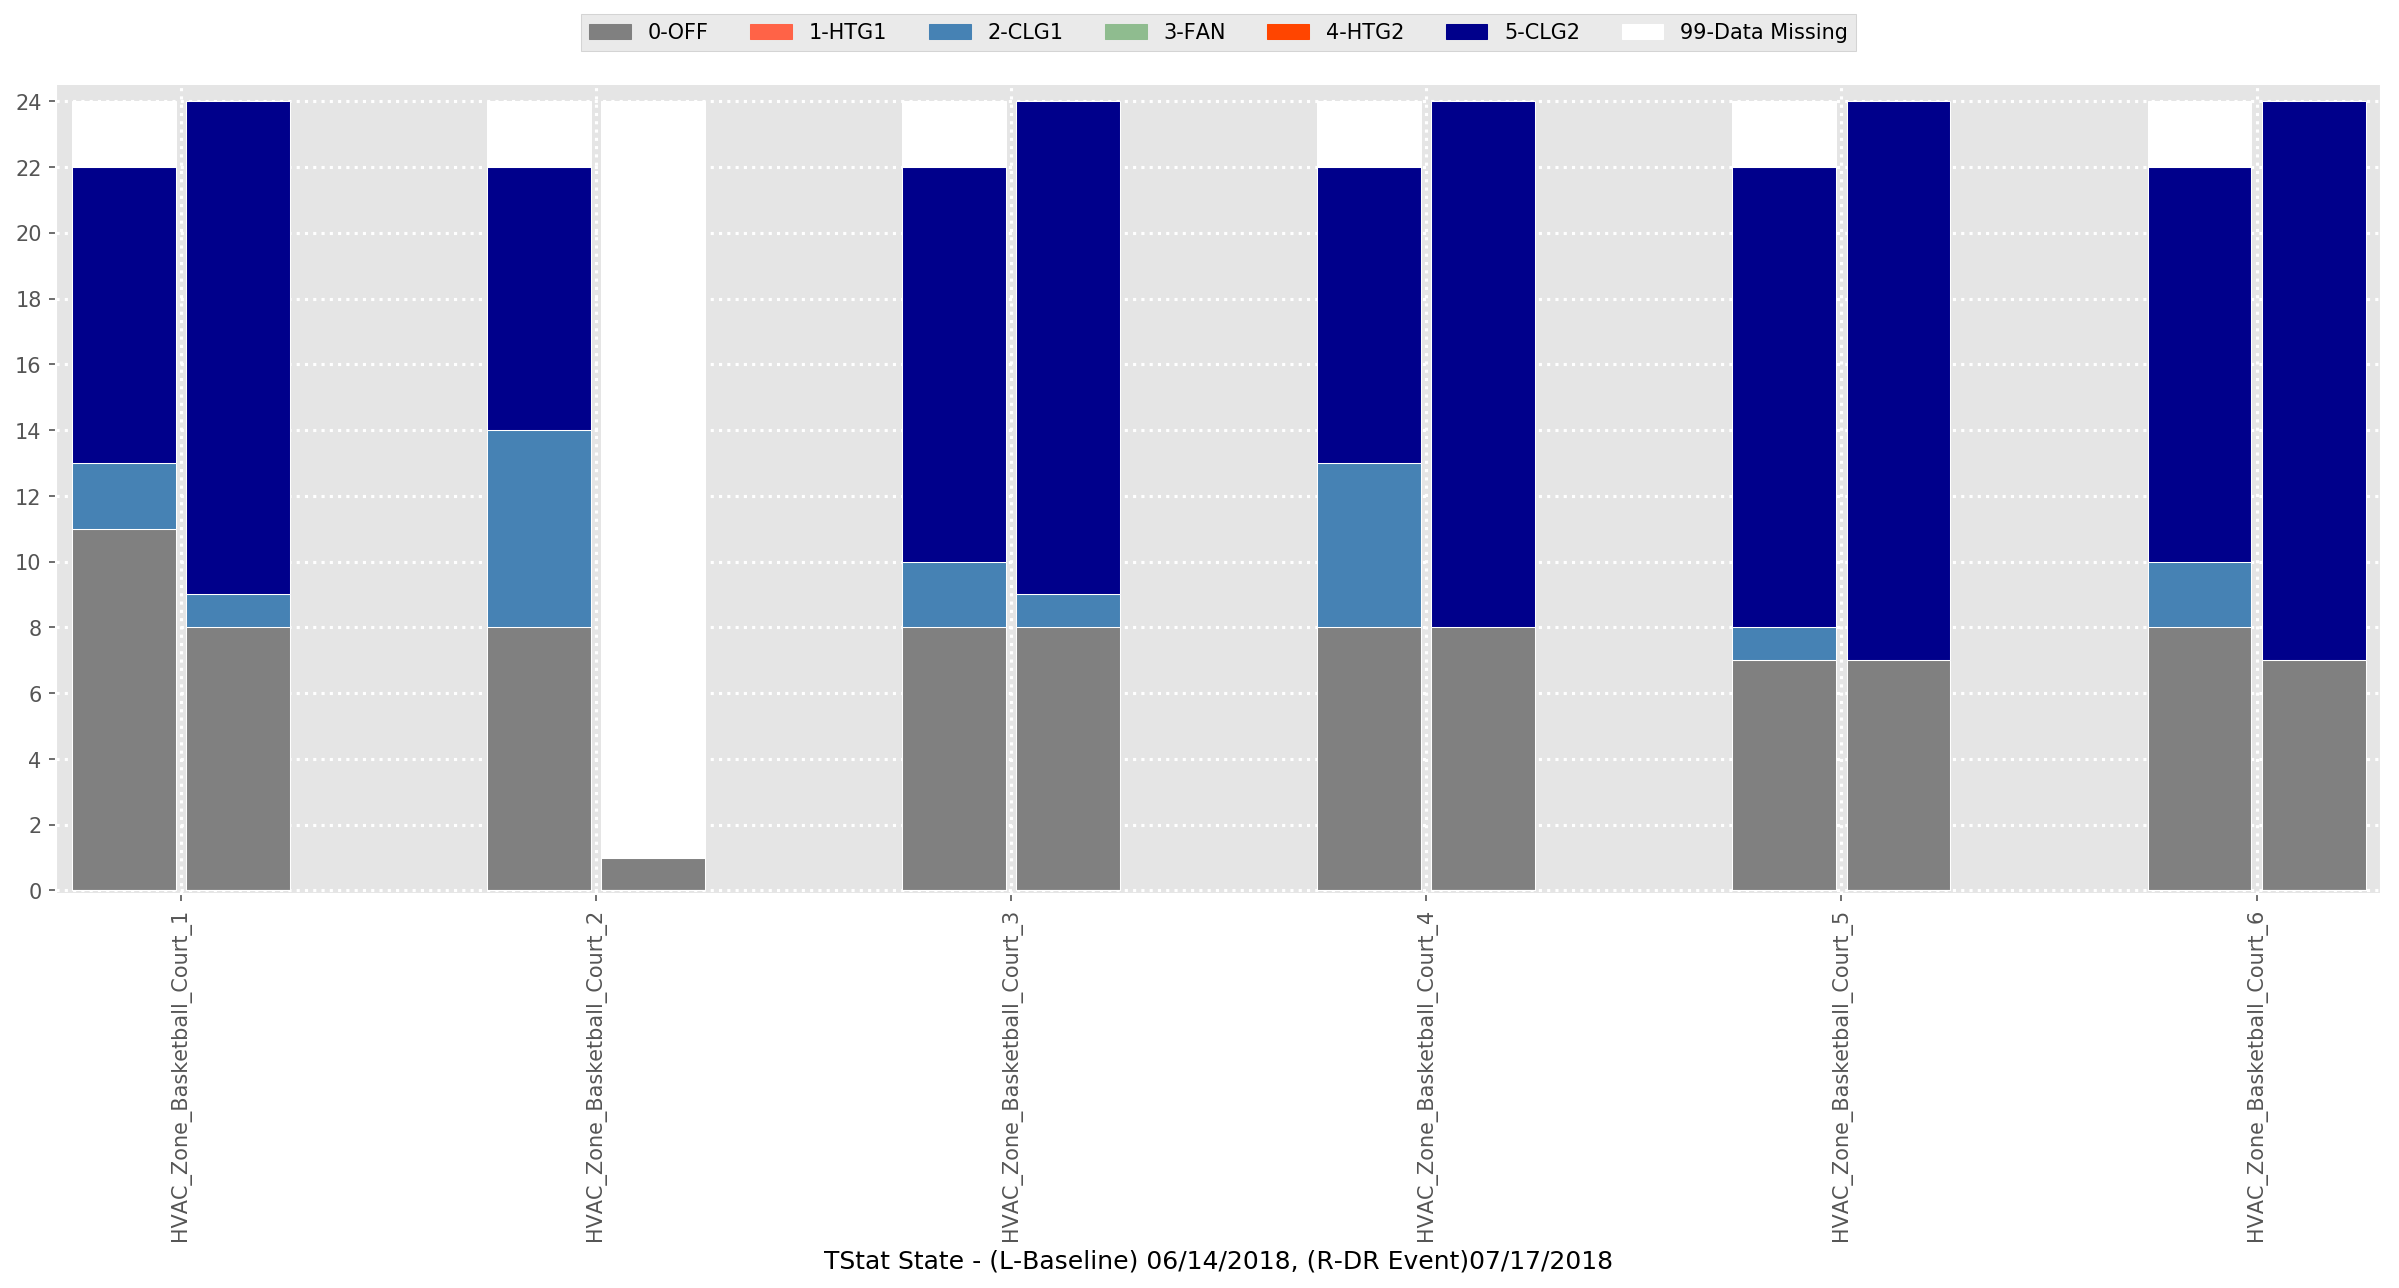

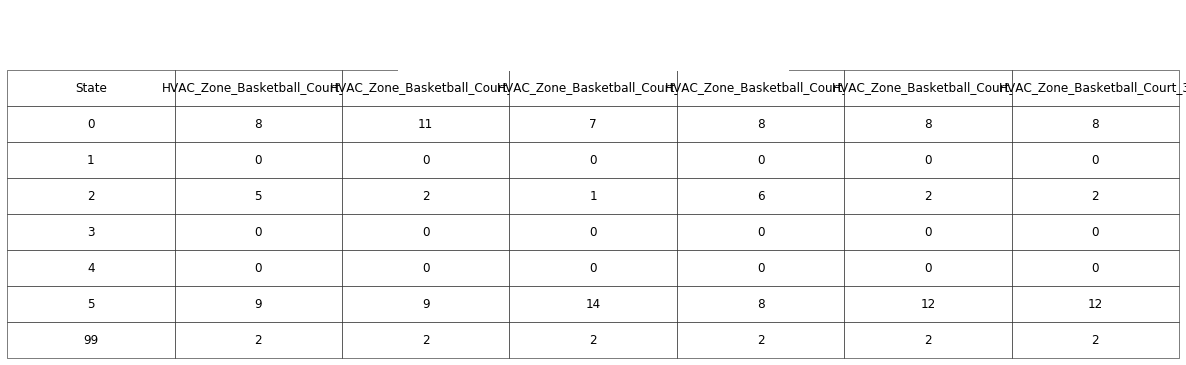

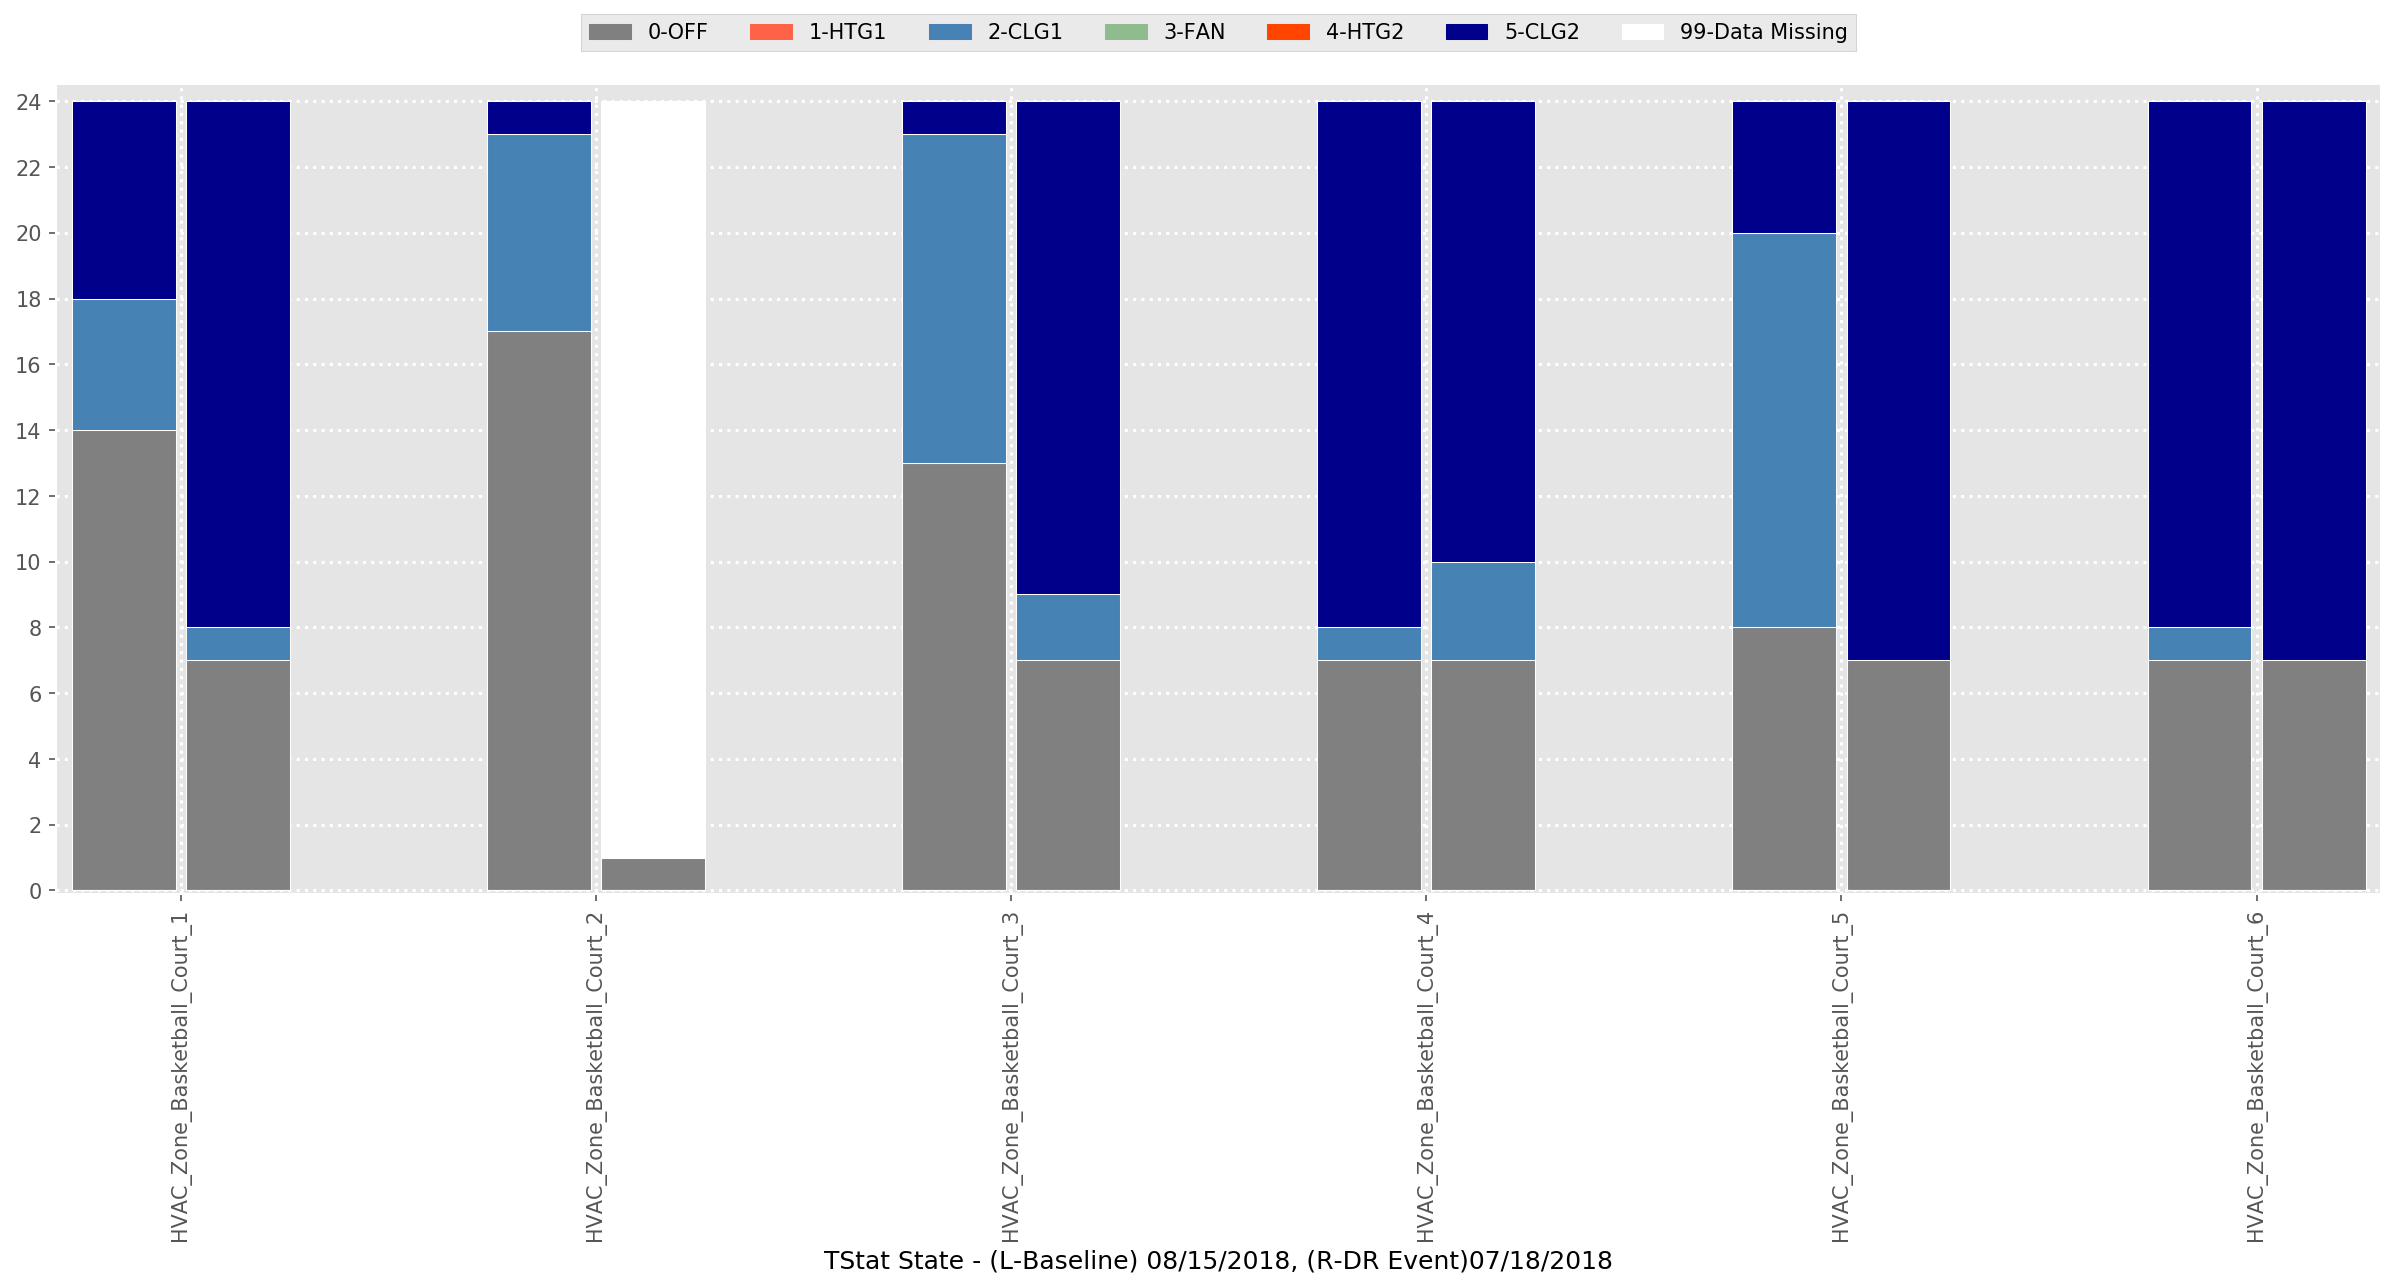

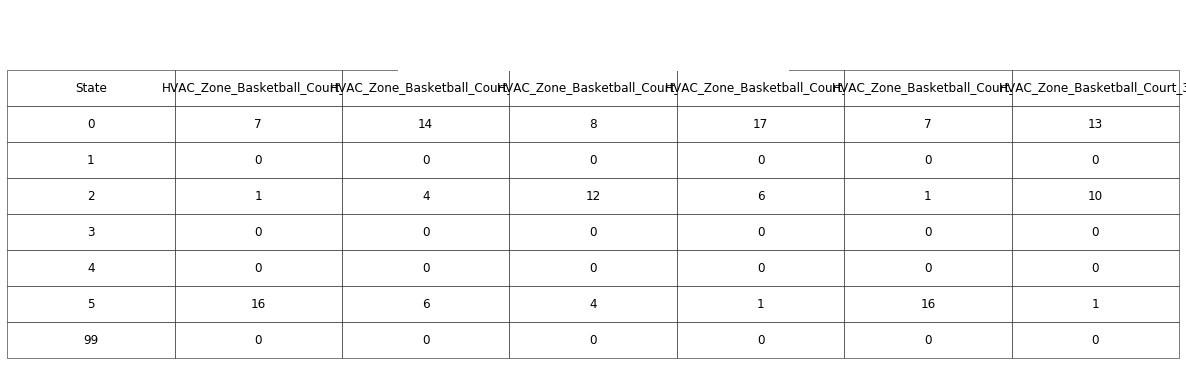

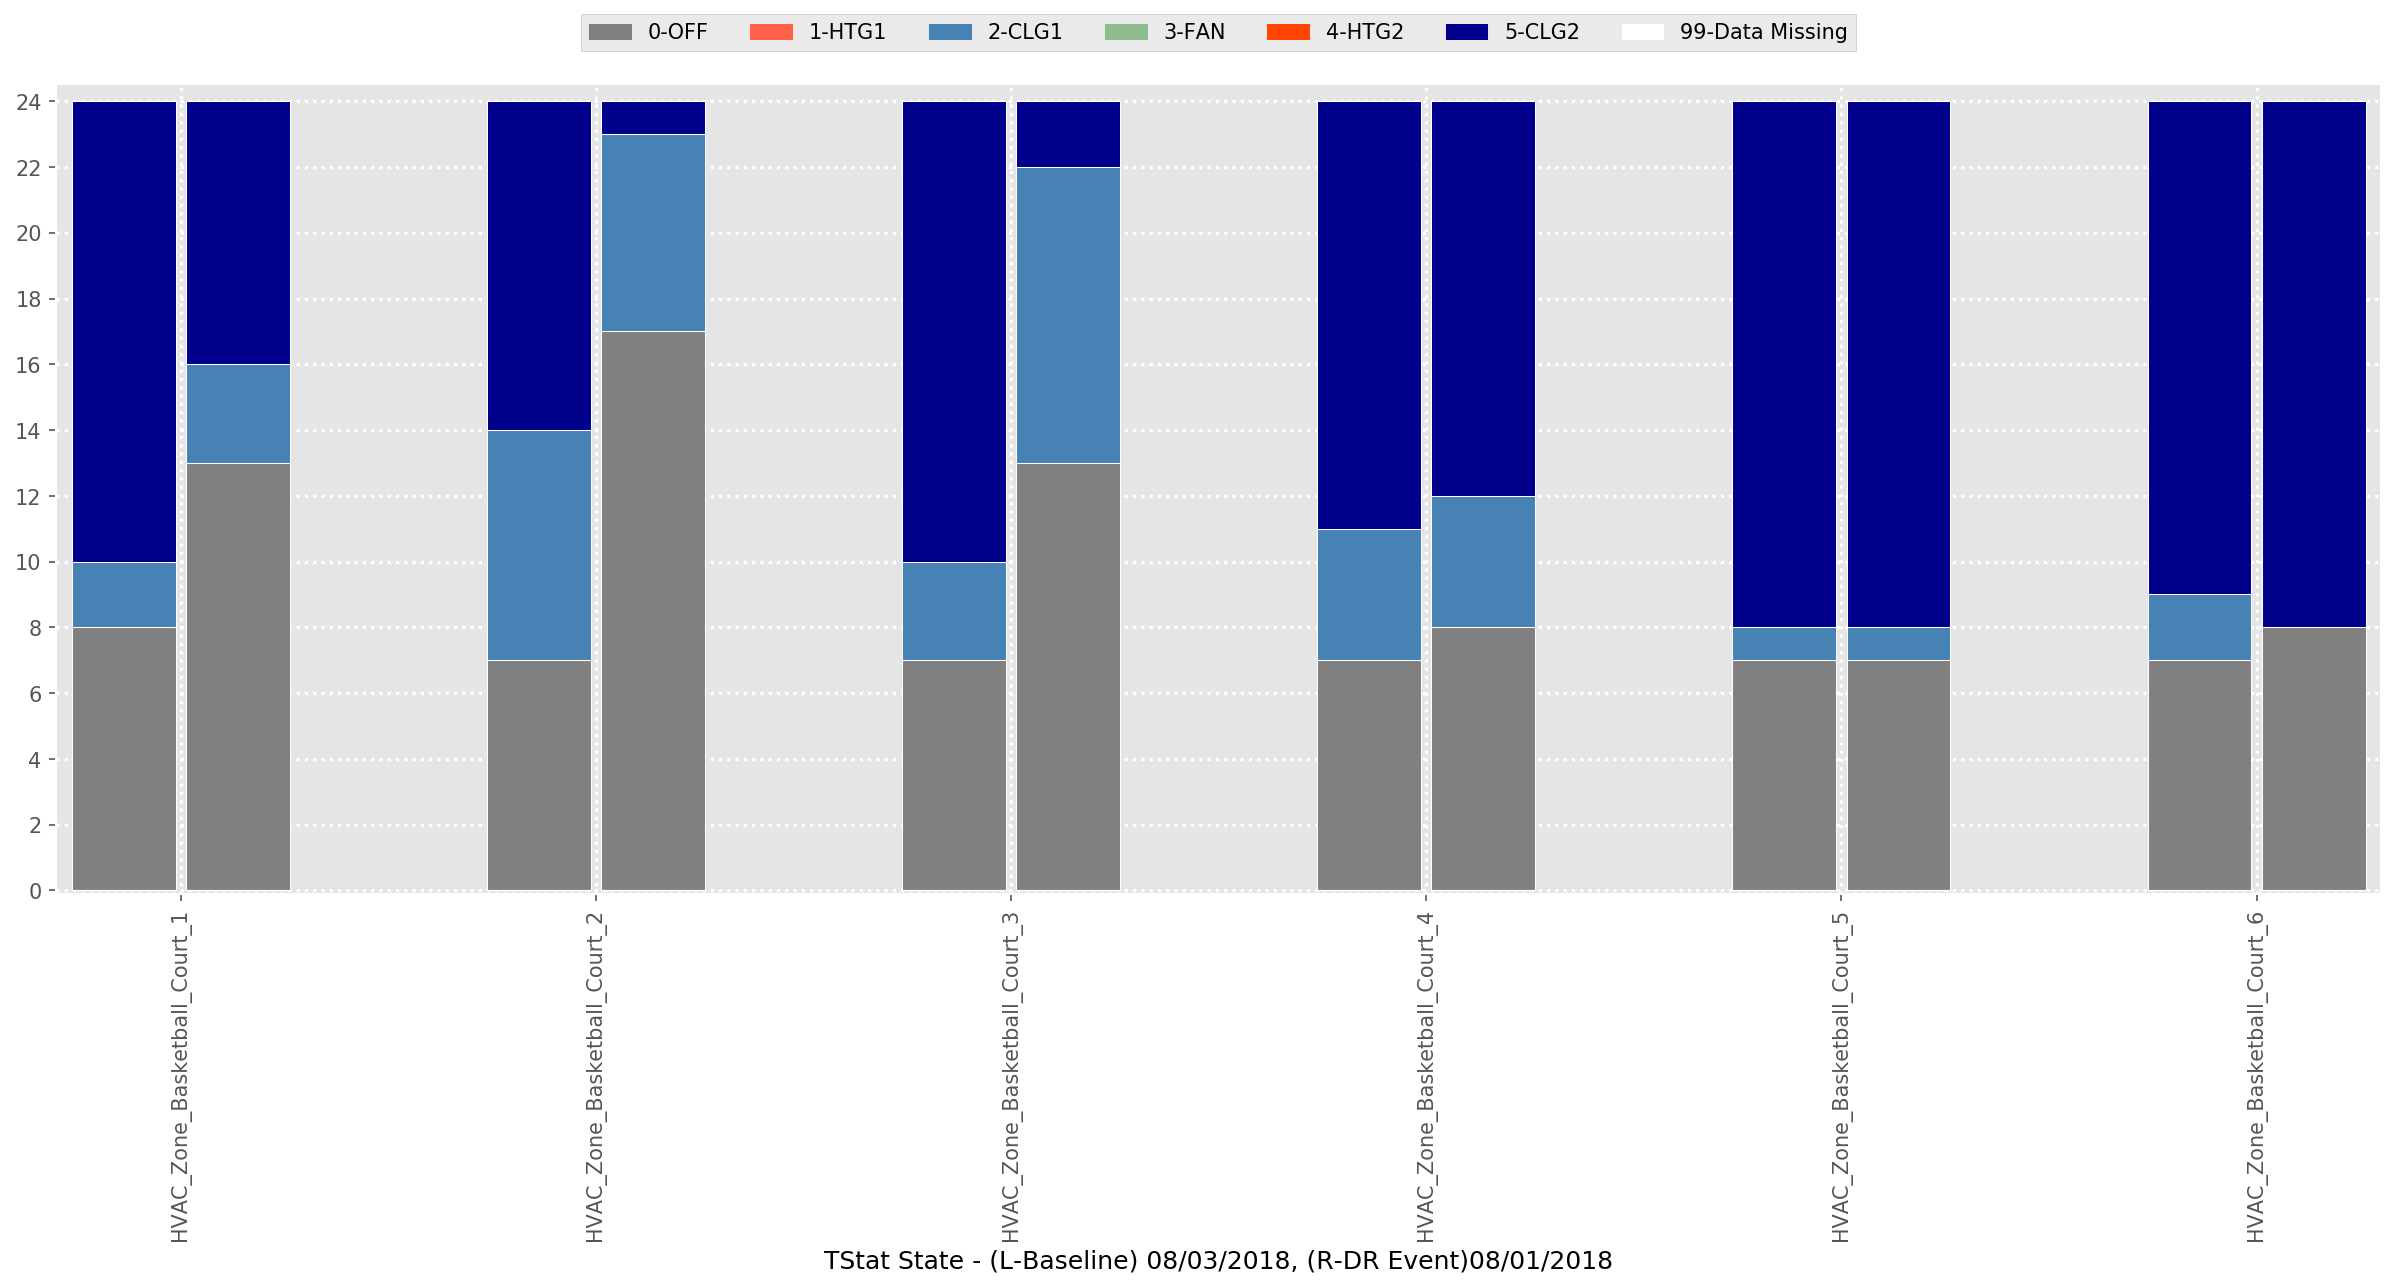

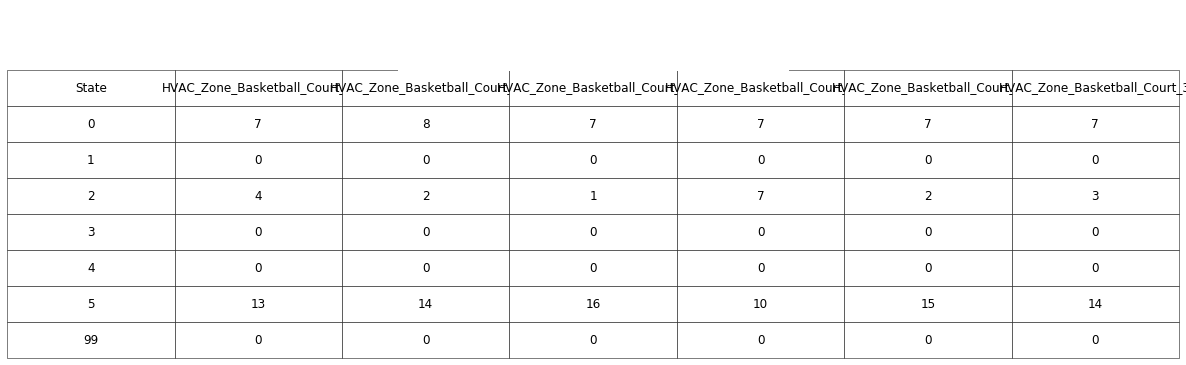

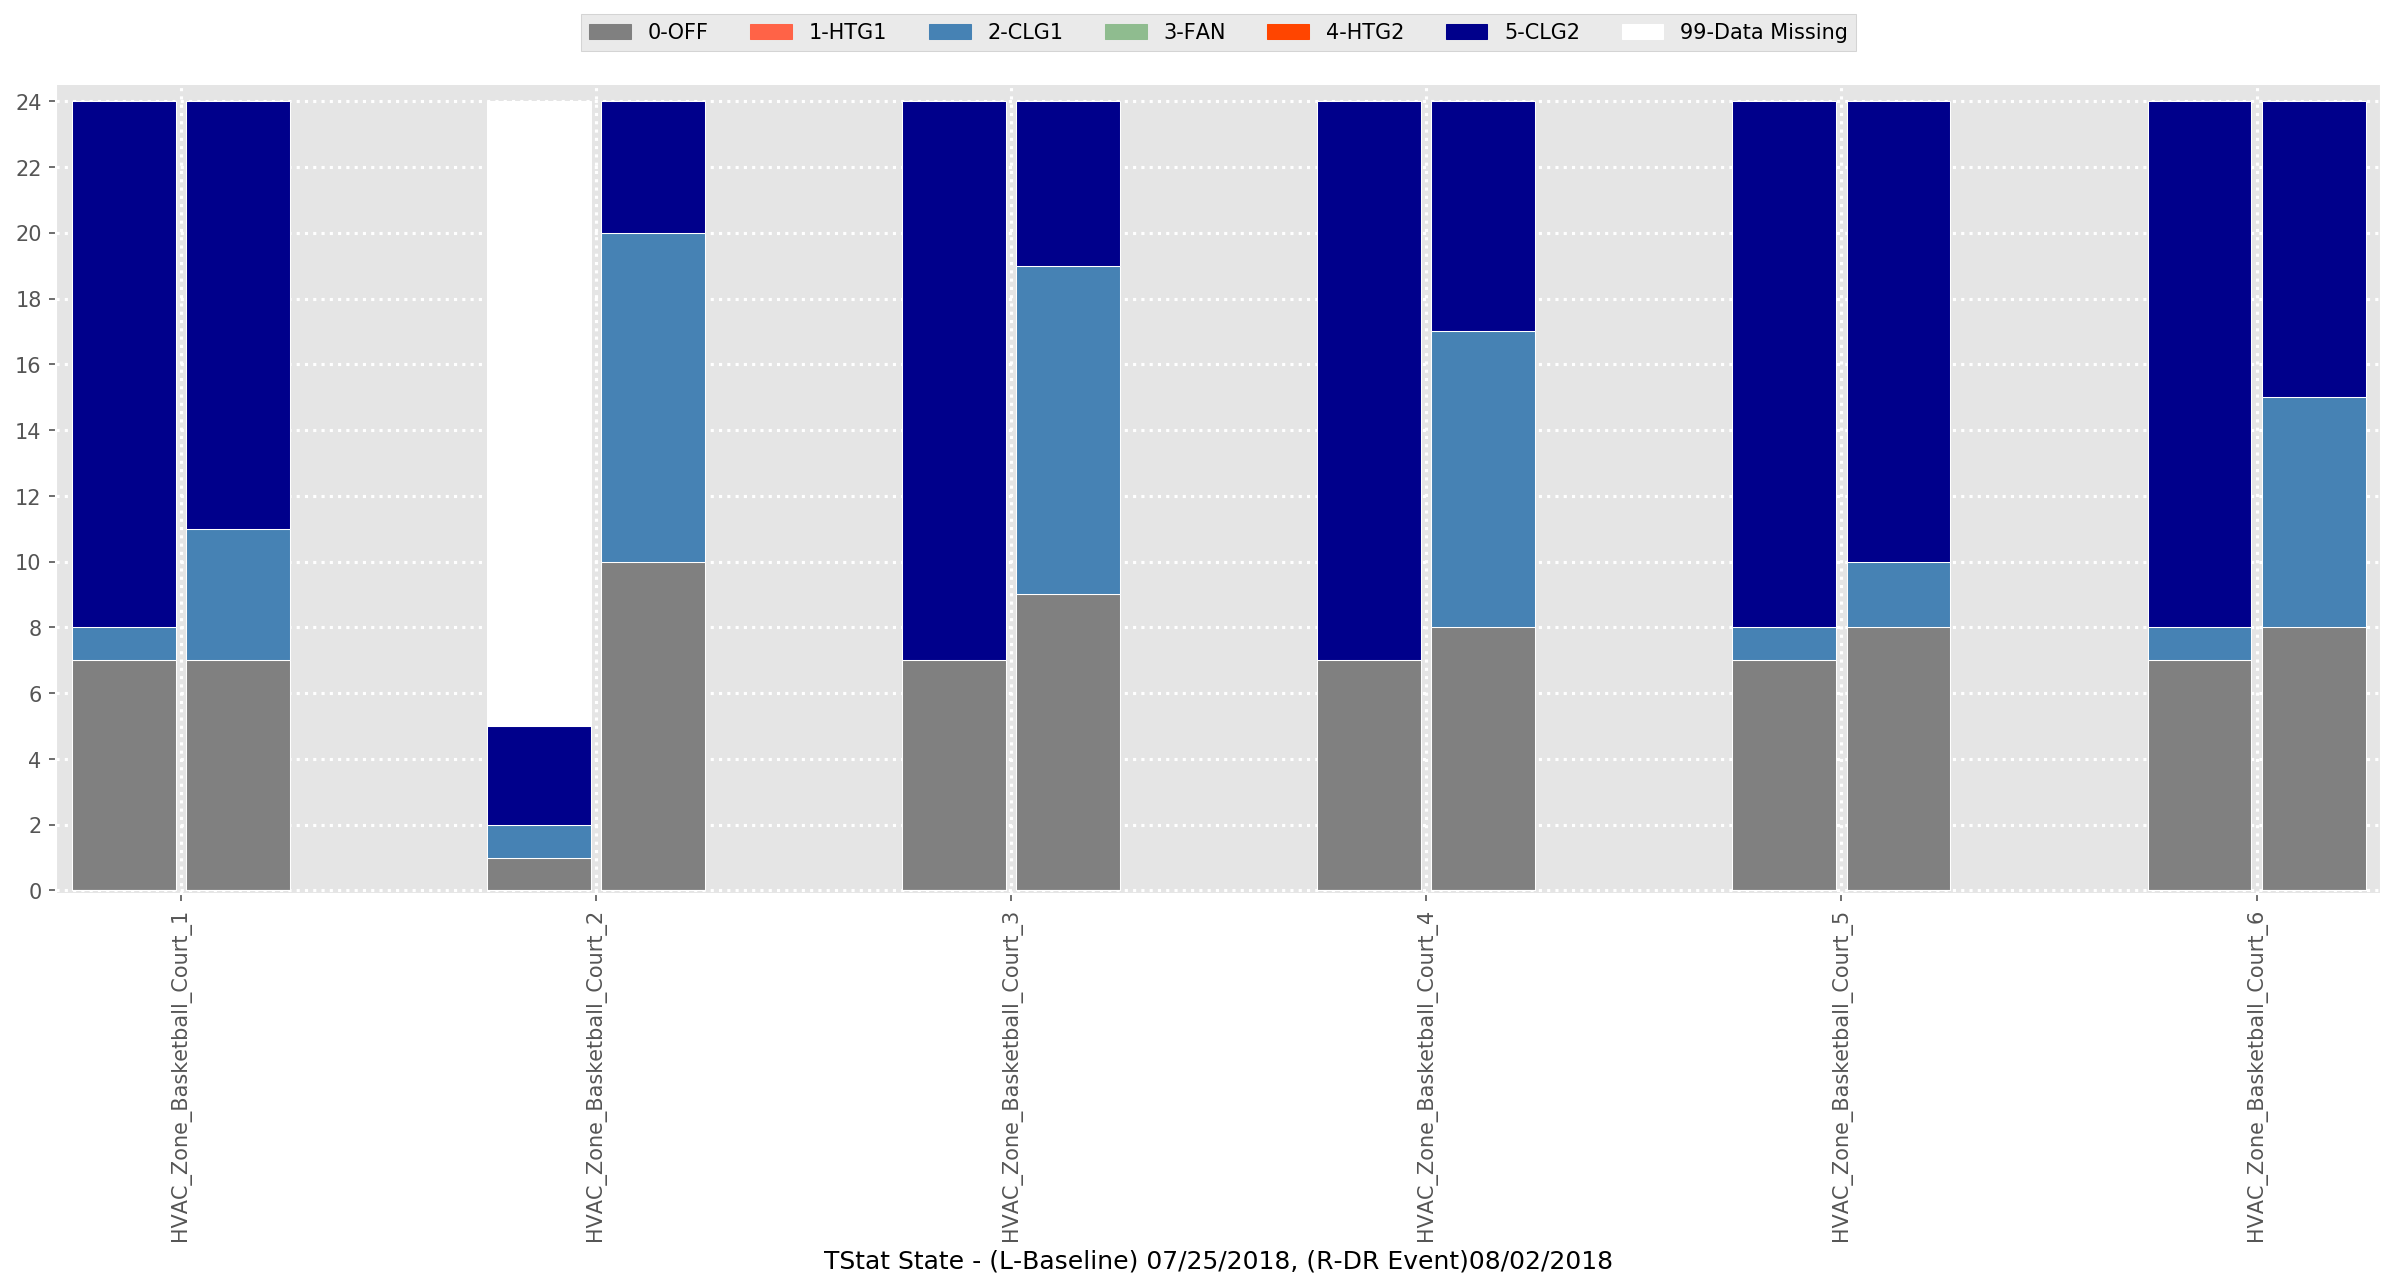

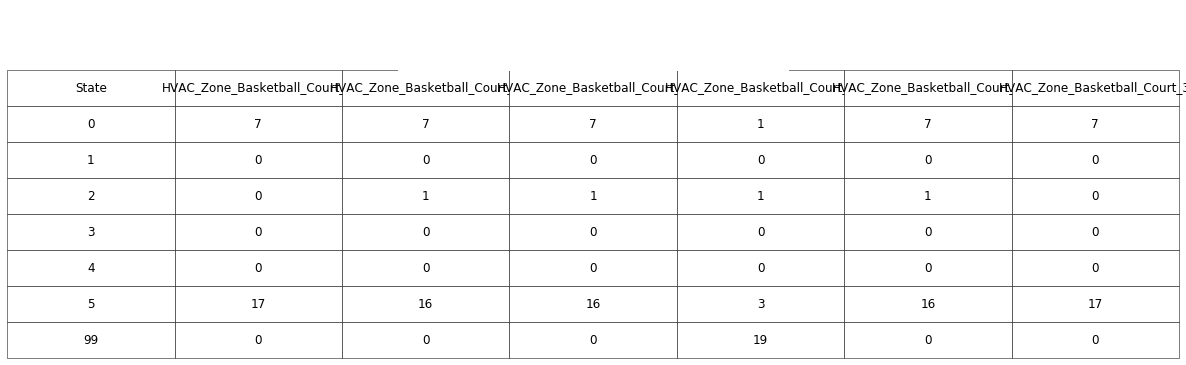

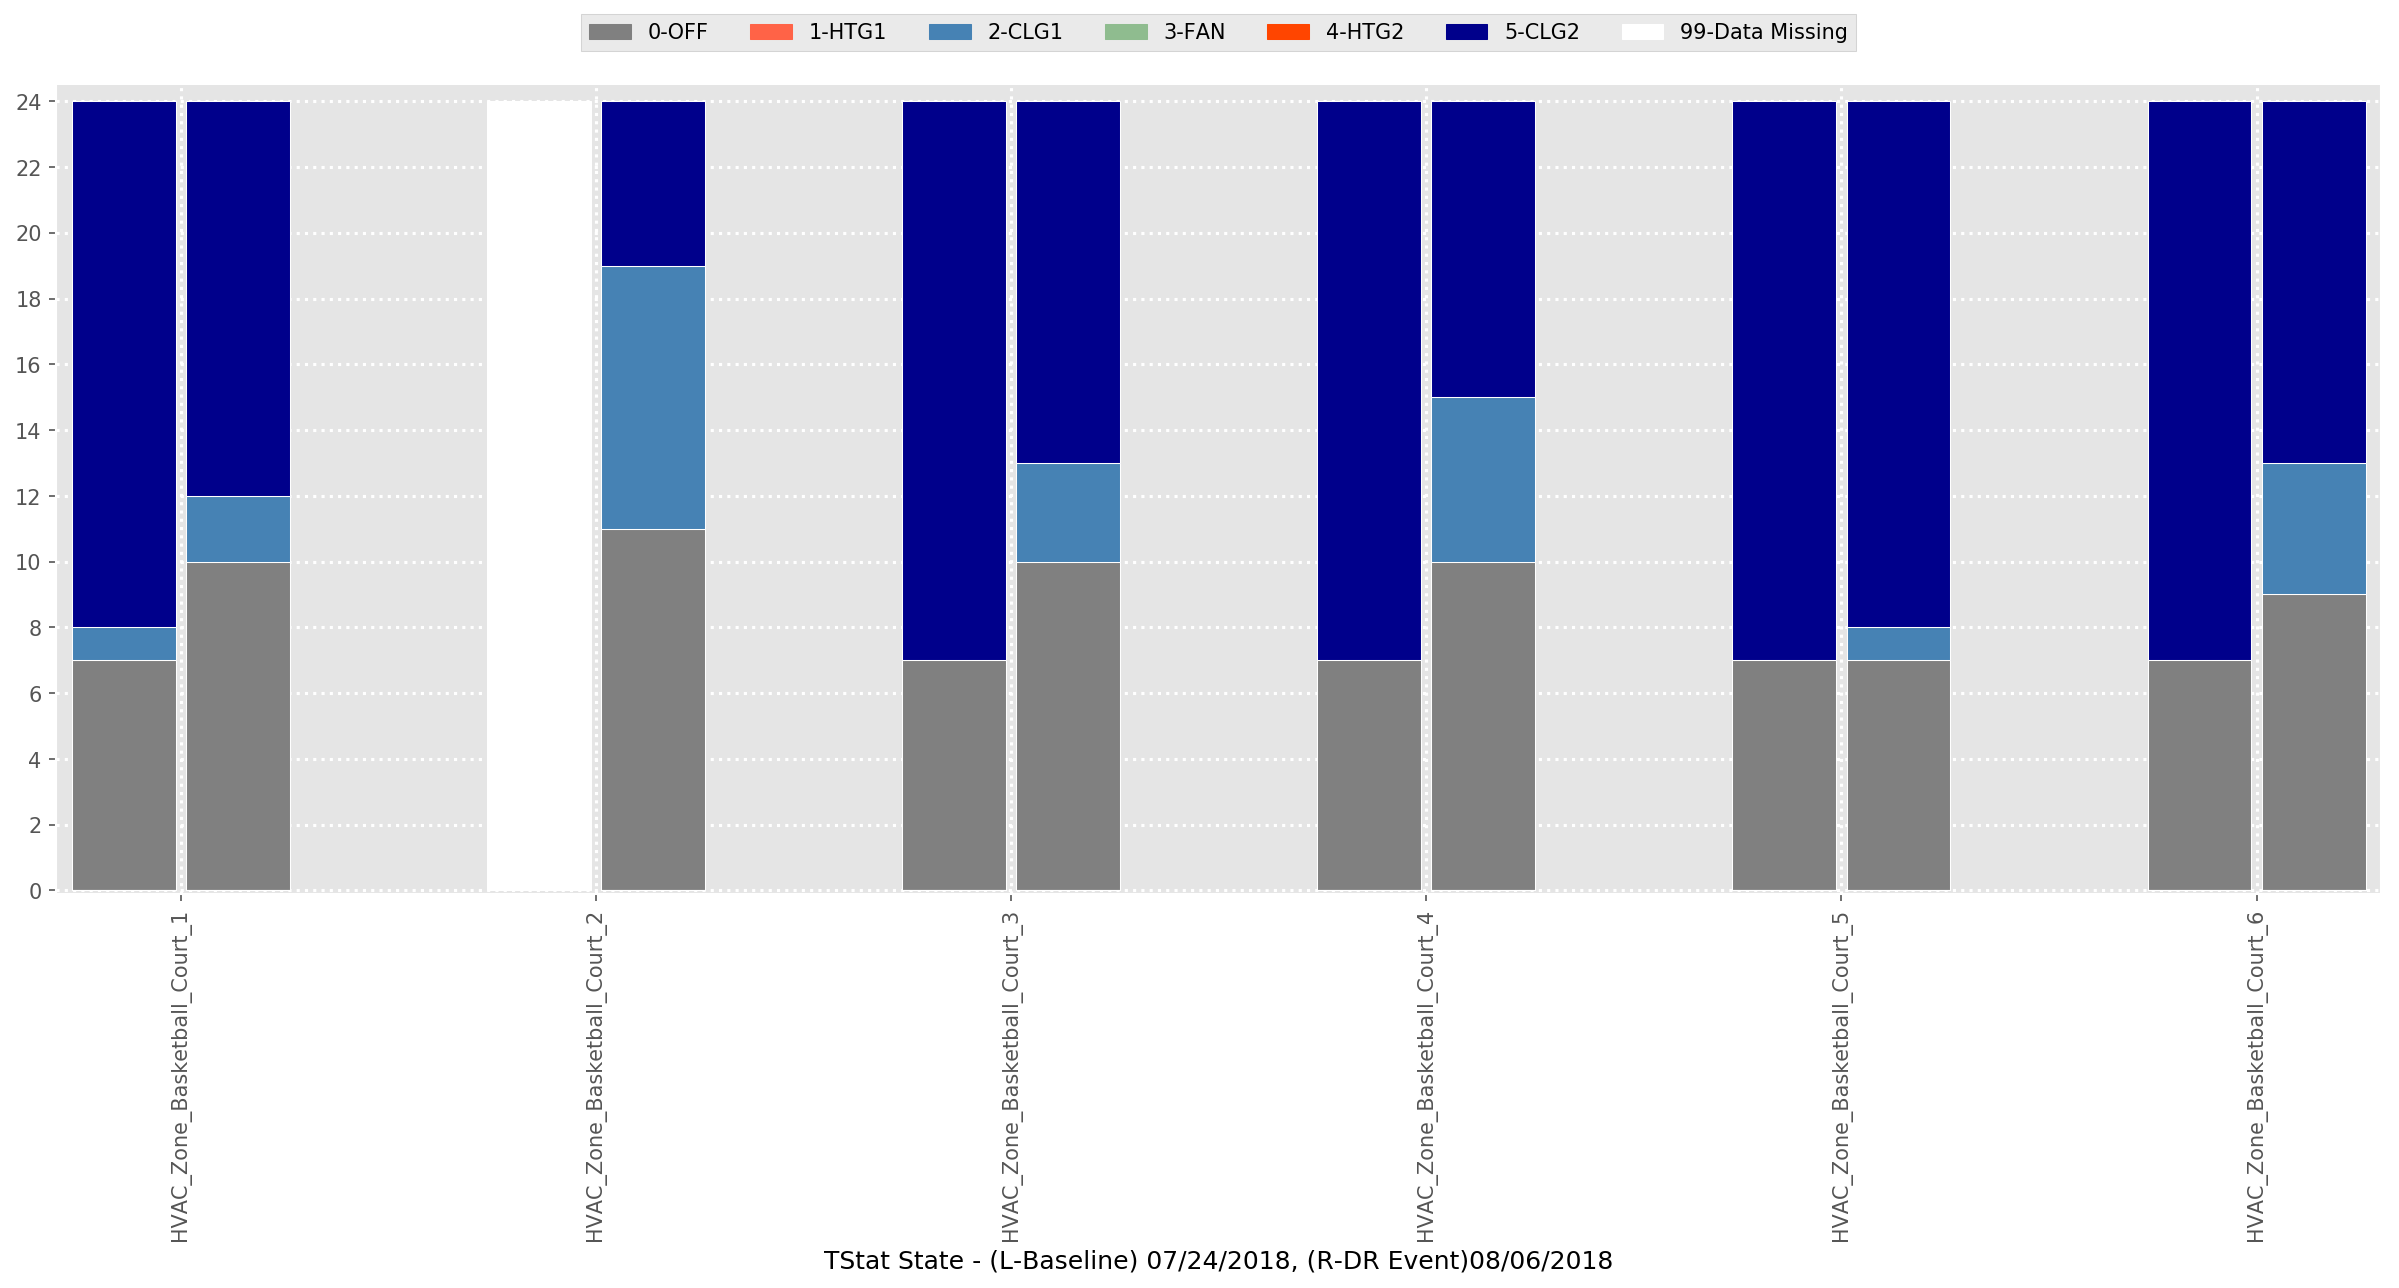

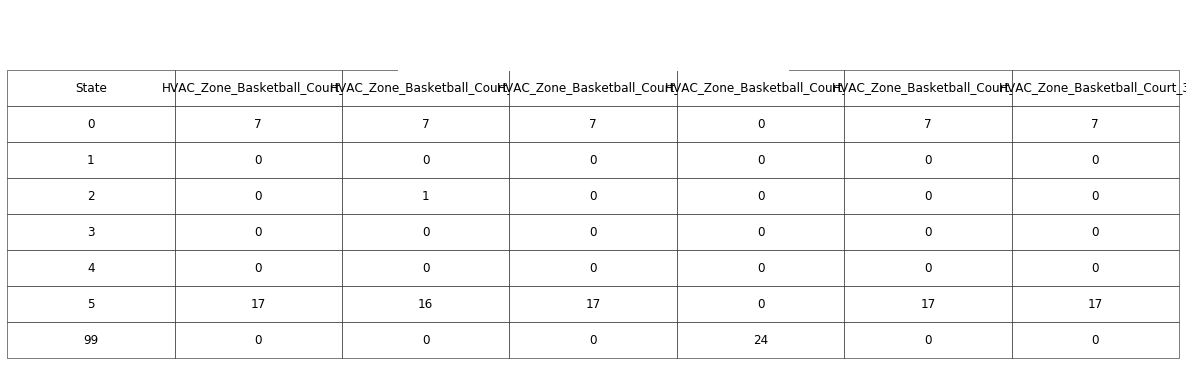

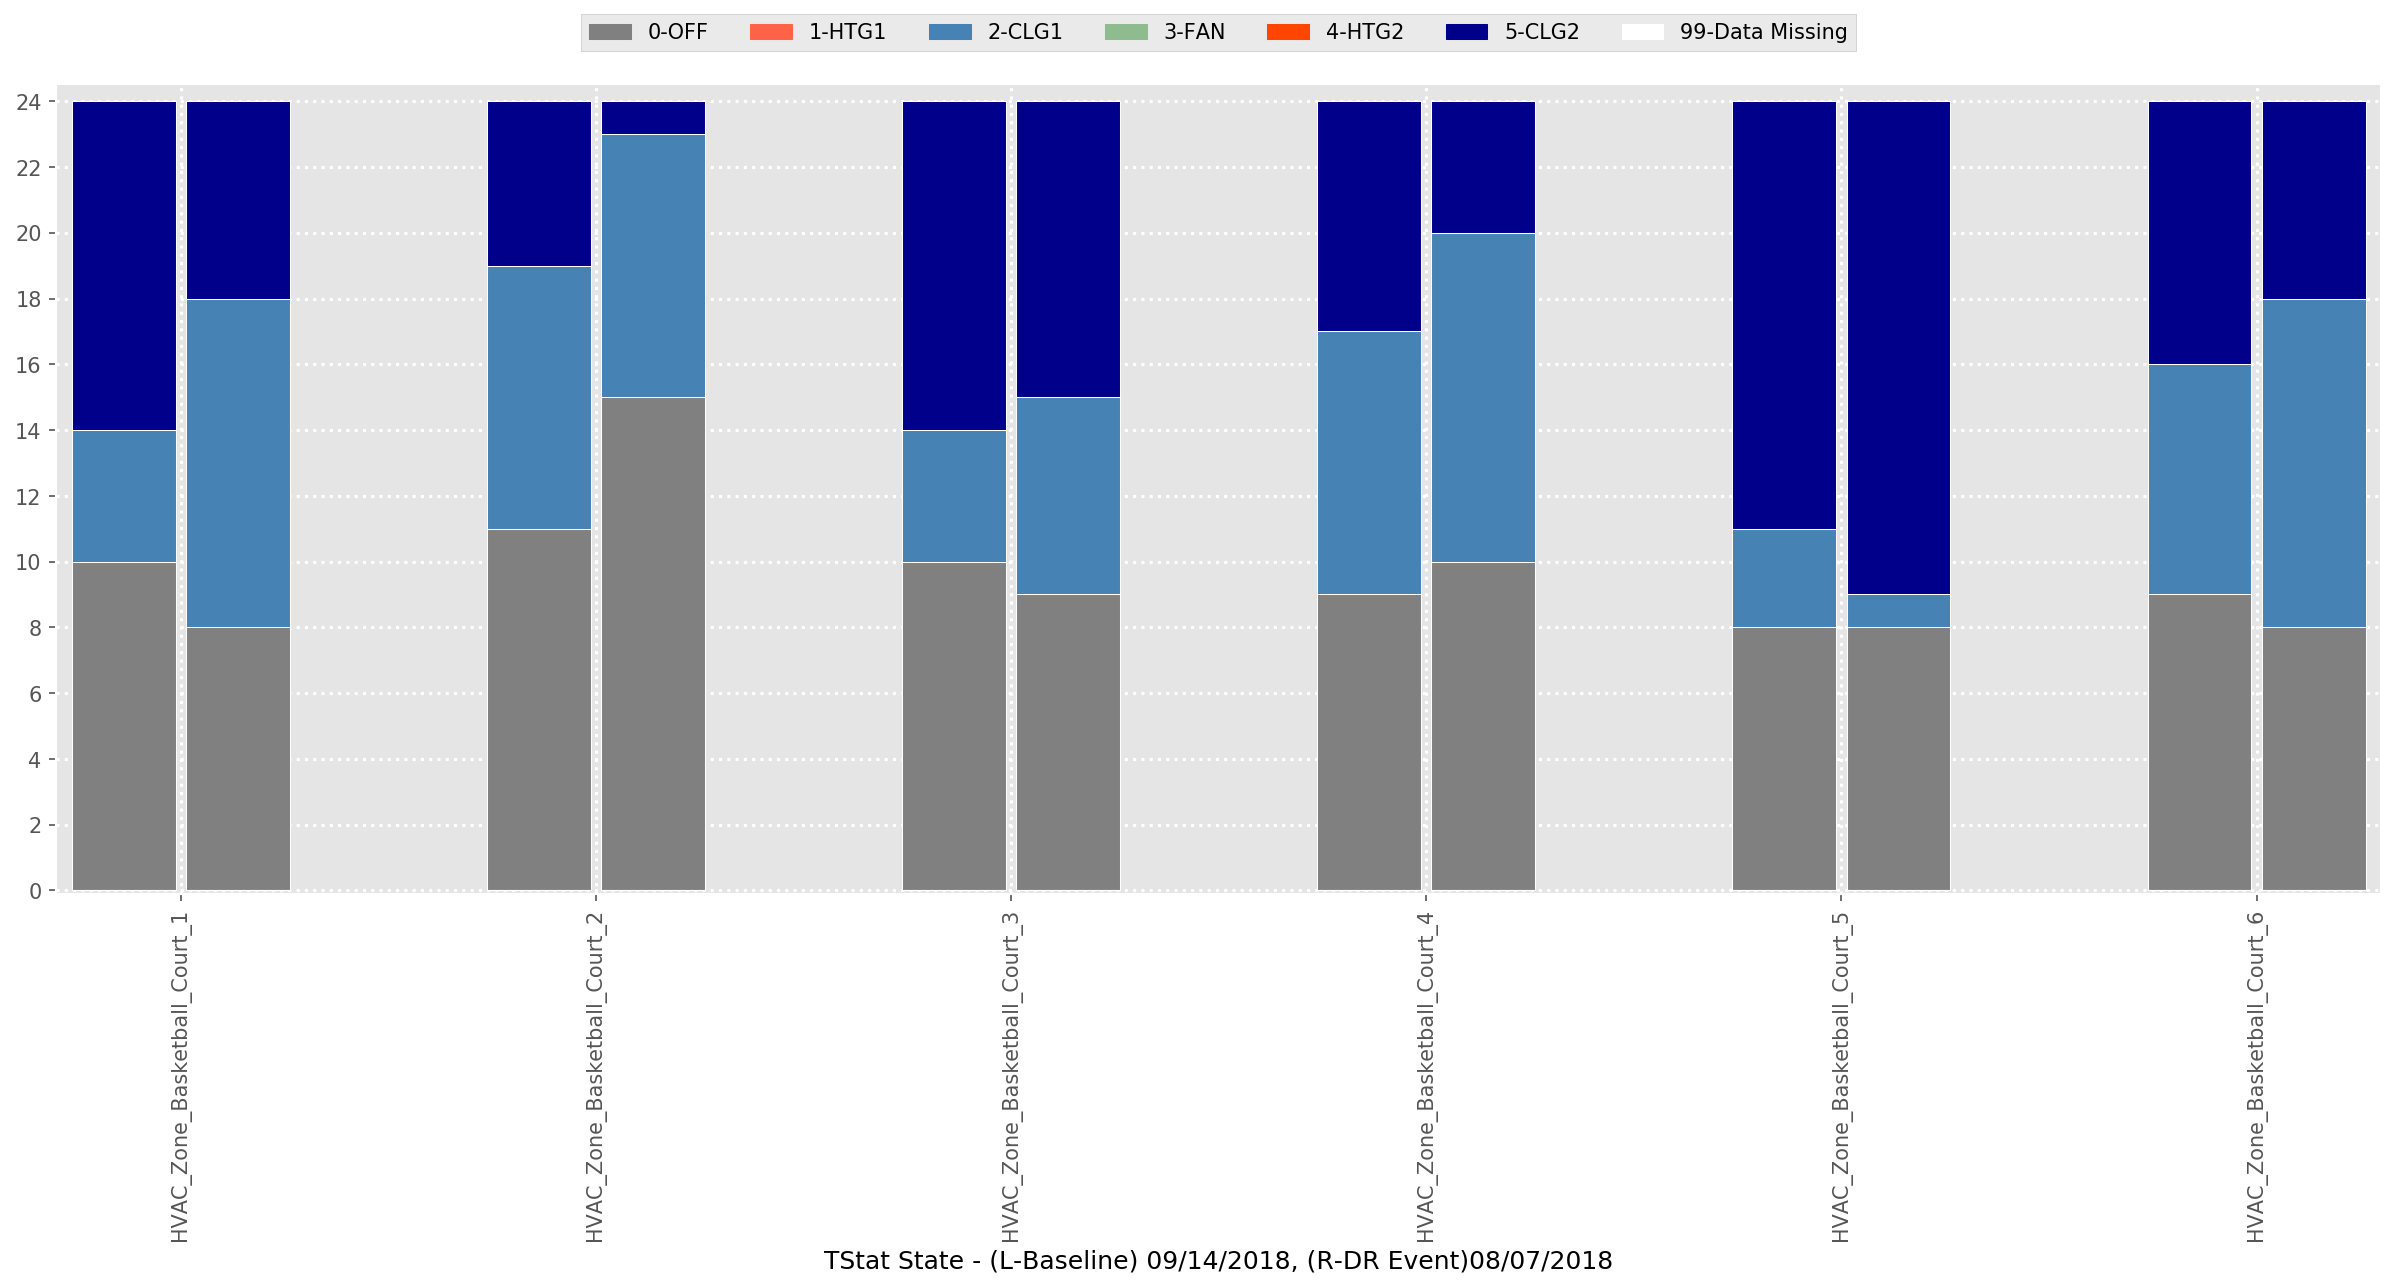

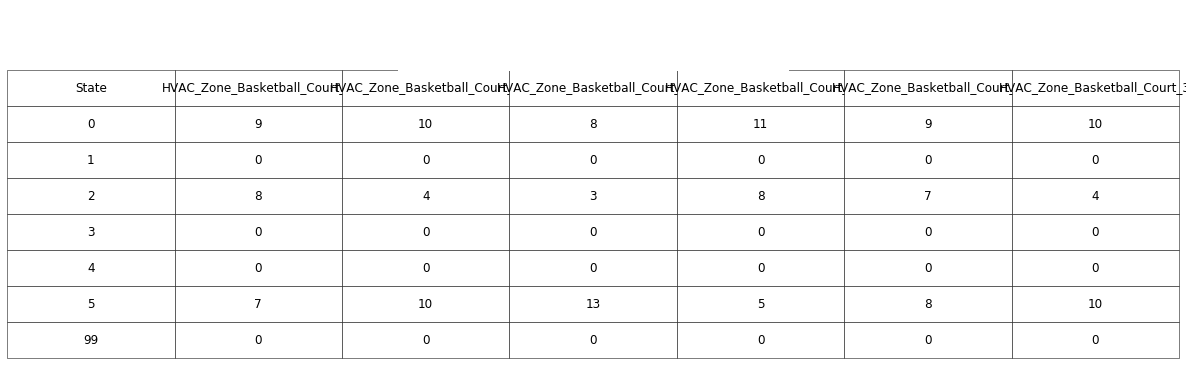

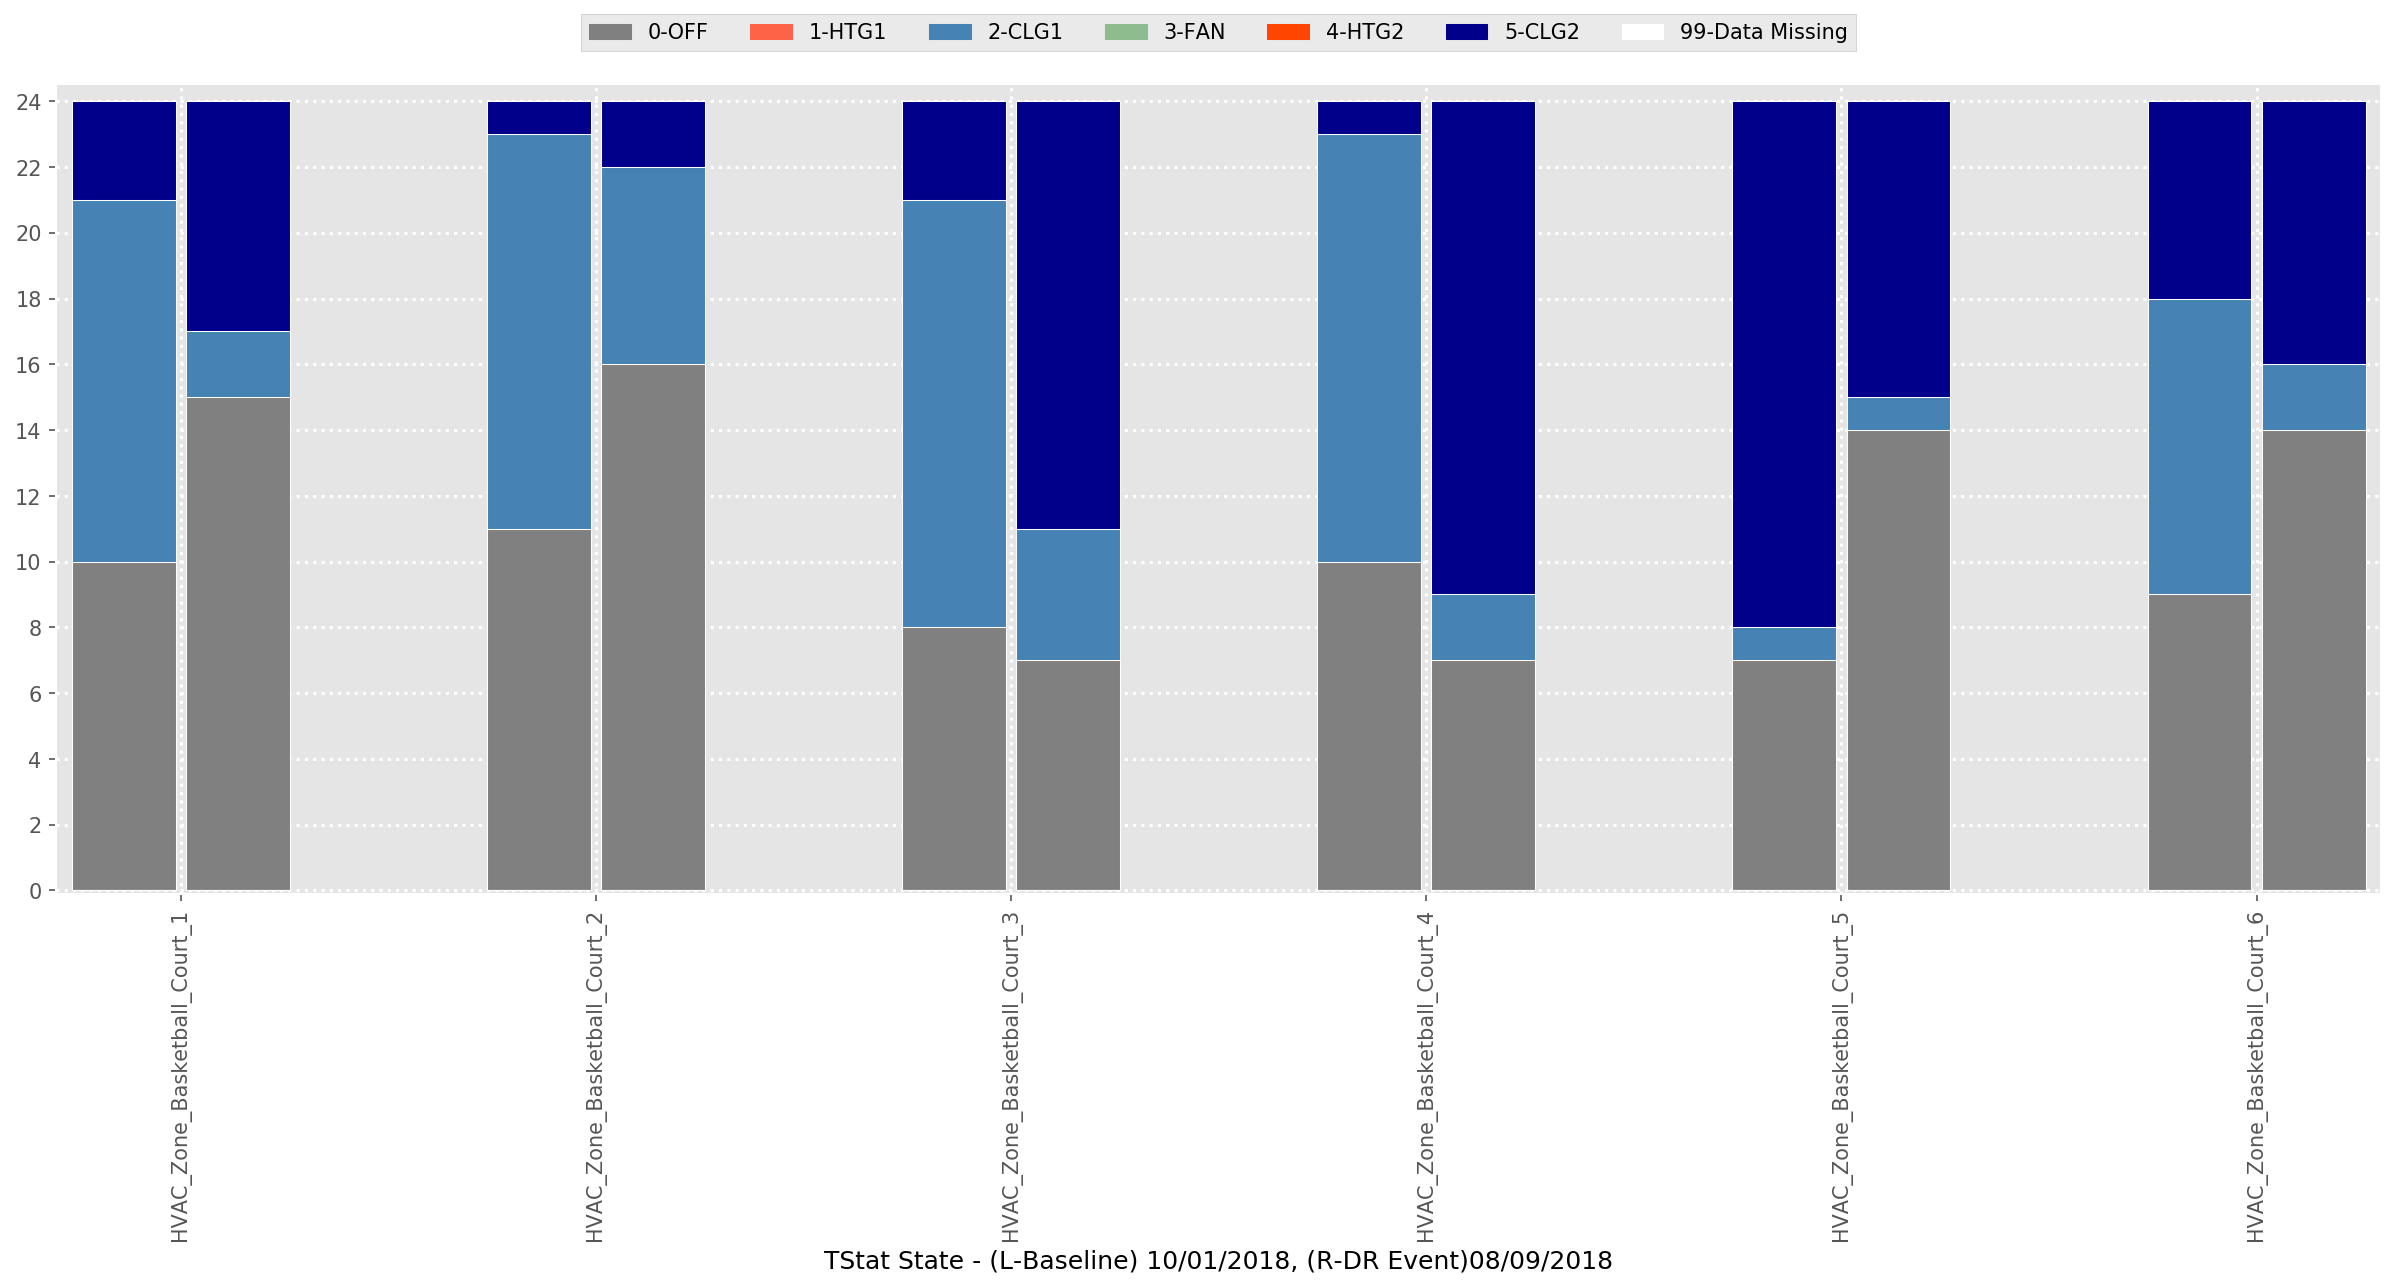

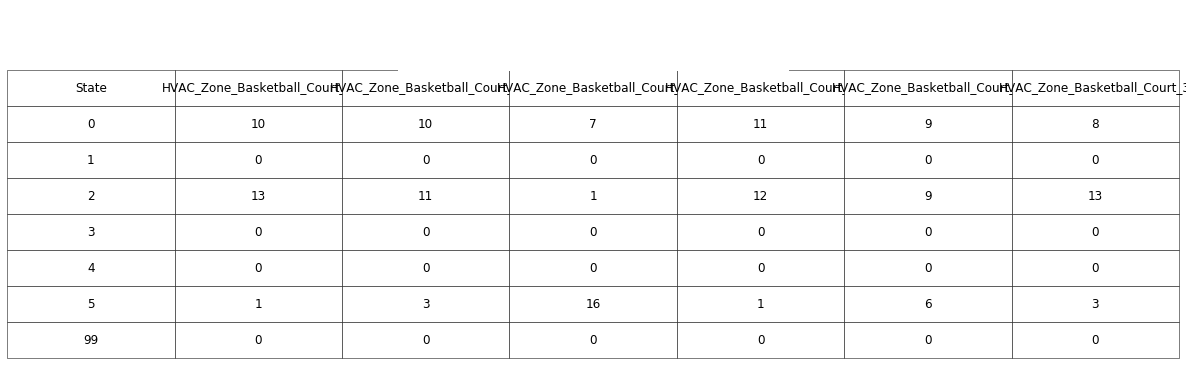

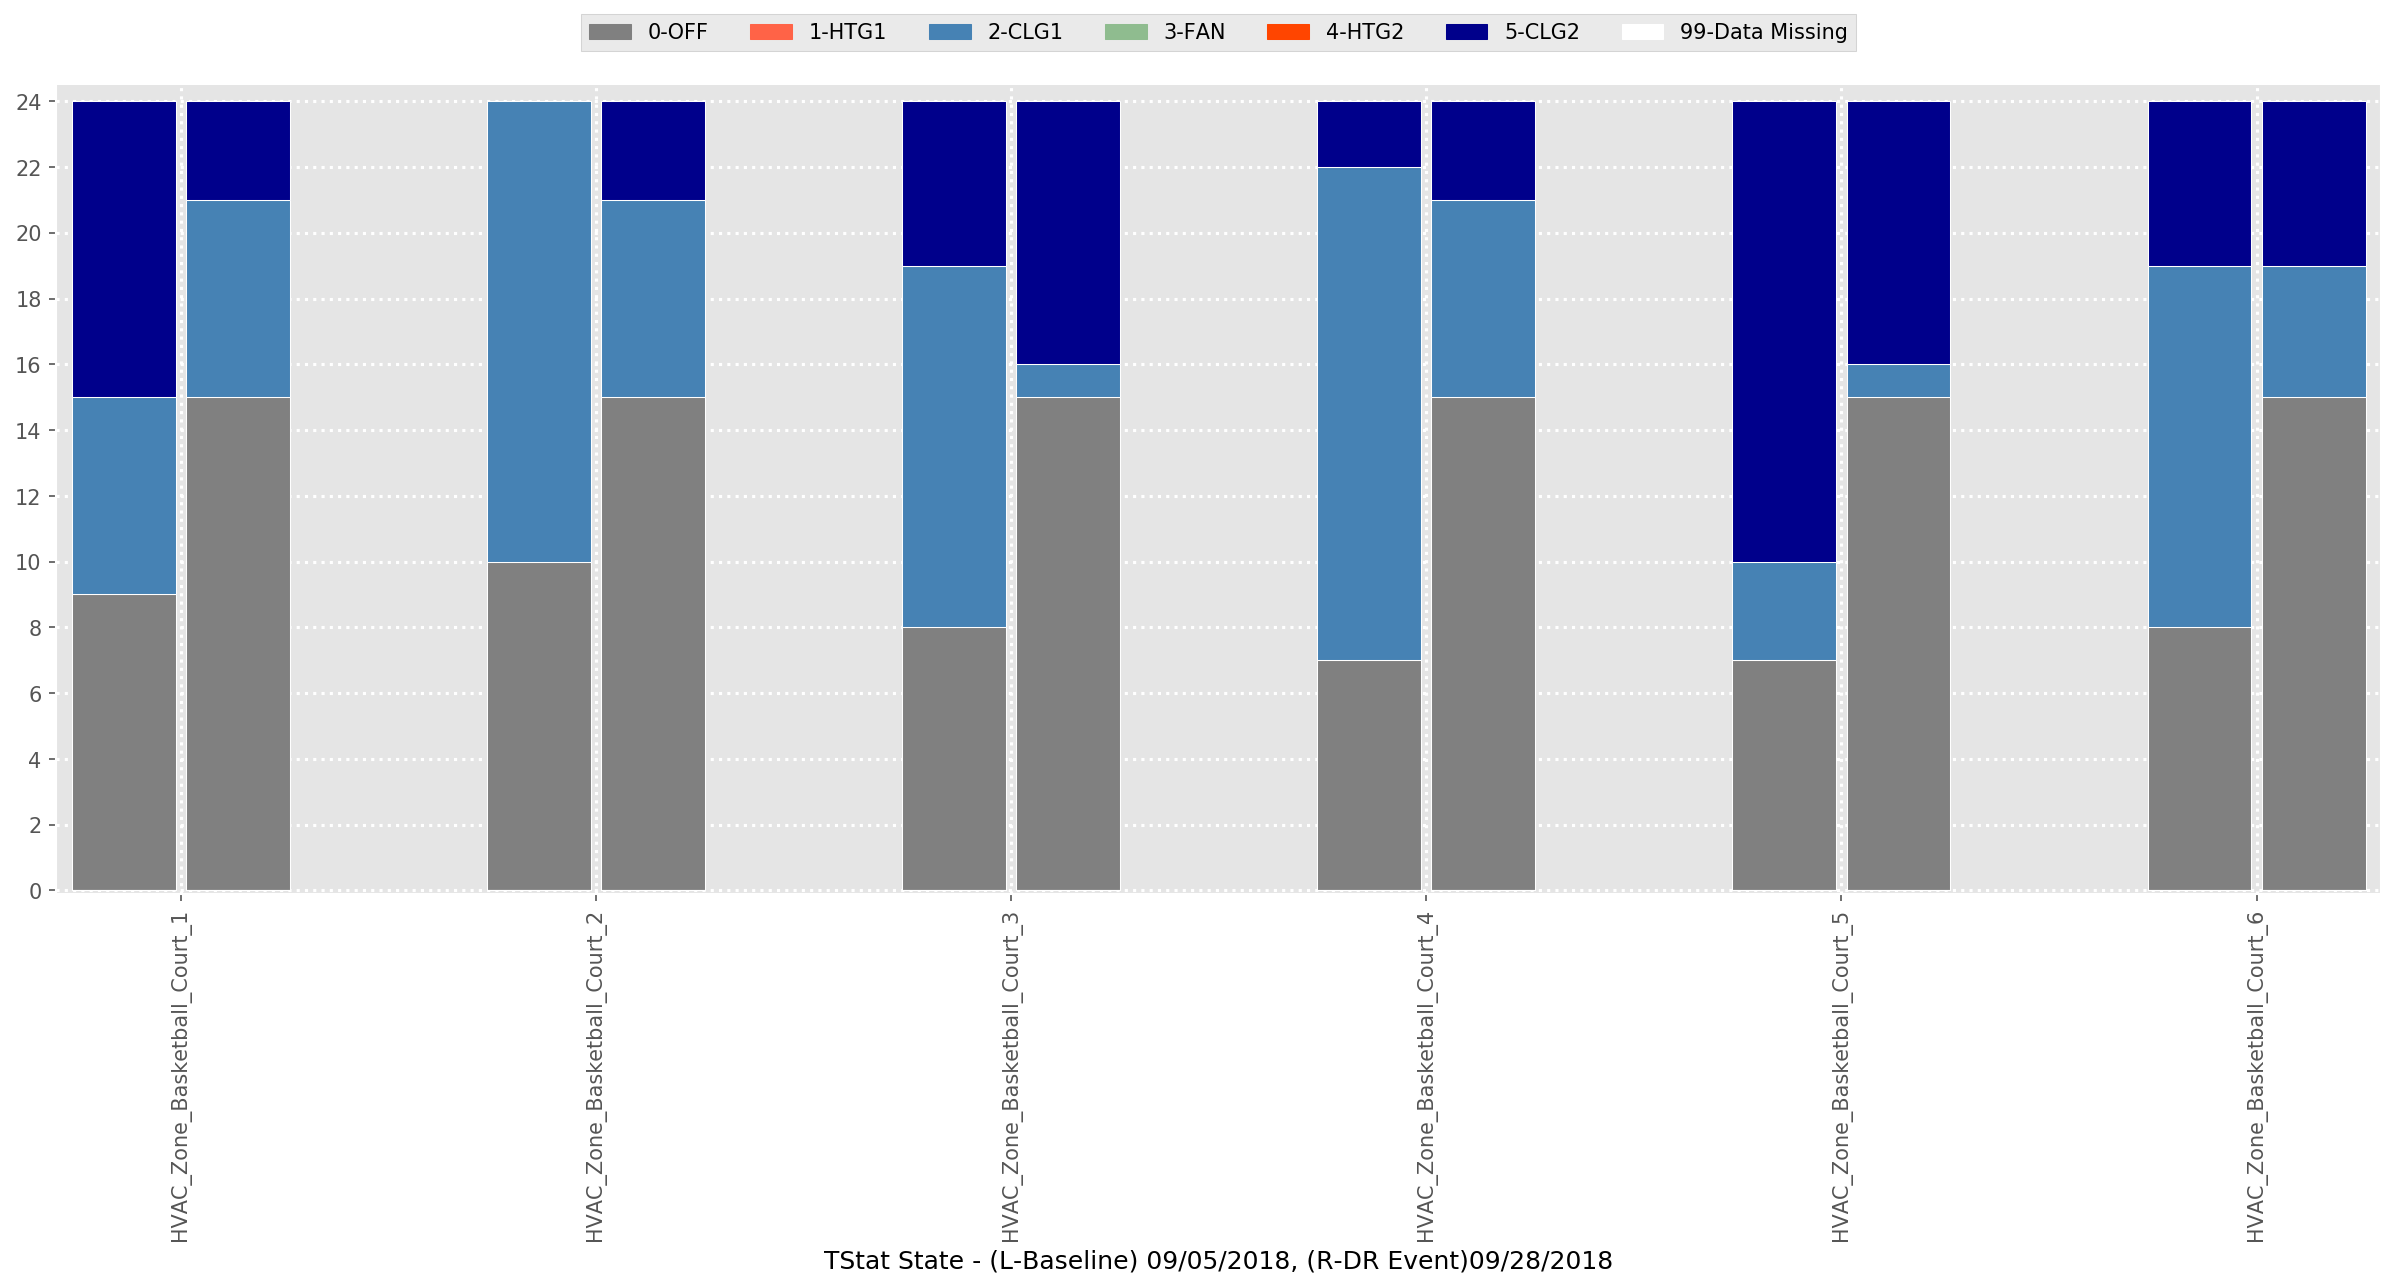

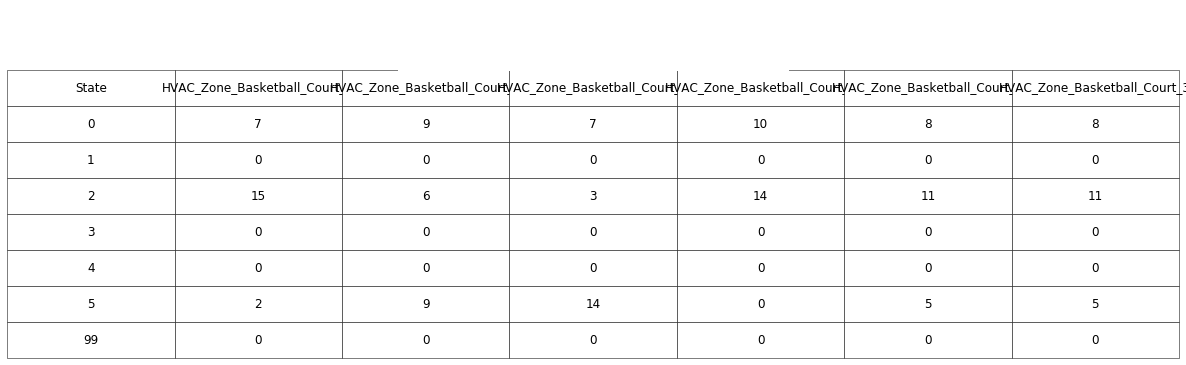

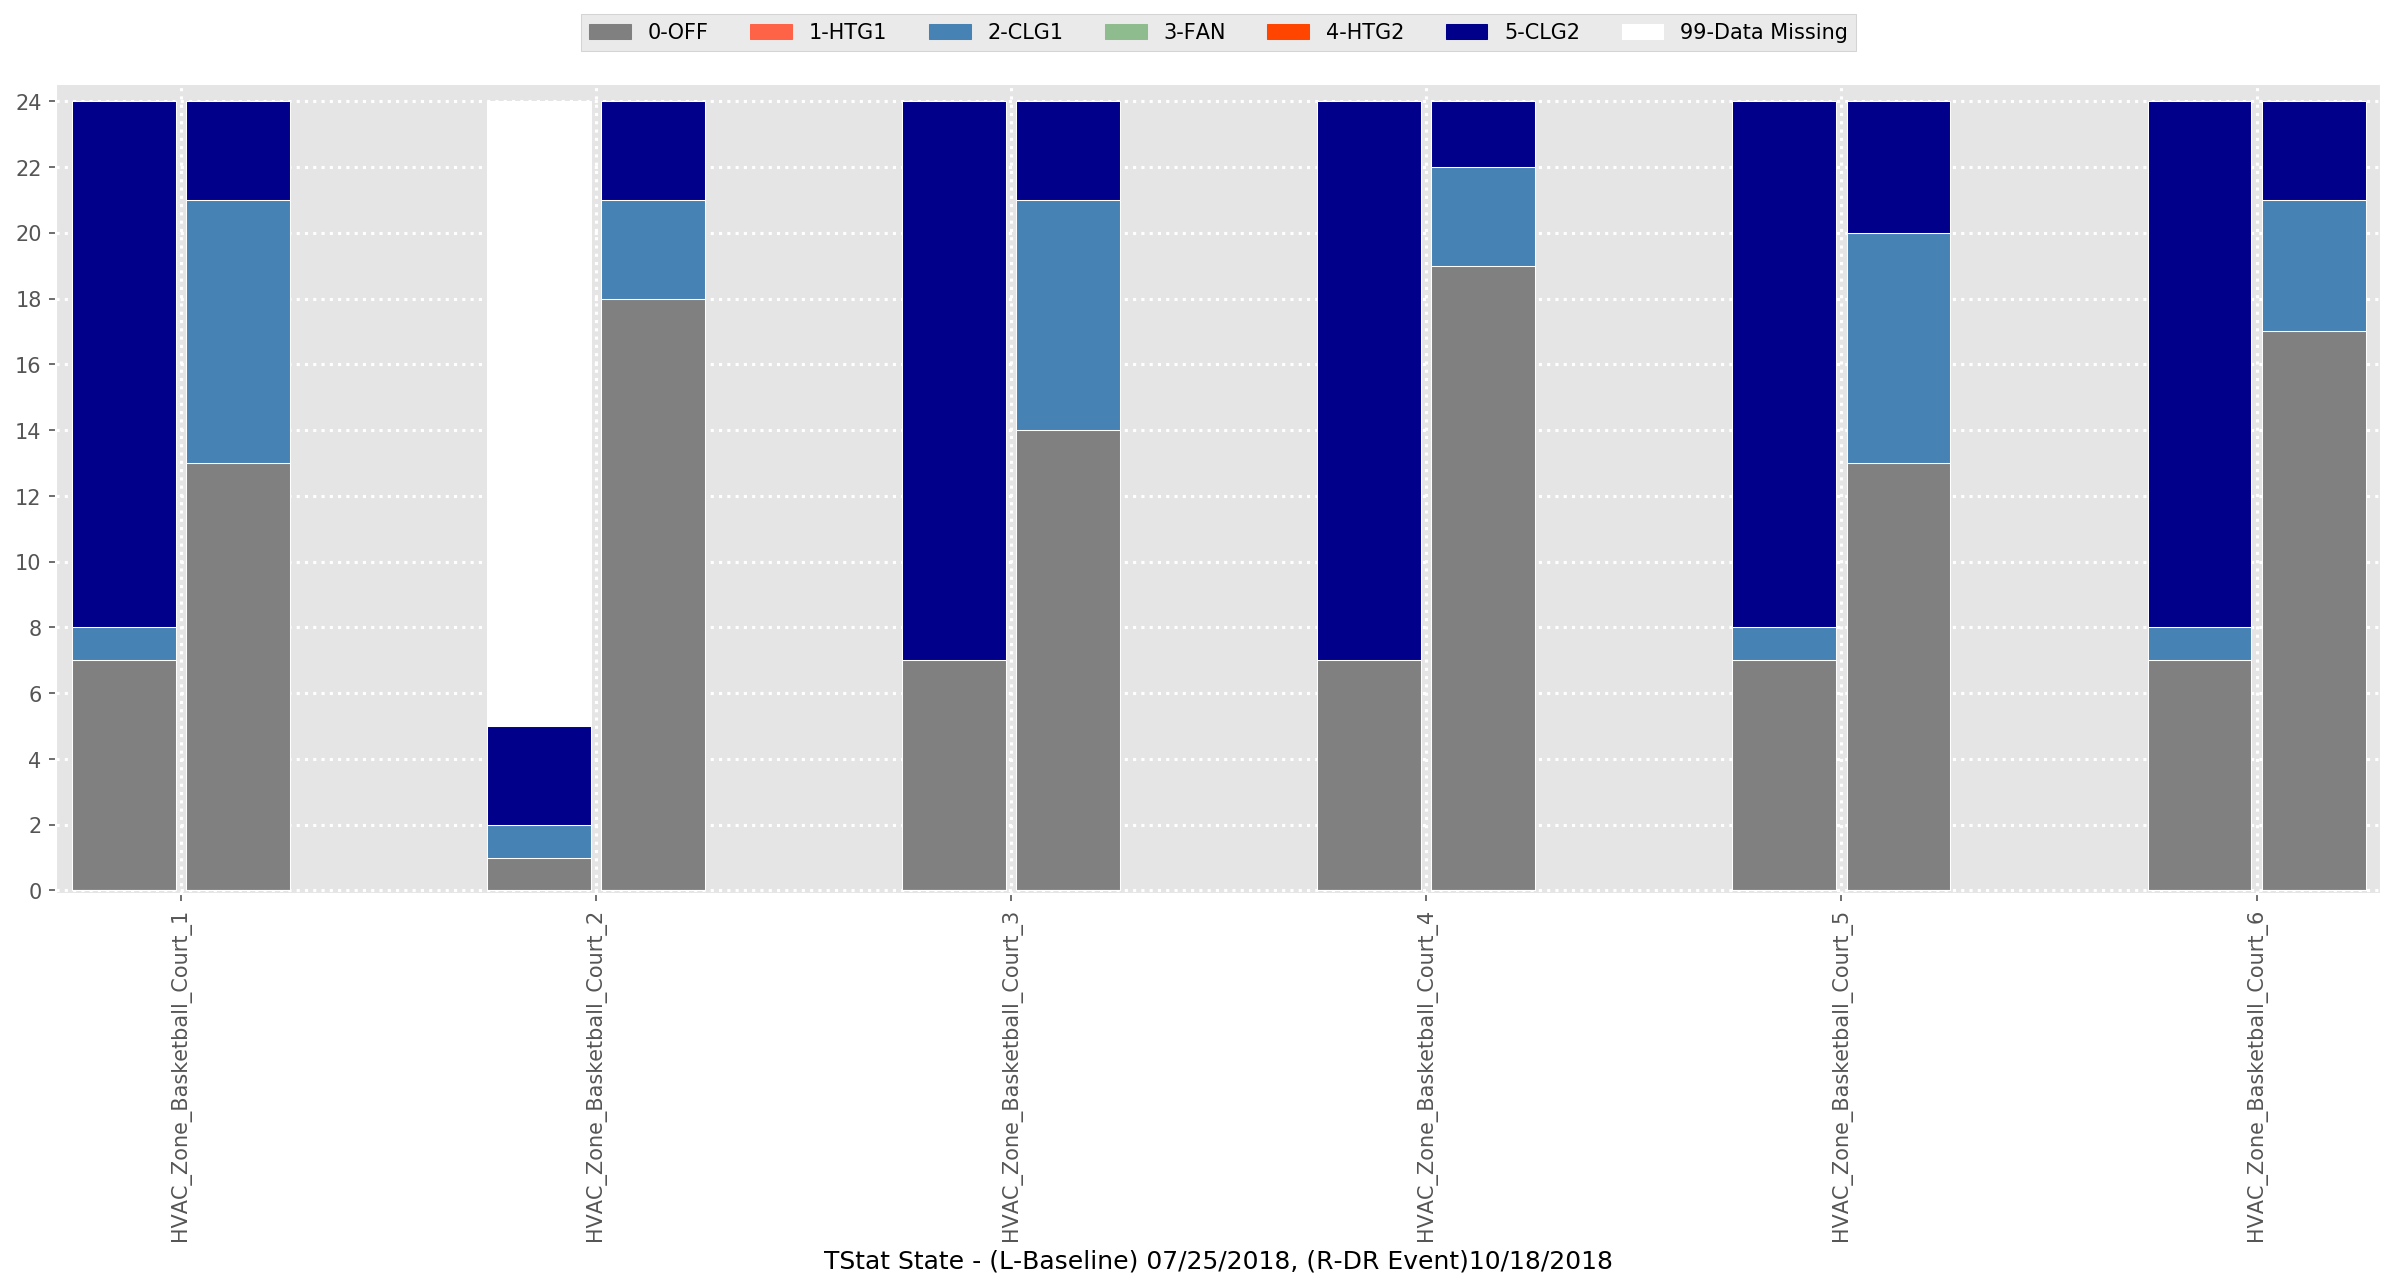

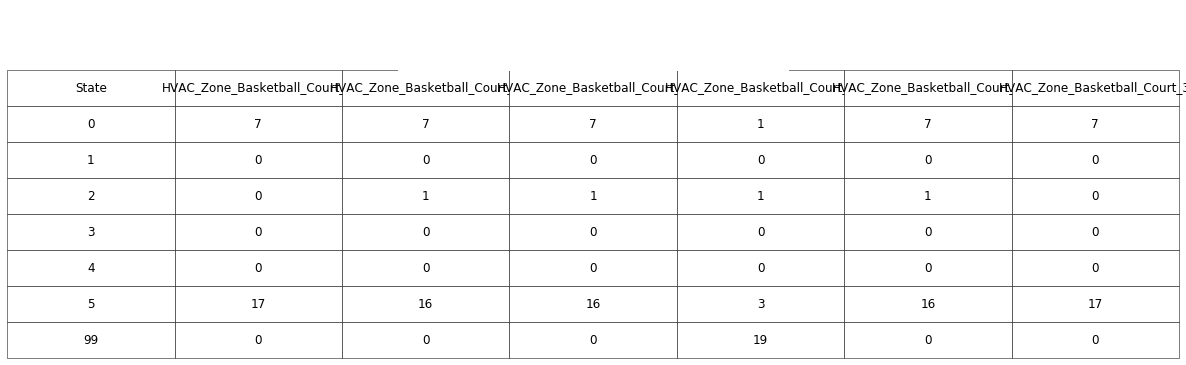

In [13]:
#PLOT all SCE
plot_all_events_buildings(SCE_CPP,SCE_SITES)

2018-06-12 00:00:00 PDT 2018-06-13 00:00:00 PDT
south-berkeley-senior-center 06/12/2018 73.04000000000002 2018-08-29 16:00:00-07:00 73.04000000000002
2018-06-13 00:00:00 PDT 2018-06-14 00:00:00 PDT
south-berkeley-senior-center 06/13/2018 71.9600000000001 2018-07-13 15:00:00-07:00 71.9600000000001
2018-07-10 00:00:00 PDT 2018-07-11 00:00:00 PDT
south-berkeley-senior-center 07/10/2018 75.02000000000007 2018-07-09 15:00:00-07:00 75.02000000000007
2018-07-16 00:00:00 PDT 2018-07-17 00:00:00 PDT
south-berkeley-senior-center 07/16/2018 69.08000000000004 2018-06-25 15:00:00-07:00 69.08000000000004
2018-07-17 00:00:00 PDT 2018-07-18 00:00:00 PDT
south-berkeley-senior-center 07/17/2018 68.0 2018-08-23 18:00:00-07:00 68.0
2018-07-19 00:00:00 PDT 2018-07-20 00:00:00 PDT
south-berkeley-senior-center 07/19/2018 69.08000000000004 2018-06-25 15:00:00-07:00 69.08000000000004
2018-07-24 00:00:00 PDT 2018-07-25 00:00:00 PDT
south-berkeley-senior-center 07/24/2018 69.75500000000005 2018-07-03 16:00:00-07

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Applications/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Applications/anaconda/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/Applications/anaconda/lib/python2.7/site-packages/bw2python/client.py", line 79, in _msgq_handler
    handler(item)
  File "/Applications/anaconda/lib/python2.7/site-packages/xbos/services/mdal.py", line 127, in _handleresult
    uuids = [str(uuid.UUID(bytes=x)) for x in data['Rows']]
TypeError: 'NoneType' object is not iterable



KeyError: 'df'

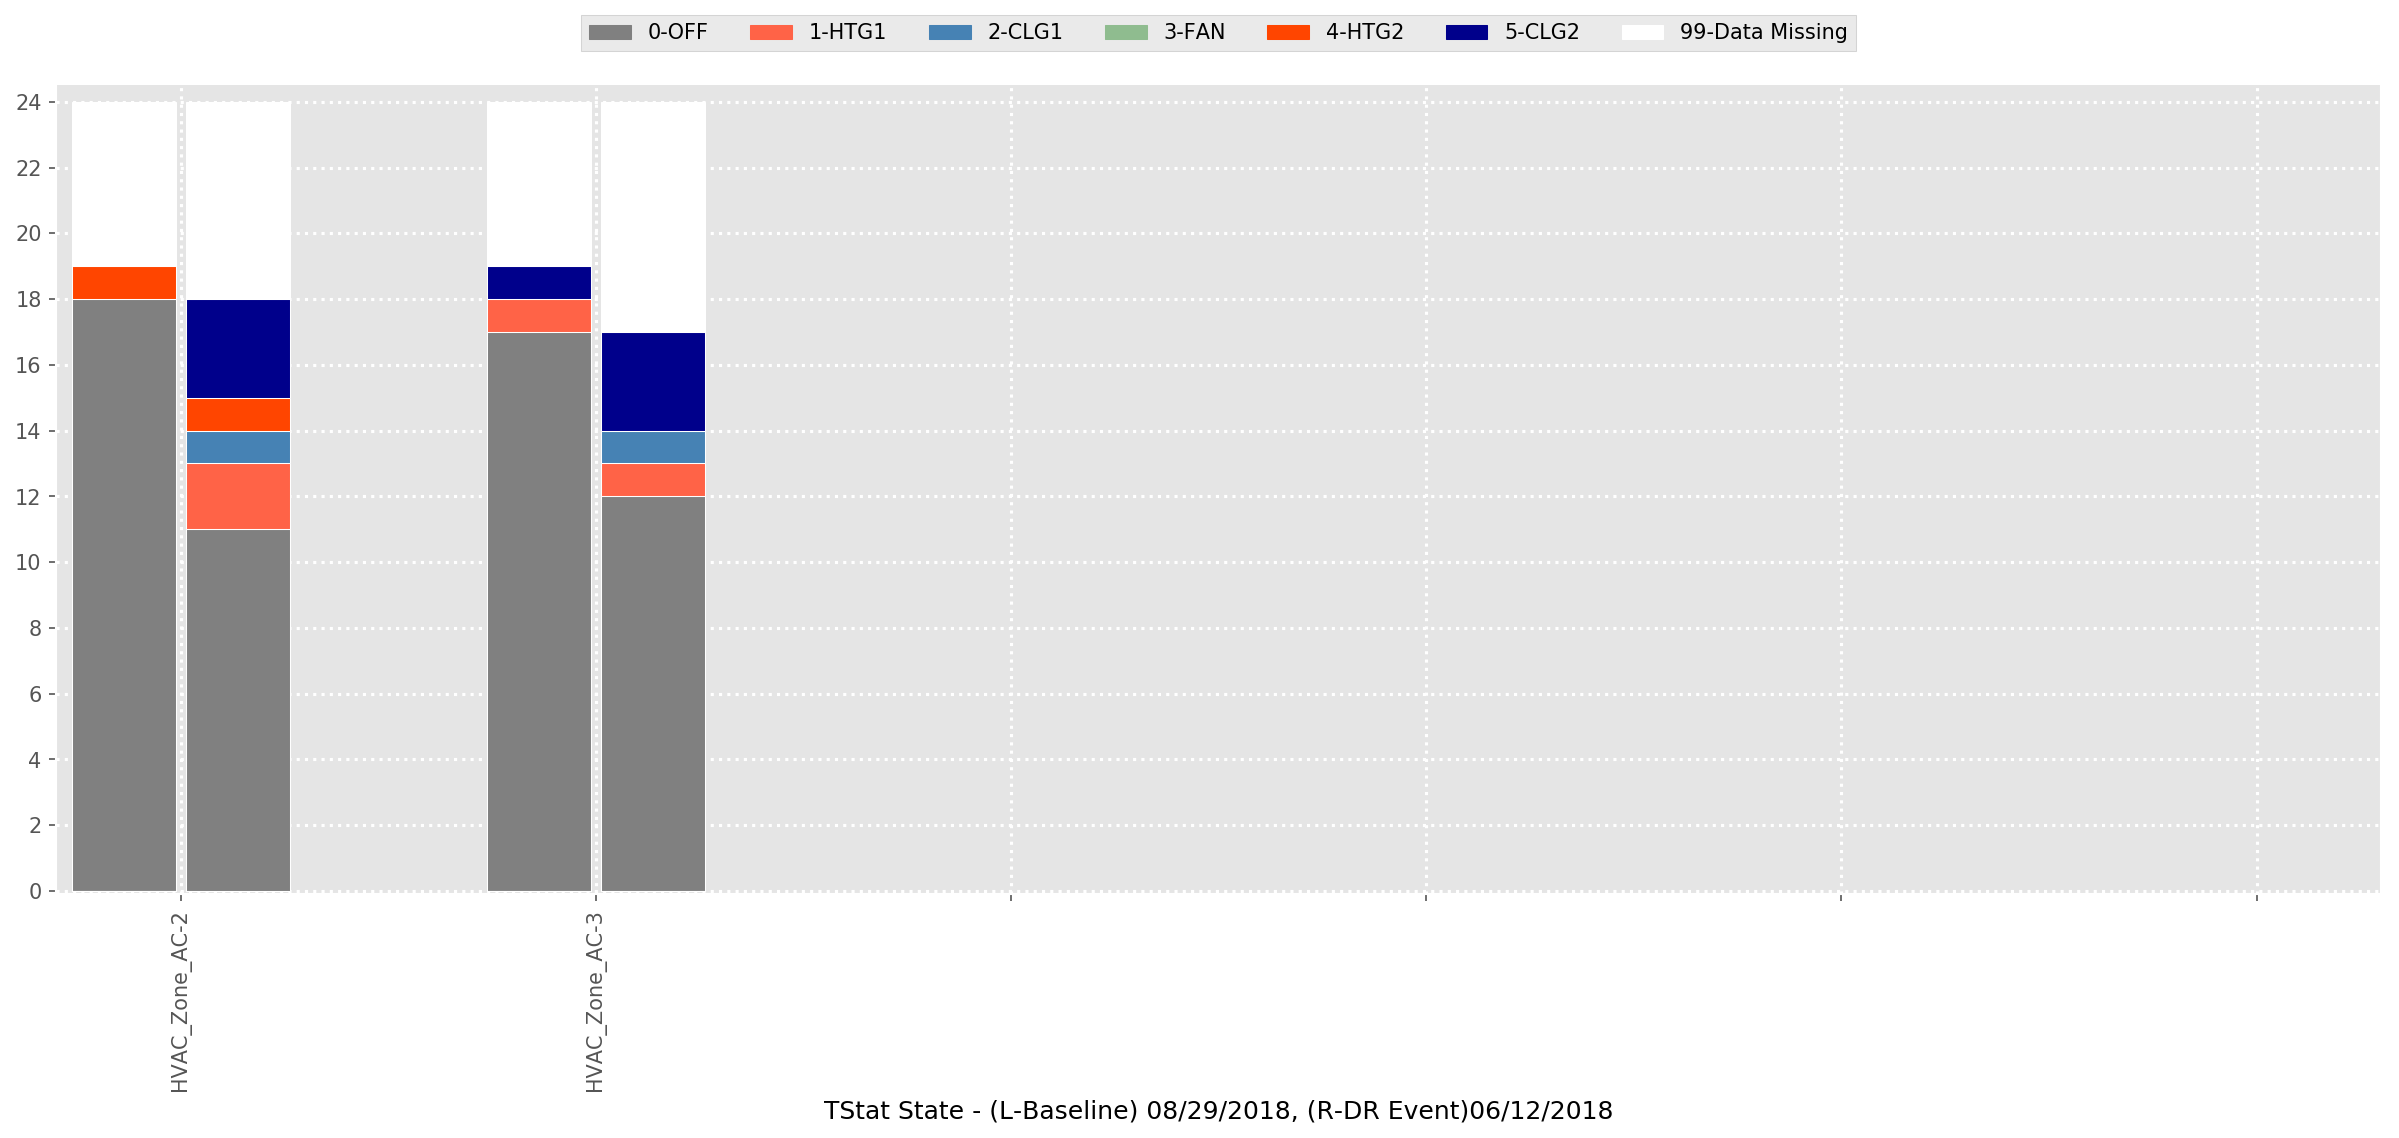

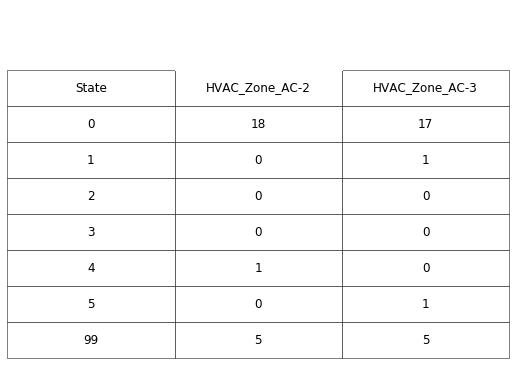

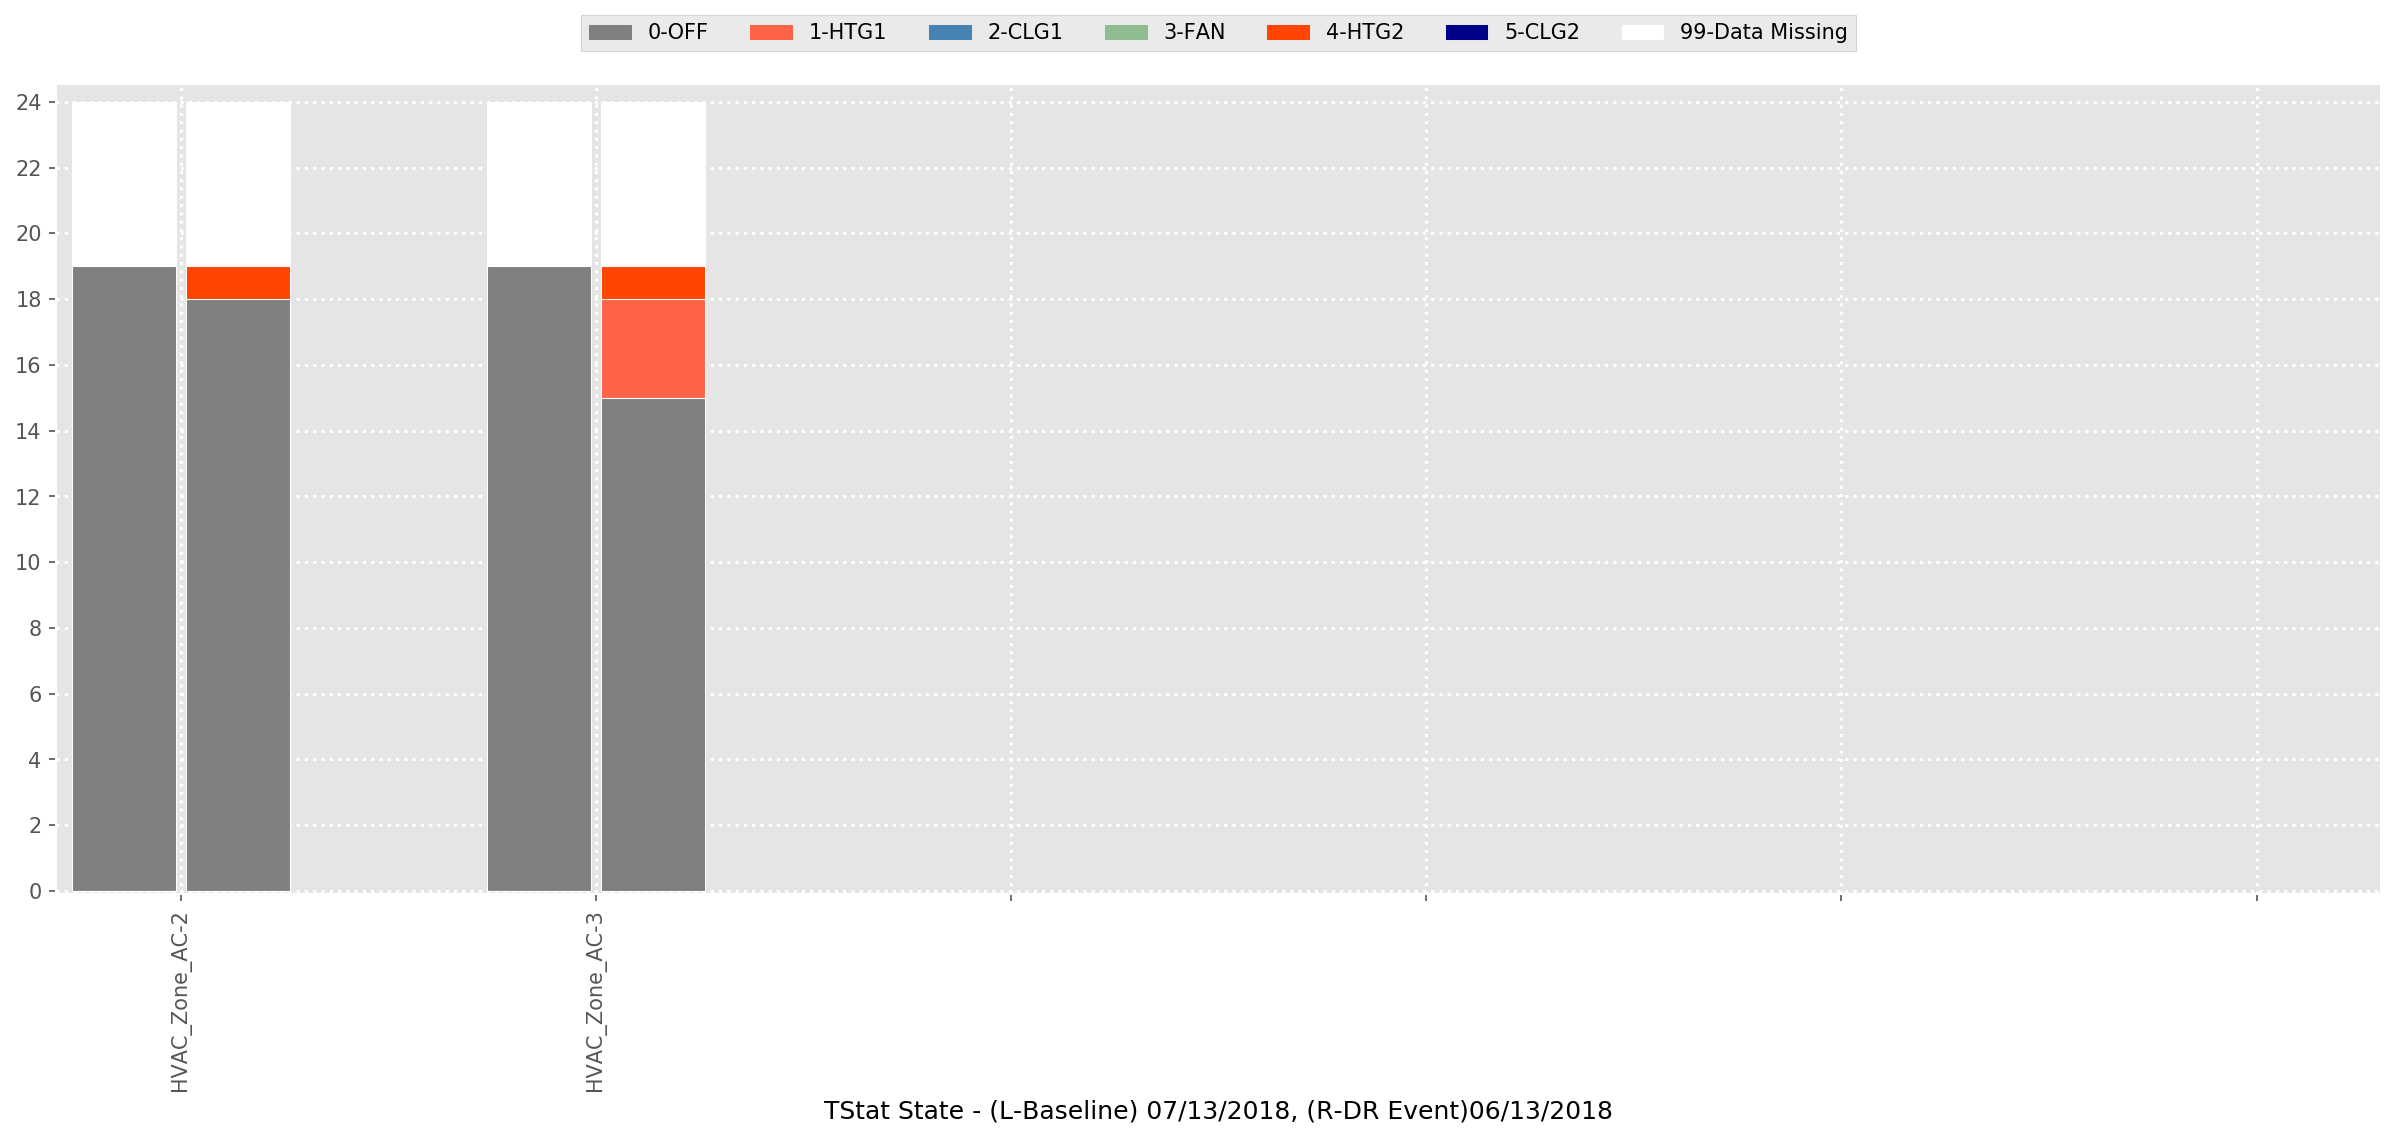

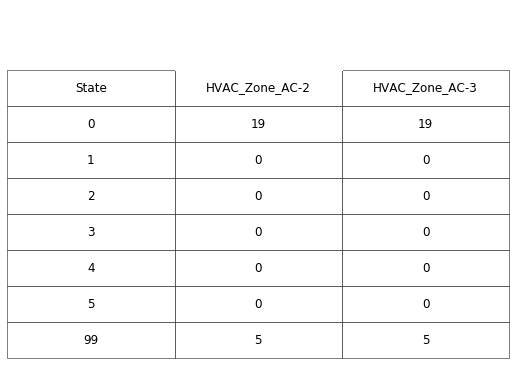

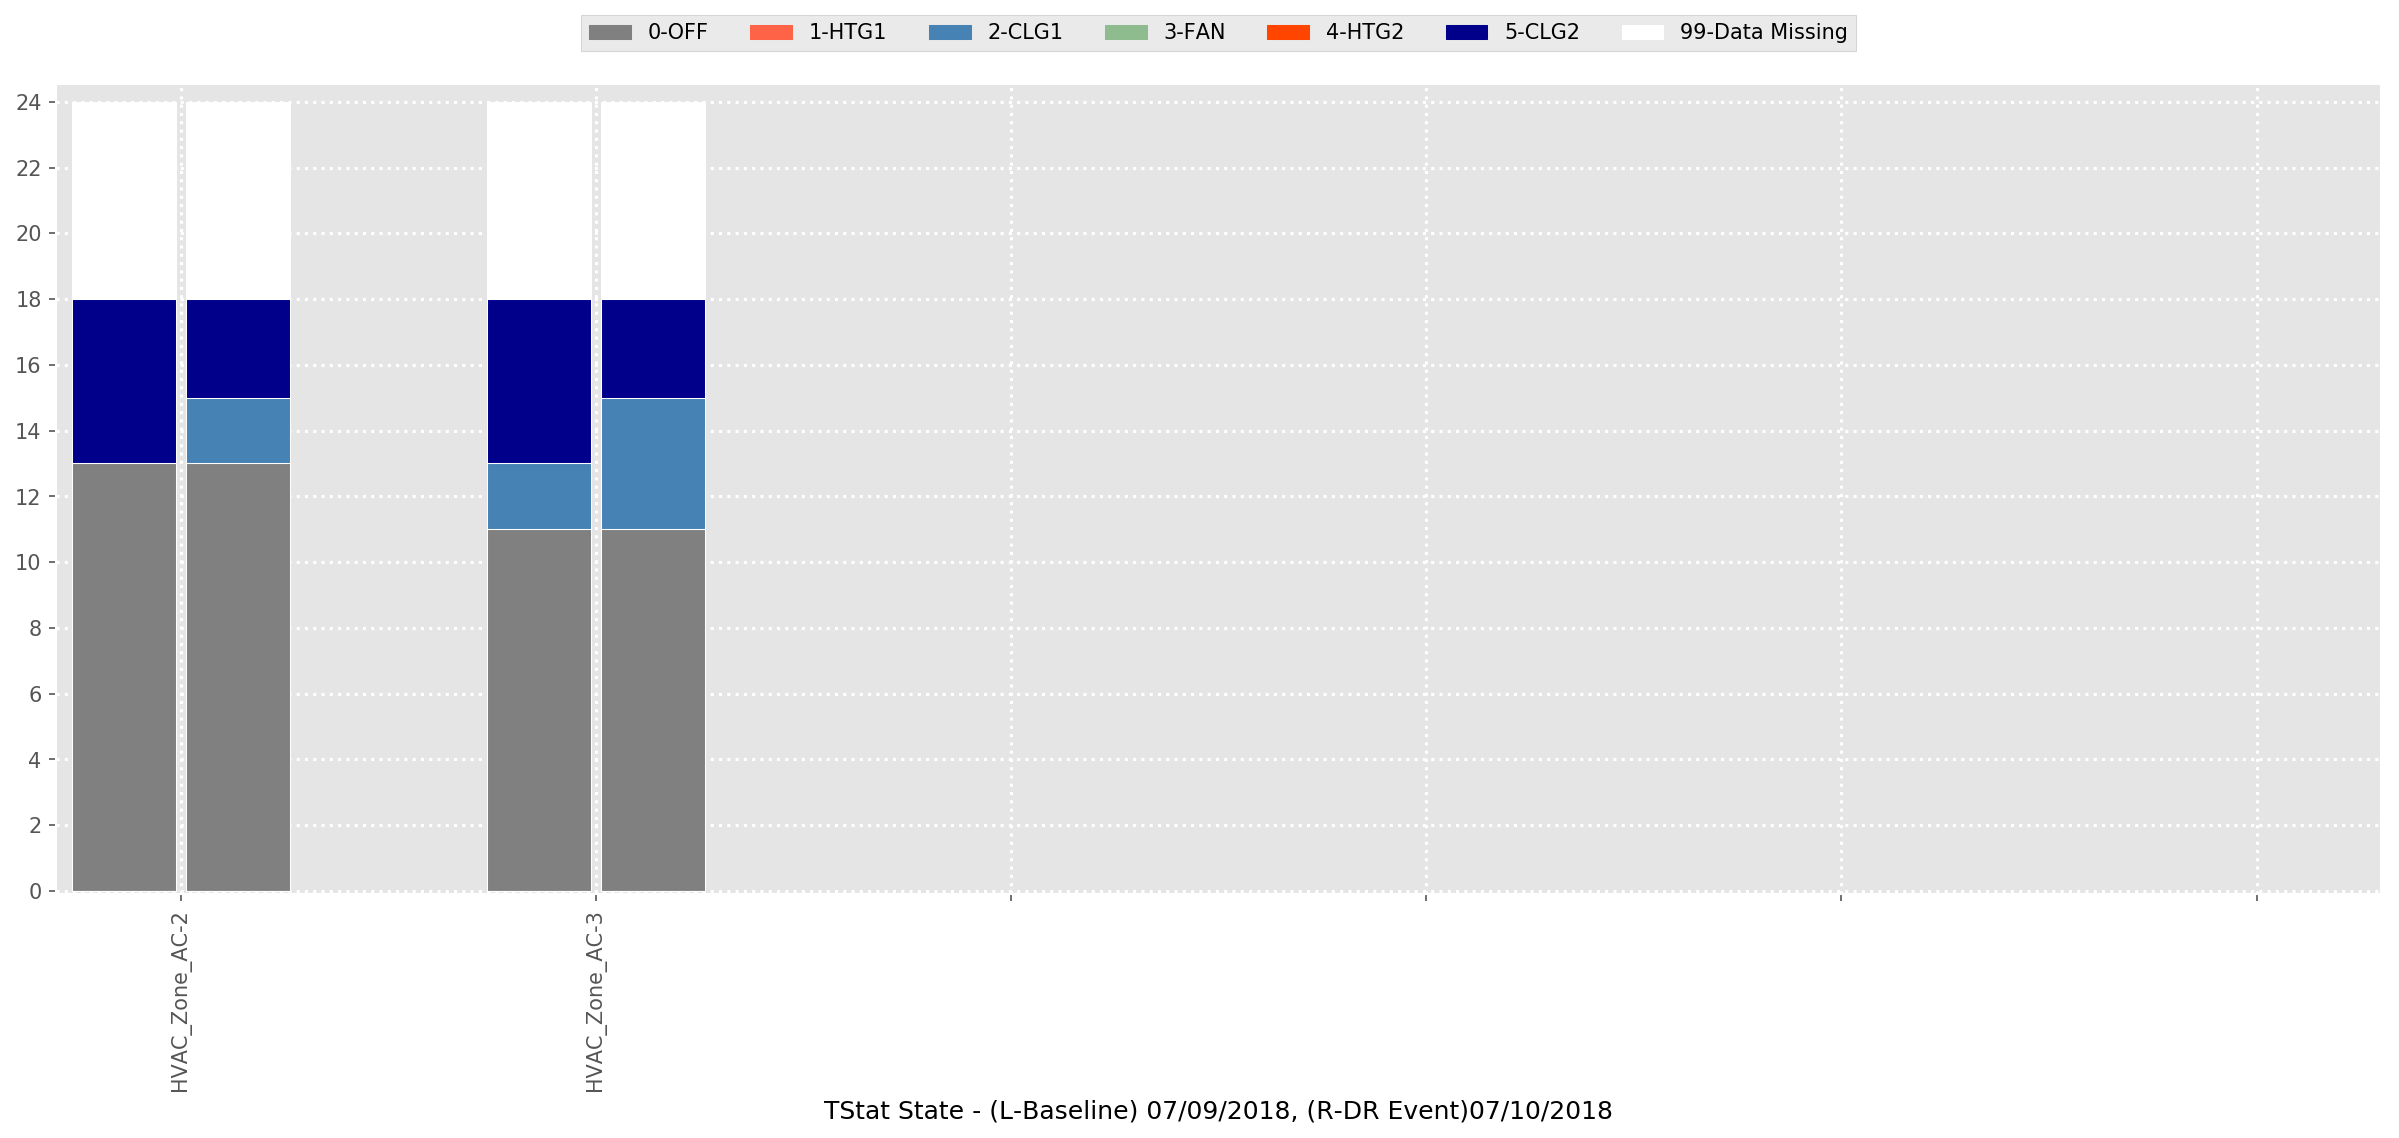

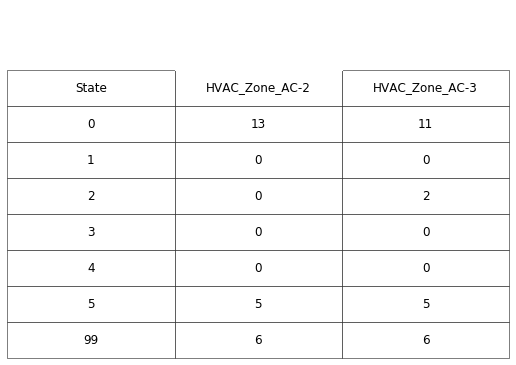

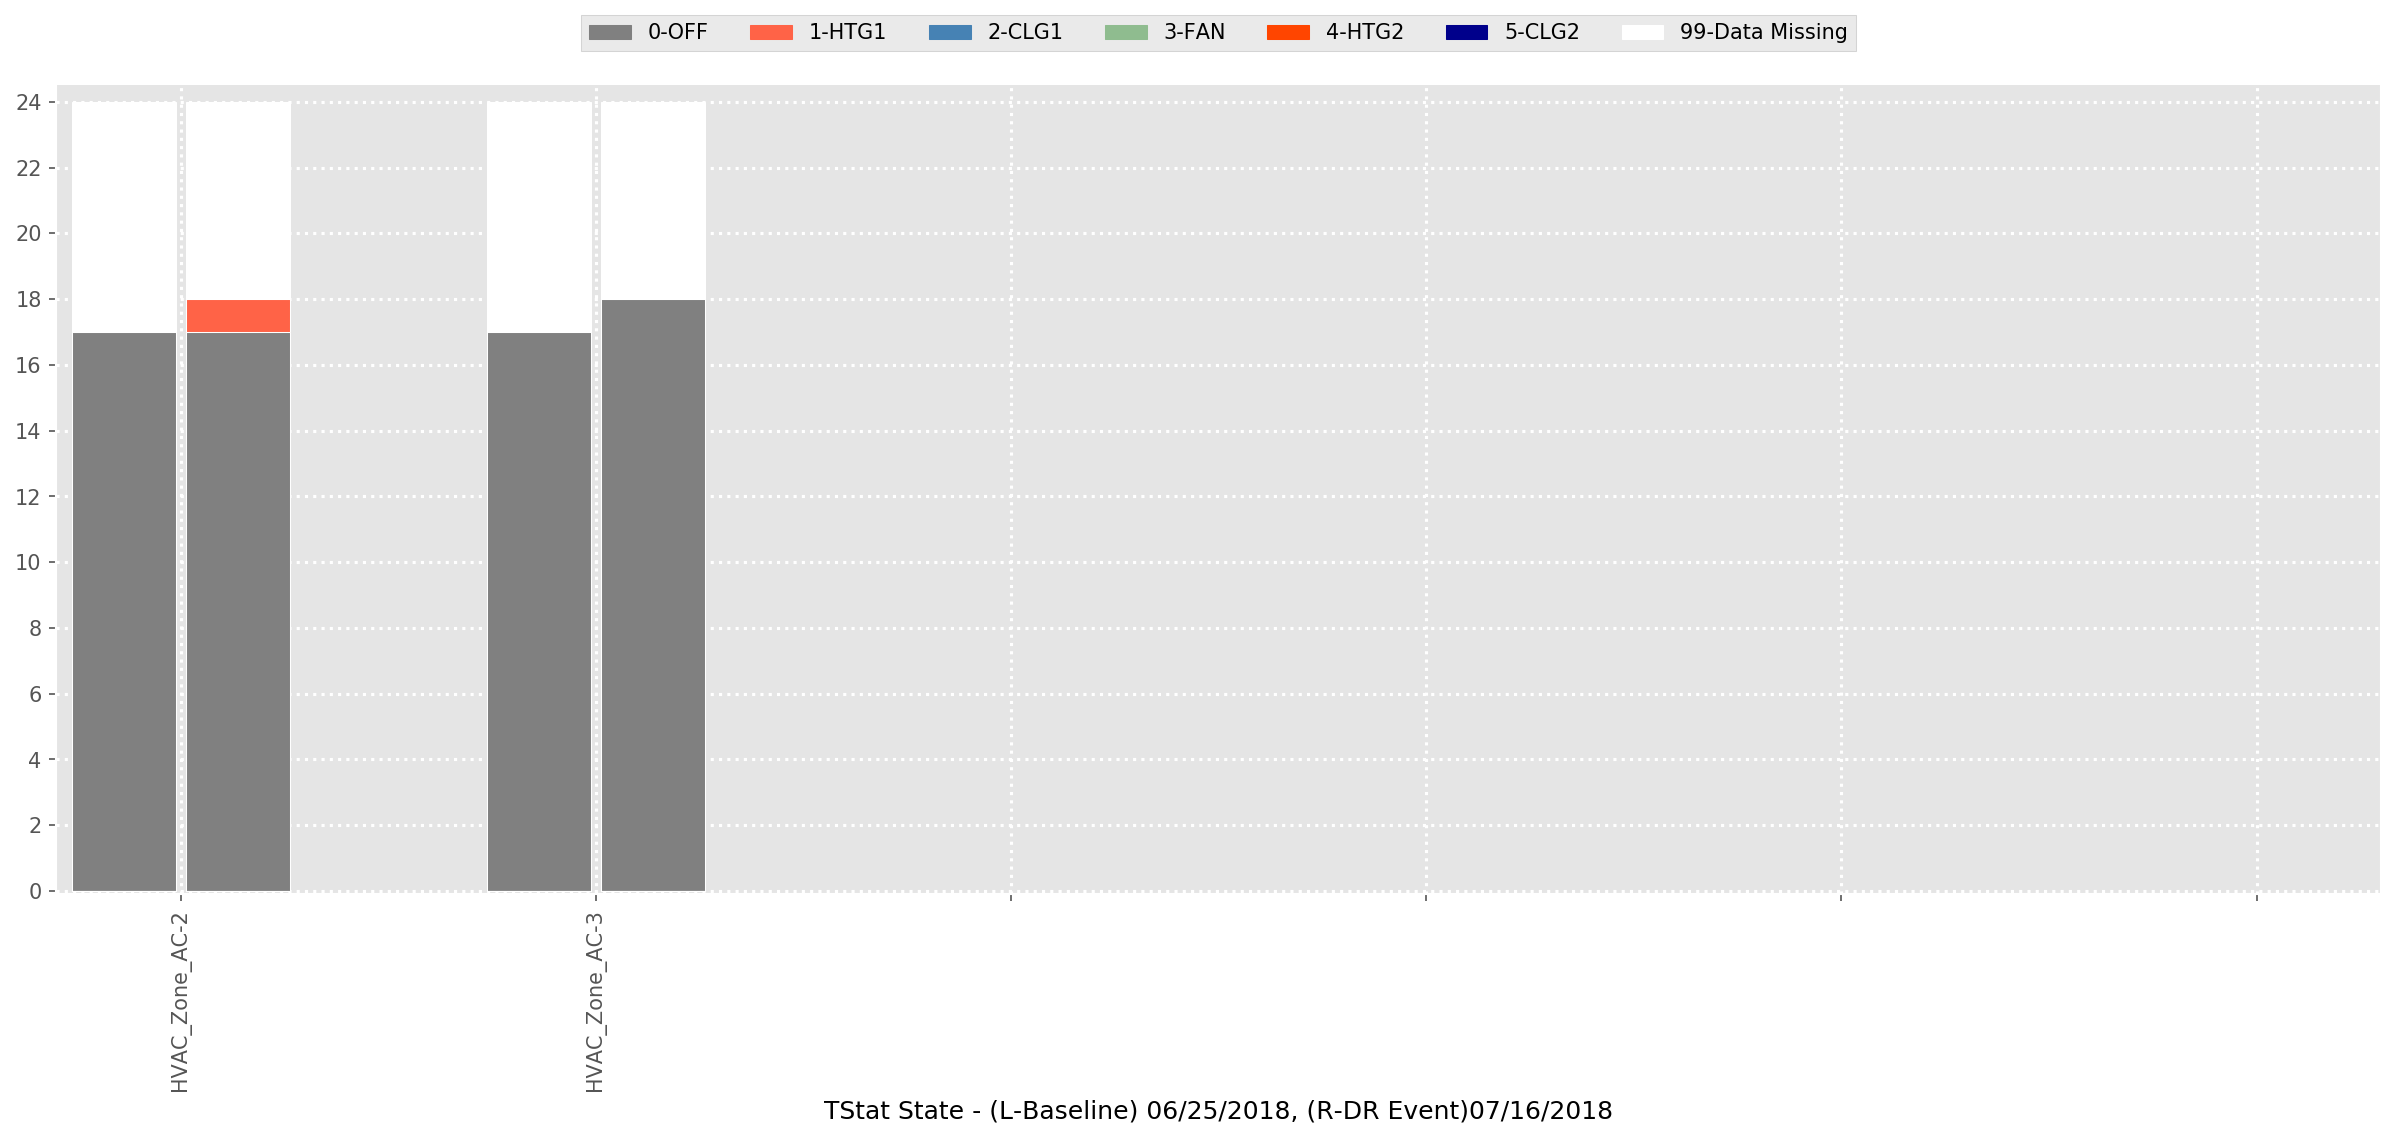

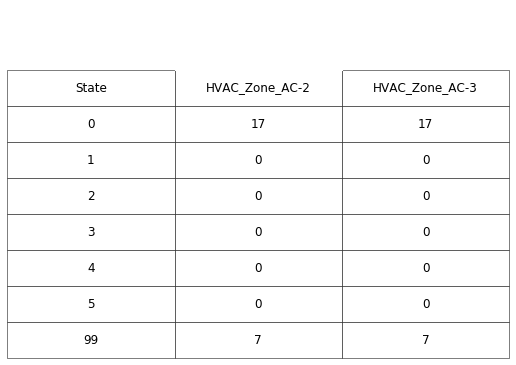

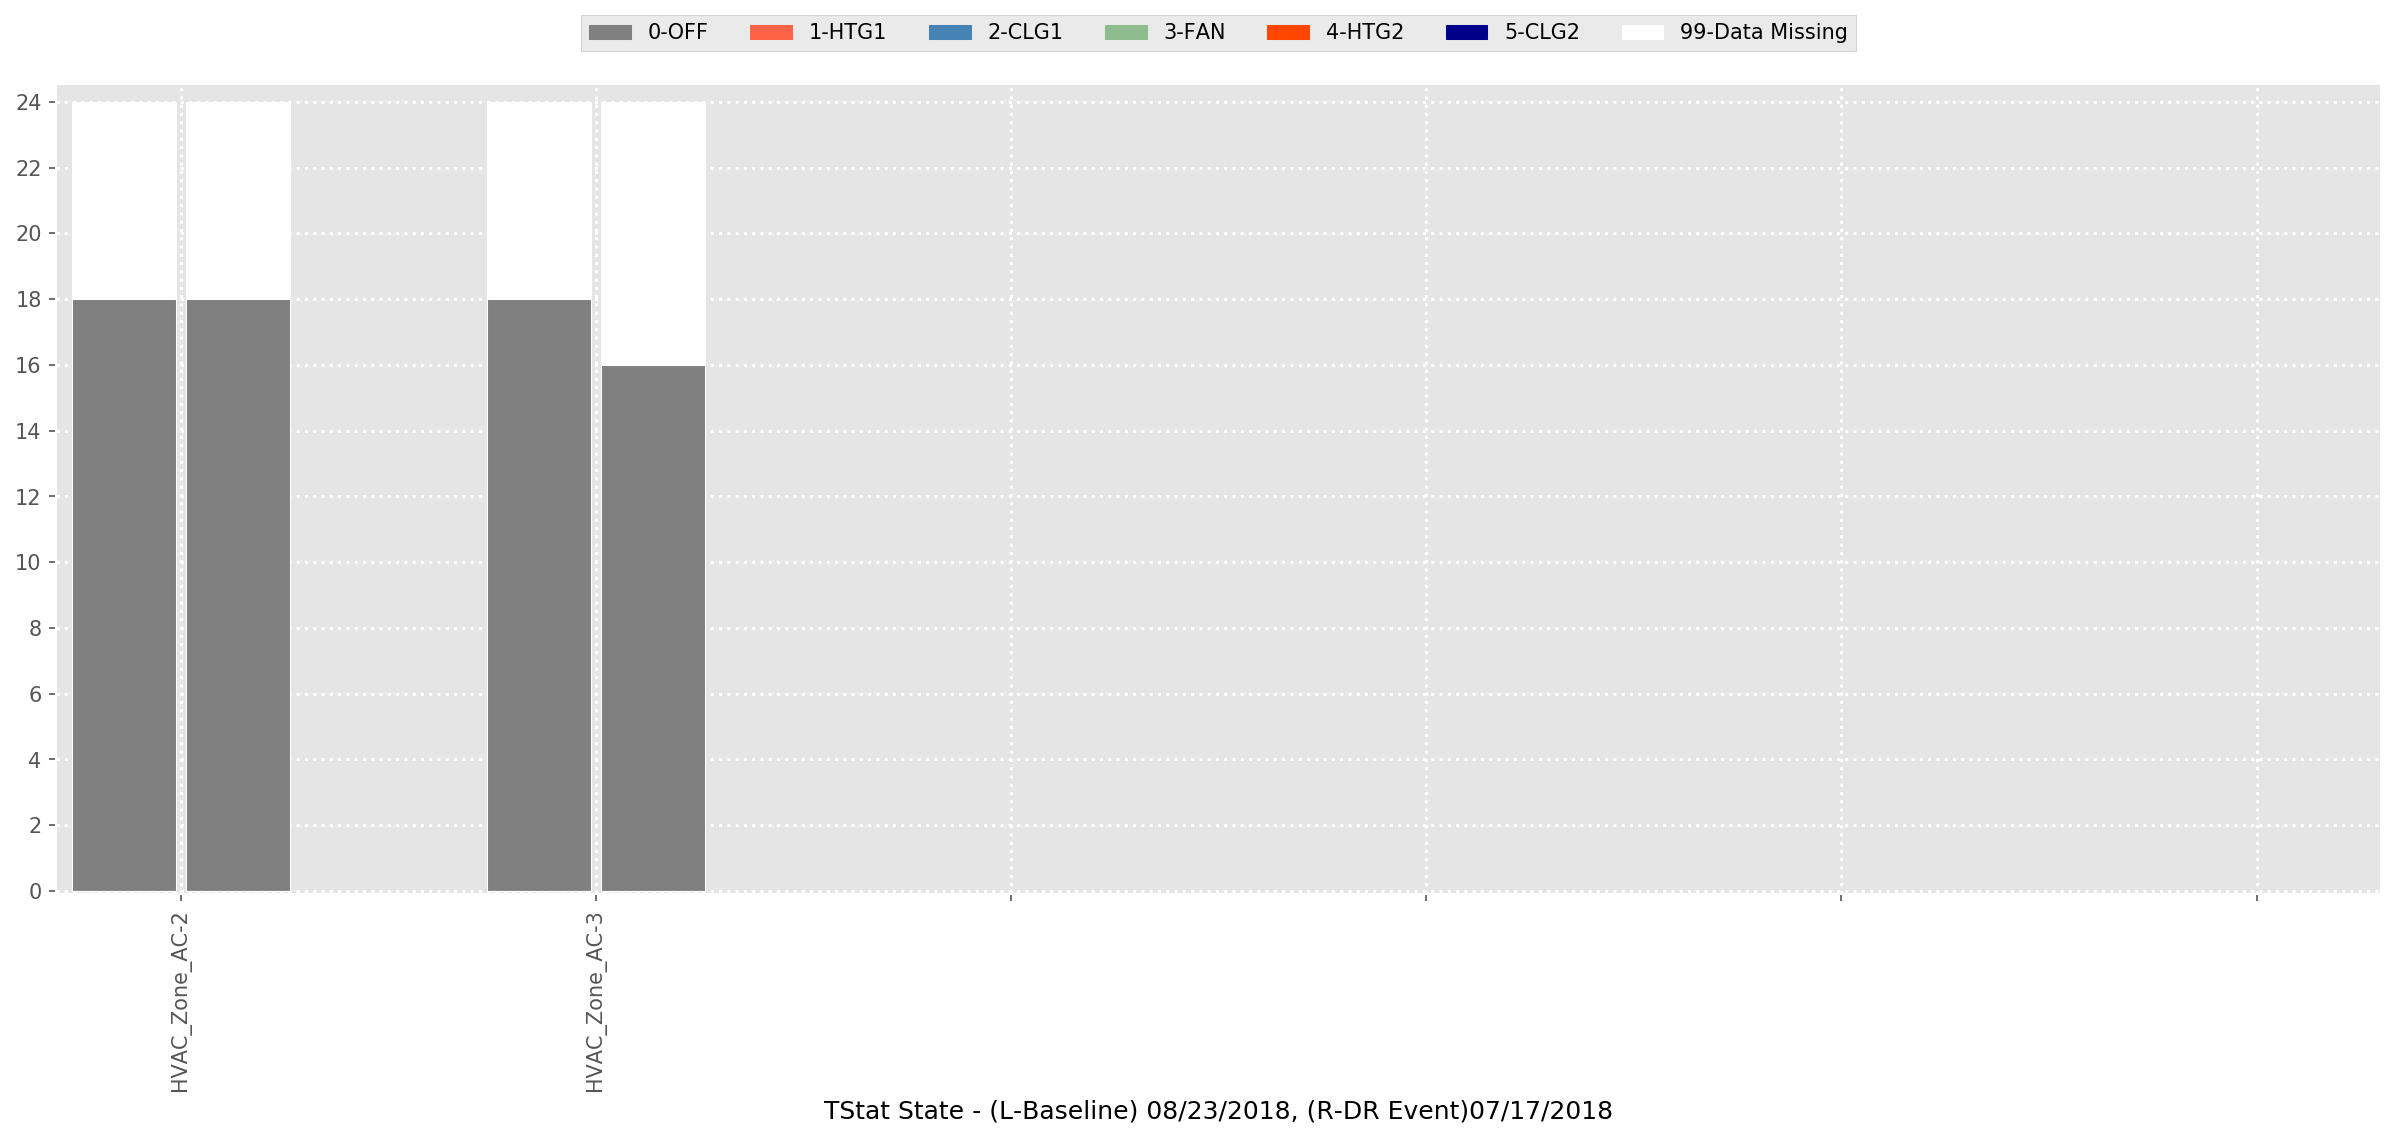

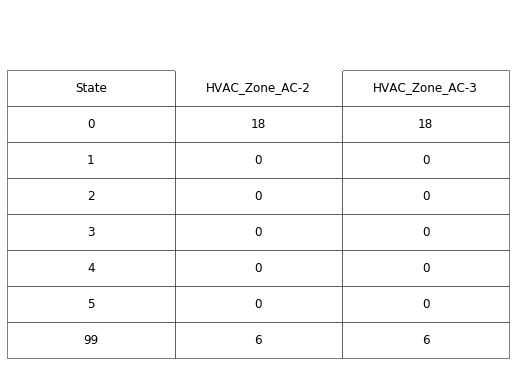

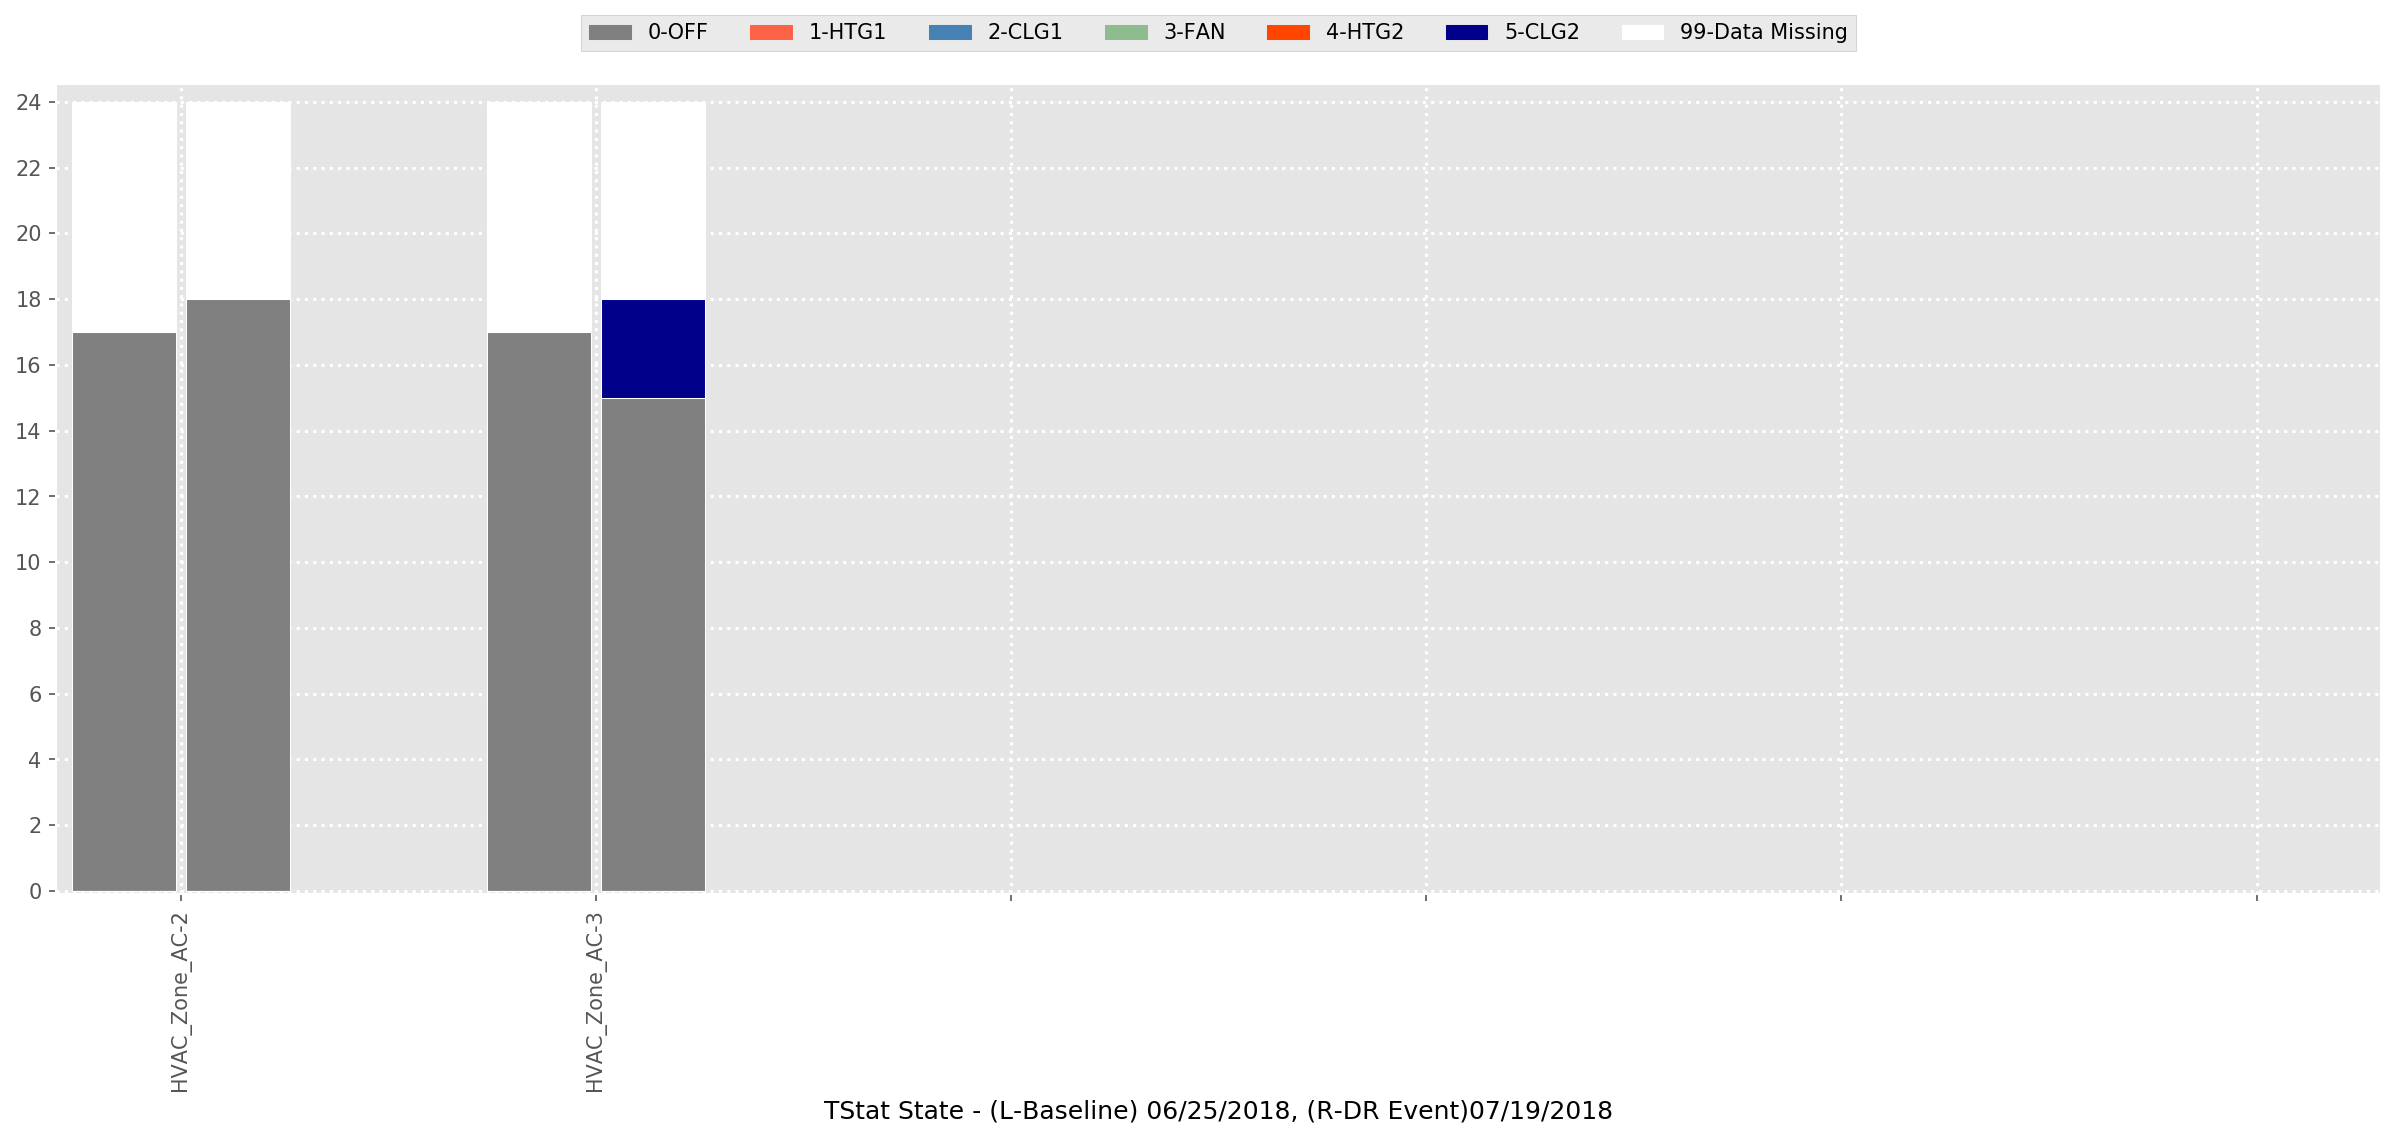

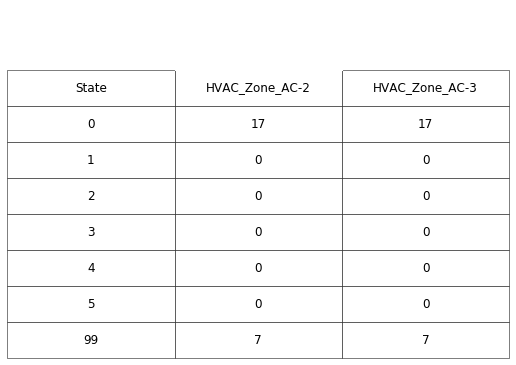

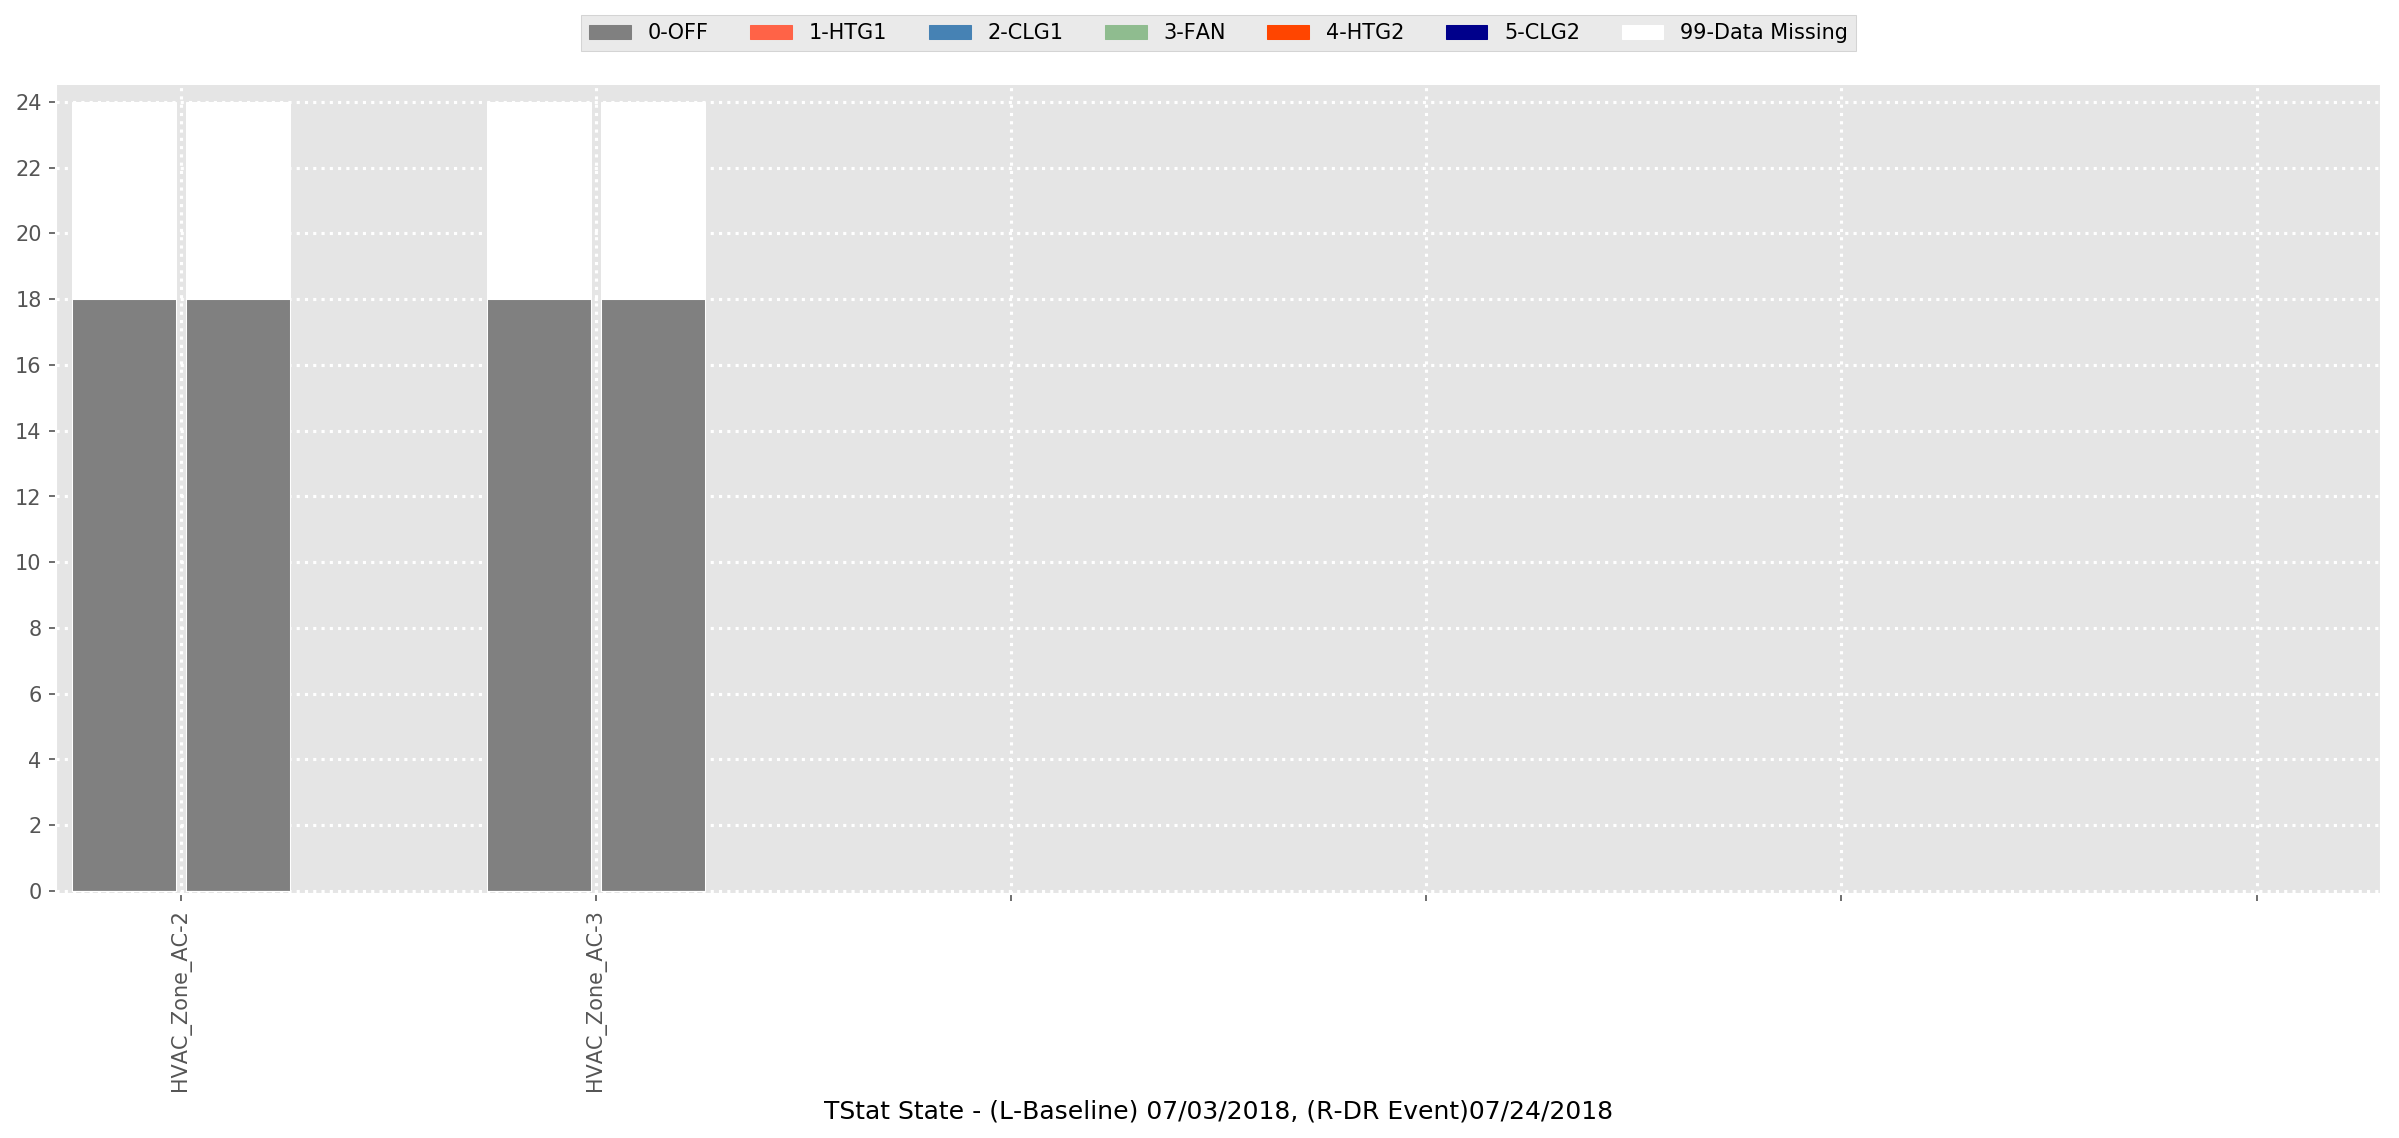

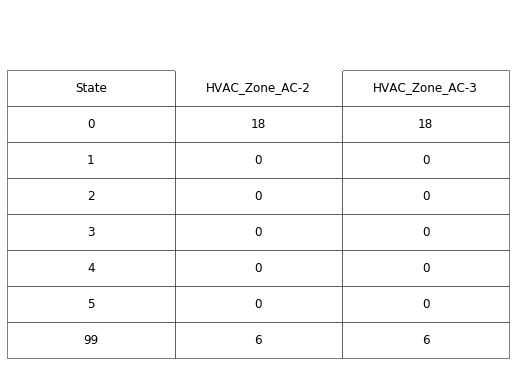

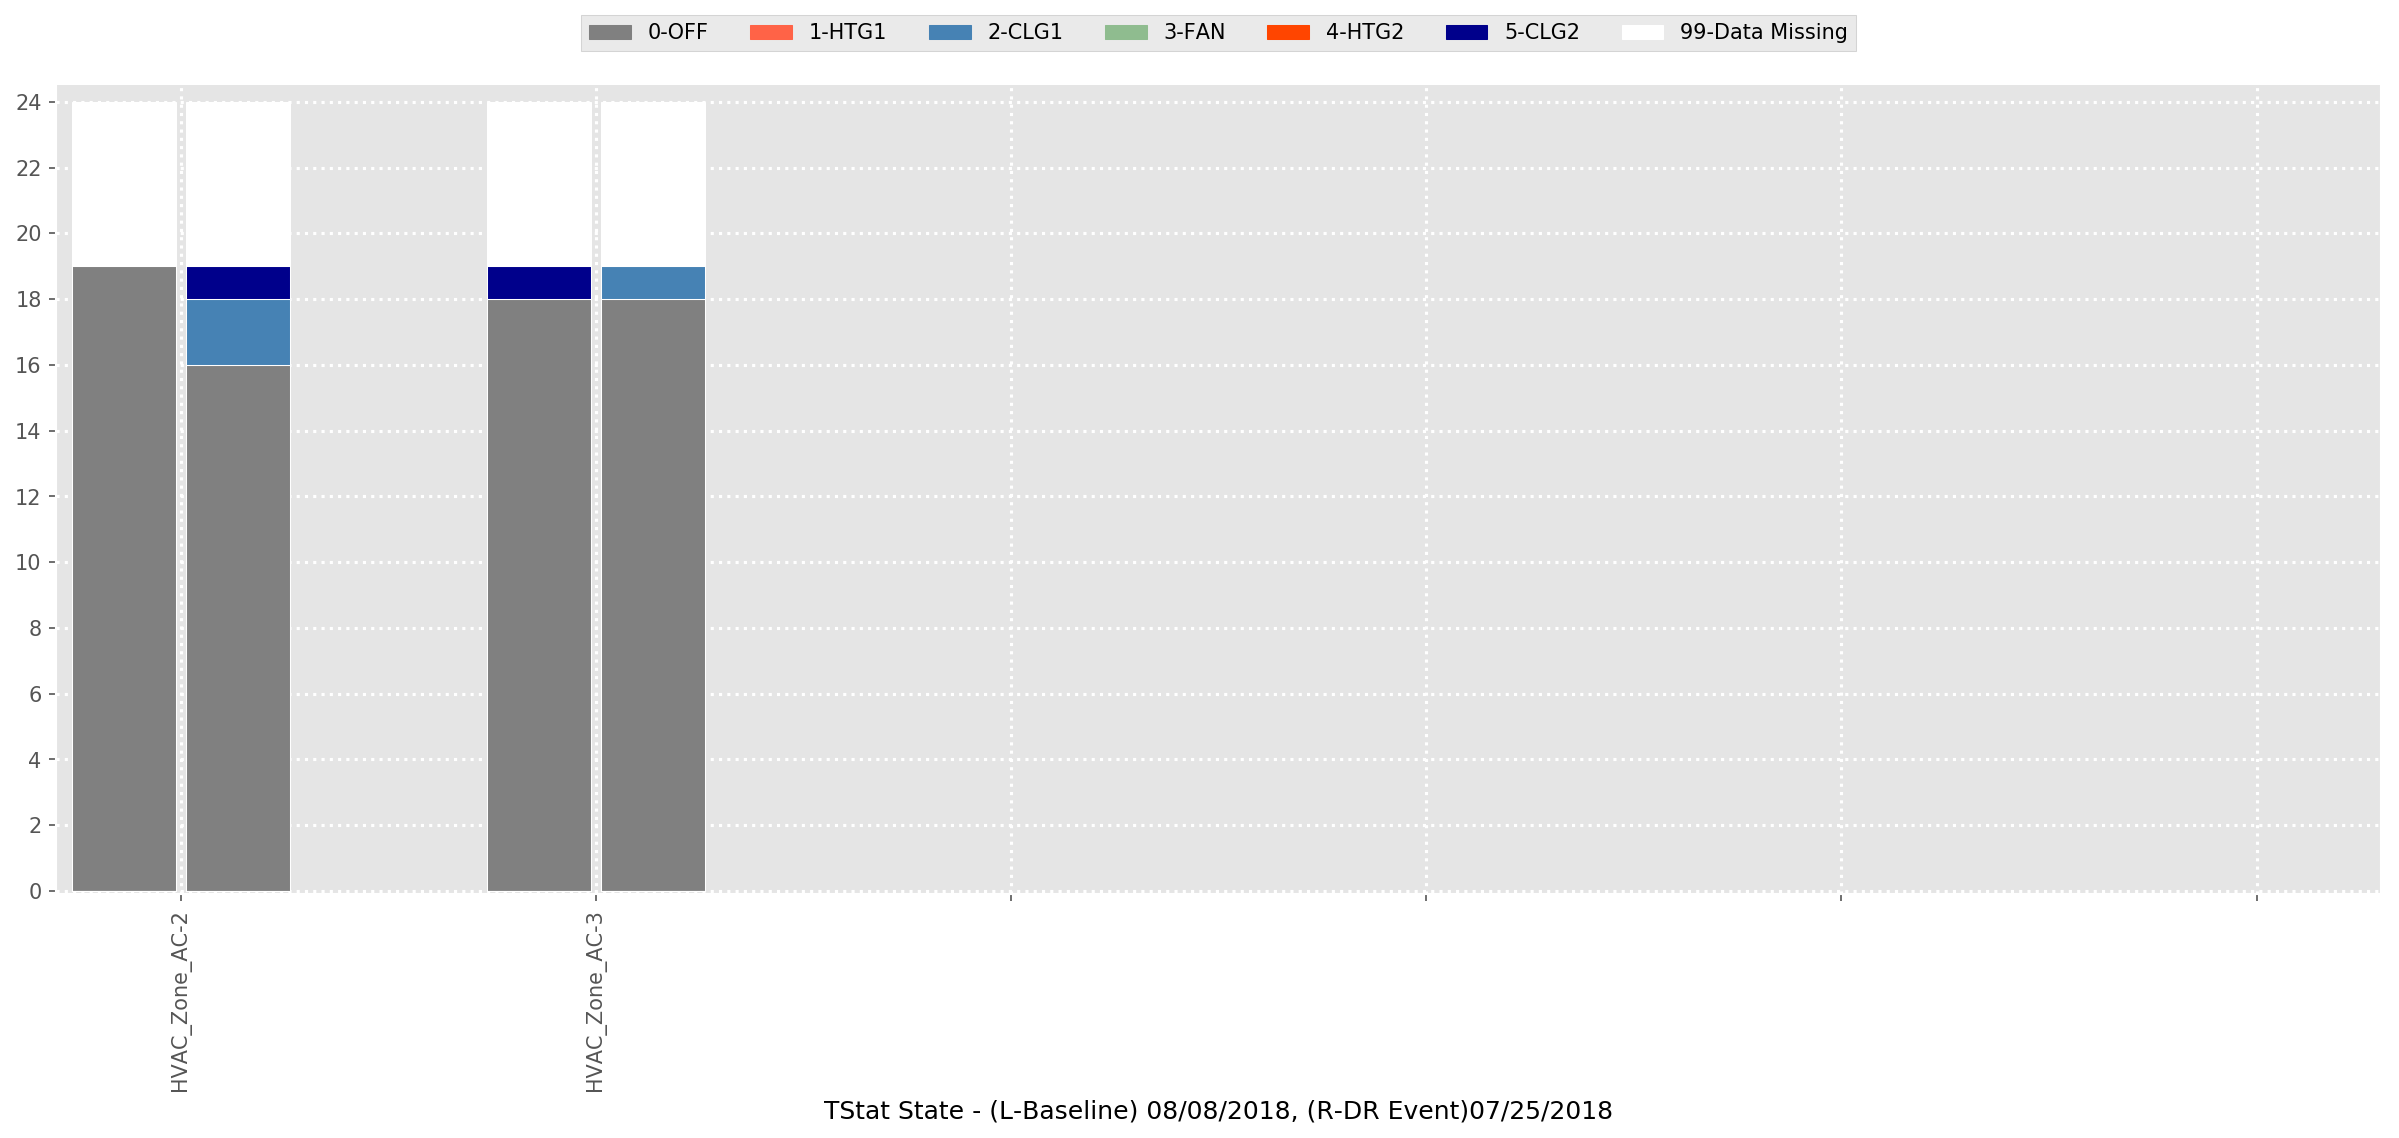

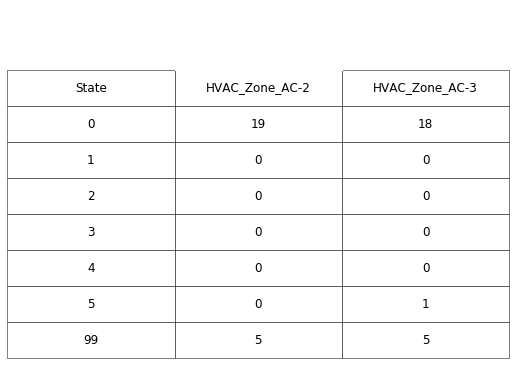

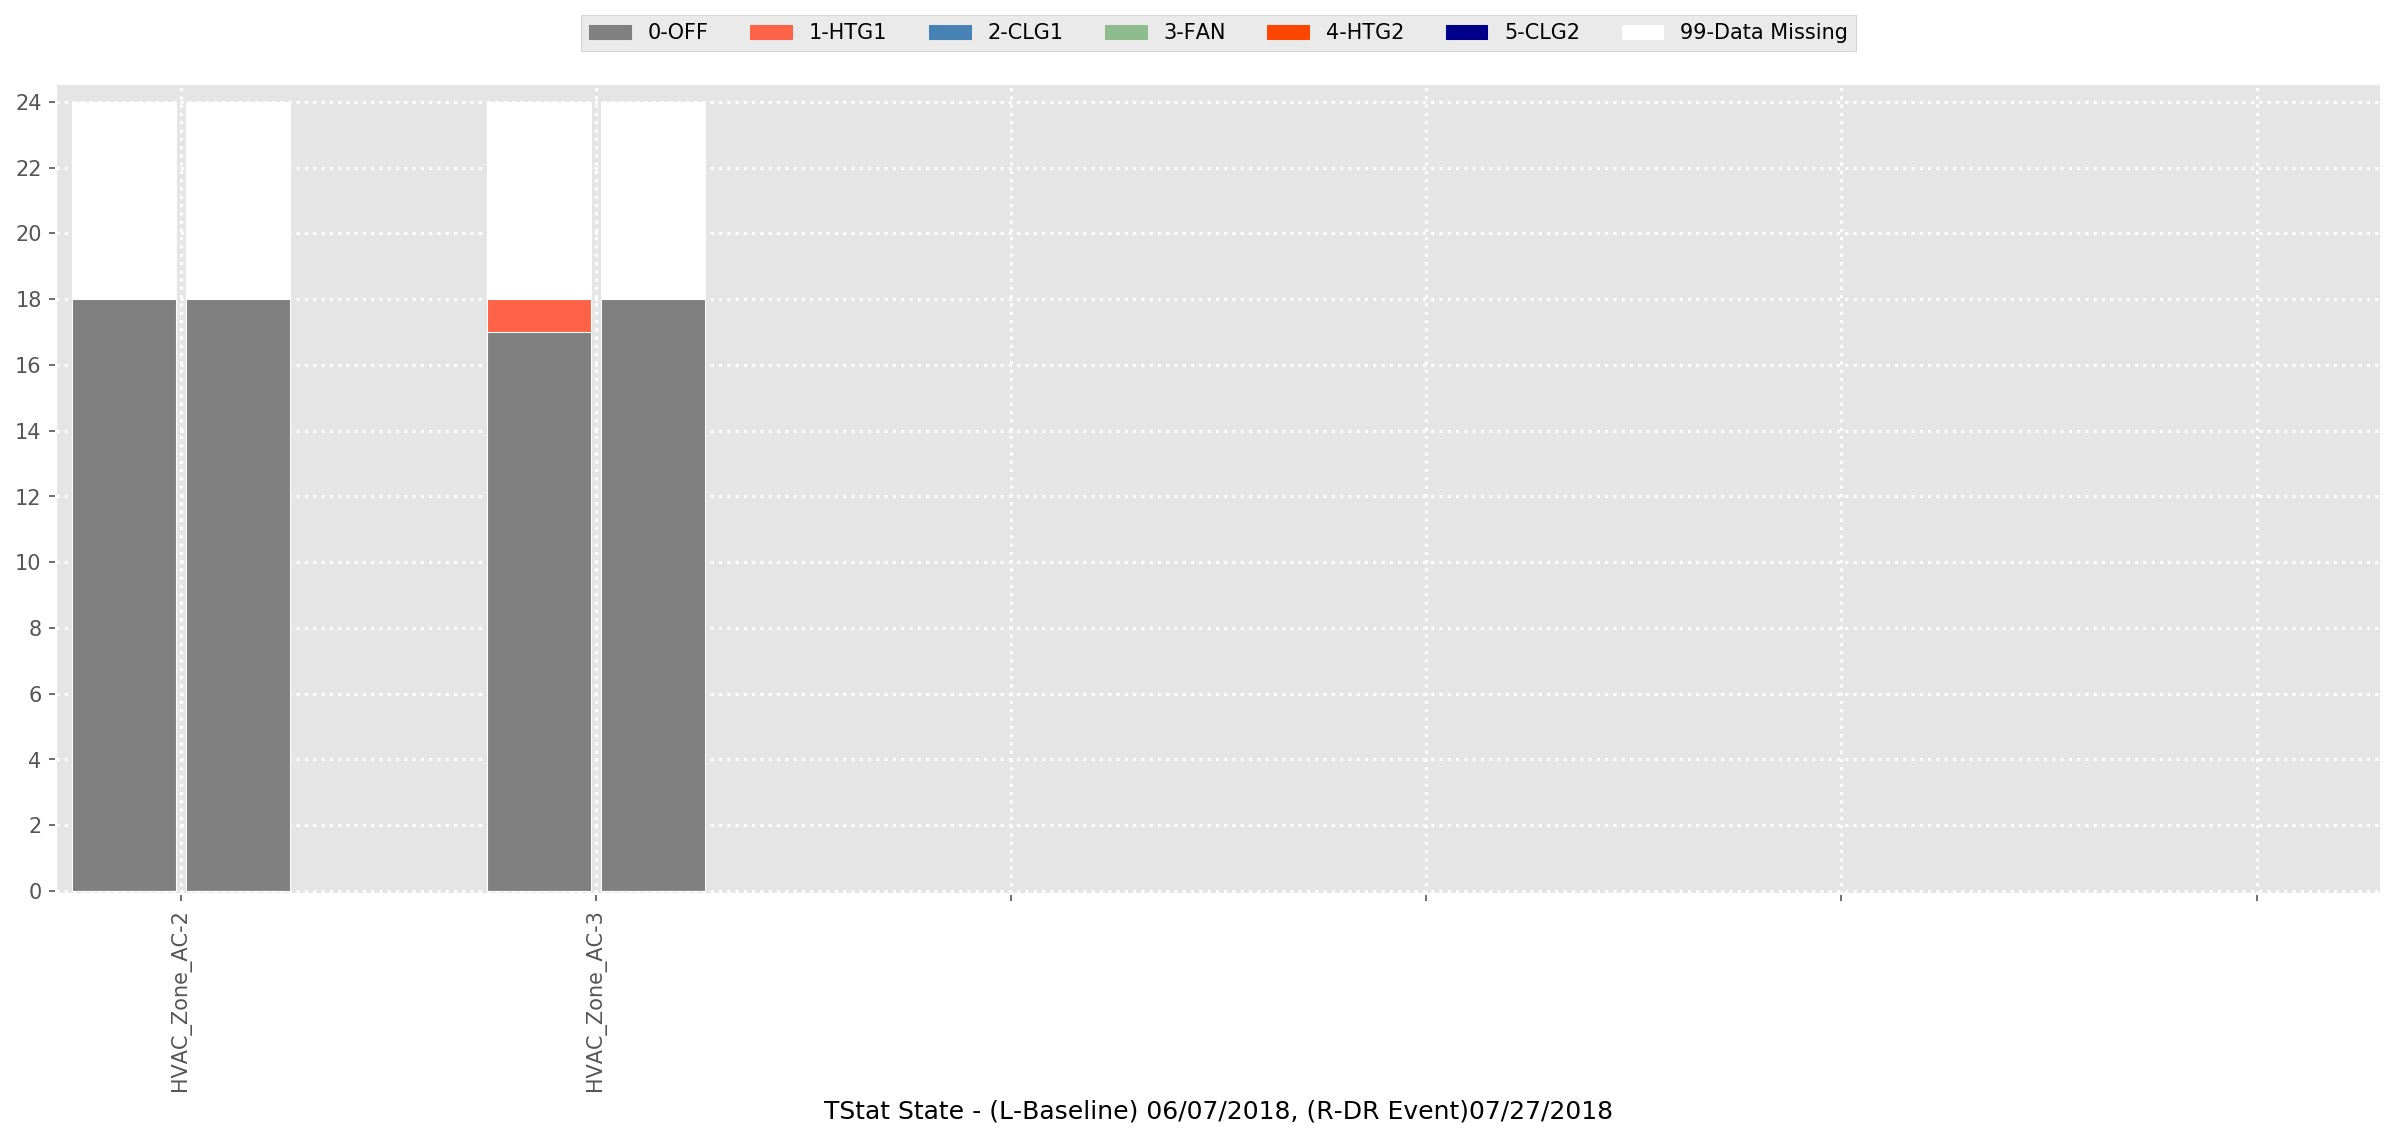

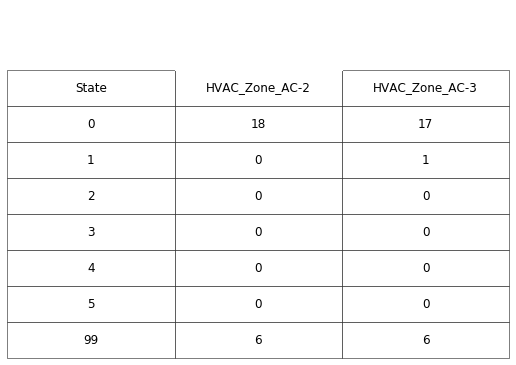

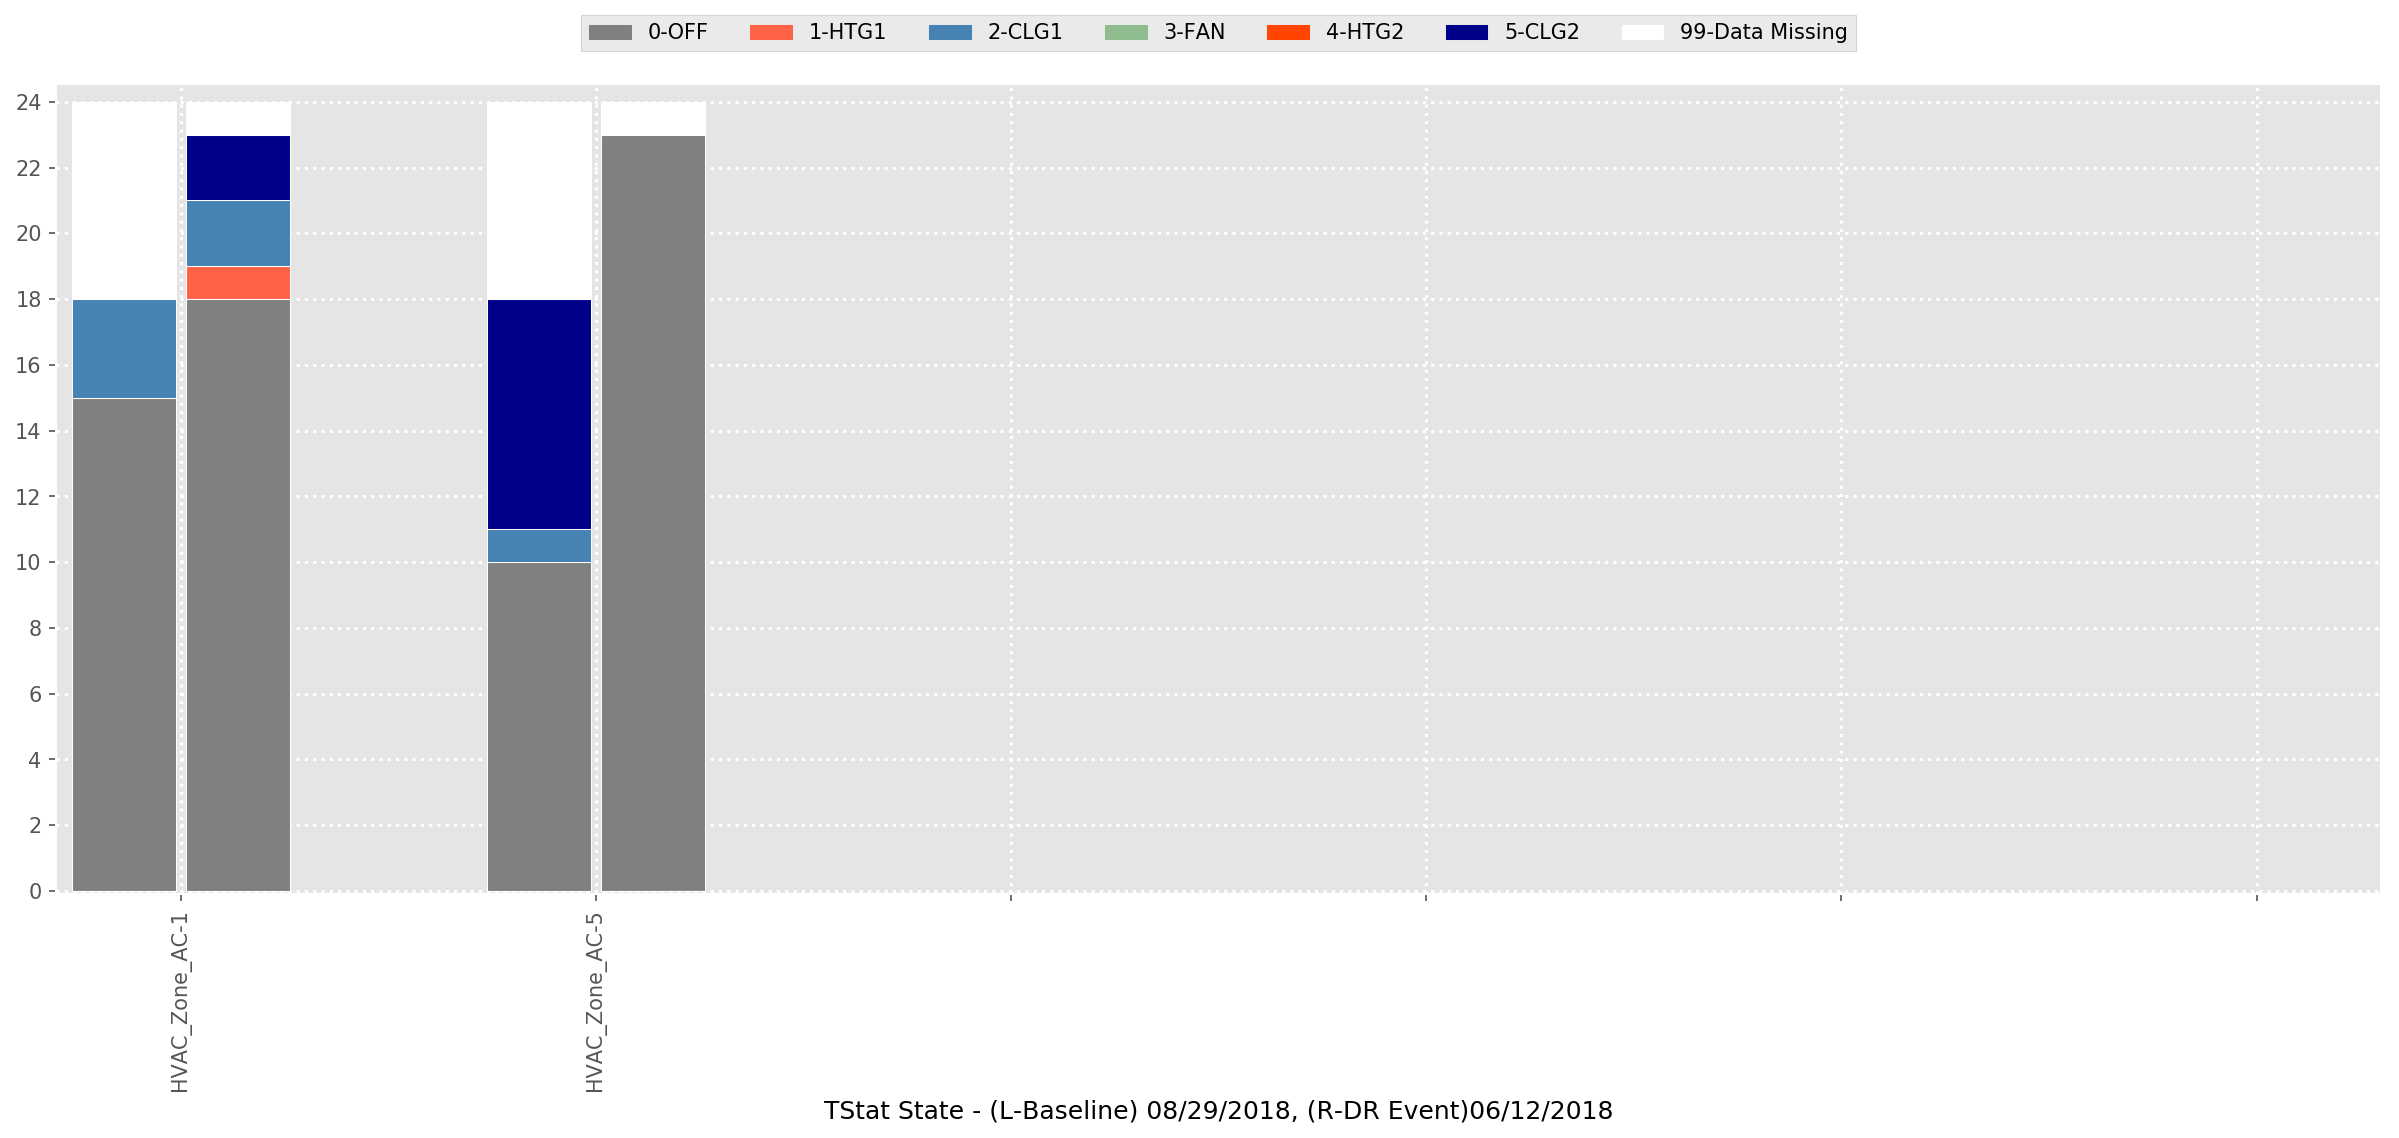

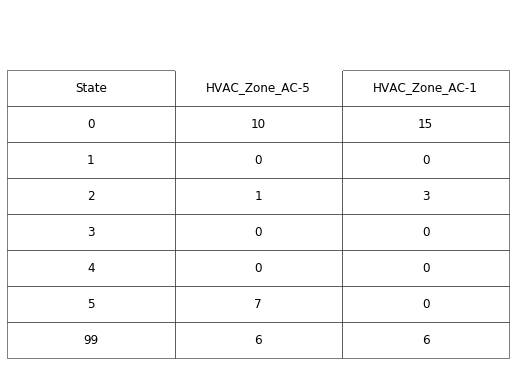

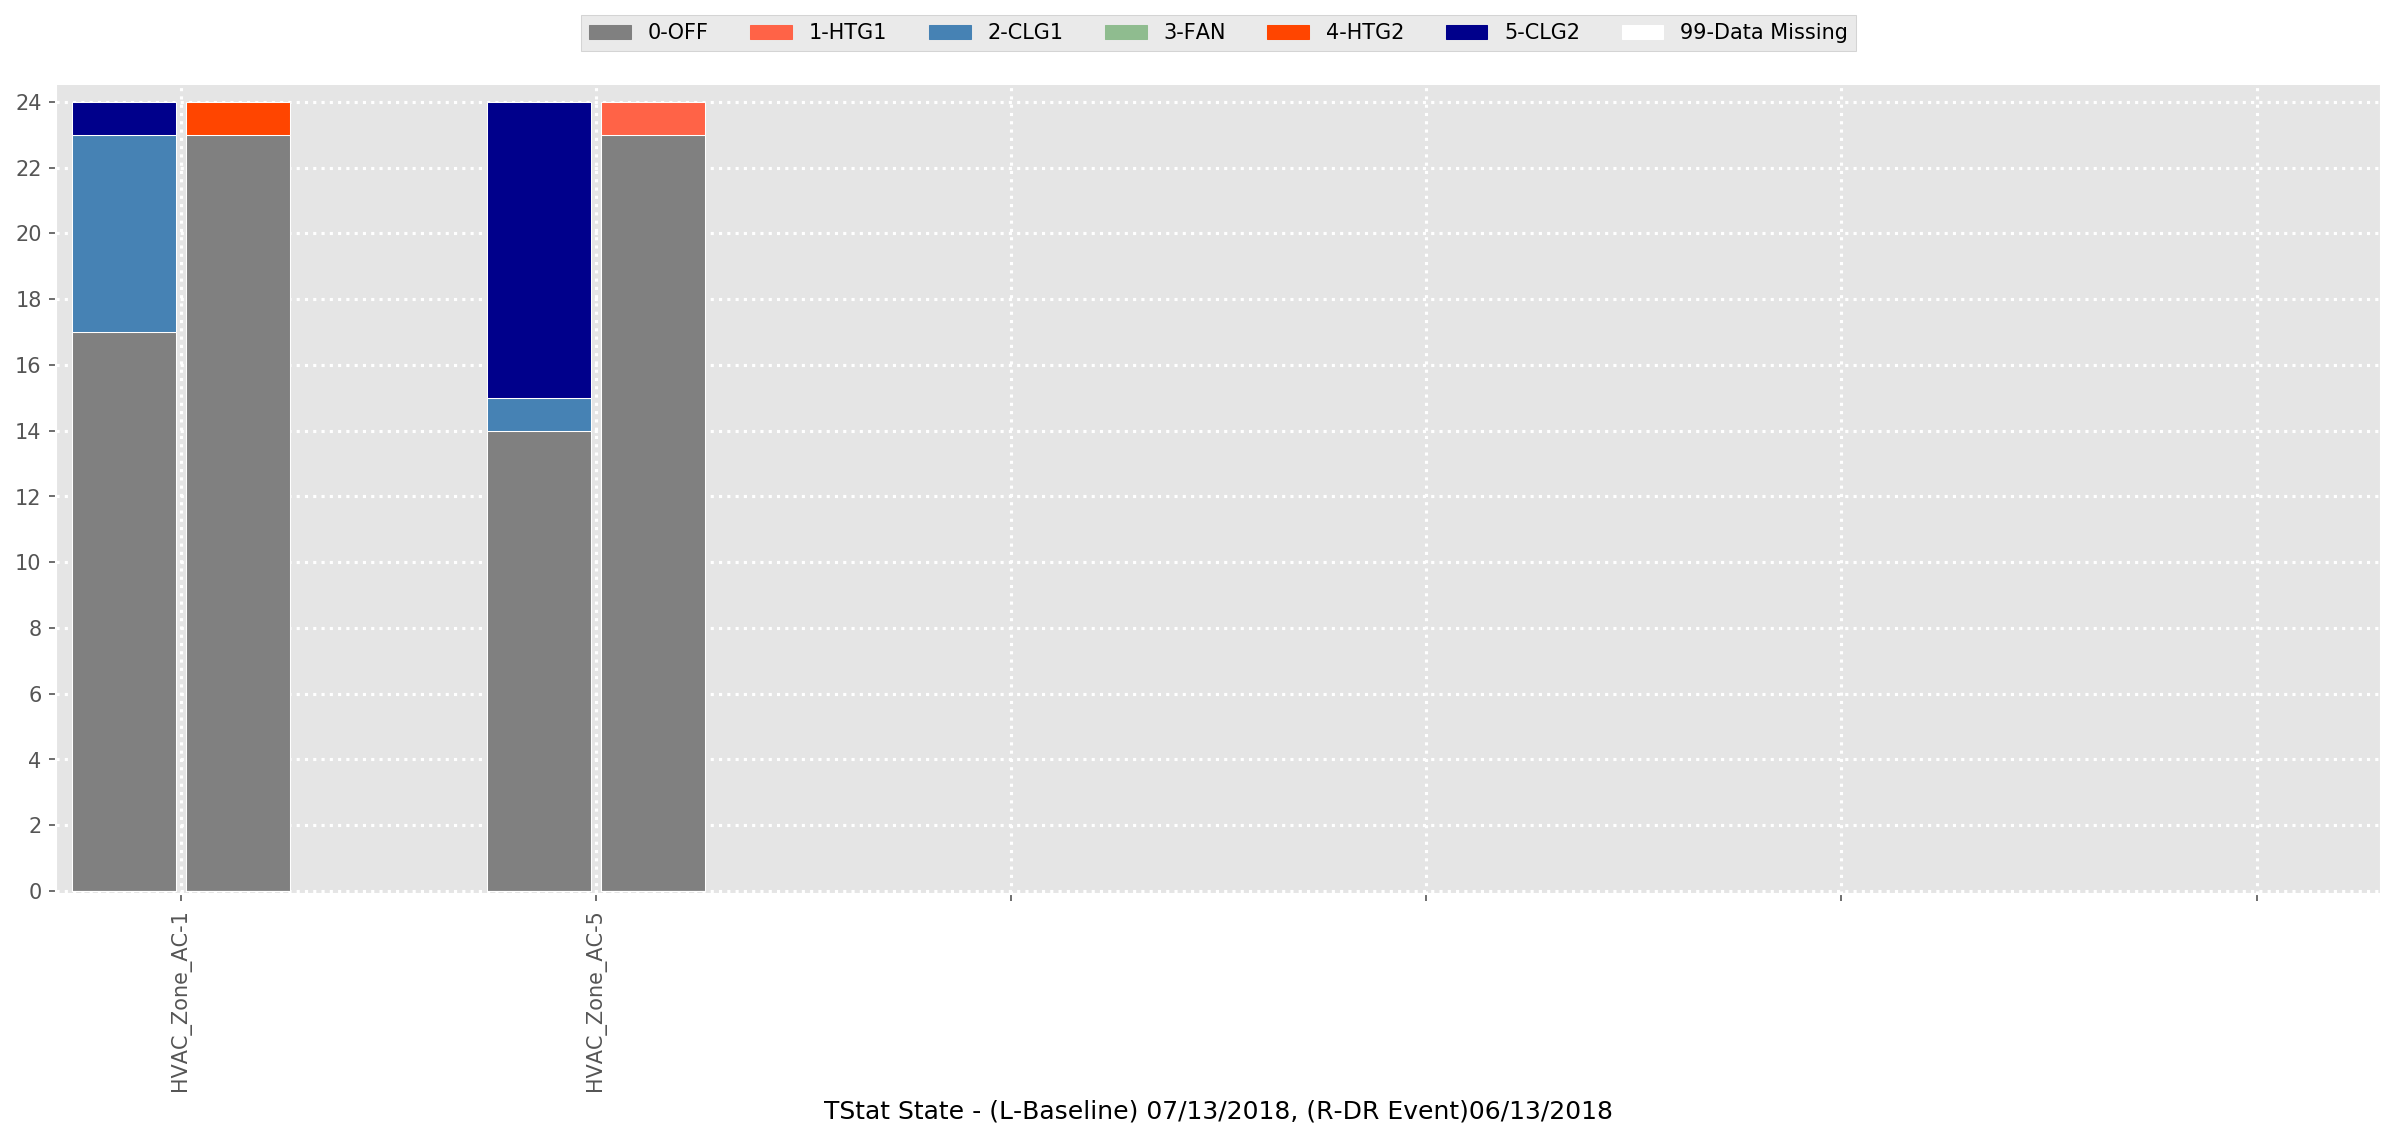

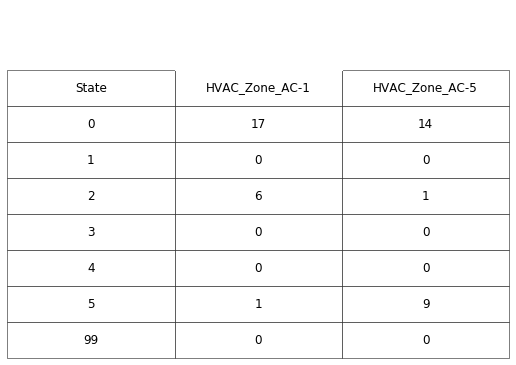

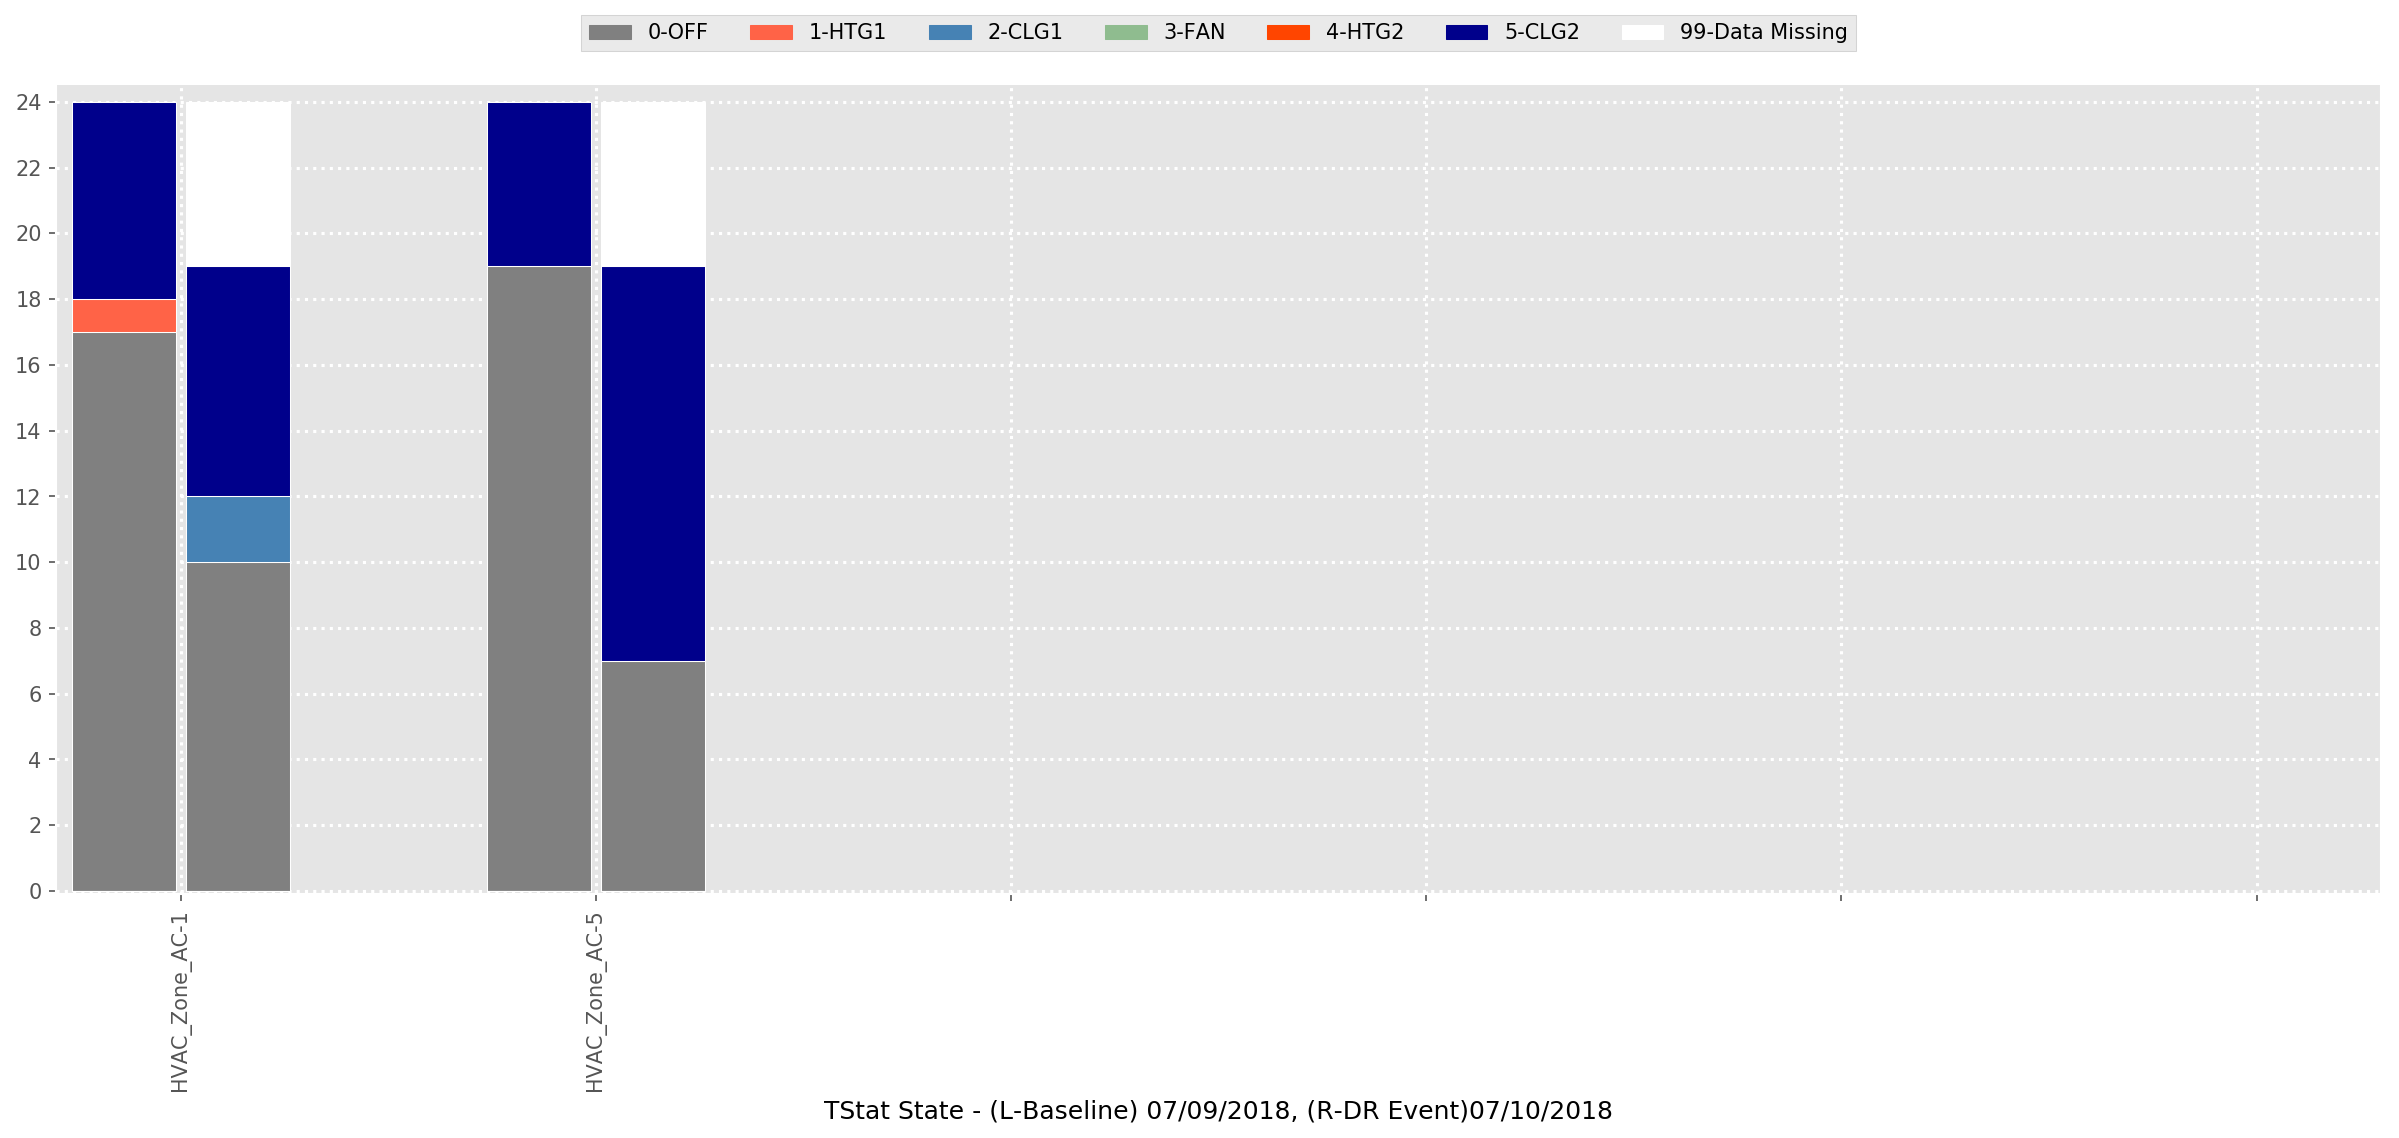

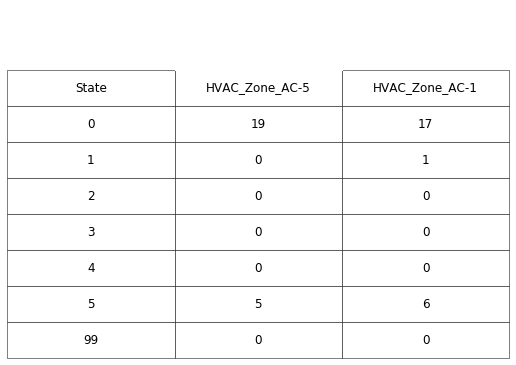

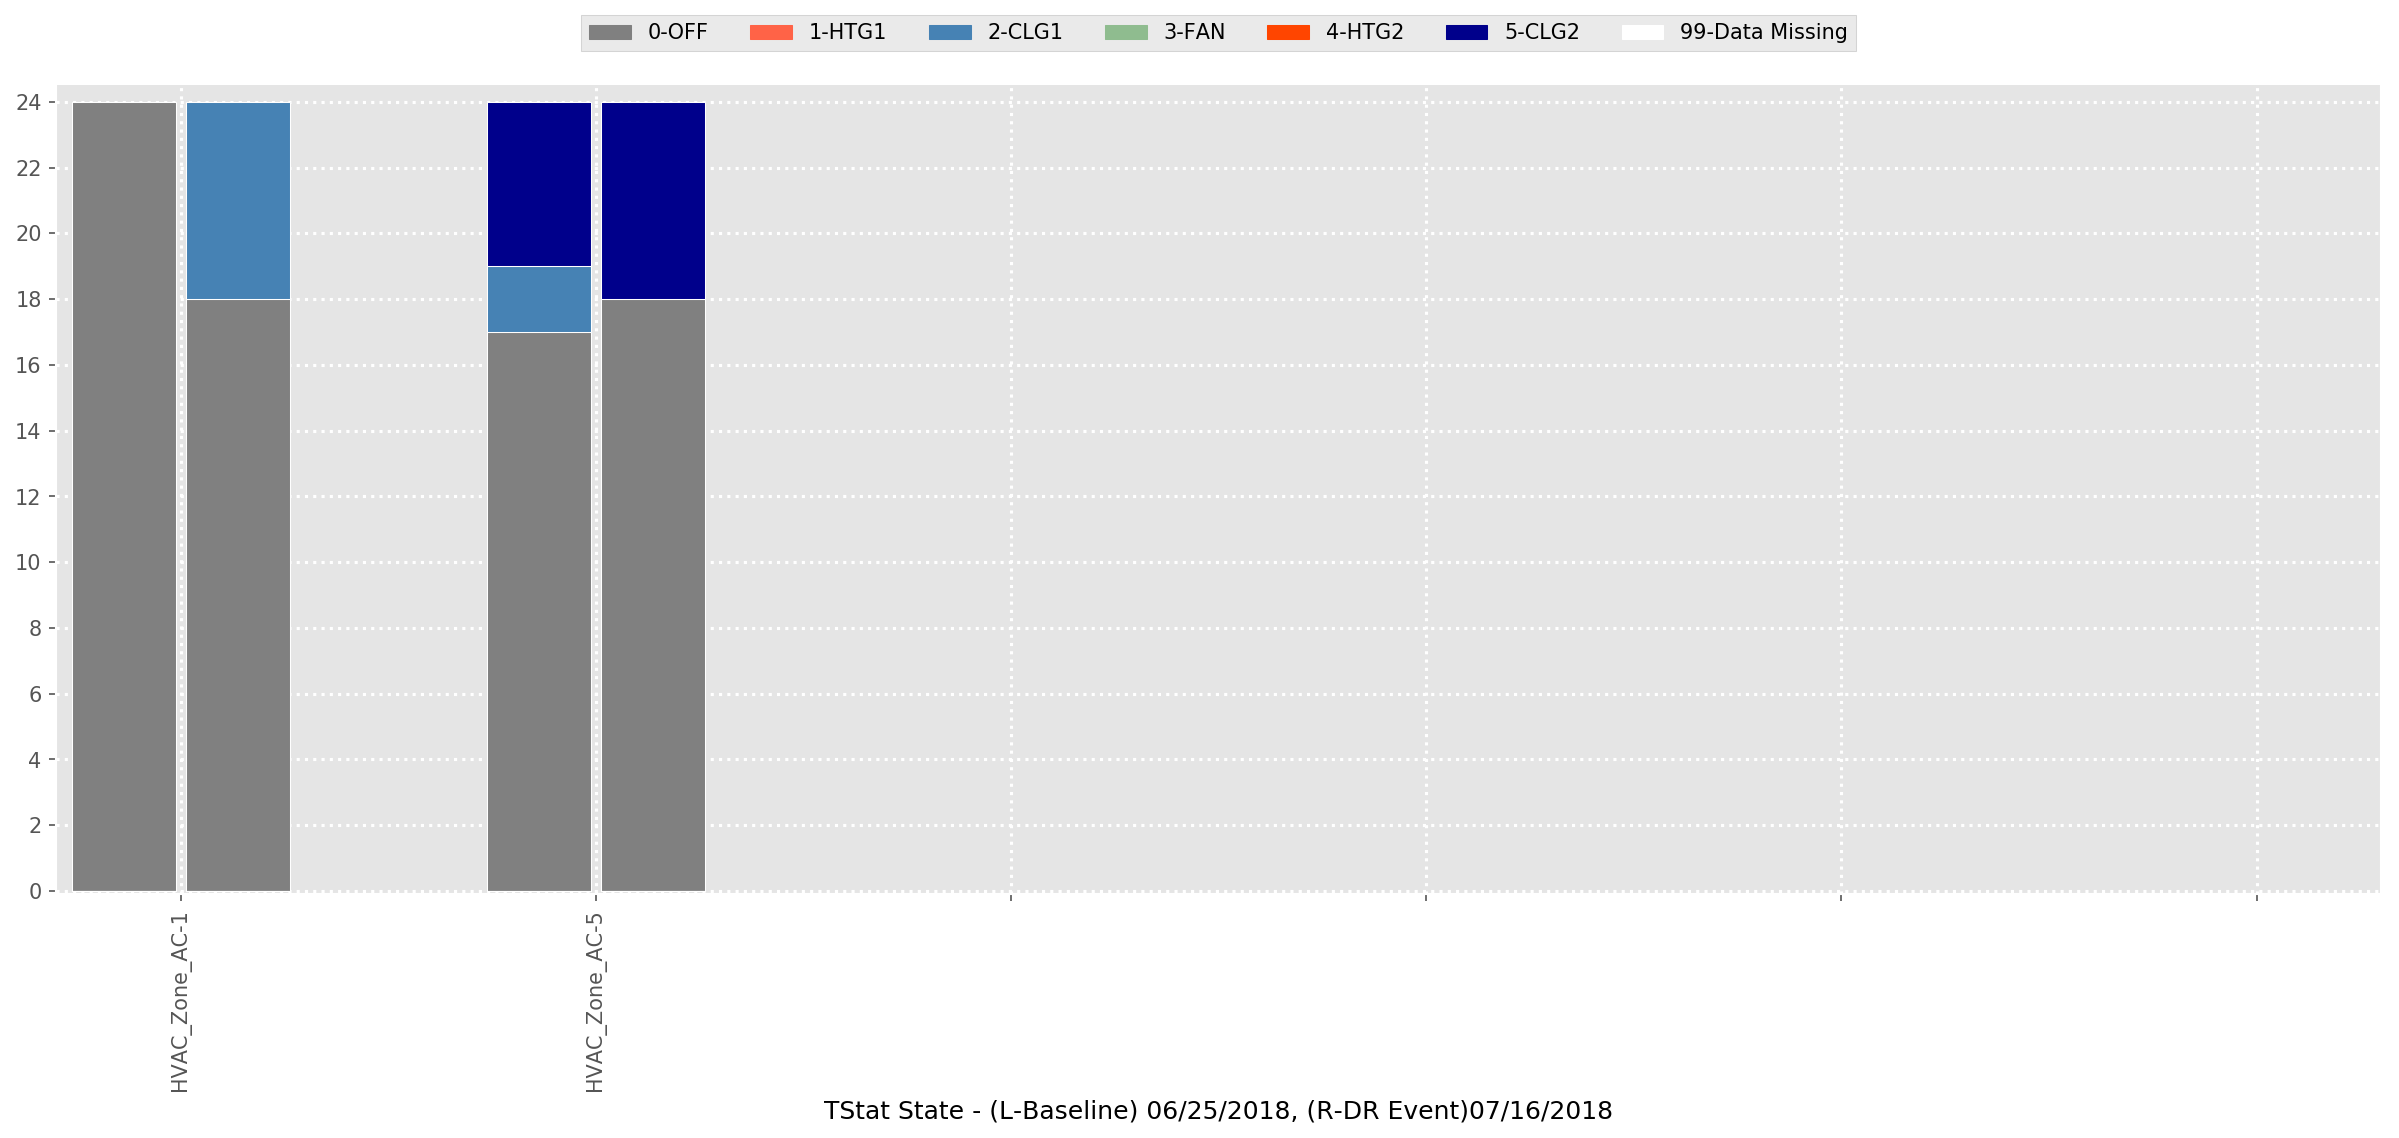

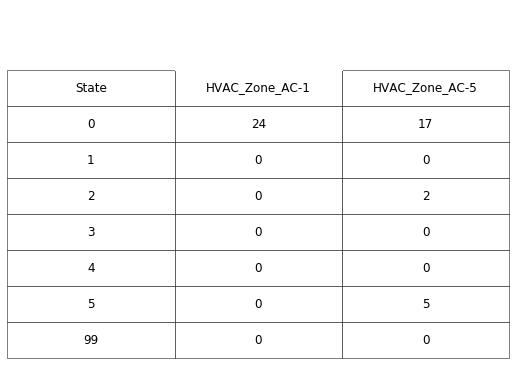

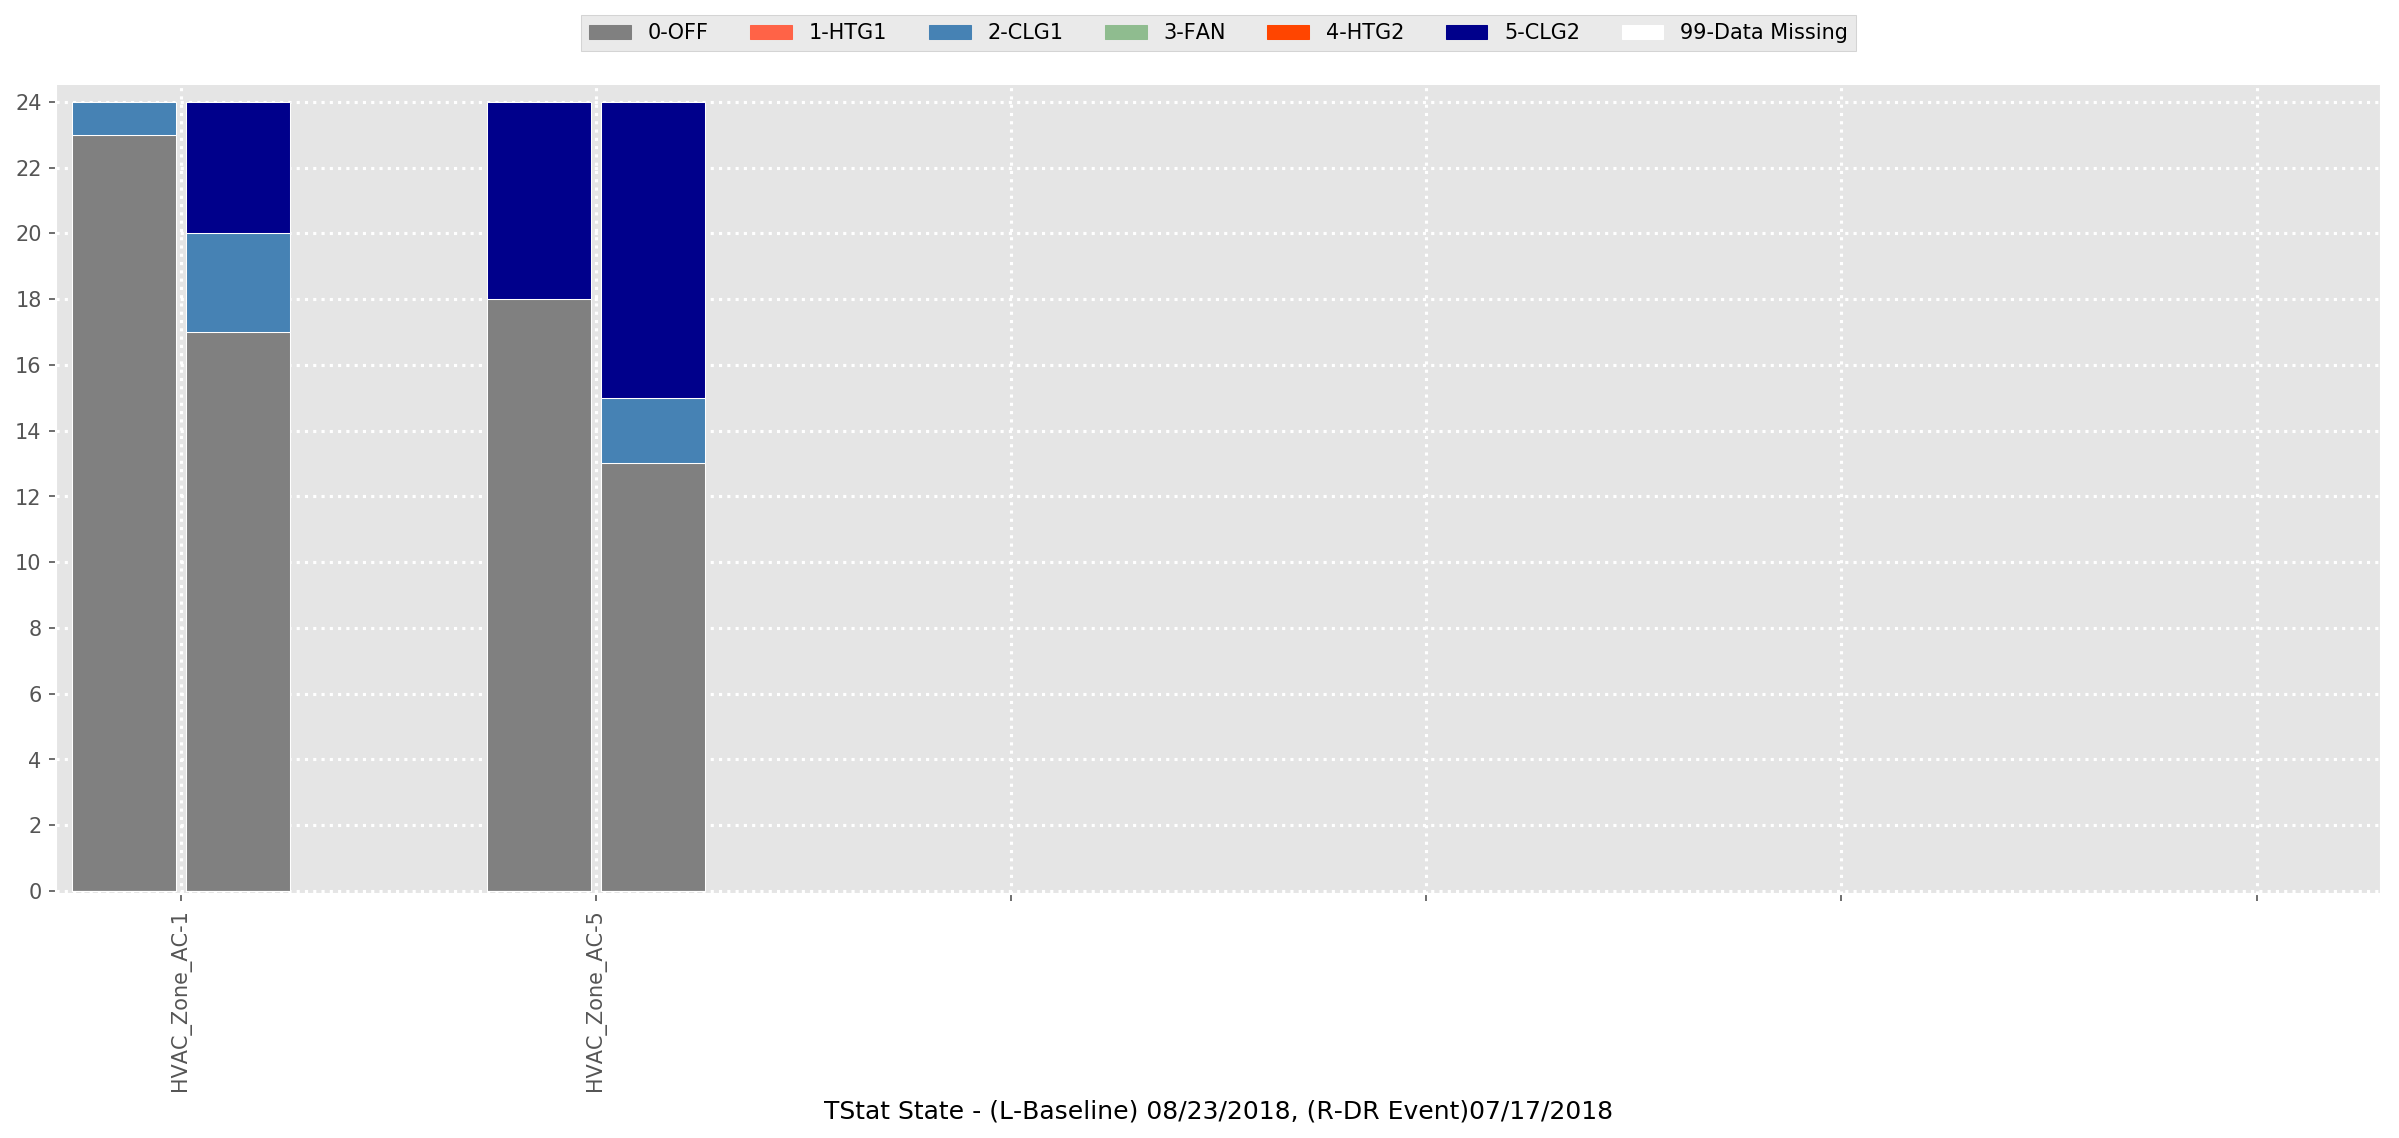

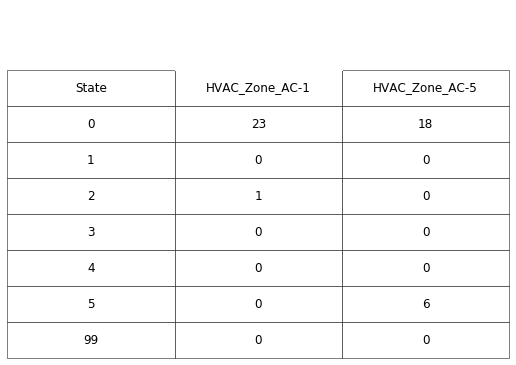

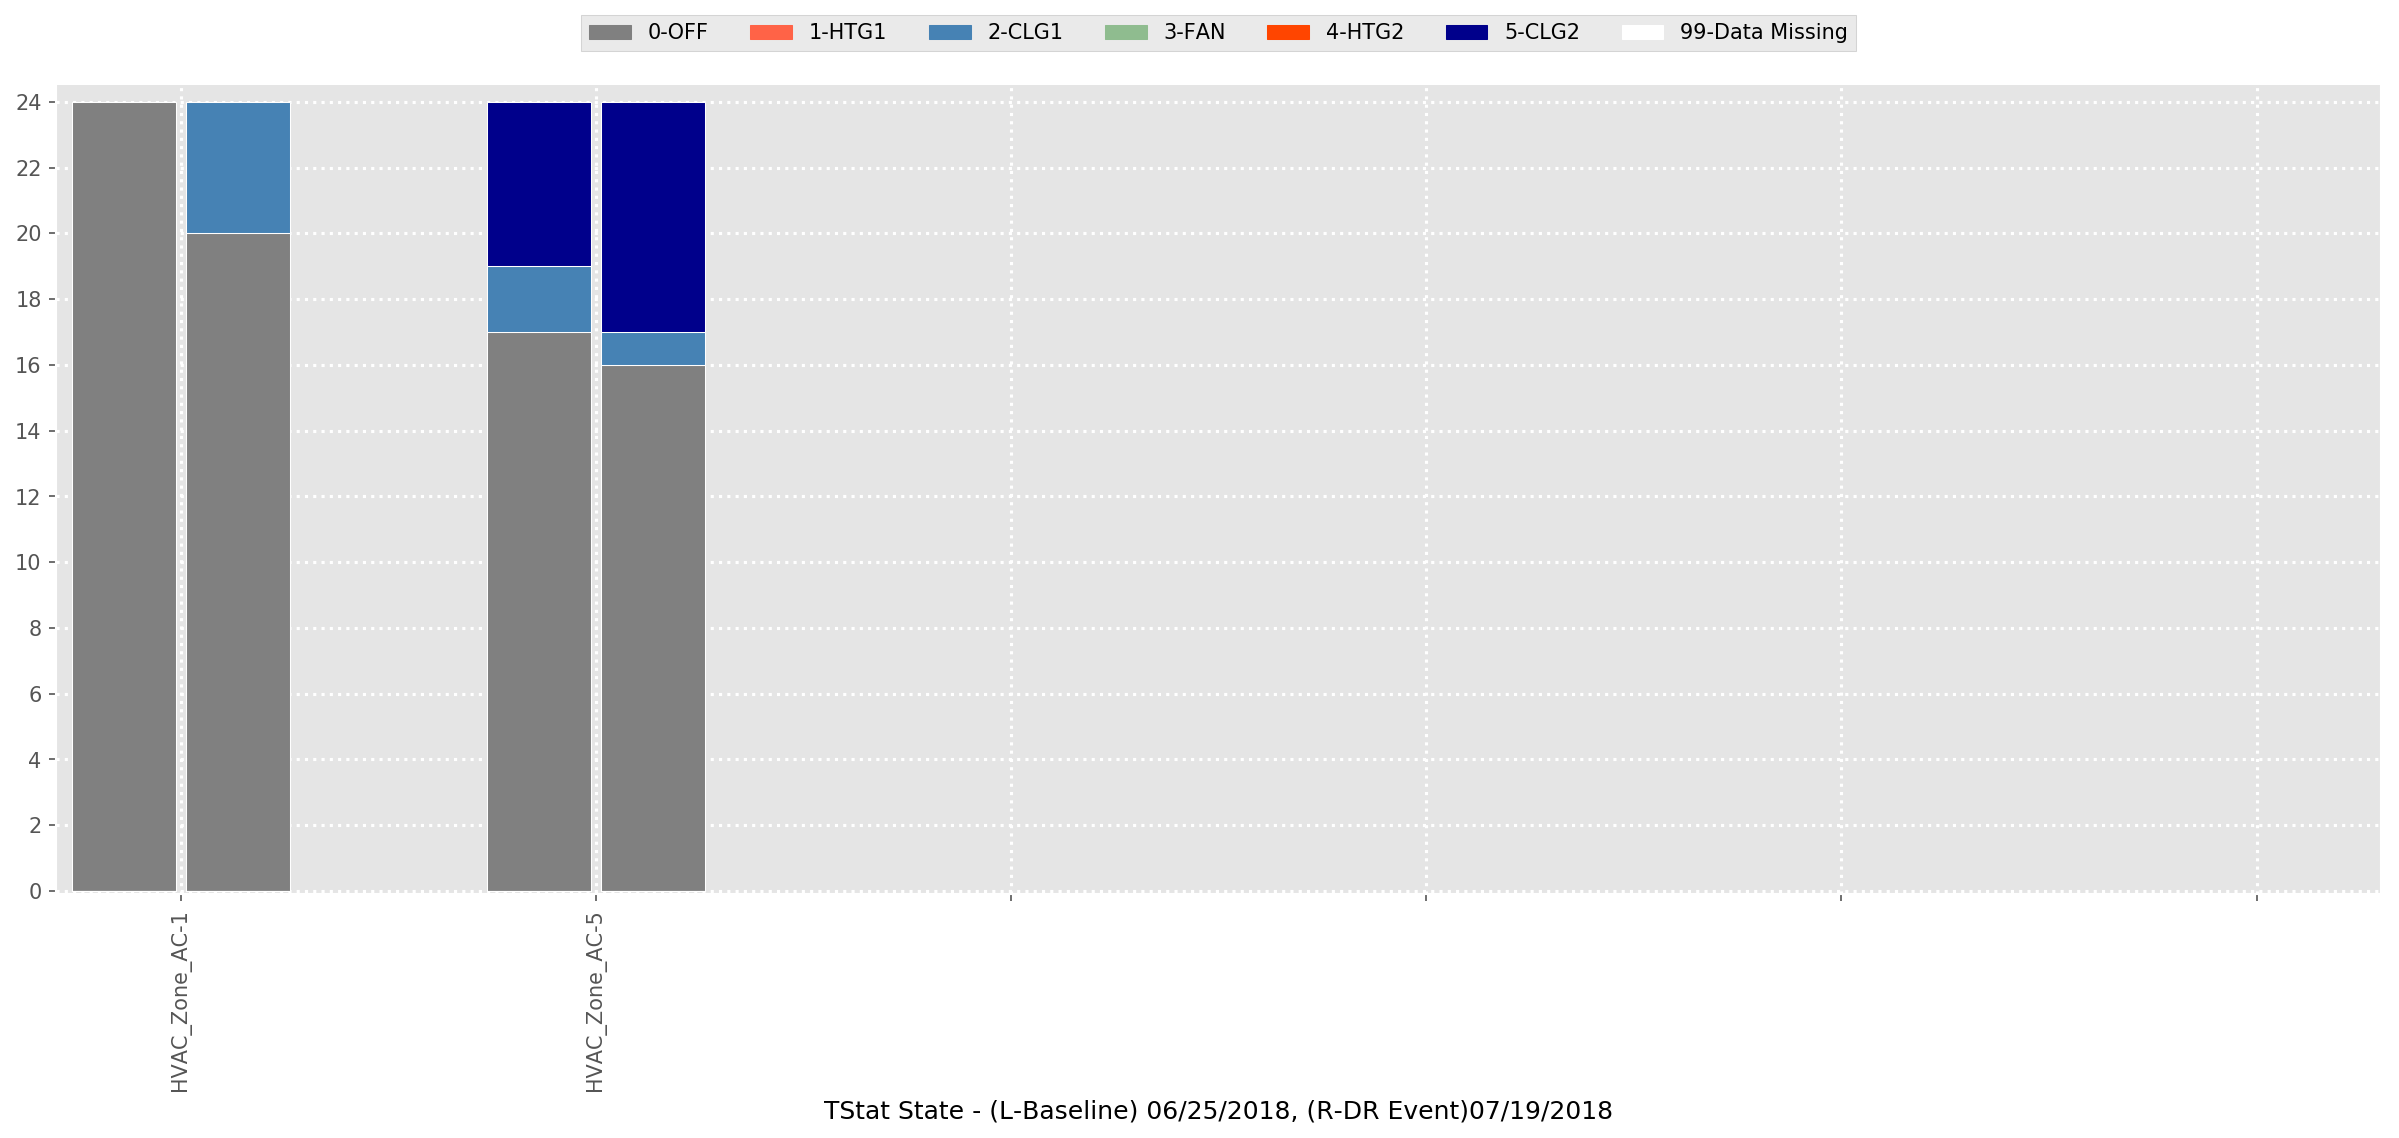

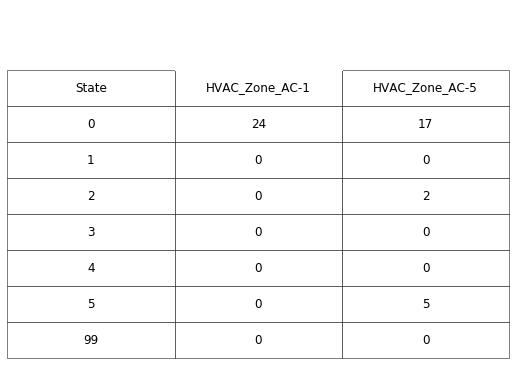

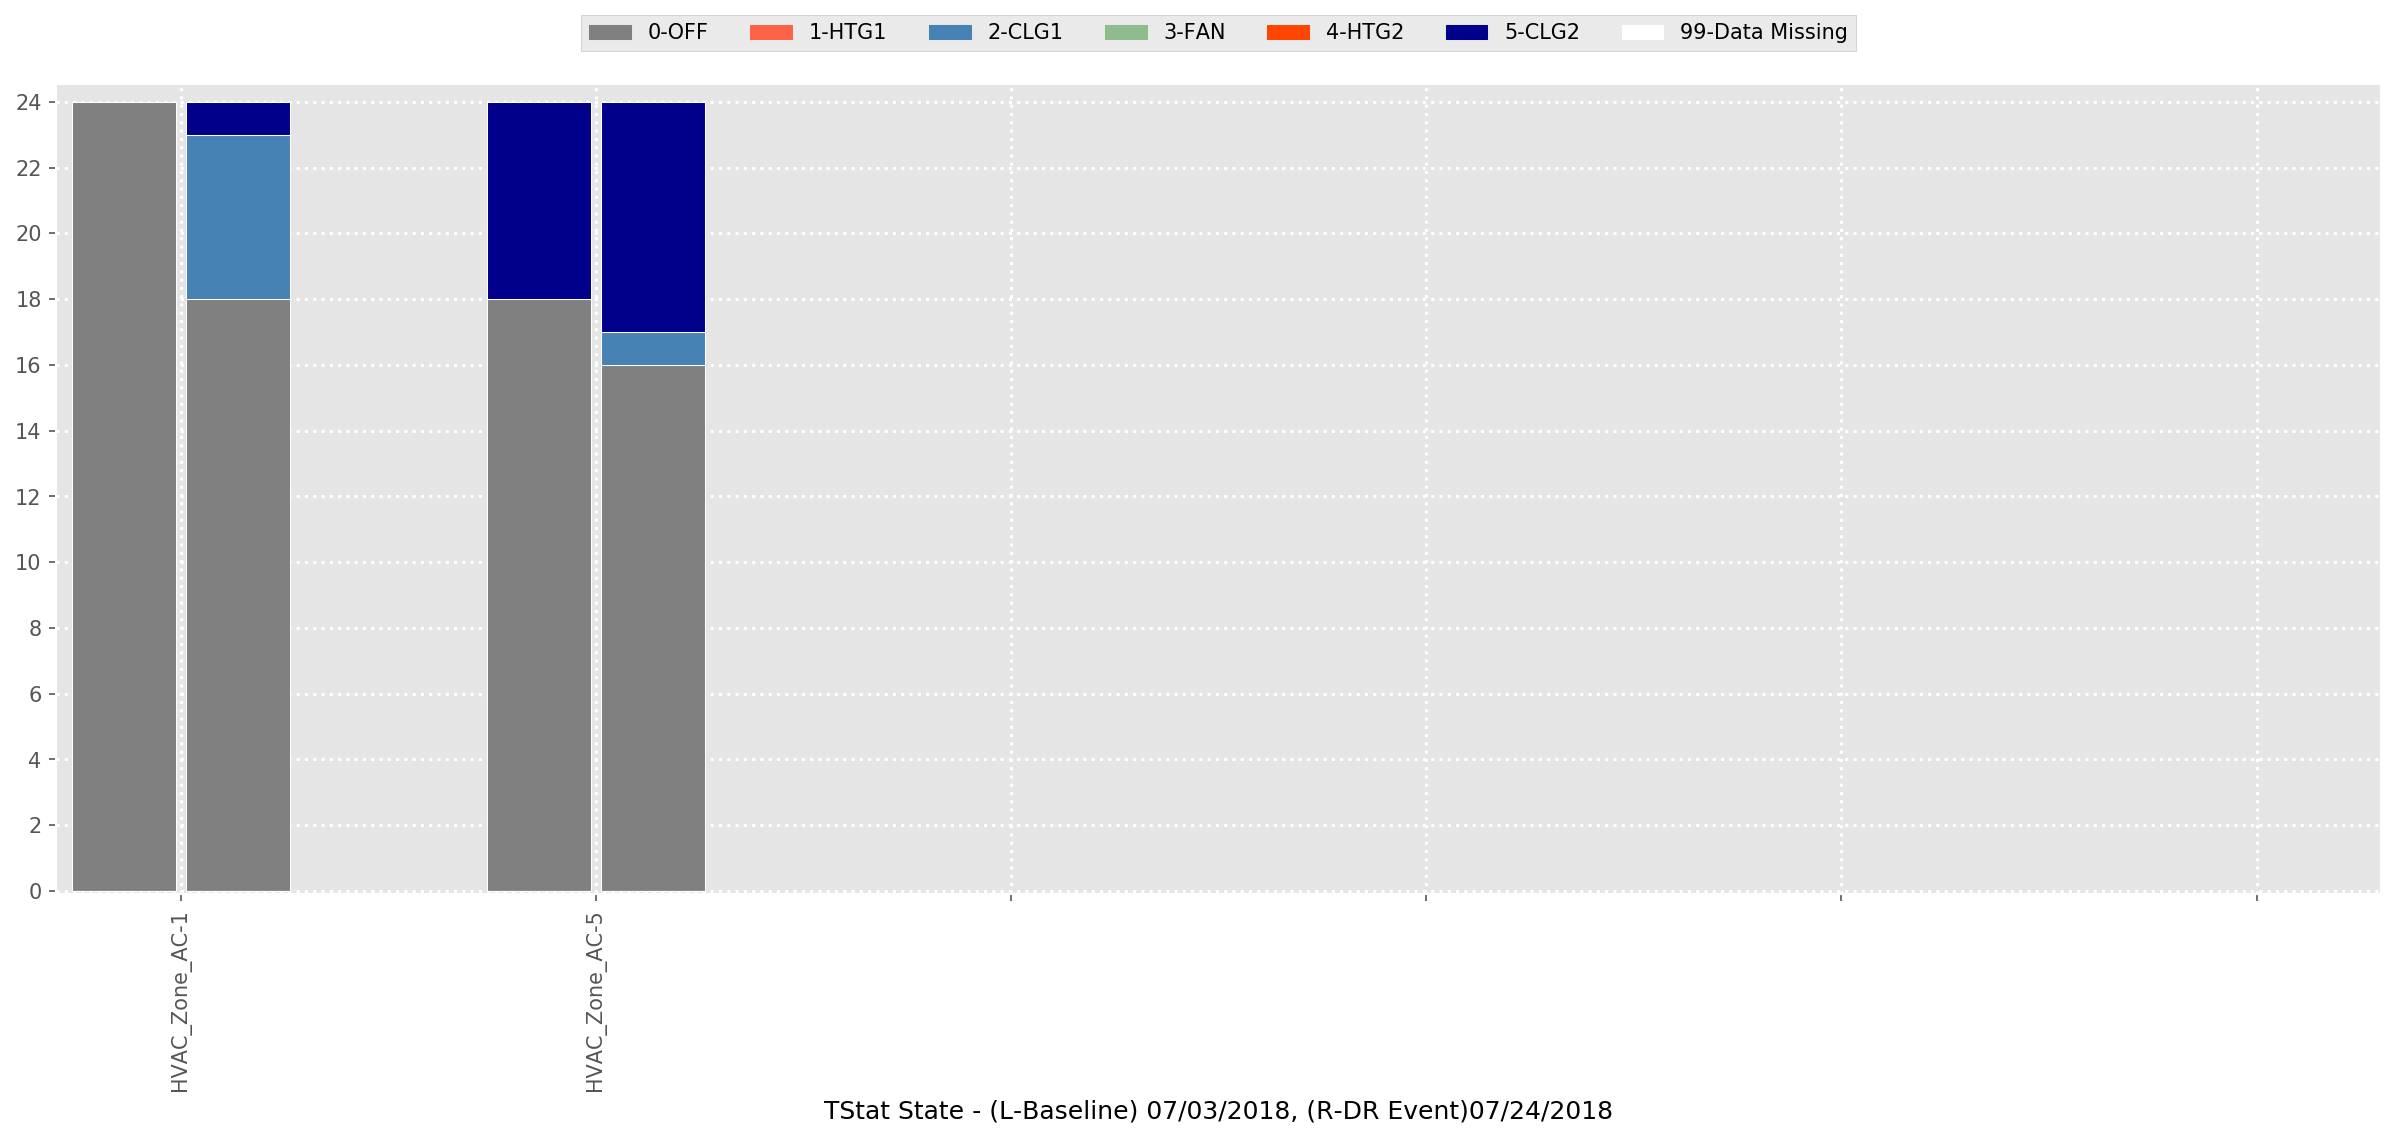

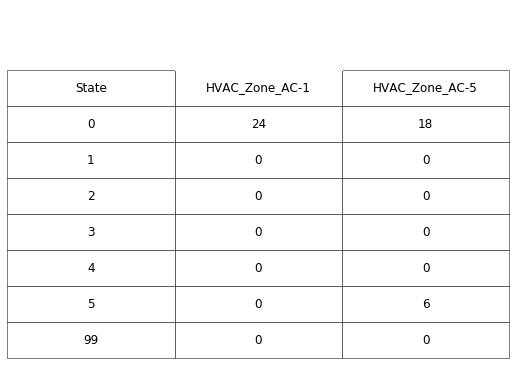

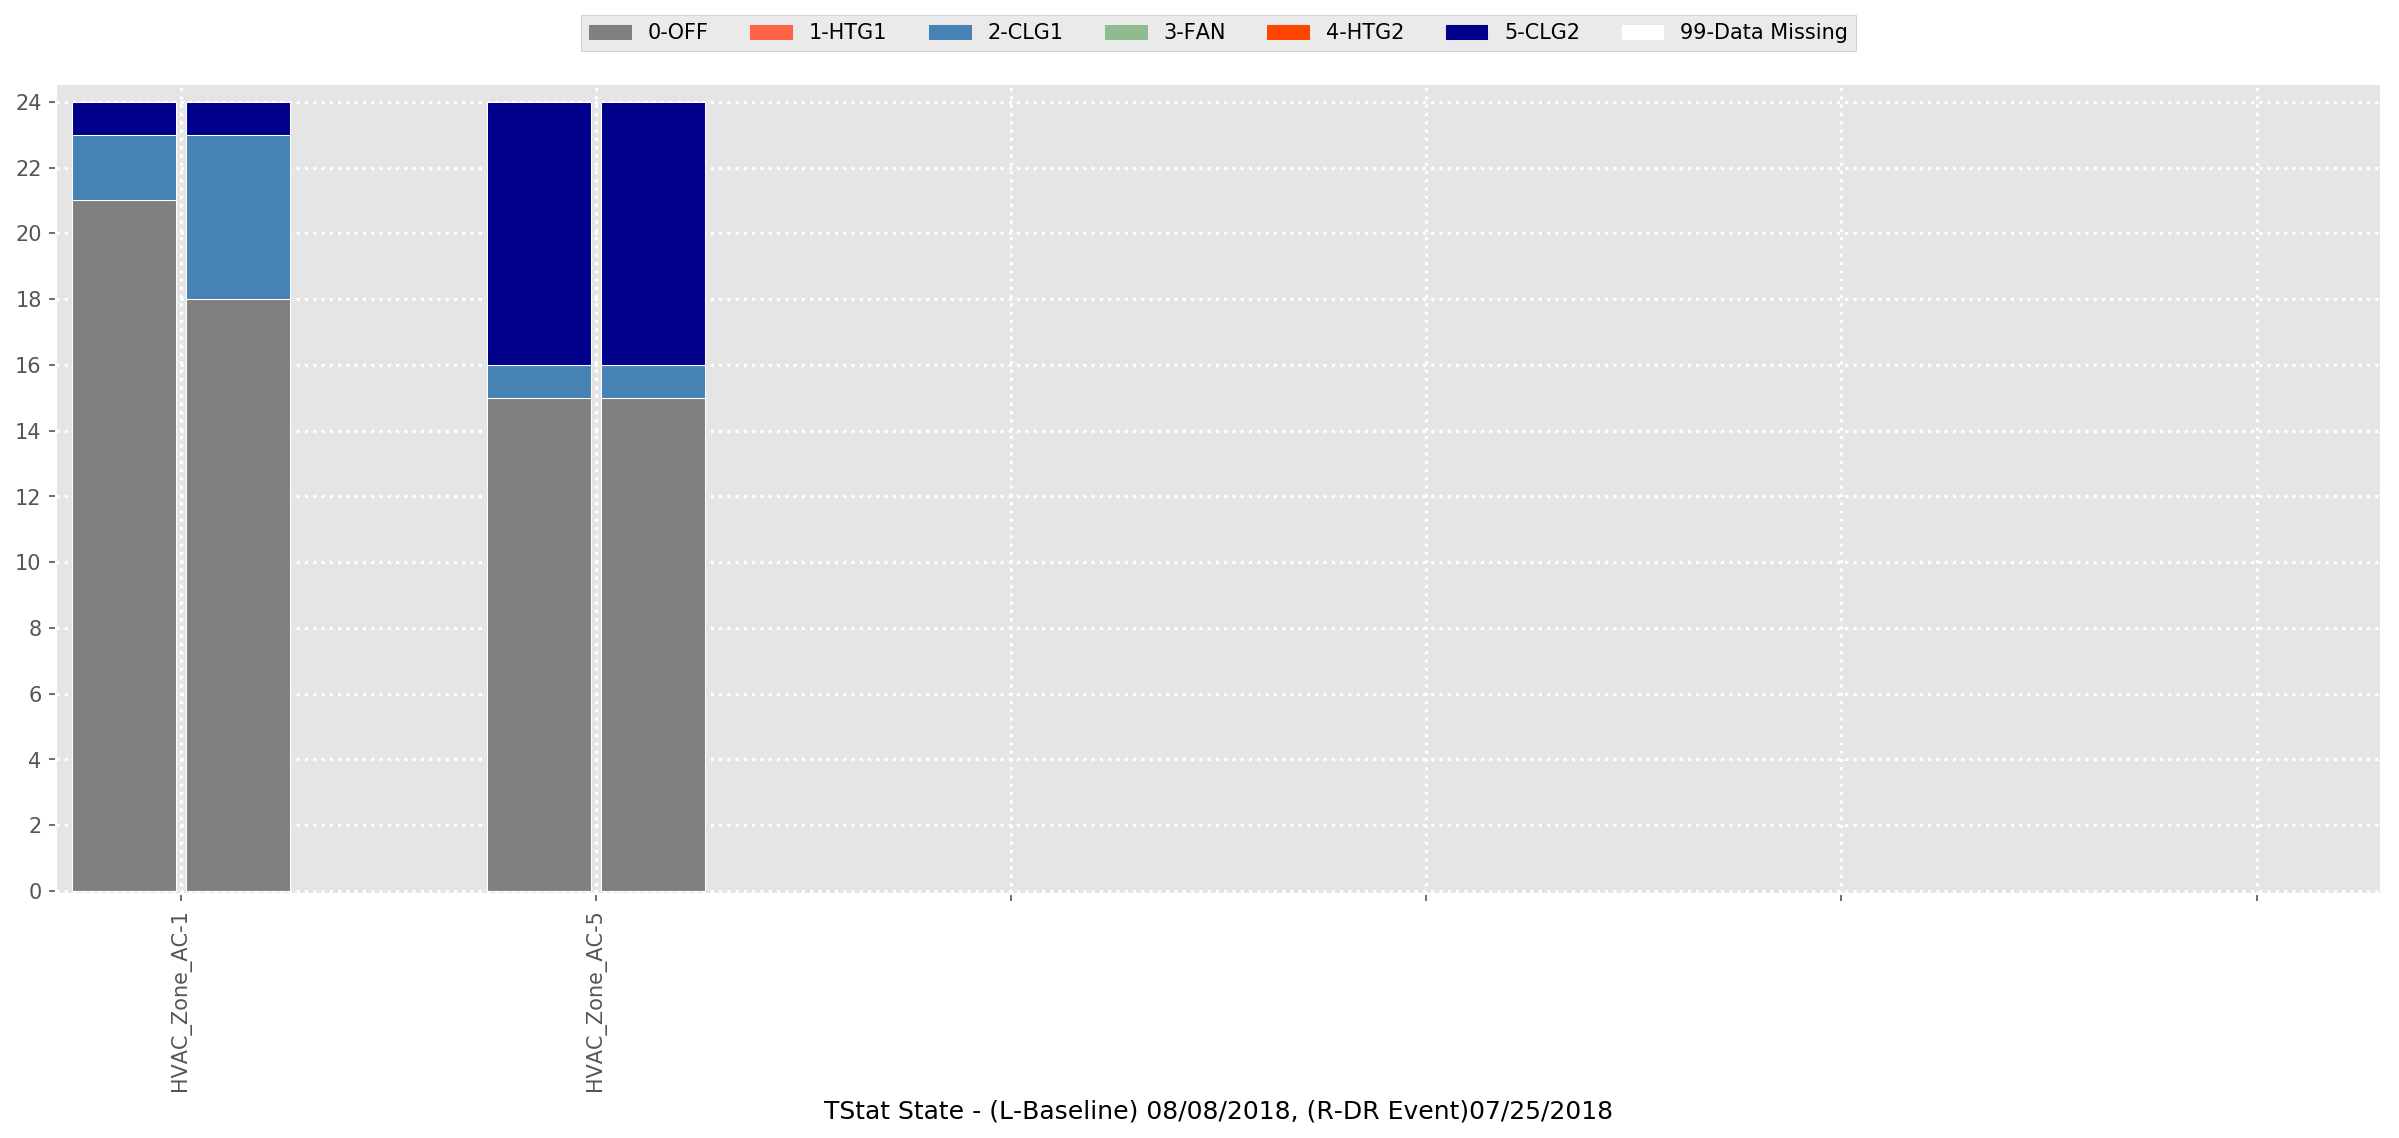

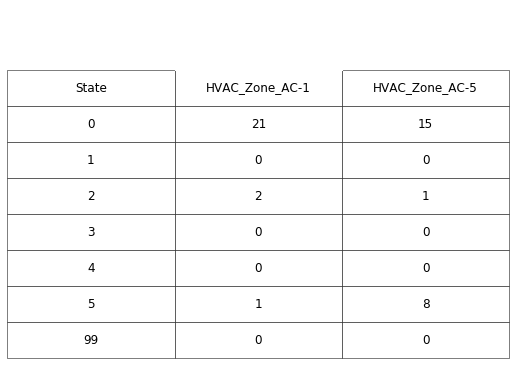

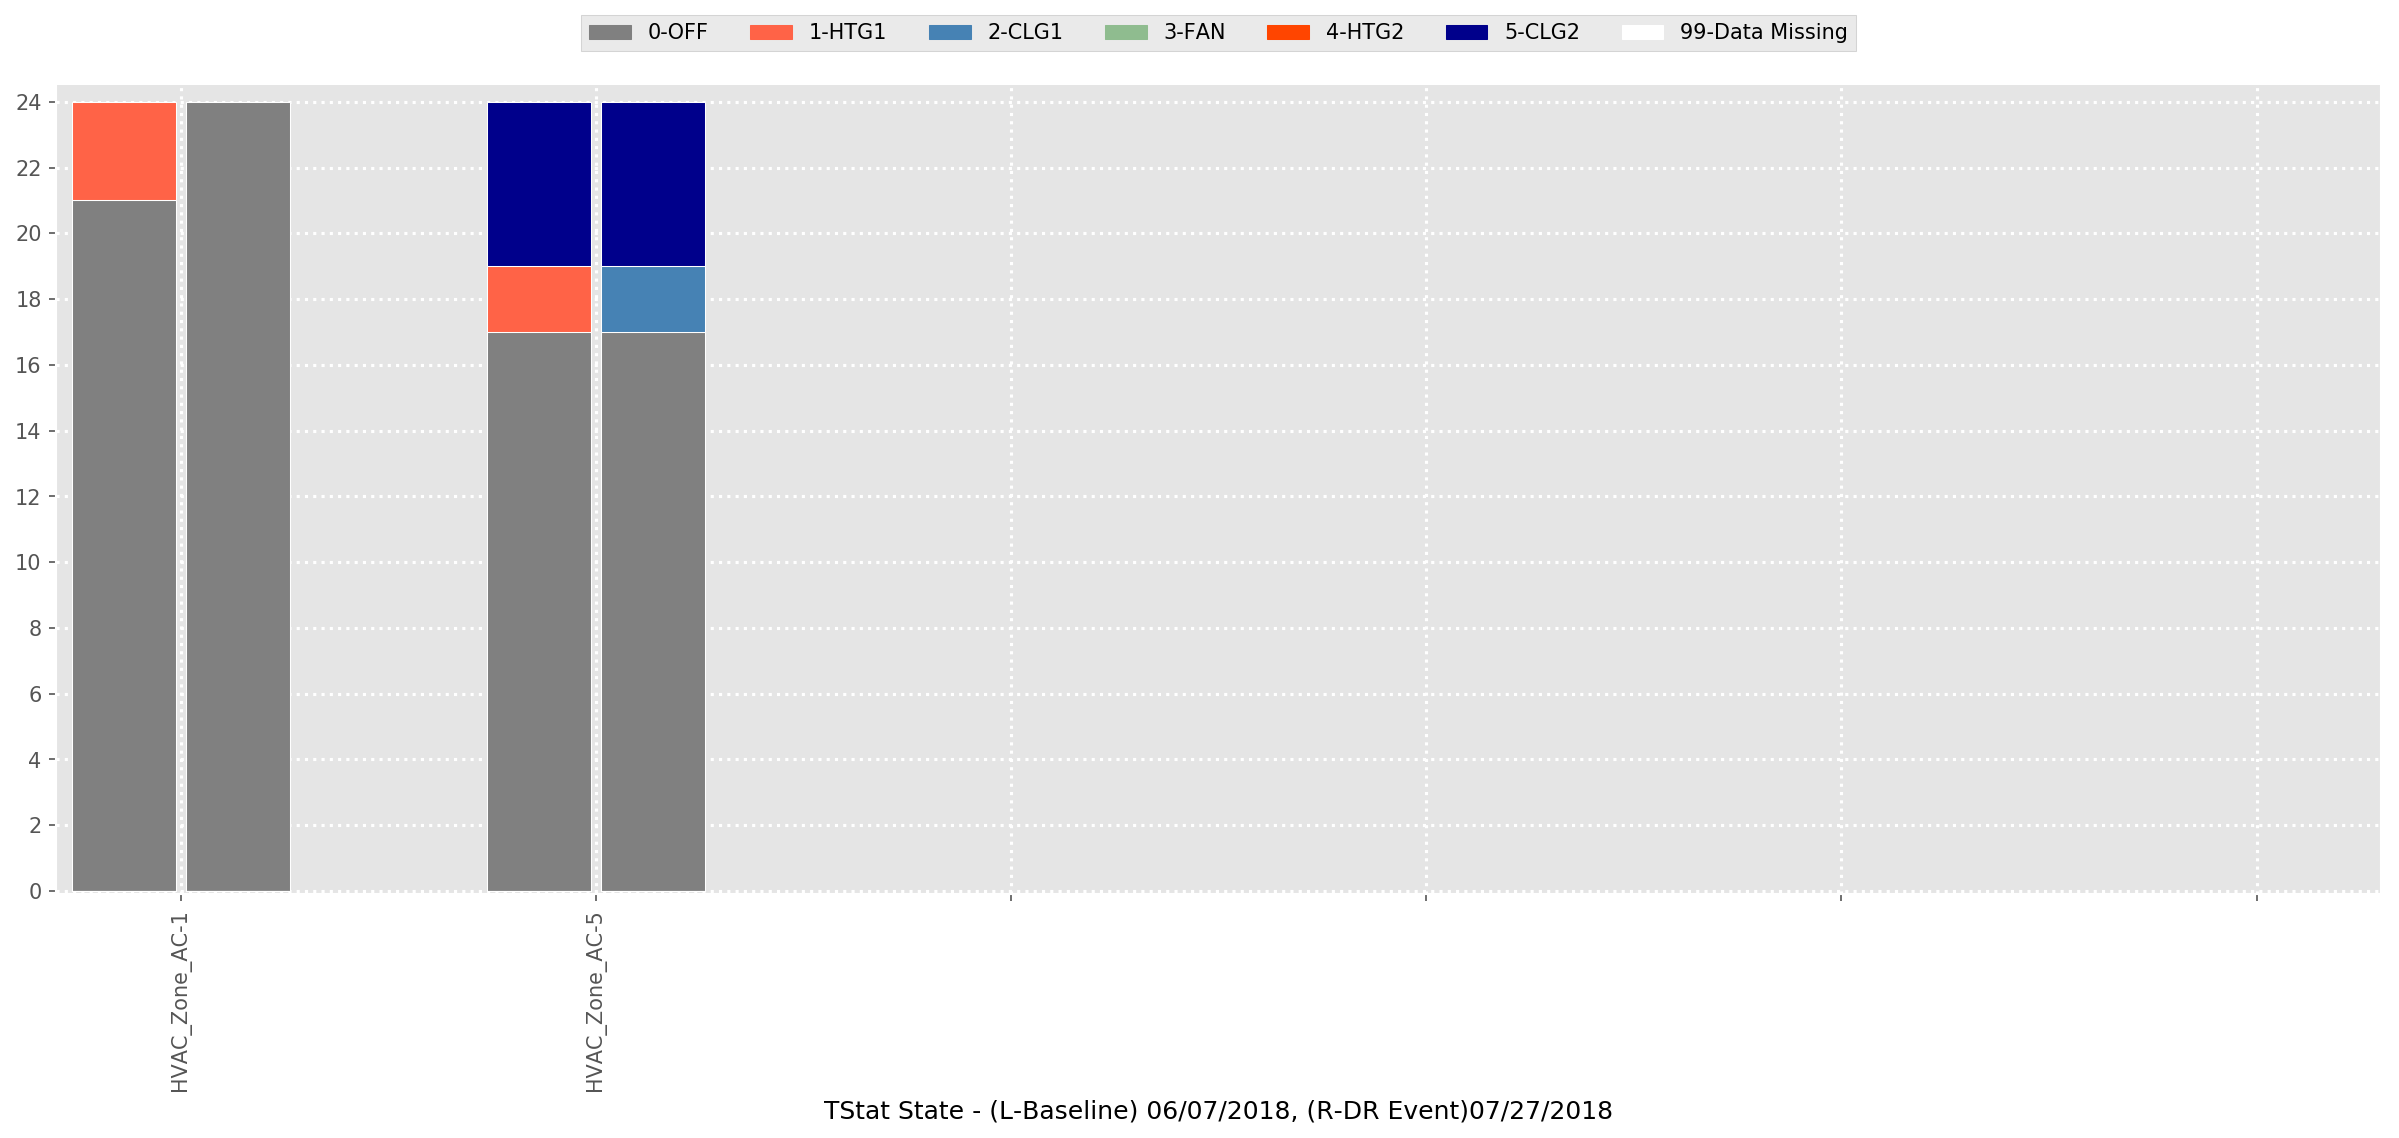

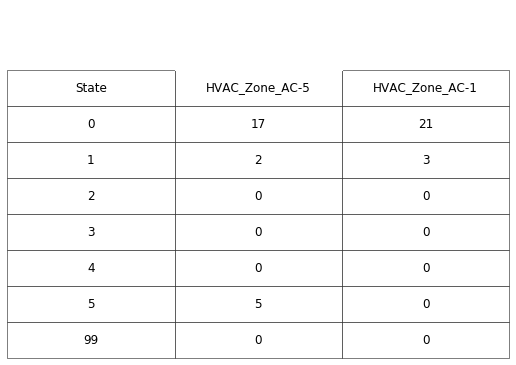

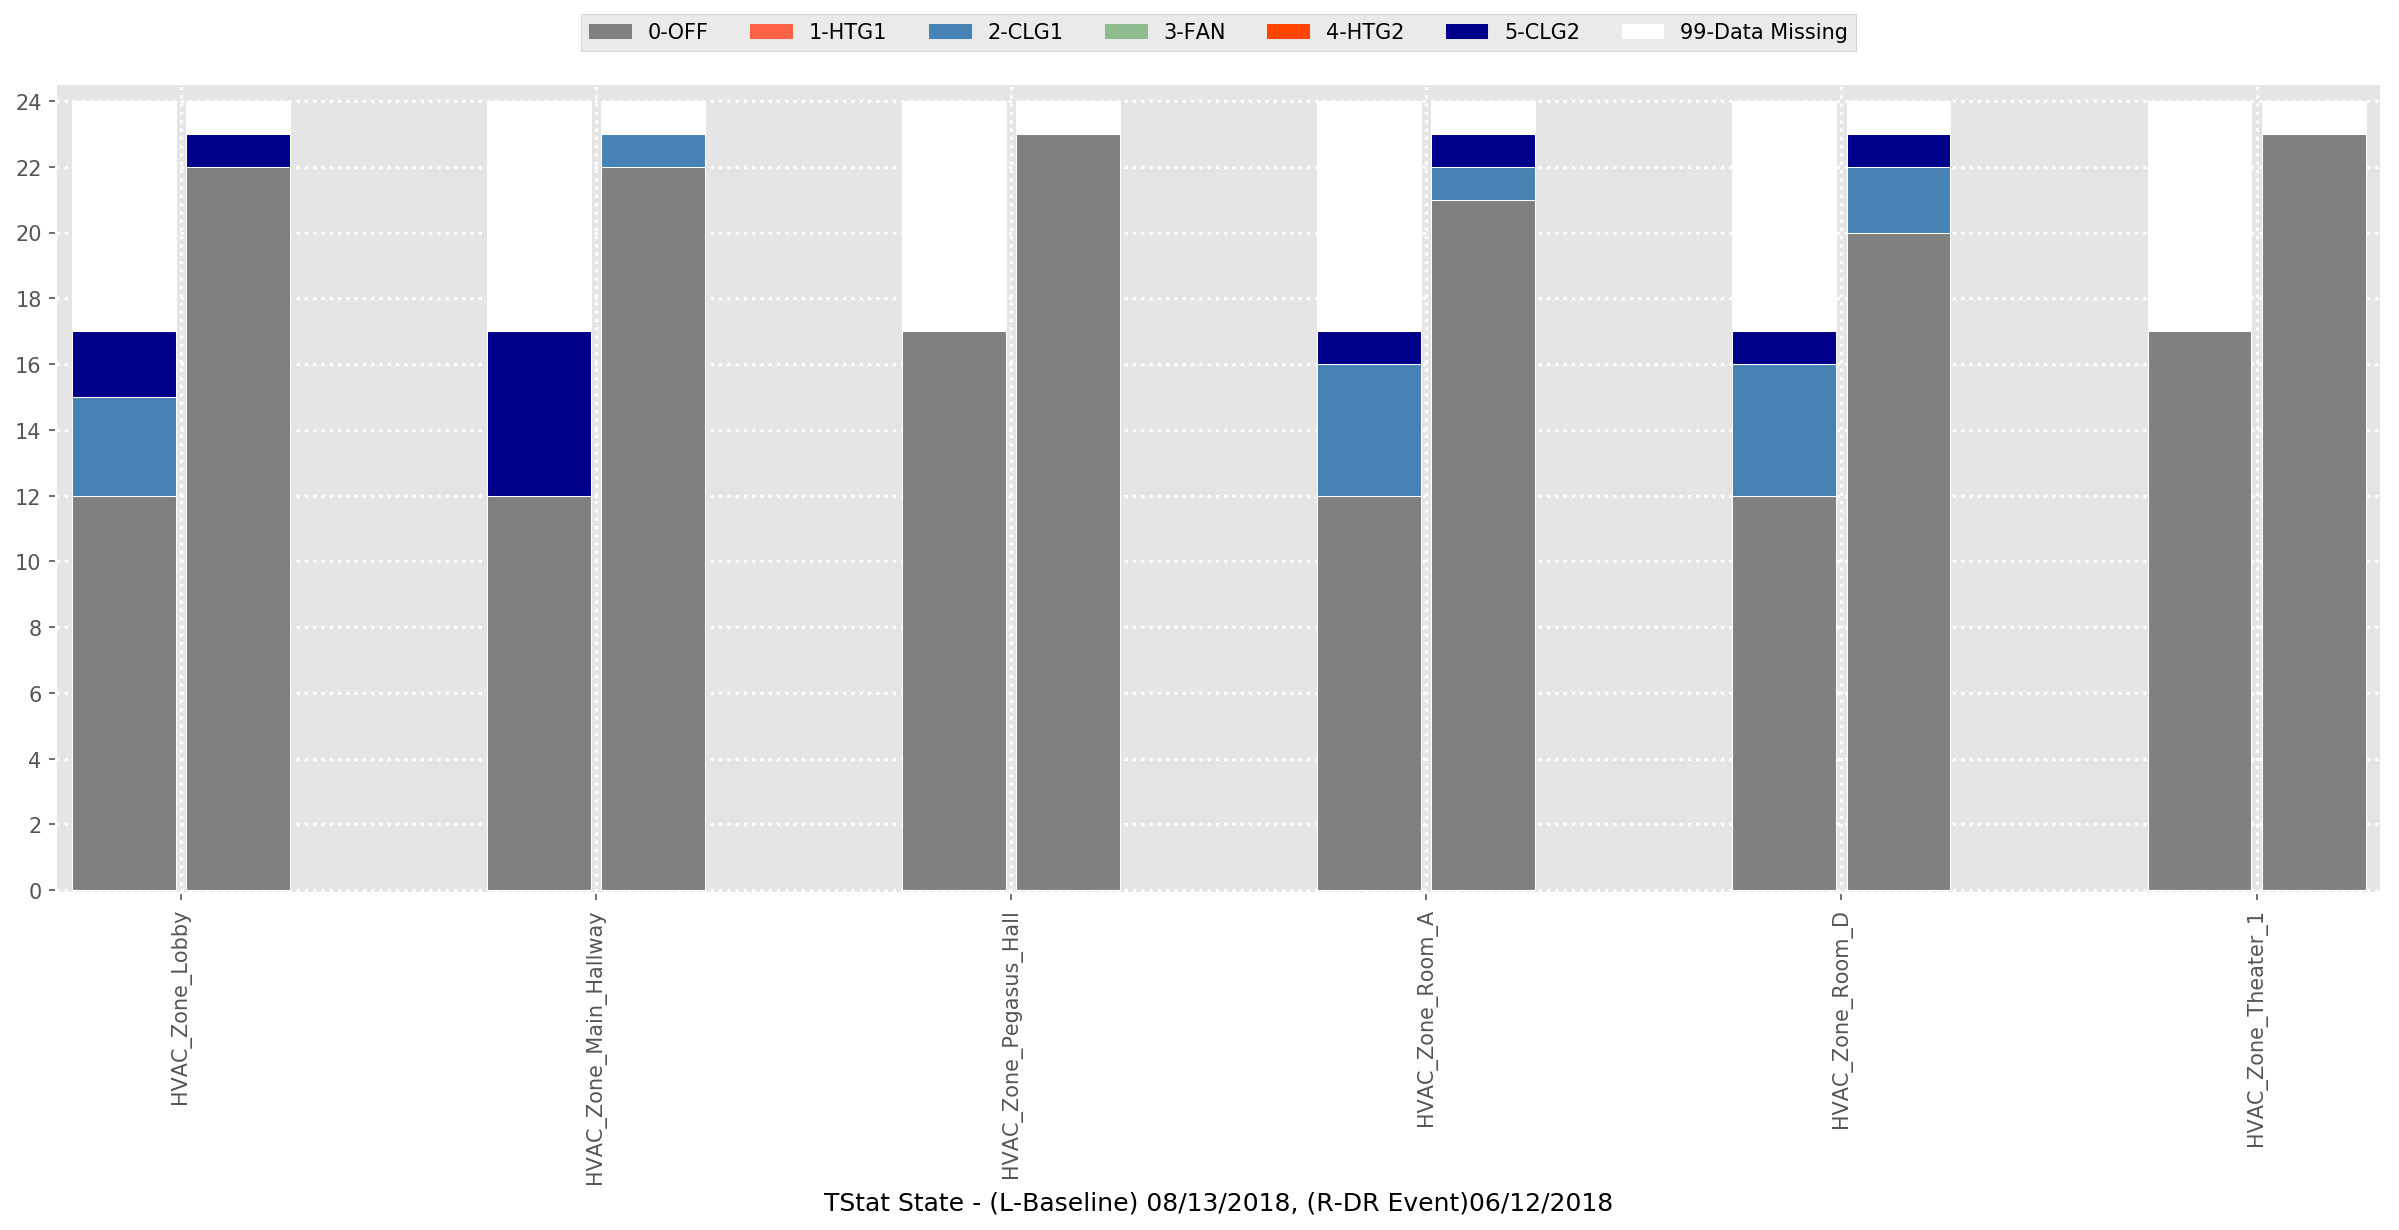

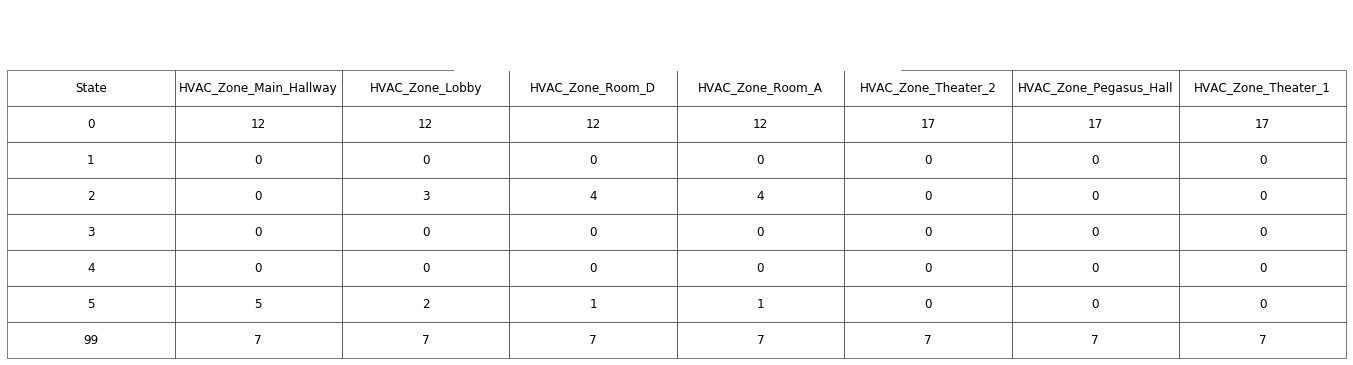

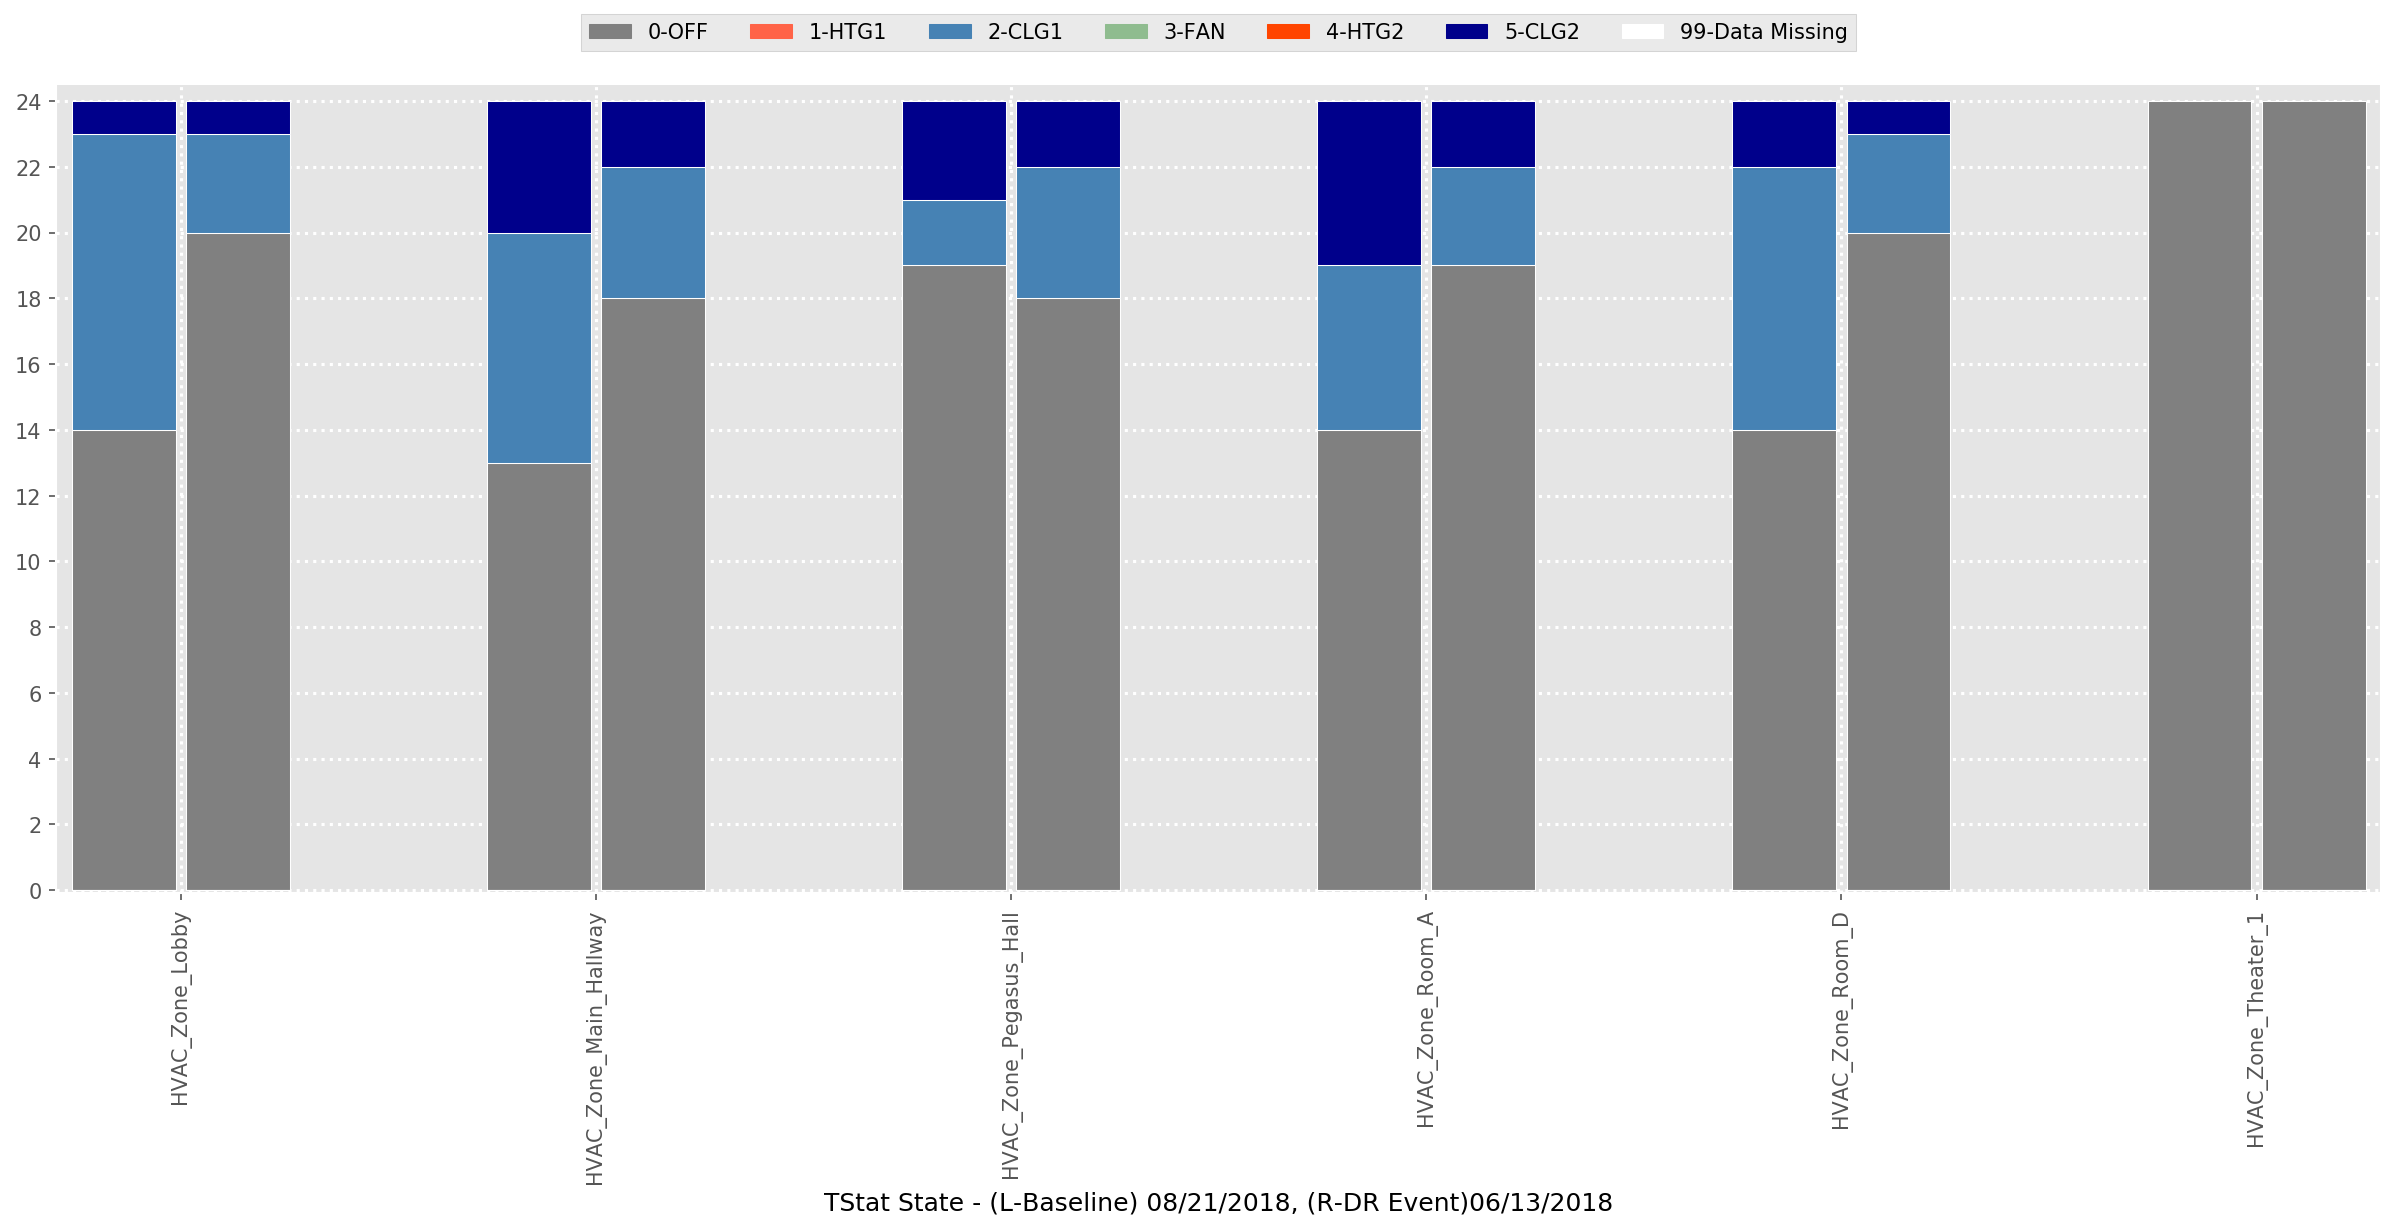

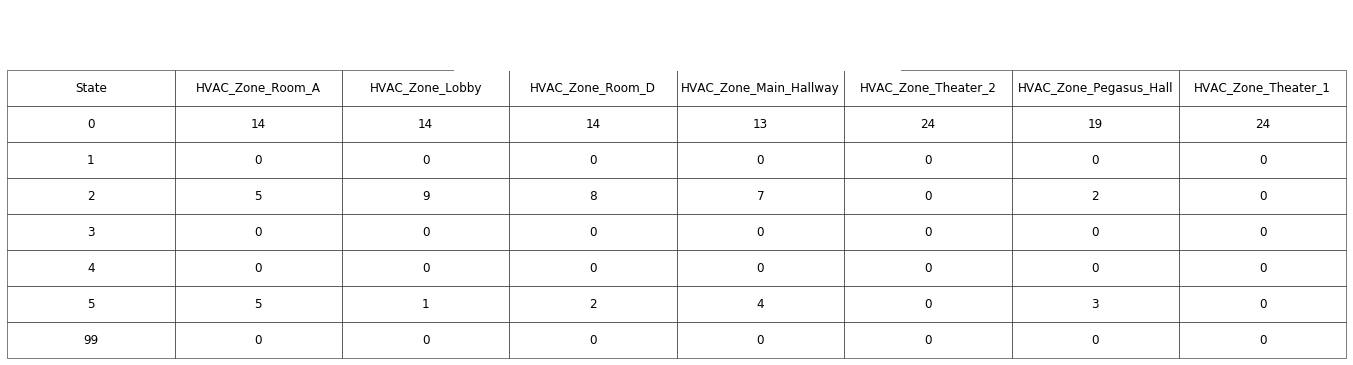

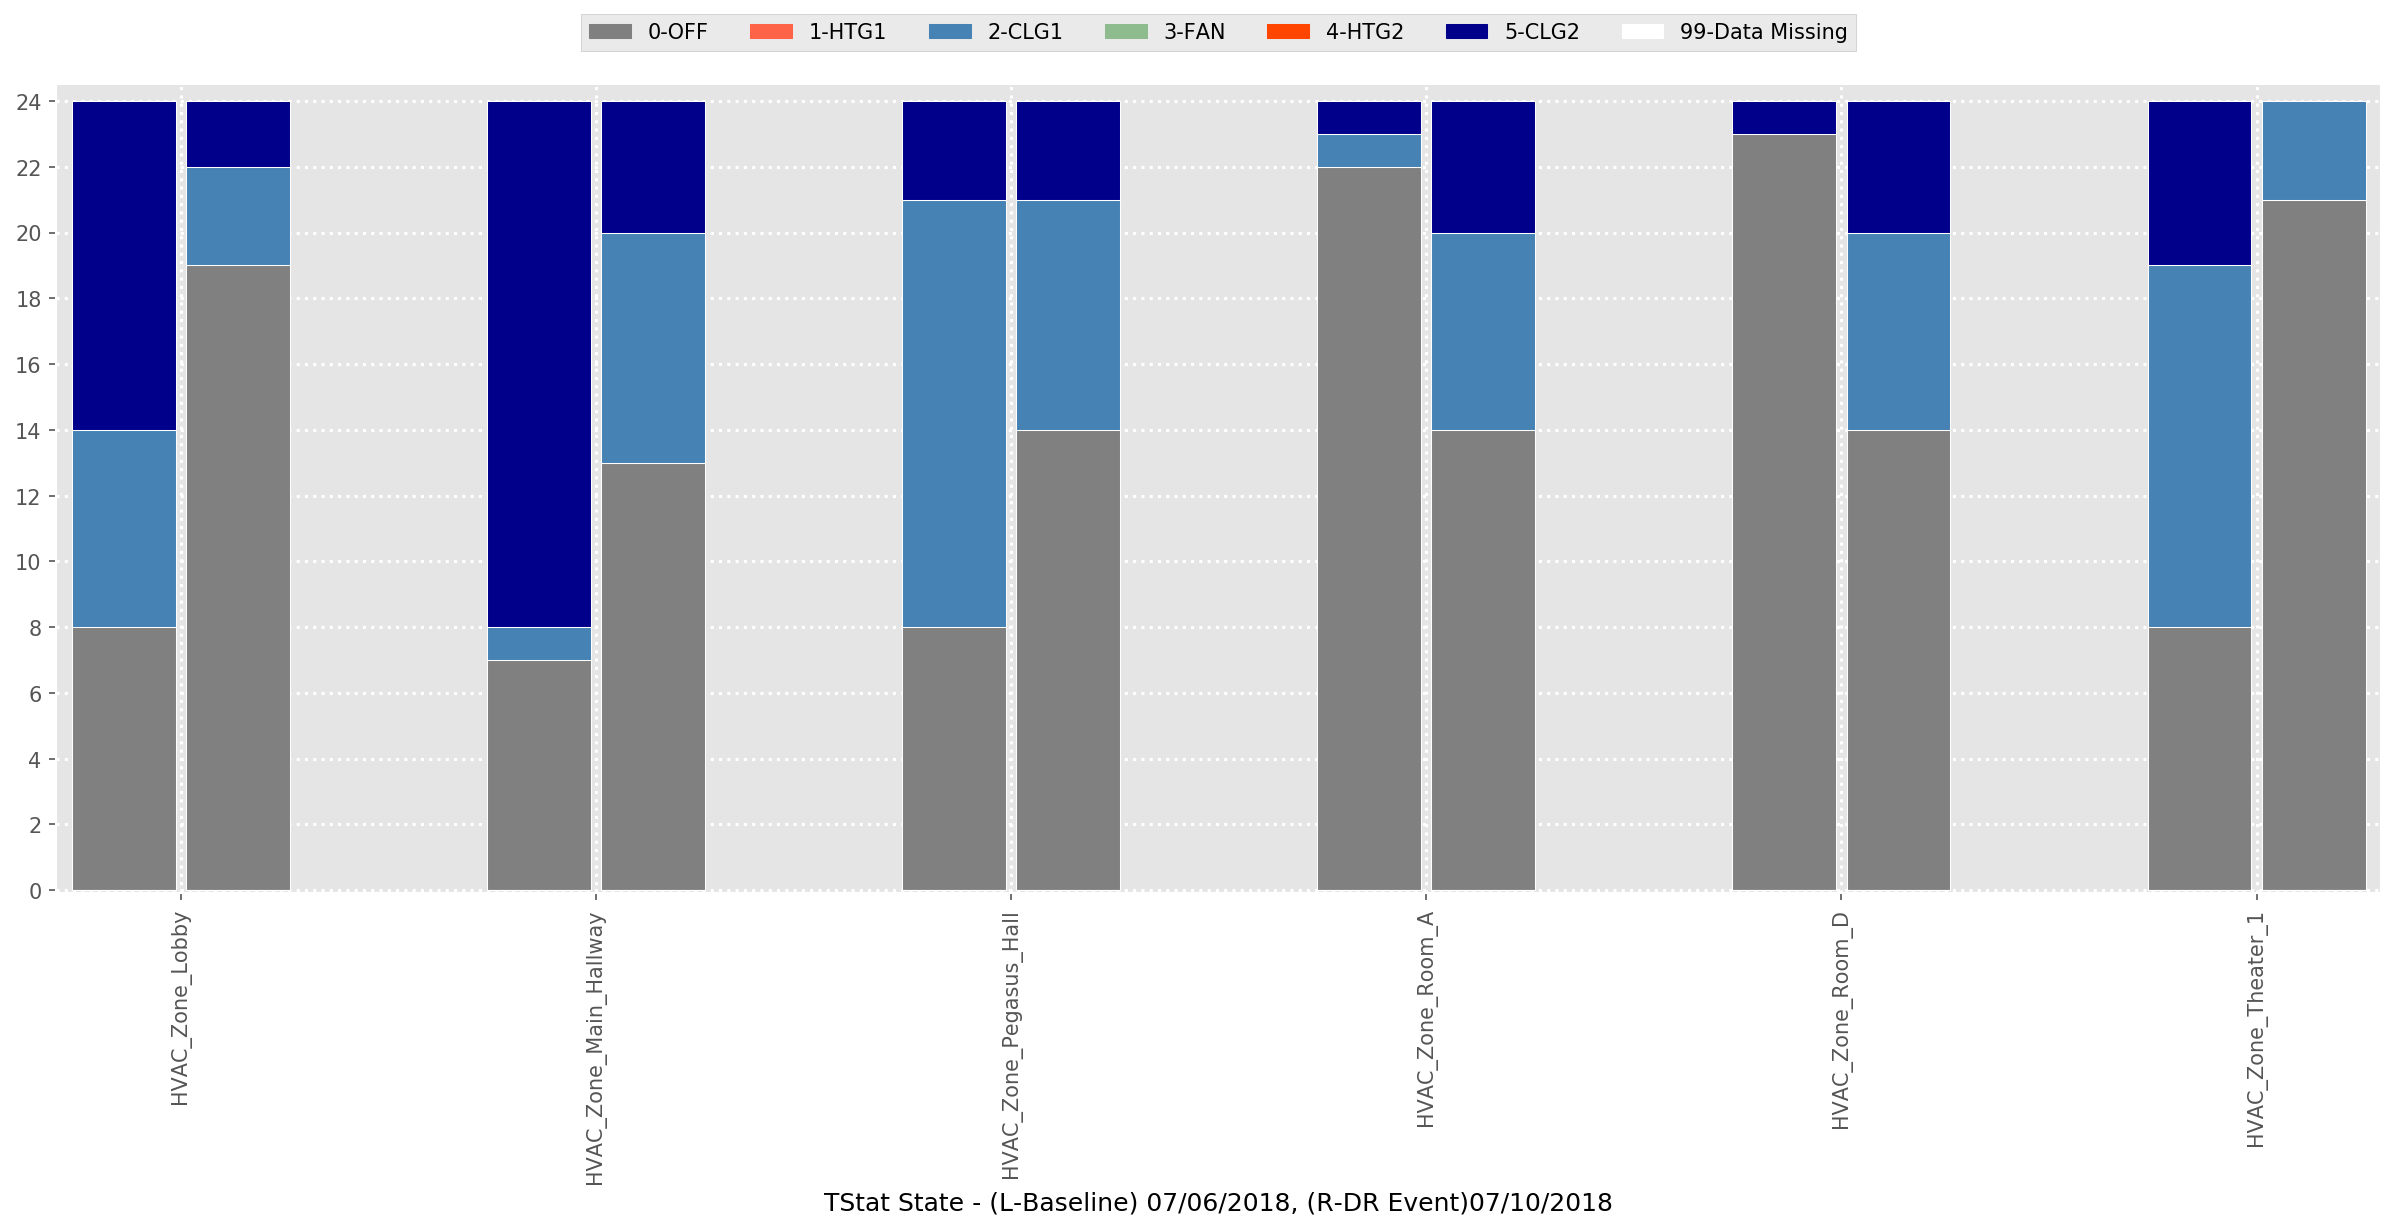

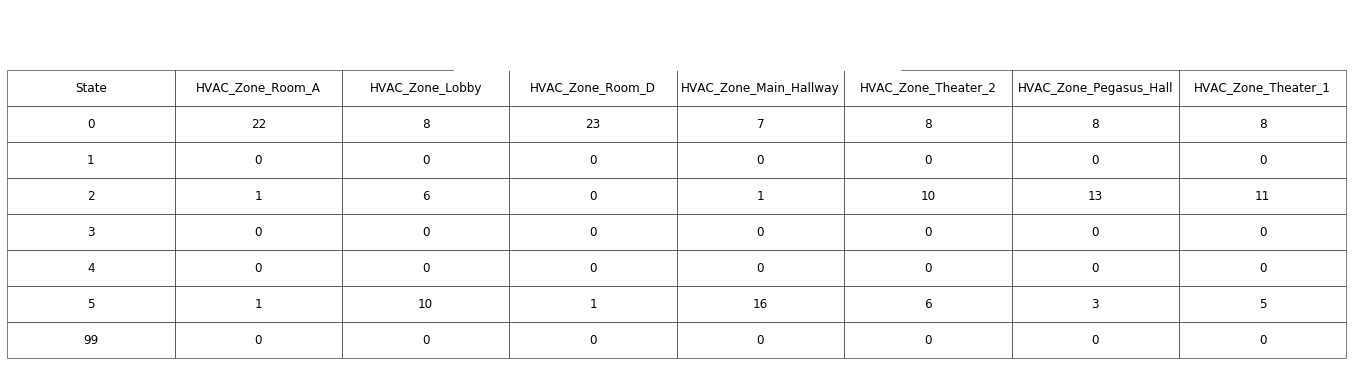

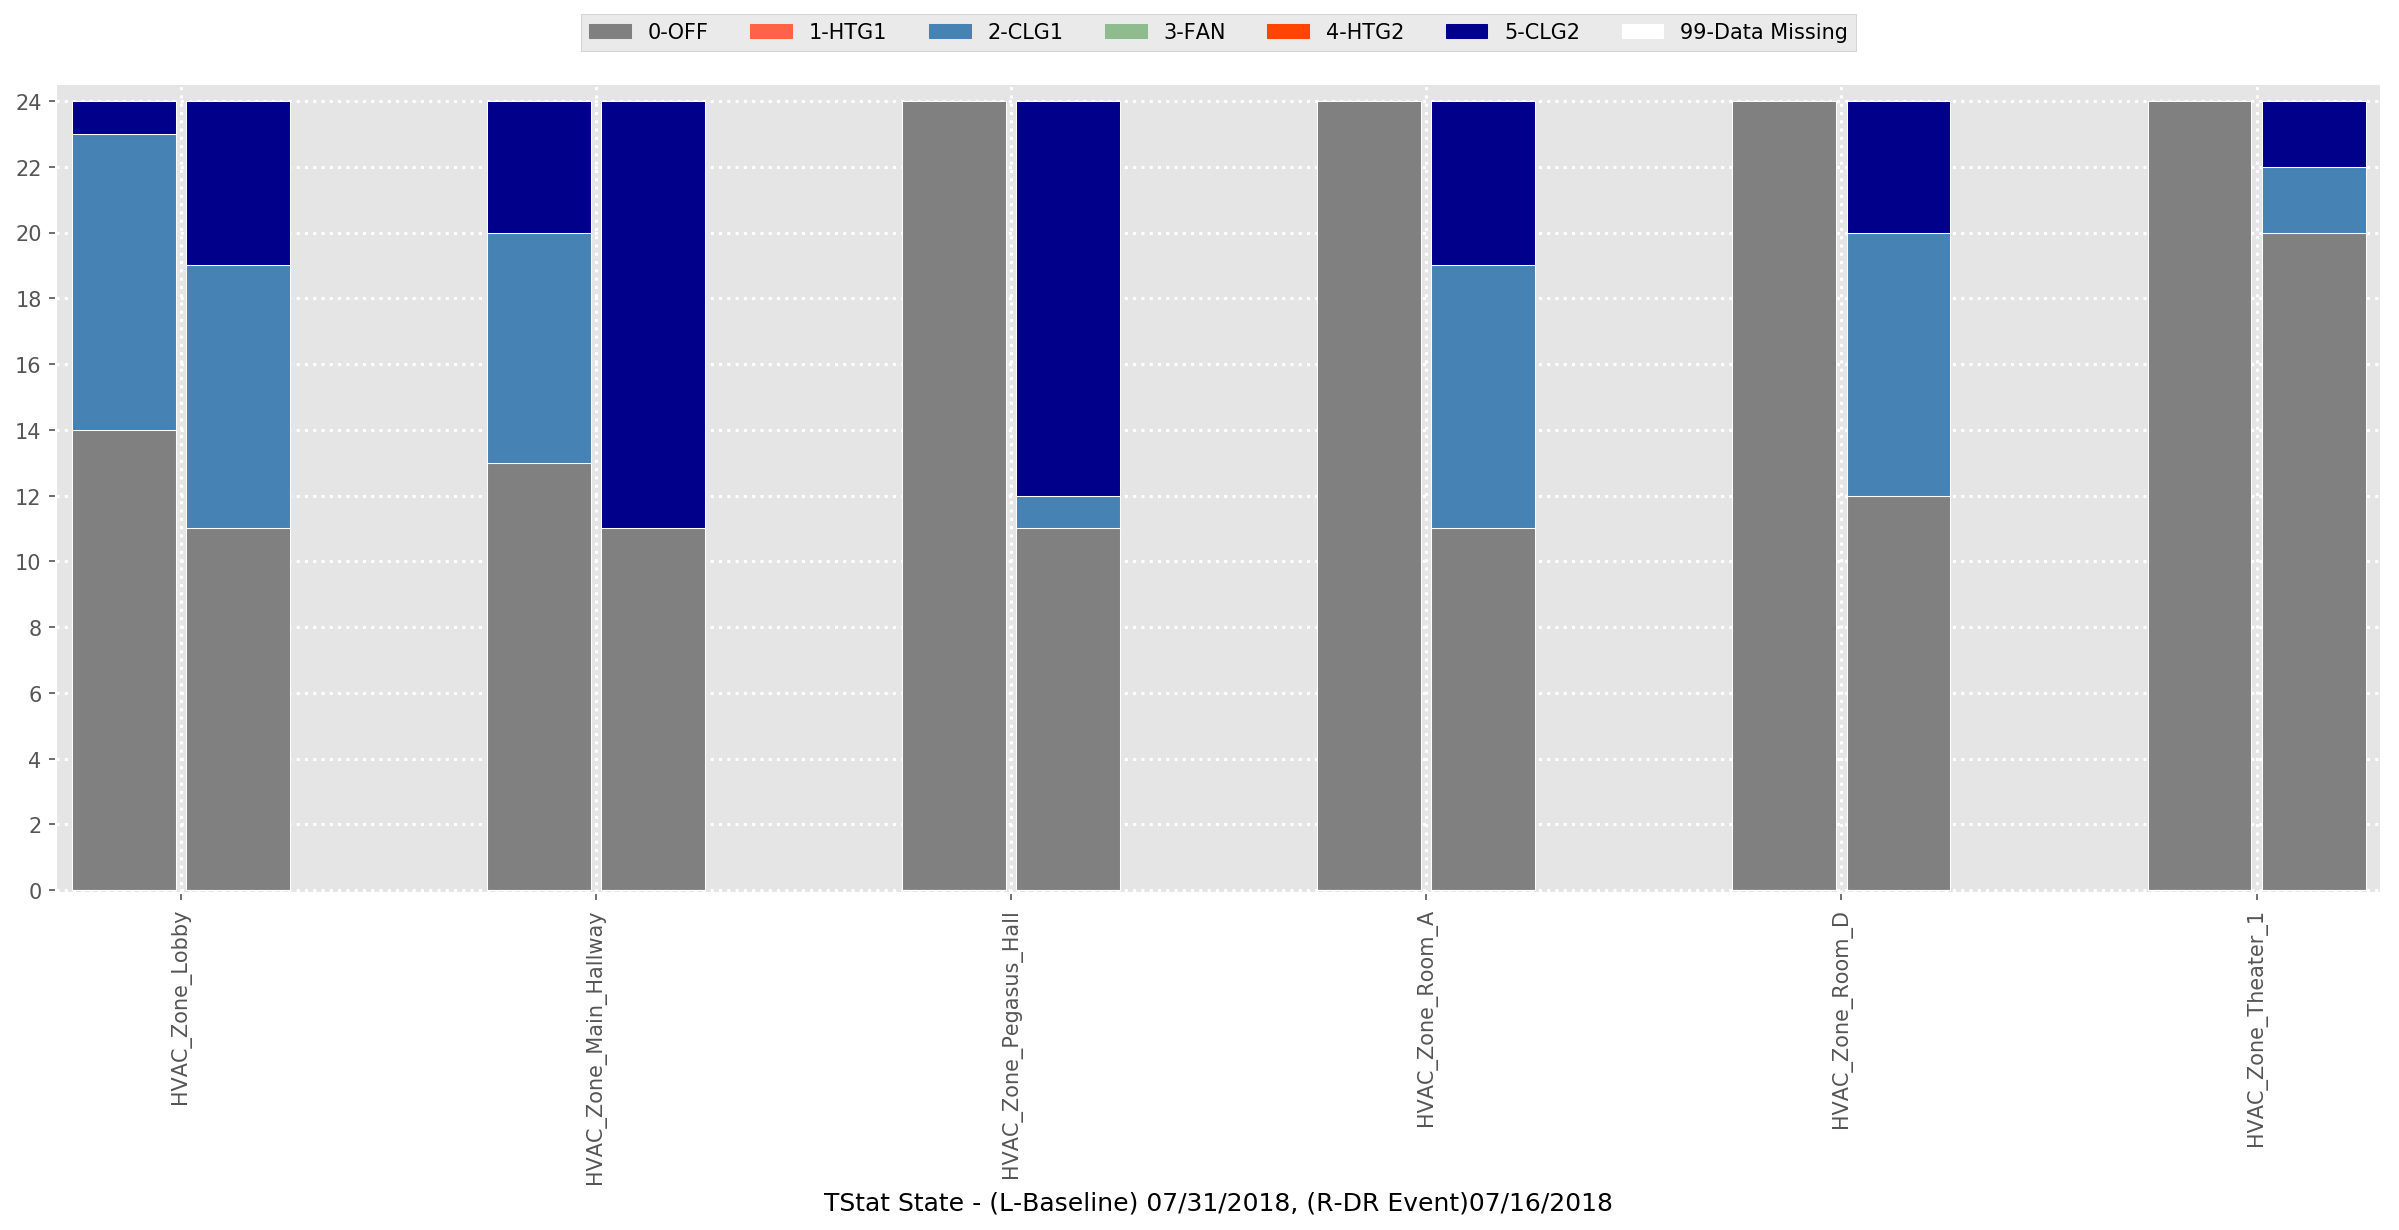

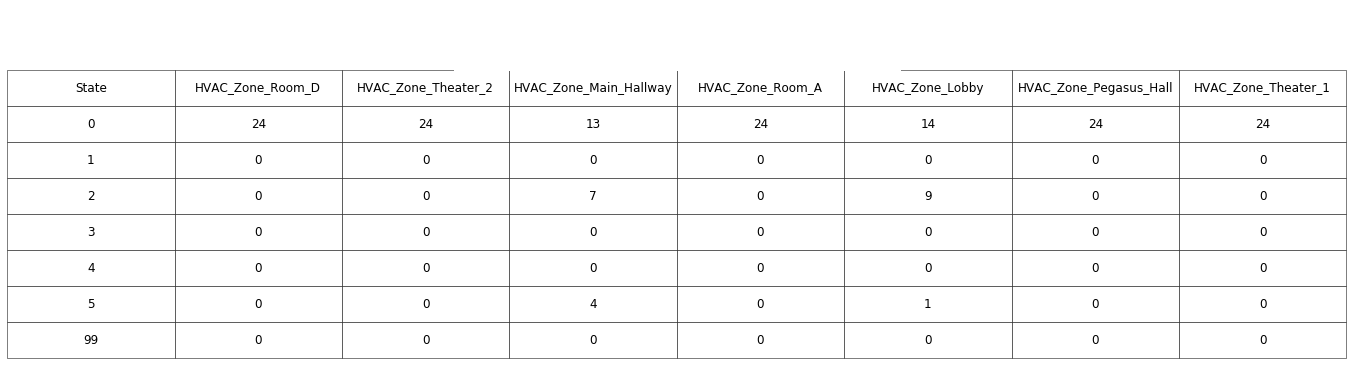

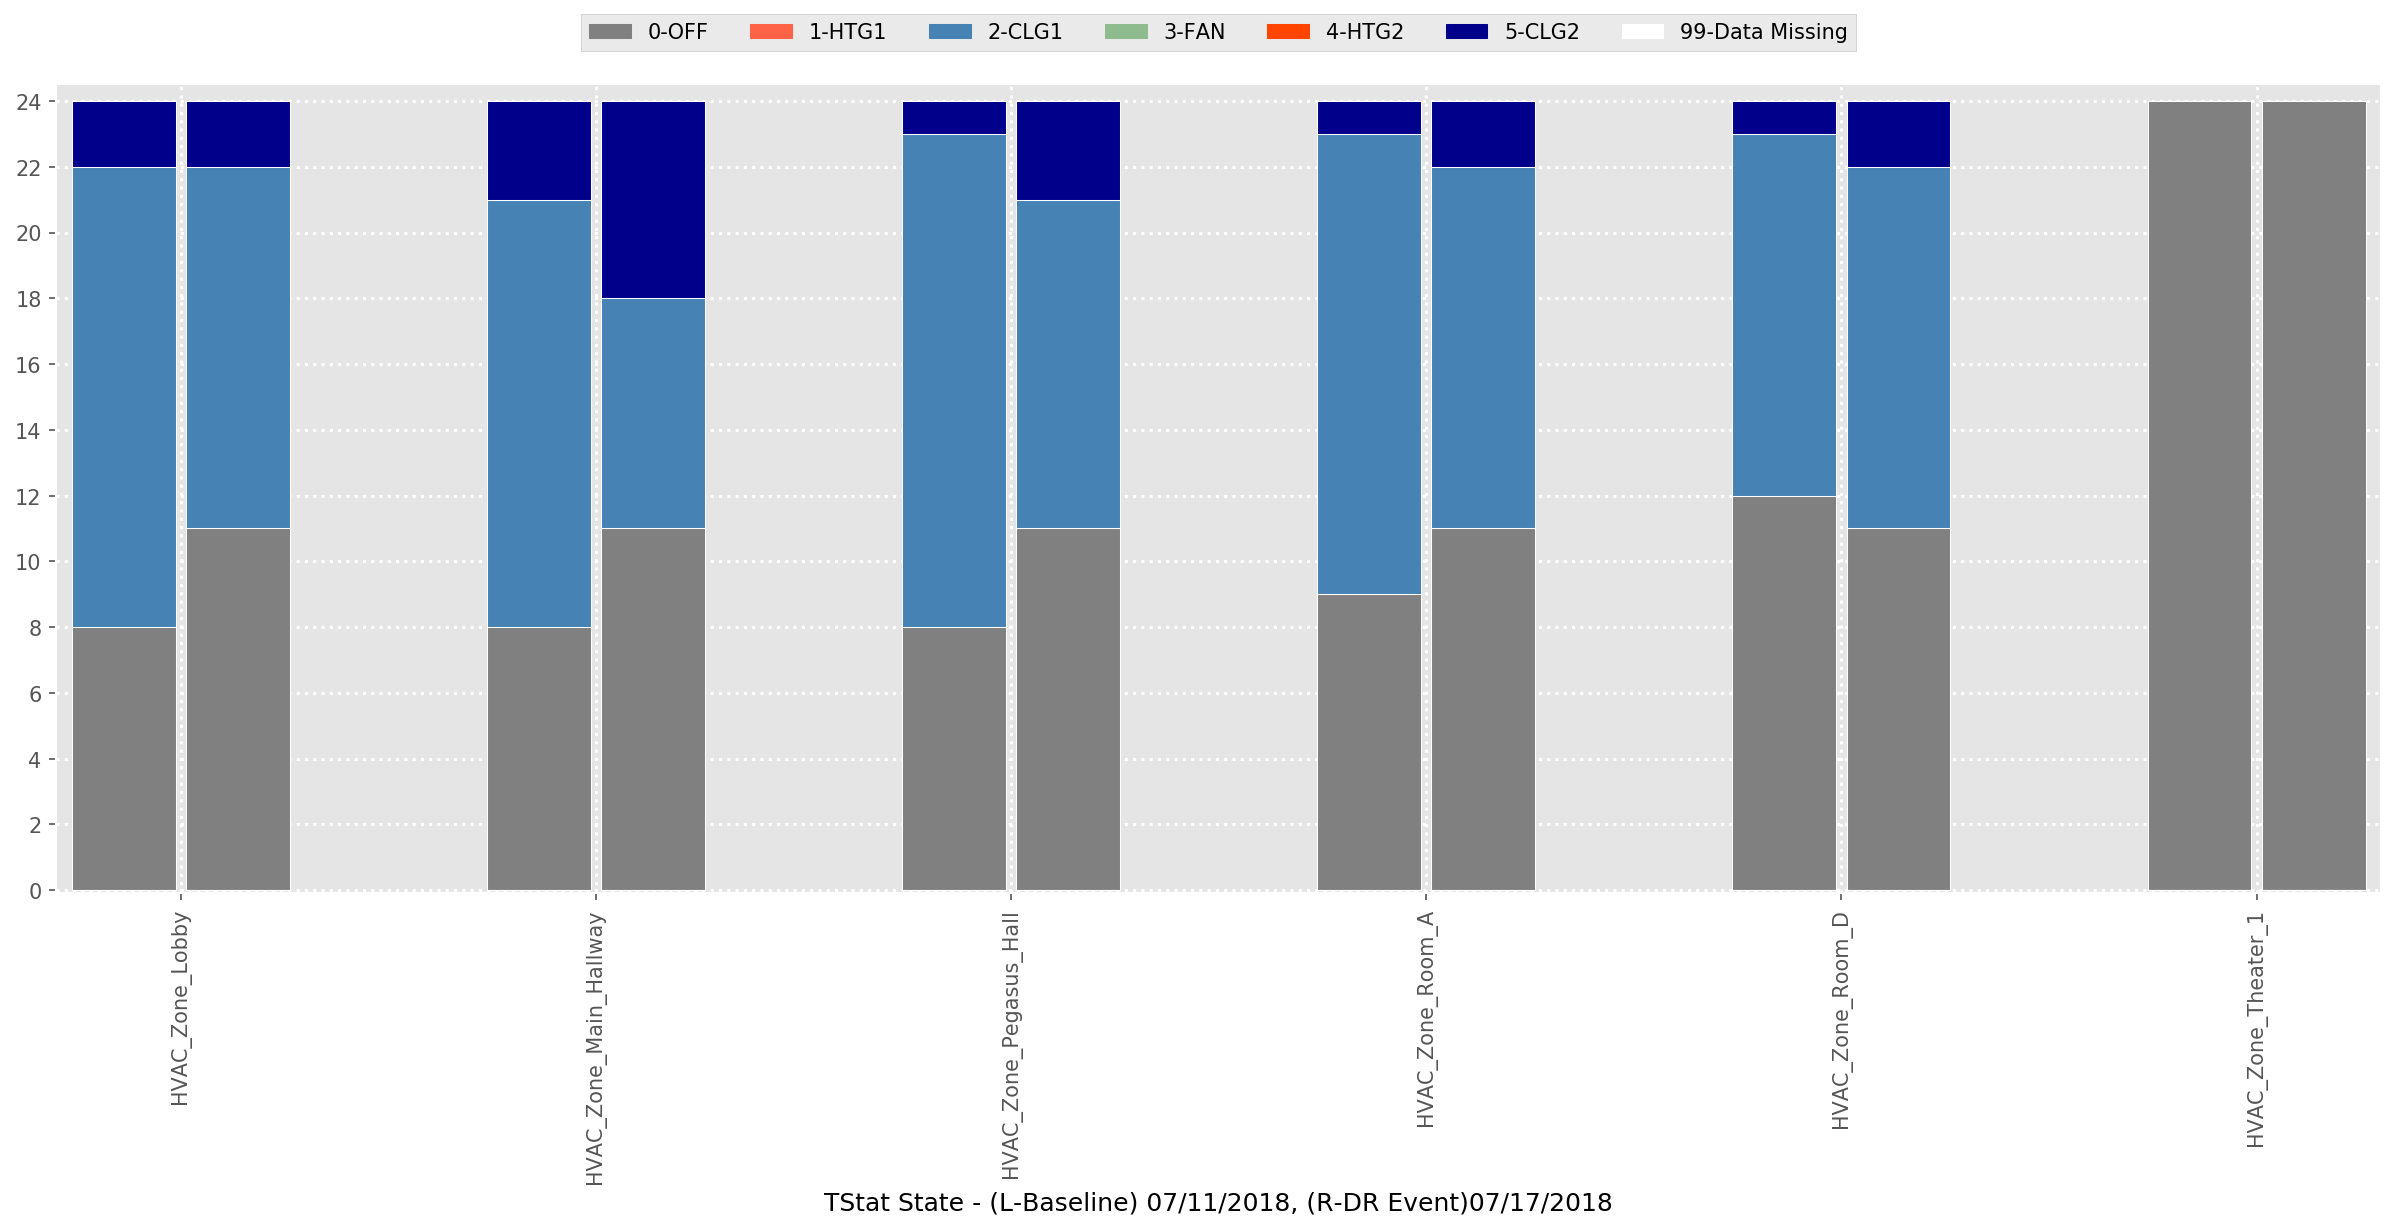

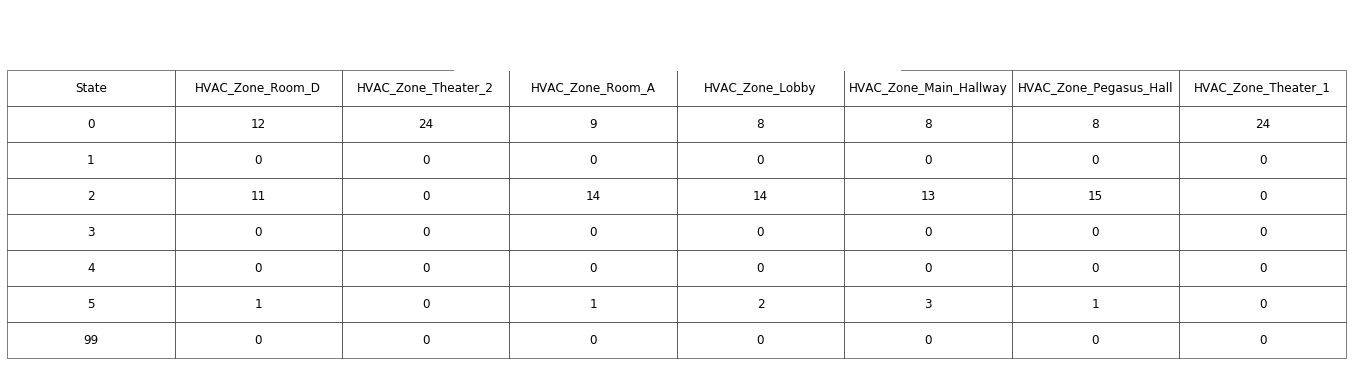

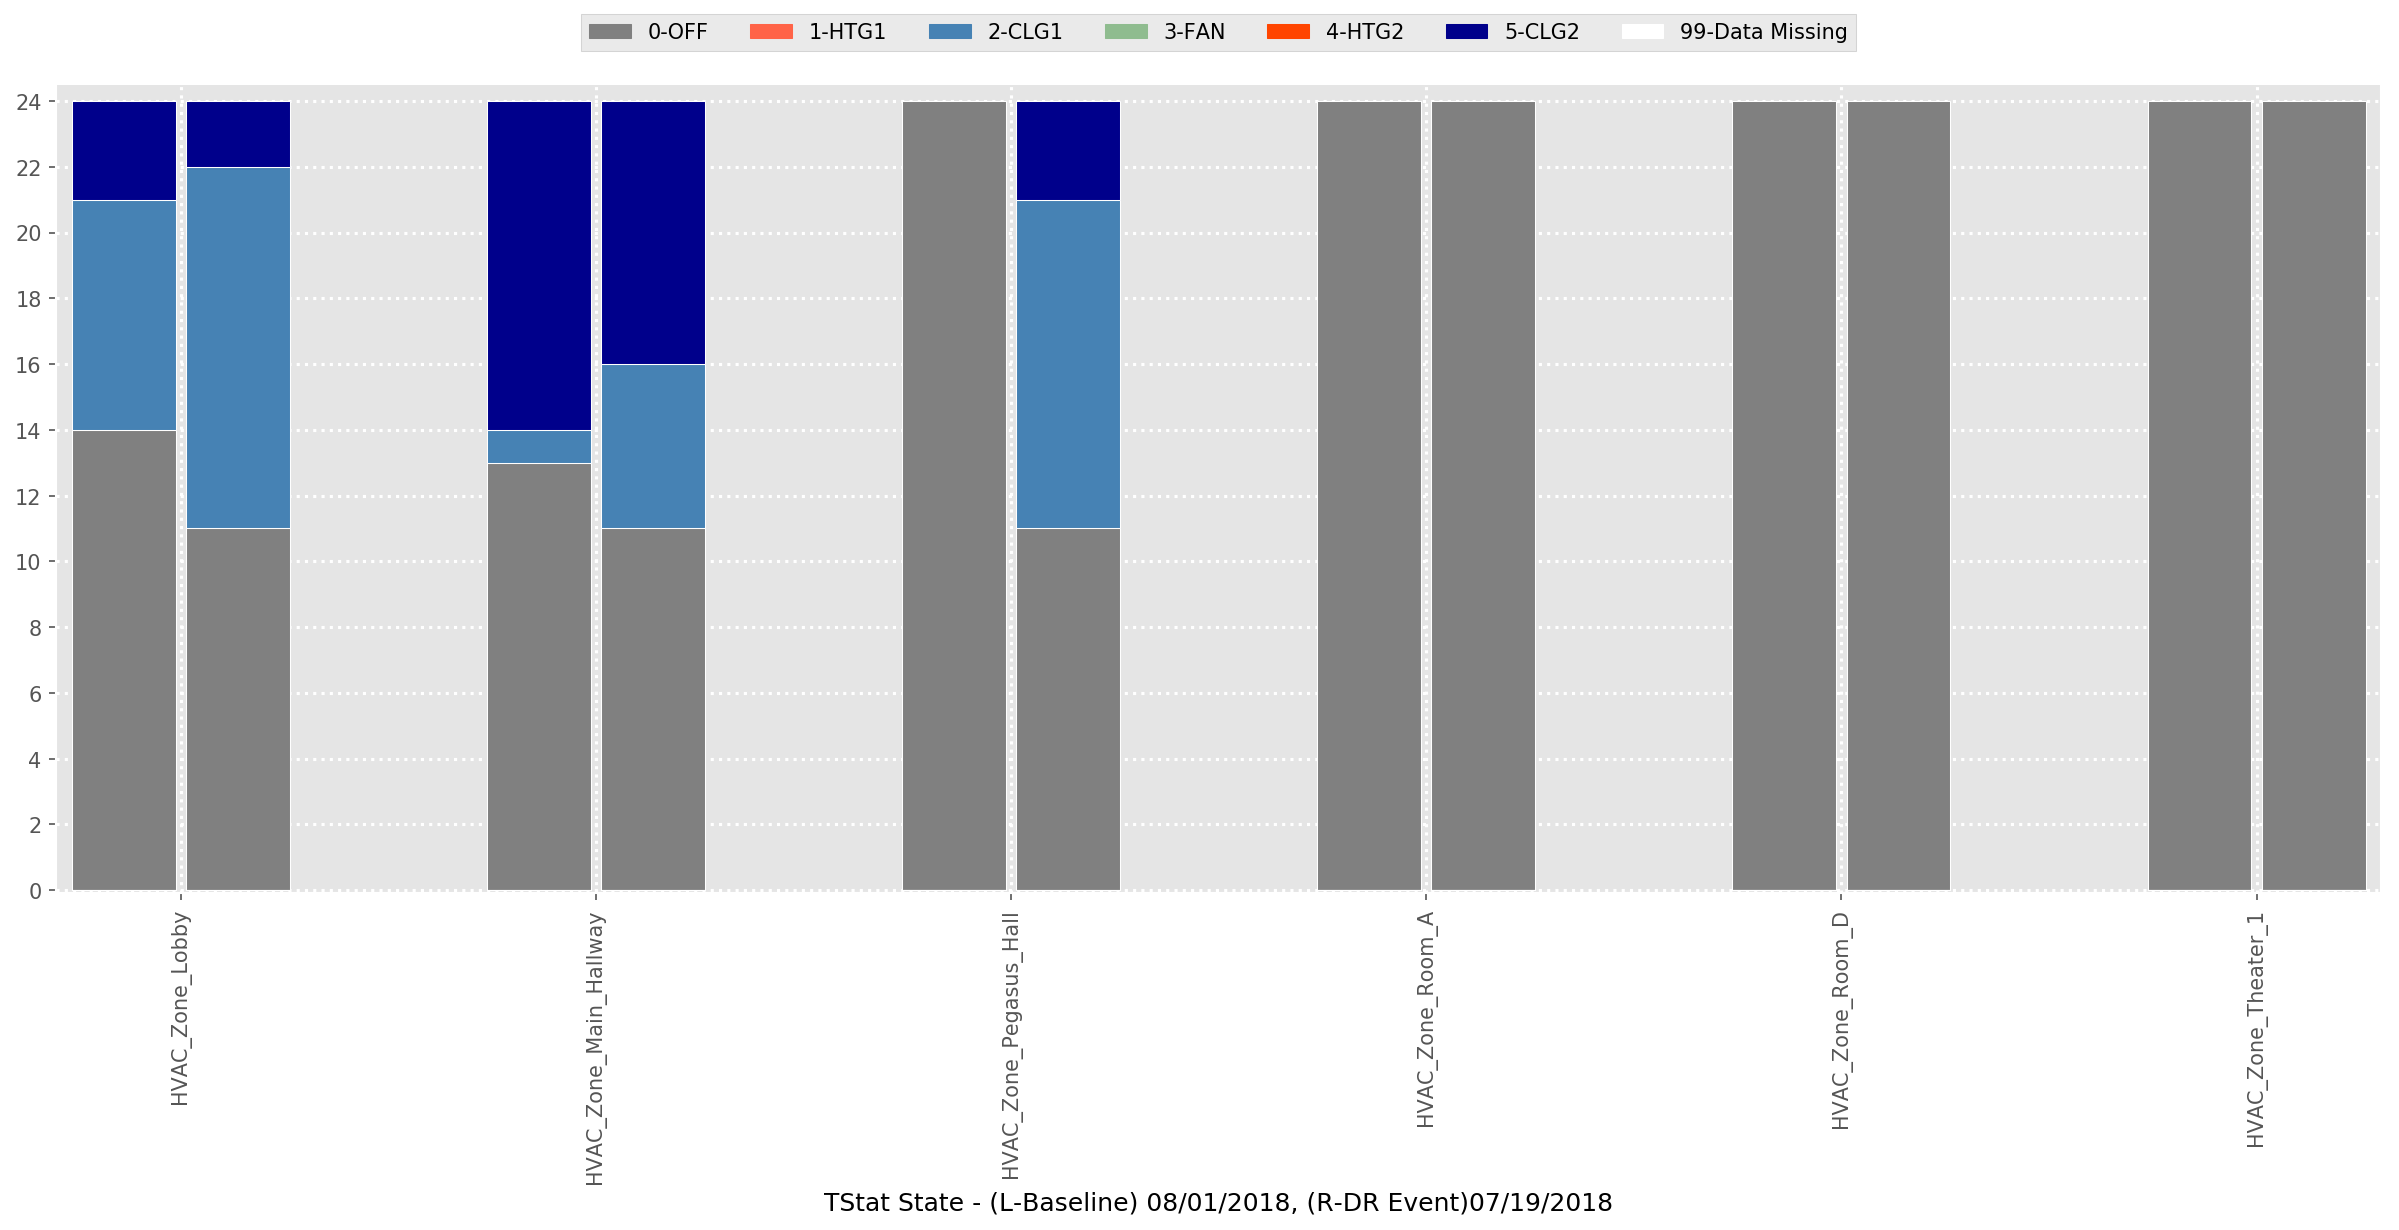

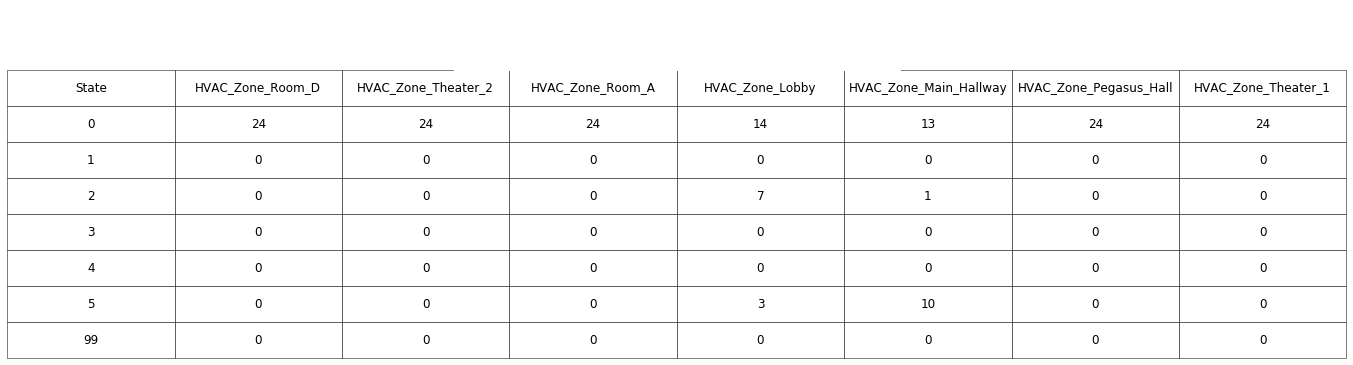

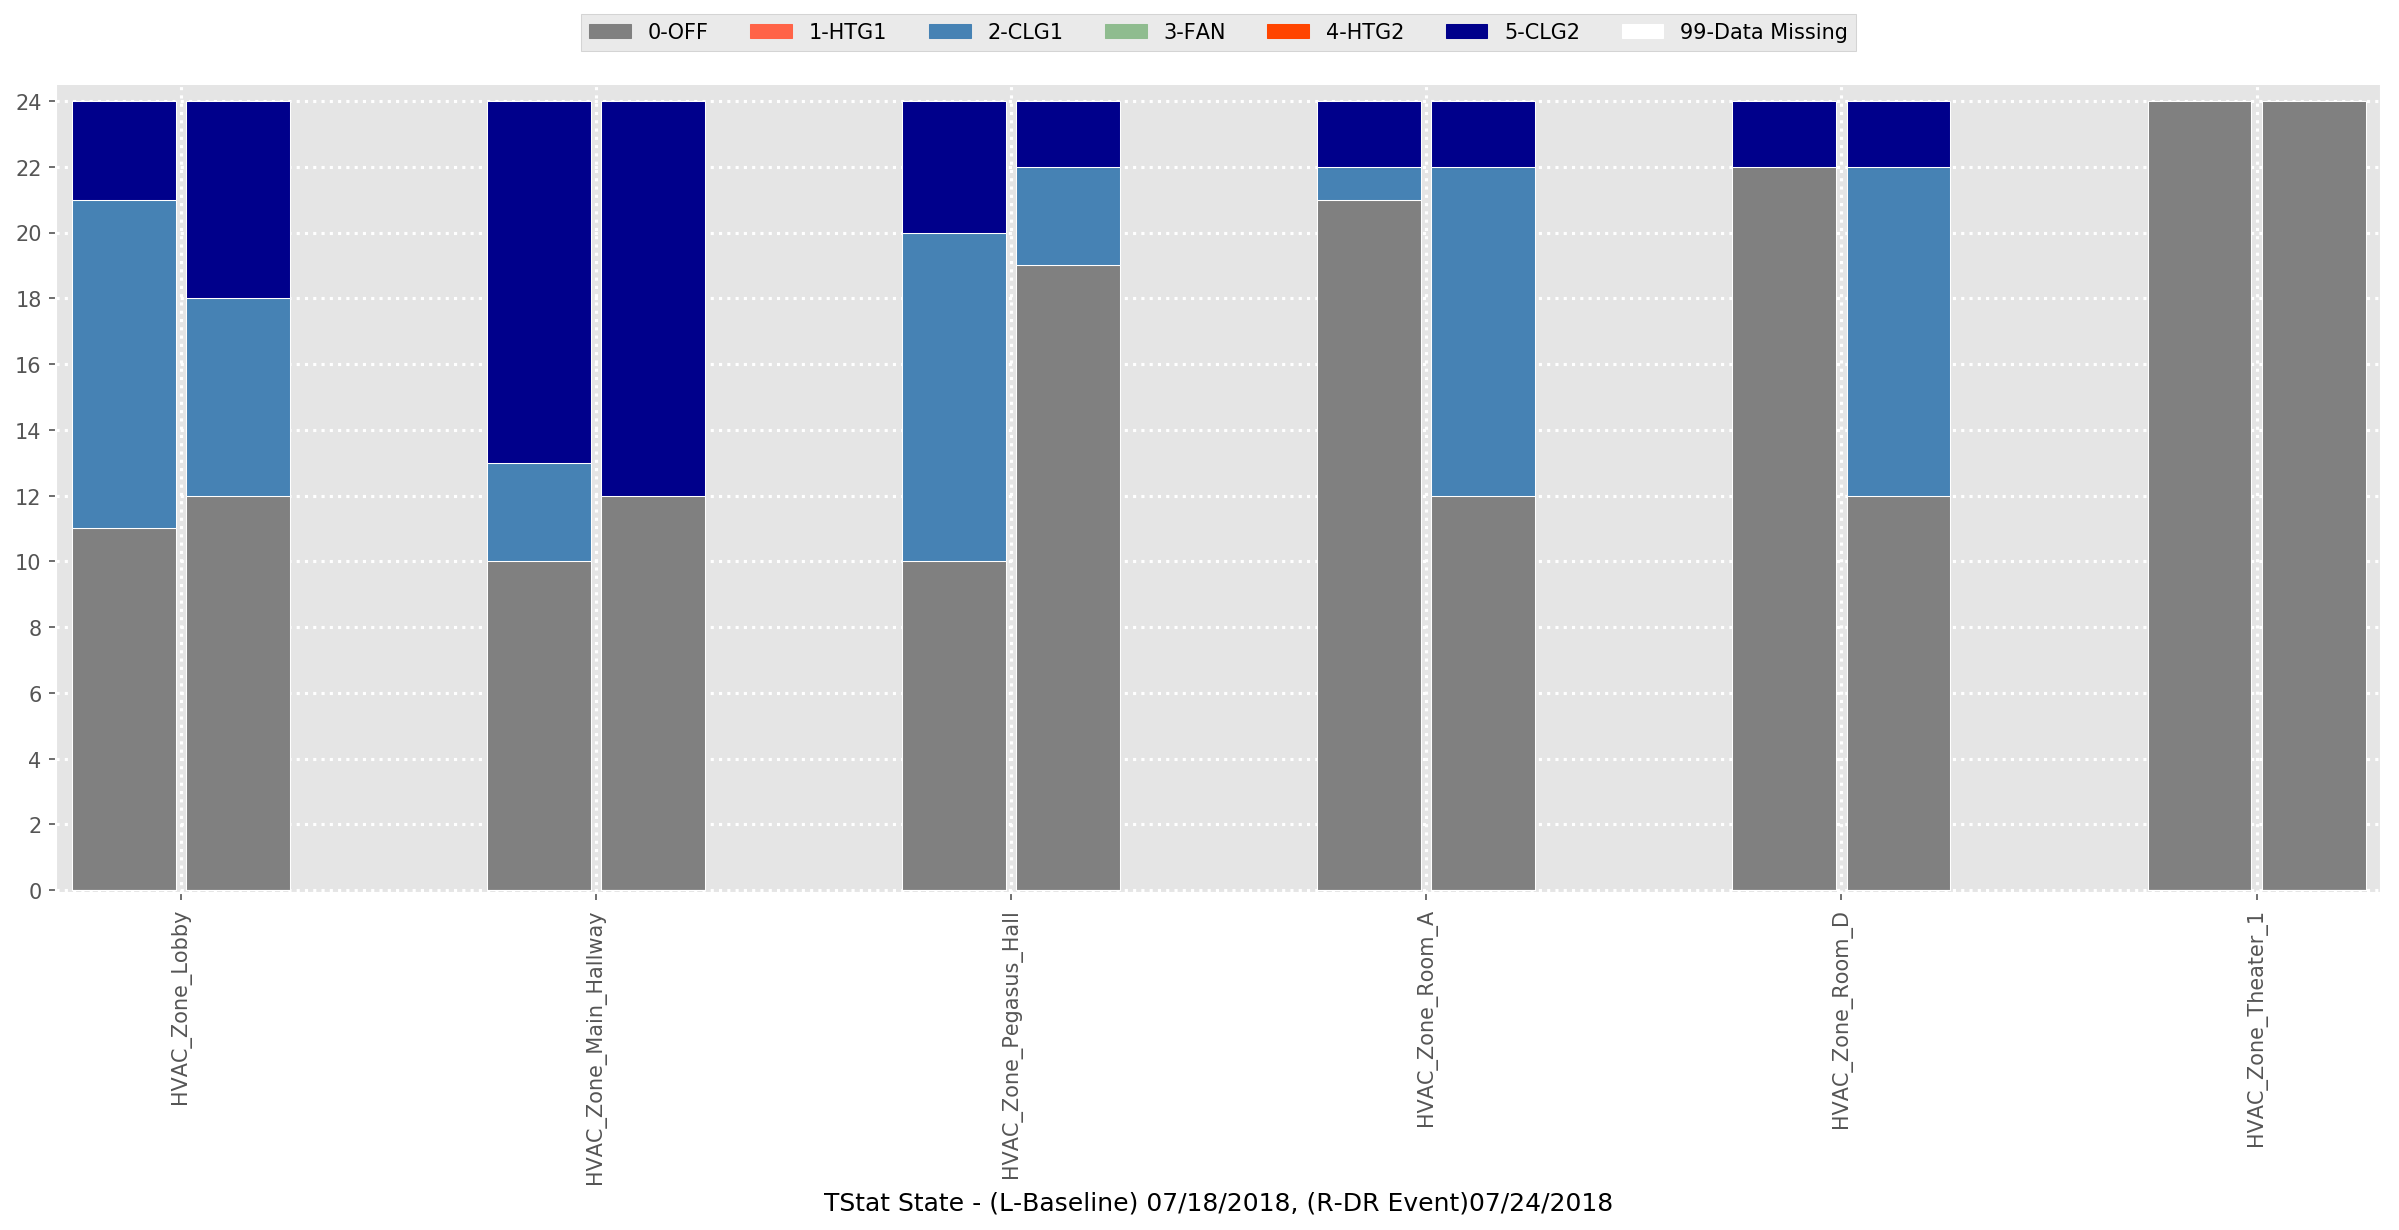

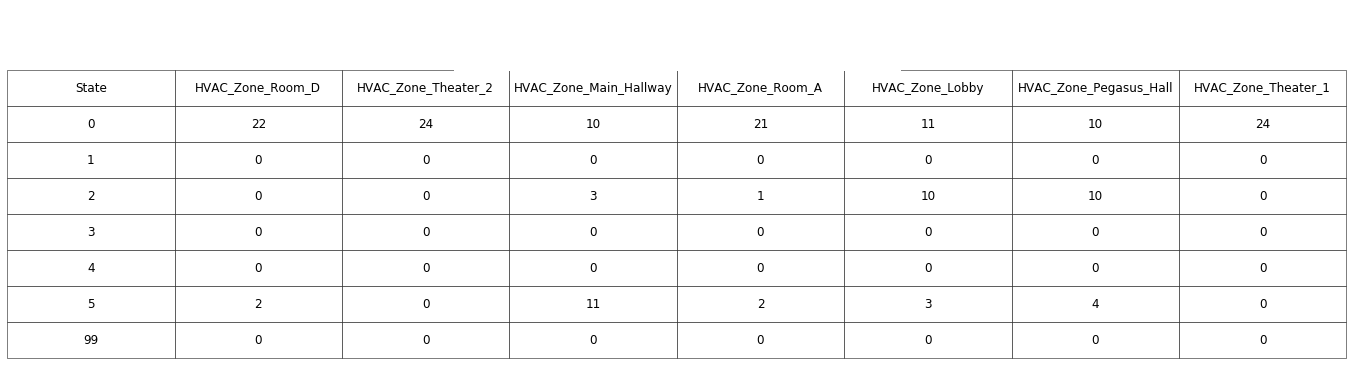

In [14]:
#PLOT all PGE
plot_all_events_buildings(PGE_PDP,PGE_SITES)

In [ ]:
bldg = 'avenal-movie-theatre'
zone = 'HVAC_Zone_Lobby'
# bldg = 'test'

